# Fine tunned

In [ ]:
import json
import logging
from tqdm import tqdm

from llamafactory.chat import ChatModel
from llamafactory.extras.misc import torch_gc
from src.utils import extract_sql, chdiff
from src.levenshtein import levenshtein_distance
from src.judge import SqlJudge

logging.disable(logging.WARNING)

BASE_MODEL_PATH = "Qwen/Qwen3-0.6B"
ADAPTER_PATH = "out/checkpoint-1500"
DATASET_PATH = "data/dataset_test.json"
SYSTEM_PROMPT_INDEX = 0
MAX_TEST_SIZE = 500
VERBOSE = False 

with open(DATASET_PATH, "r") as f:
    test_ds = json.load(f)

system_prompt = test_ds[SYSTEM_PROMPT_INDEX]["system"]


args = dict(
    model_name_or_path=BASE_MODEL_PATH,
    adapter_name_or_path=ADAPTER_PATH,
    template="qwen3",
    finetuning_type="lora"
)
chat_model = ChatModel(args)

sql_judge: SqlJudge = SqlJudge()

def print_color(text, color_code):
    print(f"\033[{color_code}m{text}\033[0m", end="", flush=True)

def print_red(text): print_color(text, 91)
def print_green(text): print_color(text, 92)
def print_yellow(text): print_color(text, 93)

def evaluate_entry(entry, system_prompt, verbose=False):
    user_prompt = entry["conversations"][0]["value"]
    true_sql = extract_sql(entry["conversations"][1]["value"])

    if verbose:
        print_green(f"\nUser:\n{user_prompt}")
        print_yellow("\nAssistant: ")

    response = ""
    messages = [{"role": "user", "content": user_prompt}]
    for chunk in chat_model.stream_chat(messages, system=system_prompt):
        if verbose:
            print_yellow(chunk)
        response += chunk

    predicted_sql = extract_sql(response)
    exact_match = (predicted_sql == true_sql)
    distance = levenshtein_distance(predicted_sql, true_sql)
    judge_score = sql_judge.score_response(true_sql, predicted_sql)

    if verbose:
        if exact_match:
            print_green("\n\nExact match!")
        print("\nDiff:\n", chdiff(true_sql, predicted_sql), "\n")

    return exact_match, distance, len(true_sql), judge_score

exact_match_count = 0
levenshtein_metrics = []
judge_scores = []

print(f"Evaluating {min(MAX_TEST_SIZE, len(test_ds))} examples...\n")


if VERBOSE:
    print_red(f"\nSystem:\n{system_prompt}")

for entry in tqdm(test_ds[:MAX_TEST_SIZE]):
    match, dist, query_len, judge_score = evaluate_entry(entry, system_prompt, verbose=VERBOSE)
    if match:
        exact_match_count += 1
    levenshtein_metrics.append({"query_length": query_len, "distance": dist})
    judge_scores.append(judge_score)
    torch_gc()

print("\n=== Evaluation Summary ===")
print(f"Exact Match: {exact_match_count}/{MAX_TEST_SIZE} "
        f"({(exact_match_count / MAX_TEST_SIZE) * 100:.2f}%)")

avg_lev = sum(m["distance"] for m in levenshtein_metrics) / len(levenshtein_metrics)
print(f"Average Levenshtein Distance: {avg_lev:.2f}")


/home/kyre/repos/llm-fine-tuning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 06-17 12:21:33 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 06-17 12:21:34 [__init__.py:239] Automatically detected platform cuda.


2025-06-17 12:21:35,884	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Evaluating 500 examples...



  0%|          | 1/500 [01:05<9:04:53, 65.52s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the average of explainability scores for regions in Europe and North America. 

First, the assistant's query is: SELECT region, AVG(explainability_score) as avg_explainability_score FROM creative_ai WHERE region IN ('Europe', 'North America') GROUP BY region;

Looking at the correct answer, they have the same structure but use AVG(explainability_score) instead of AVG. Wait, but AVG is used in a subquery. Oh, right! The correct answer uses AVG in the FROM clause, not a subquery. The assistant's query uses AVG but places it in a subquery. So that's a mistake. The correct answer doesn't have a subquery, just the AVG function. 

Wait, the correct answer is SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ... GROUP BY region. The assistant's query is SELECT region, AVG(explainability_score) as avg_explainability_score FROM 

  0%|          | 2/500 [01:22<5:07:21, 37.03s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the DELETE statement that removes records from the rural_infrastructure table where the country is Indonesia and the completion_date is before 2010-01-01. The assistant's query is the same as the correct one.

First, I need to check if the assistant's SQL is correct. The DELETE statement is properly formatted with the FROM clause, the WHERE clause, and the conditions. The country and completion_date are correctly specified. The comparison operator < is correct because it's checking for dates before a specific date. 

Now, looking at completeness. The assistant's query is exactly the same as the correct answer, so it's complete. The formatting is also correct, with proper syntax. There's no additional clauses or issues here. 

I should score it as 10 because it's exactly correct. The assistant didn't make any errors, so the score is 10.
</think>

10  

**Ex

  1%|          | 3/500 [01:51<4:35:28, 33.26s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select launch_provider and count the number of accidents per provider, grouped by launch_provider. 

Now, the assistant's query is: SELECT launch_provider, COUNT(*) FROM Accidents WHERE launch_provider IN ('SpaceX', 'Blue Origin') GROUP BY launch_provider;

First, I need to check if the assistant's query is correct. The problem is that the WHERE clause is filtering for specific providers, but the correct approach is to group by the provider and count. The WHERE clause is filtering the results, but the query is grouping them after filtering. So, the WHERE clause is not needed here. The correct query should be SELECT launch_provider, COUNT(*) FROM Accidents GROUP BY launch_provider; without any WHERE clause. 

The assistant's query has an extra WHERE clause, which is incorrect. So the first point is that the assistant's query is wrong. The WHERE clause is not needed here. 

  1%|          | 4/500 [02:13<3:57:48, 28.77s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the maximum quantity from the sales table. The assistant's query is a bit different. 

First, I need to check if the assistant's query is correct. The correct query is SELECT MAX(quantity) FROM sales; but the assistant's query has a WHERE clause. The WHERE clause is adding an extra condition. The original question probably didn't specify any conditions, so the assistant's query is adding unnecessary filtering. That would make the assistant's query wrong.

Now, about completeness. The assistant's query is missing the SELECT clause. The correct answer includes the SELECT MAX(...), but the assistant's query doesn't have that. So that's a problem. Also, the WHERE clause is not needed if there are no conditions. The assistant's query is adding an extra condition, which is not correct.

Formatting: The assistant's query has a WHERE clause, but that's not necessary. The 

  1%|          | 6/500 [03:02<3:40:57, 26.84s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the first one, which inserts attorney_name, attorney_email, attorney_phone. The candidate response is inserting attorney_id, attorney_name, email, phone.

First, I need to check for correctness. The correct query uses the attorney_name, attorney_email, attorney_phone fields. The candidate's query uses attorney_id instead of attorney_name. That's a big mistake because the primary key in a table like this is usually the primary key. So that's a 0, since it's completely wrong.

Next, completeness. The candidate's query includes all the required fields. The correct answer also includes all three fields. So that's good, but maybe there's something else. Wait, the candidate's query uses attorney_id, which is not a primary key. But the main issue is the primary key. So even if completeness is okay, the mistake is in the primary key.

Formatting is also a problem.

  1%|▏         | 7/500 [03:40<4:10:29, 30.49s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that groups by plant_name, sums co2_emission_per_ton_produced, and orders by total_co2_emission descending. The assistant's response is similar but uses a different column name.

First, I need to check if the assistant's query is correct. The correct query uses SUM(co2_emission_per_ton_produced) and GROUP BY plant_name. The assistant's query does the same, but the column name is co2_emission_per_ton_produced. That's a typo, which would be a mistake. So that's one point for correctness.

Next, completeness. The assistant's query includes the necessary columns: plant_name and co2_emission_per_ton_produced. The correct answer also includes those columns, so that's correct.

Formatting: The assistant's query has a semicolon at the end, which is correct. The correct answer also has a semicolon. So that's another point.

Wait, but the assistant's query i

  2%|▏         | 8/500 [04:23<4:43:40, 34.59s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is selecting the sum of total_cost from climate_communication where location is 'Antarctica' and end_date is on or after 2010-12-31. The assistant's query is similar but uses end_date > '2010-01-01'. 

Wait, the correct condition is >=, not >. The assistant's query uses >, which is incorrect. That's a mistake. So that's one error. 

Now, completeness. The assistant's query is missing the sum function. The correct answer includes SUM(total_cost), but the assistant's query doesn't. So that's a problem. Also, the assistant's query has a typo in the WHERE clause. 

Formatting: The assistant's query has proper syntax, but maybe the end_date comparison is wrong. However, the assistant's query is correct in terms of structure. The correct answer uses >=, which the ass

  2%|▏         | 9/500 [04:39<3:55:26, 28.77s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is SELECT name, conservation_status FROM marine_species. The assistant's query is the same as the correct one. 

First, I need to check if the assistant's query is correct. The SELECT statement is properly formatted, and it's selecting the columns. The table name is correct. The columns are named as given. There's no syntax error here.

Now, completeness. The assistant's query is exactly what the correct answer is. It doesn't add any extra columns or conditions. So that's good.

Formatting is also correct. The SQL is properly enclosed in quotes, and the table name is in parentheses. The query is straightforward.

So, the score should be 10 because it's exactly correct. The assistant did everything right. No errors detected. The answer is perfect.
</think>

Score: 10  

**Explanation:**  
The assistant's SQL query is **exactly correct**. It matches the reference SQL in terms of

  2%|▏         | 10/500 [05:37<5:09:45, 37.93s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the organization and the average of publications from the researchers table where the organization is 'National Geographic'. The assistant's query is selecting the average of publications from the same table, but they didn't include the organization column in the SELECT statement. That's a problem because the query should include the organization to get the correct data.

So, the assistant's query is missing the organization field. The correct query needs to have both organization and publications in the SELECT clause. The user's reference SQL does include both, so the assistant's query is missing the organization. That's one error. Then, the formatting is correct because the column names are properly written as organization and publications. The WHERE condition is also correct. 

Putting it all together, the assistant's query is parti

  2%|▏         | 11/500 [05:53<4:14:01, 31.17s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of dapp_downloads from dapp_ranking where the region is Asia-Pacific. 

Now, the assistant's query is COUNT(*) instead of SUM(dapp_downloads). That's a big mistake because COUNT(*) gives the number of rows, not the sum. The correct query should use SUM, which is essential for the problem. 

Completeness is okay because the query is structured properly. The region filter is correctly applied. The formatting seems right too. So, the score should be 0 because it's completely wrong. The assistant didn't use the correct function and the query is missing the SUM part.
</think>

Score: 0  

**Explanation:**  
The assistant's SQL query uses `COUNT(*)` instead of `SUM(dapp_downloads)`, which is incorrect. The correct query should calculate the sum of dapp_downloads for regions matching 'Asia-Pacific'. The query is also missing the necessary `SUM` function, making i

  2%|▏         | 12/500 [06:30<4:26:29, 32.76s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the name of forests where their country is Canada or USA and their hectares are over 1,000,000. 

Now, the assistant's query is: SELECT * FROM forests WHERE country IN ('Canada', 'USA') AND hectares > 1000000.0;. 

First, I need to check if this is correct. The correct answer uses the country column, but the assistant's query is using 'country IN' which is a subquery. However, the correct answer's query uses a WHERE clause with country IN, which is the same as country = 'Canada' or country = 'USA'. So the country IN is correct here.

Wait, but the correct answer's query uses country = 'Canada' OR country = 'USA', but the assistant's query uses country IN. That's a slight difference. The correct answer is correct because the country can be either Canada or USA, and the assistant's query is using a subquery. However, the assistant's query is correct becau

  3%|▎         | 13/500 [06:47<3:48:59, 28.21s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the maximum response time from the emergency_calls table where the city is 'Los Angeles'. 

The assistant's query is the same as the correct one. Wait, but maybe there's a detail I'm missing. Let me check. The correct query uses MAX(response_time) and the WHERE clause with the city. The assistant's query does the same. So, is there any mistake here?

Hmm, maybe the assistant didn't account for possible duplicates in the city? But the problem states that the city is exactly 'Los Angeles'. The WHERE clause is correct. Also, the SELECT clause is properly using MAX. So the assistant's query is correct. 

But wait, maybe the assistant's query is missing a table or a column? No, the tables and columns are correctly specified. So the score should be 10, as it's exactly correct. I think that's right.
</think>

0

The assistant's SQL query is **completely correct**. It mat

  3%|▎         | 14/500 [07:29<4:22:21, 32.39s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one from the reference, which includes selecting district name, num_patrols, num_community, and grouping by district_id. The assistant's query is different.

First, the assistant's query selects p.district_id, p.date, COUNT(*) as total_patrols, COUNT(*) as total_events. But the correct answer has the total_patrols and total_events as num_patrols and num_community. The assistant's query has COUNT(*) twice, which is incorrect because COUNT(*) counts all entries, not just the ones in the patrol. Also, the correct answer groups by district_id, but the assistant's query doesn't use that. The correct answer includes the district name in the SELECT clause, which the assistant's query doesn't have. So the assistant's query is missing the district name and grouping by district_id, which are necessary for the correct answer.

Completeness: The assistant's query 

  3%|▎         | 15/500 [07:47<3:44:44, 27.80s/it]

<think>
Okay, let's see. The user asked for the average value of a column called 'value' in the 'contracts' table where the category is 'Cybersecurity'. The correct SQL query is given as SELECT AVG(value) FROM contracts WHERE category = 'Cybersecurity';. The assistant's response is the same as the reference.

First, I need to check if the assistant's query is correct. The AVG function is used correctly here, and the WHERE clause filters by the category. The table and column names match exactly. So that's a correct query.

Now, the score. The assistant's query is exactly the same as the correct one. So correctness is high. Completeness is also good because it includes the necessary parts. Formatting seems correct as well. There's no error in syntax or structure. So I would rate this as 10 points.
</think>

10/10

**Explanation:**  
The assistant's SQL query is **completely correct**. It uses the `AVG` function to calculate the average value of the `value` column in the `contracts` table

  3%|▎         | 16/500 [08:22<4:03:57, 30.24s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is DELETE FROM arms_imports WHERE year < 2000; but the assistant's response is the same as the correct one. The score should be 0 because it's exactly the same as the reference, which is wrong. Wait, no, wait. Wait, the correct answer is supposed to be the same as the user's question. But the assistant's response is the same as the correct answer. So the assistant's query is correct? But why is the score 0? Wait, no, maybe the assistant's query is correct but the user's question was different. Wait, the user asked a question, but the assistant's response is the same as the correct answer. So the assistant's query is correct, but the user's question was something else. But the score depends on the correctness of the assistant's query. If the assistant's query is exactly the same as the correct answer, then it's correct. But the score is 0? Wait, no. Wait, the user's question is

  3%|▎         | 17/500 [09:05<4:34:16, 34.07s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average of military personnel from Peacekeeping Operations. The assistant's response is different.

First, the assistant's query is: SELECT country, AVG(military_personnel) as avg_military_personnel FROM Peacekeeping_Operations GROUP BY country;. 

Looking at the correct answer, the SELECT statement should have the column names as is, but the assistant changed them to country and avg_military_personnel. That's a mistake because the columns should be military_personnel and country, not using the column names as group by. Also, the GROUP BY clause is correctly used here, grouping by country.

So the mistake is that the assistant used the column names as part of the SELECT statement. The correct answer should have the column names as military_personnel and country. Also, the GROUP BY clause is correctly placed. 

Wait, the correct answer doesn't have any GROUP BY

  4%|▎         | 18/500 [09:27<4:02:28, 30.18s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a window function to find the maximum investment per client daily. 

The assistant's query is: SELECT client_id, MAX(investment) FROM daily_investments GROUP BY client_id;. 

Hmm, the problem here is that the assistant's query doesn't use a window function. The correct answer uses a window function like MAX(investment) OVER (PARTITION BY client_id ORDER BY client_id). The assistant's query is grouping by client_id, which is correct, but they're missing the partitioning and ordering. 

So, the first part is correct in grouping, but the window function is missing. The assistant's query doesn't have the OVER clause, which is required for the window function. That's a key mistake. 

Completeness-wise, the assistant's query is missing the window function, which is necessary to get the maximum daily investment. The correct answer includes the w

  4%|▍         | 19/500 [09:55<3:58:52, 29.80s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct answer uses a JOIN between PORTS and CARGO_HANDLING on PortID, groups by PortName, and sums the Weight. The assistant's query uses a JOIN but doesn't join on PortID. Wait, no, looking at the assistant's query: it's SELECT PortName, SUM(Weight) as TotalCargoWeight FROM CARGO_HANDLING WHERE CargoType = 'Fruit' GROUP BY PortName;. Oh, right, the JOIN is missing here. The assistant didn't join on PortID, so that's a mistake. The correct query should have the JOIN.

Then, the assistant's query groups by PortName but doesn't include the SUM(Weight) column. The correct answer does include SUM(Weight) and GROUP BY PortName. Also, the assistant's query uses SUM(Weight) as TotalCargoWeight, which is correct, but the group by is missing. The correct answer has both. 

So, the main iss

  4%|▍         | 20/500 [10:53<5:04:58, 38.12s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is SELECT container_type, MIN(fuel_consumption) FROM container_ships WHERE year = 2016 GROUP BY container_type;. The assistant's query is similar but has a slight difference. The assistant's query uses MIN(fuel_consumption) as min_fuel_consumption, which is the same as the correct answer. However, the assistant's query uses the alias min_fuel_consumption instead of the variable name min_fuel_consumption. Wait, in SQL, variable names are case-sensitive. The correct answer uses min_fuel_consumption, but the assistant's query uses min_fuel_consumption as the alias. That's a mistake. The variable name should be min_fuel_consumption, not min_fuel_consumption. So that's one error.

Completeness: The assistant's query does include all the necessary columns and conditions. The c

  4%|▍         | 21/500 [11:25<4:50:41, 36.41s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference SQL is correct, and the assistant's response is the candidate one. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, let's look at the reference SQL. It selects county, state, the average prevalence of asthma, filters by age <18, county like 'rural', groups by county and state, orders by avg_prevalence descending, and limits to 10. That seems correct.

Now, the assistant's candidate SQL is: SELECT county, MAX(age) FROM asthma WHERE county = 'Rural' GROUP BY county. 

Wait, the assistant's query is using MAX(age) instead of AVG(prevalence). The reference SQL uses AVG, which is an average, while the assistant's query is using MAX, which is the maximum value. That's a mistake. So that's a key point. The assistant's query is wrong because it's using the wrong function. The reference uses AVG, so that's one error.

Completeness: The assistant's query doesn't include the

  4%|▍         | 22/500 [11:46<4:11:40, 31.59s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects region and sums the amount, grouping by region and filtering by sector 'Healthcare'. 

The assistant's query is similar but maybe missing some parts. Let me check. The assistant's query starts with SELECT region, SUM(amount) FROM investments WHERE sector = 'Healthcare' GROUP BY region; 

The correct answer includes SELECT, FROM, WHERE, GROUP BY, and the correct column names. The assistant's query does have all those parts. The SUM(amount) is correct. The grouping by region is also correct. The WHERE clause filters by sector. 

Wait, but in the correct answer, the WHERE clause is optional? No, because the WHERE clause is used to filter the rows. But in this case, the assistant's query includes it. The correct answer is correct. 

So the assistant's query is correct. The score should be 10 because it's perfect. The user might have made a typo in the WHERE

  5%|▍         | 23/500 [12:14<4:02:41, 30.53s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, let's look at the correct answer. The correct query is:

SELECT primary_objective, COUNT(*) as num_personnel
FROM intelligence_operations
WHERE operation_date >= DATEADD(year, -5, GETDATE())
GROUP BY primary_objective;

The assistant's query is:

SELECT i.operation_name, i.primary_objective, i.personnel_count
FROM intelligence_operations i
WHERE i.operation_date BETWEEN DATE_SUB(CURRENT_DATE, INTERVAL 5 YEAR) AND CURRENT_DATE;

Comparing the two, the assistant's query is different. The correct query uses "operation_date" and "GROUP BY" to group by primary_objective. The assistant's query uses "operation_name" instead of "operation_date", which is incorrect. Also, the assistant's query is missing the "WHERE" clause for the date range, which is necessary for filtering.

So, the assistant's q

  5%|▍         | 24/500 [12:30<3:28:42, 26.31s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT COUNT(*) FROM Donors WHERE region = 'South West';. The assistant's query is the same. So, the assistant's query is exactly the same as the correct one. That means it's correct in terms of syntax and structure.

Now, completeness. The assistant's query does what the correct one does. It selects the count of donors where the region is South West. The correct query also does that. So completeness is good.

Formatting: The assistant's query has the same structure and syntax as the correct one. No differences there. So formatting is correct.

Wait, but maybe there's something else? Let me check again. The assistant's query is identical, so both are correct. So the score should be 10, since it's perfect.
</think>

0. The assistant's SQL query is identical to the corre

  5%|▌         | 25/500 [12:55<3:24:42, 25.86s/it]

<think>
Okay, let's see. The user asked for a SQL query that joins Programs, DonorsPrograms, and Donations tables, groups by ProgramName, and sums the DonationAmount. 

First, the assistant's query starts with SELECT ProgramName, SUM(DonationAmount). That looks correct for the output. But the JOINs are missing. The correct query should join Programs, DonorsPrograms, and Donations on their respective IDs. The assistant's query only joins DonorsPrograms and Donations, but not the other two tables. 

Wait, the correct answer includes three tables: Programs, DonorsPrograms, and Donations. The assistant's query only joins DonorsPrograms and Donations, which is missing the Programs table. That's a mistake. The join is missing one table, which is a critical error. 

Completeness-wise, the query groups by ProgramName, which is needed. The SUM is correct. The formatting is a bit off because it's missing the INNER JOIN for Programs. The correct answer should have INNER JOINs on all three tables.

  5%|▌         | 26/500 [13:23<3:30:21, 26.63s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses DATE_FORMAT and GROUP BY Quarter. The assistant's query uses YEAR, MONTH, and AVG, but the correct answer uses DATE_FORMAT.

First, I need to check if the assistant's query is correct. The assistant's query is selecting YEAR, MONTH, and AVG from Donations where the year is 2022. But the correct answer should use DATE_FORMAT. Also, the assistant's query groups by Year and Month, which is correct, but the correct answer groups by Quarter. So the assistant's query is missing the Quarter column, which is necessary.

The assistant's query is missing the DATE_FORMAT function. That's a mistake. So that's one point for correctness. The grouping by Year and Month is correct, but the correct answer groups by Quarter. So that's another point. Also, the assistant's query doesn't use the correct function, so that's another issue. So overall, the assis

  5%|▌         | 27/500 [13:56<3:43:32, 28.36s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference SQL is the correct one, and the assistant's candidate response is the other. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the reference SQL does two things: inserts into the students table and updates the average mental health score for a specific district. The candidate response does the same but only updates the average for a district ID of 1, not 6789. So the first part is correct, but the second part is missing the district ID from the update. The candidate's query uses the district_id as 1, but the reference uses 6789. Also, the candidate's query doesn't select from the students table in the update, which is necessary because the average is calculated from the students table. 

Wait, in the reference, the update is on the school_districts table, and the average is calculated from the students table. The candidate's query updates the school_districts

  6%|▌         | 28/500 [14:28<3:51:54, 29.48s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects courses with OpenPedagogy = FALSE and there's no student with GradeLevel 12 and MentalHealthScore 75. 

First, the assistant's query has a subquery in the NOT EXISTS clause. The correct answer uses a subquery that selects all student IDs from Students where GradeLevel is 12 and MentalHealthScore is 75. Then, the assistant's query uses a subquery that checks for those students. Wait, but the correct answer's subquery is (SELECT StudentID FROM Students WHERE ...) and the assistant's query does the same. So that part seems correct.

Wait, the assistant's query has (SELECT StudentID FROM Students ...) and the correct answer does the same. So that's the same subquery. But the assistant's query has the NOT EXISTS clause as (SELECT 1 FROM Students ...). But in the correct answer, it's (SELECT 1 FROM Students ...). So the subquery is correct. 

  6%|▌         | 29/500 [14:59<3:54:08, 29.83s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT Department, AVG(Salary) FROM Employees WHERE YEAR(HireDate) = 2022 GROUP BY Department;. 

The assistant's query is similar but has a small difference. They used 'BETWEEN' instead of 'AND' for the date range. The original correct query uses 'AND' to include the entire year 2022, which is correct. 

Now, checking for correctness: the assistant's query is technically correct. The WHERE clause is using the YEAR function to filter the HireDate between January 1st and December 31st, which is the same as the correct query. The grouping by Department is also correct. 

Completeness: The assistant's query includes all the necessary columns and conditions. They also grouped by Department, which is required. 

Formatting: The assistant's query uses the correct syntax for 

  6%|▌         | 30/500 [15:15<3:21:54, 25.78s/it]

<think>
Okay, let's see. The user provided two SQL queries and asked to evaluate the assistant's response. The correct answer is the one that selects the count of wind farms in Canada between 2015 and 2018. The assistant's query is the same as the correct one.

First, I need to check if the assistant's SQL is correct. The WHERE clause is correctly filtering by country and installation year. The BETWEEN operator is used, which is correct. The COUNT(*) function is also properly used. So the assistant's query seems to be correct in terms of syntax and logic.

Now, the score. The user wants it from 0 to 10. Since the assistant's query is exactly the same as the correct answer, the score should be 10. The assistant did a perfect job. Completeness and formatting are both met. There's no error in the query. So the final score is 10.
</think>

Score: 10  

**Explanation:**  
The assistant's SQL query is identical to the correct answer, correctly filtering by country and installation year using

  6%|▌         | 31/500 [15:33<3:04:20, 23.58s/it]

<think>
Okay, let's see. The user asked for a SQL query to select renewable projects in India with a budget between 50,000 and 200,000. The correct answer provided is the one using the budget as a numeric value between 50.0 and 200.0. The assistant's query uses 50000000.0 and 20000000.0, which are in millions, but the actual range is in thousands. So that's a mistake. The budget should be in thousands, not millions. That's a 1-point error. Completeness is good because it's exactly what was asked. Formatting is correct. So the score should be 9.
</think>

Score: 9  
**Reasoning:**  
- **Correctness:** The assistant's query incorrectly uses 50,000,000.0 (which is 50 million) and 200,000,000.0 (200 million) instead of 50,000 and 200,000 (in thousands).  
- **Completeness:** The query meets the requirement to select projects in India with a budget in the specified range.  
- **Formatting:** The query is properly structured and uses correct SQL syntax.  

**Score:** 9


  6%|▋         | 32/500 [15:56<3:00:51, 23.19s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses DATE_SUB(CURRENT_DATE, INTERVAL 6 MONTH) to get the date 6 months ago. The assistant's query uses DATEADD(month, -6, CURRENT_DATE), which is equivalent because DATEADD adds months. Both should work. 

But wait, the assistant's query is using DATEADD, which is the same as DATE_SUB. So that's correct. The grouping by market is also correct. The query is selecting AVG(price) and grouping by market. The date condition is correctly set to 6 months ago. 

The assistant's query is missing a WHERE clause. Wait, no, the assistant's query has the WHERE market = 'EU ETS' and date >= DATEADD(...). But the correct answer includes the same conditions. So the assistant's query is correct in terms of conditions. 

Formatting-wise, the SQL is correct in syntax. The functio

  7%|▋         | 33/500 [16:13<2:45:40, 21.29s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects building_type and averages energy_rating where the building_type is 'Commercial' and location is 'Texas'. The assistant's response is the same as the candidate, but maybe they didn't check if all columns are included. Wait, the correct query has SELECT building_type, AVG(energy_rating) FROM energy_efficiency WHERE building_type = 'Commercial' AND location = 'Texas'; so the assistant's query has the same columns and conditions. But maybe the assistant forgot to include the building_type and AVG function? No, the assistant's query includes both. So the assistant's query is correct. But wait, the assistant's query has AVG(energy_rating), which is correct. The conditions are also correct. So the score would be 10, because it's correct. But maybe the assistant missed something? Like, perhaps they didn't include the building_type and location. But the correct answer includes both. So I thin

  7%|▋         | 34/500 [16:32<2:41:24, 20.78s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is DELETE FROM oil_rig WHERE company = 'XYZ Inc.'.

The assistant's response is the same as the correct one. So, the first thing to check is correctness. The DELETE statement is correct. The WHERE clause is also correct. The company name is matched exactly. So the assistant's SQL is correct in terms of syntax and content.

Now, completeness. The query deletes data, so the assistant's response is providing the DELETE statement. The user might expect that the query is the correct answer, so completeness is satisfied here.

Formatting: The SQL is properly formatted with proper syntax. The table name is 'oil_rig', and the WHERE clause is correctly written. There's no extra or missing parts. So formatting is also correct.

Wait, but maybe the user wants to check if there's any missing part. For example, if the question was about updating, but the assistant's query is deleting. But 

  7%|▋         | 35/500 [16:50<2:35:18, 20.04s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects player names and averages running speed from the world_cup table, grouping by player. The assistant's query is the same as the correct answer. So, is the assistant's SQL correct?

First, I need to check if the query is properly structured. The SELECT statement is correct with player and AVG(running_speed). The GROUP BY clause is also correctly applied. The table name 'world_cup' is used. The syntax looks right.

But wait, the assistant's query is identical to the correct answer. So, the answer is correct. But maybe there's something else. For example, does the correct answer require a JOIN or something else? No, the assistant's query is exactly the same. So the score should be 10 because it's perfect. But wait, sometimes people might overlook table names or other details. But in this case, everything matches. So I think the score is 10.
</think>

0  

*

  7%|▋         | 36/500 [18:08<4:48:42, 37.33s/it]

<think>
Okay, let's see. The user provided the correct SQL query and wants me to evaluate the assistant's candidate response. The assistant's SQL is something that I need to check against the reference.

First, the reference SQL is selecting the maximum assists from the season_stats table where the country is in the list of countries from the players table where the players' country is in season_stats.country and the country starts with 'Europe'. The assistant's SQL is empty. Wait, that can't be right. The assistant's response is an empty string, which probably means they didn't provide any query. But maybe they just copied the assistant's answer without formatting properly. 

Wait, looking back at the user's message, the assistant's SQL is presented as empty. But the correct answer is supposed to be the assistant's query. Maybe the user made a mistake in formatting. The correct answer should be the assistant's query, but if they didn't provide it, maybe the score is zero because they 

  7%|▋         | 37/500 [18:23<3:57:07, 30.73s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of points from the players table where the country is Brazil. 

The assistant's query is the same as the reference SQL. Hmm, so they're actually correct in the syntax. But wait, does the assistant have any other issues? Let me check.

The query uses the correct SELECT clause, the FROM clause, and the WHERE clause. The WHERE condition is properly set to 'Brazil'. The SUM function is correctly used. There's no error here. 

Completeness: The query does what the user asked. It's a valid SQL statement. Formatting: The query is correctly structured with proper syntax. So the score should be 10, right? Because it's exactly correct. No mistakes detected. The assistant is doing the right thing.
</think>

10 / 10  

**Explanation:**  
The assistant's SQL query is **exactly correct**. It matches the reference SQL in syntax, logic, and formatting. There are no errors

  8%|▊         | 38/500 [18:46<3:38:24, 28.37s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct query is selecting organization_id, location, count of supplies, and total supply cost. The assistant's query has a typo in the COUNT(*) column. It should be COUNT(*) instead of COUNT. That's a mistake, so that's one point.

Next, the assistant's query doesn't include the SUM(supply_cost) column. The correct query has that. So that's another point. So two mistakes here.

Formatting-wise, the assistant's query is similar but missing the SUM and the total cost. The correct query includes all the necessary columns and the correct grouping. The assistant's query is missing the SUM and COUNT, so that's two more points.

So total score would be 0 because they're wrong in multiple aspects. The correct answer is the one provided, and the assistant's response is incorrect. So the sc

  8%|▊         | 39/500 [19:05<3:16:04, 25.52s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select country and sum project_count grouped by country. The assistant's query is different.

First, the assistant's query is selecting SUM(project_count) from ngos, but they used WHERE country = 'Yemen'. That's wrong because the WHERE clause is supposed to filter rows, not sum them. The correct approach is to group by country and sum the values. Also, the WHERE clause isn't necessary here; instead, grouping by country and summing would handle the data.

So, the assistant's query is incorrect in two main ways: using a WHERE clause instead of a GROUP BY, and not summing. The correct query should be SELECT country, SUM(project_count) FROM ngos GROUP BY country. 

Now, the score. Correctness is 0 because it's wrong. Completeness is 0 because it's missing the GROUP BY. Formatting is 0 as well. So the total is 0.
</think>

0.0  

**Explanation:**  
- **Correctness:** The assi

  8%|▊         | 40/500 [19:32<3:19:38, 26.04s/it]

<think>
Okay, let's see. The user asked for a SQL query that selects the brand name and counts the number of fair trade certifications for each brand, then orders them by the count in descending order. The correct answer provided by the reference is a SELECT statement that includes brand_name, COUNT(*), and groups by brand_name. The assistant's query is a bit different.

First, the assistant's query starts with SELECT brand_id, COUNT(*) FROM certifications WHERE certification_name = 'Fair trade' GROUP BY brand_id ORDER BY COUNT(*) DESC. Wait, but the correct answer uses brand_name instead of brand_id. Also, the assistant's query doesn't include the brand_name in the SELECT clause. The reference uses brand_name, but the assistant's query uses brand_id. That's a mistake. The correct answer groups by brand_name, so the assistant's query is missing that part.

Then, the assistant's query is grouping by brand_id, which is not the same as the correct answer's group by brand_name. The correct

  8%|▊         | 41/500 [19:54<3:09:26, 24.76s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is selecting the sum of revenue from Sales where the material is in the specified list. The correct query uses a WHERE clause with an IN clause, which checks for exact matches. The assistant's query uses a LIKE clause instead. 

So, the main issue here is the use of LIKE instead of IN. The correct answer uses IN, which checks for exact matches in the string. The LIKE operator is used to search for patterns, not exact matches. Therefore, the assistant's query is incorrect.

Completeness: The assistant's query includes the necessary columns and conditions. The correct answer includes the SUM, the table name, and the WHERE clause. The assistant's query also has the correct column name (revenue). So, completeness is okay.

Formatting: The assistant's query uses prop

  8%|▊         | 42/500 [20:25<3:23:42, 26.69s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects name and sum of total_transactions from shariah_compliant_institutions. 

The assistant's query is similar but has a typo. The correct query uses "total_transactions" and the correct table name. The assistant's query has "total_transactions" but the table name is correct. Wait, no, the assistant's query is "total_transactions" which is the same as the correct answer. Wait, the correct answer uses "total_transactions" and the assistant's query does the same. So why is there a score? Wait, maybe the assistant's query is correct, but the reference answer is the same. But the user's reference answer is the correct one. Wait, the assistant's query is exactly the same as the reference answer. But the user's reference answer is the correct one. So why is the score not 10? Because maybe the assistant's query is correct, but there's a formatting issue? Wait, no,

  9%|▊         | 43/500 [20:49<3:15:54, 25.72s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a specific one that selects count(*) from genetic_research where location is 'United Kingdom', start_date is between '2019-01-01' and '2019-12-31', and end_date is after or equal to '2019-01-01'. 

Now, the assistant's SQL is: SELECT COUNT(*) FROM genetic_research WHERE start_date BETWEEN '2019-01-01' AND '2019-12-31' AND location = 'United Kingdom';

Comparing this to the correct answer, the assistant's query uses the BETWEEN operator, which is correct. The start_date is between the two dates, which matches the correct condition. The location is also correctly specified. The assistant didn't have any syntax errors, and the query is complete.

So, the score should be 10 because it's correct, complete, and properly formatted. The answer is perfect.
</think>

Score: 10  

**Explanation:**  
- **Correctness:** The assistant's query correctly filters the data using the BETWEEN 

  9%|▉         | 44/500 [21:23<3:34:41, 28.25s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that uses a NOT EXISTS clause. The assistant's query also uses a NOT EXISTS clause. Let me check the syntax. The correct query is selecting COUNT(*) from faculty where department is Physics, gender is Female, and not exists on research_grants where faculty_id equals faculty.id.

The assistant's query is similar but has a typo in the WHERE clause. It says WHERE department = 'Physics' and gender = 'Female', which is correct. The NOT EXISTS part is also correct. However, in the assistant's query, the table alias 'faculty' is used, but the correct answer uses 'f1' in the WHERE clause. Wait, no, the assistant's query uses 'faculty' but the correct answer uses 'f1'. Wait, no, looking again: the correct answer's WHERE clause is 'f1.department = ...', but th

  9%|▉         | 45/500 [21:52<3:36:34, 28.56s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is selecting HotelName, average revenue per guest, grouping by HotelName, and filtering by booking date between 5-8. The assistant's query is different. Let me check each part.

The assistant's query is selecting Hotels.HotelName, AVG(Bookings.Revenue), which is correct, but the grouping is missing. The correct query groups by HotelName, but the assistant's query doesn't. So that's a problem.

Also, the assistant's query uses BookingID between 2 and 6 instead of the BookingDate. The correct query uses MONTH(B.BookingDate) between 5-8. So the date filtering is incorrect.

The assistant's query has a typo in the column name: "Bookings.Revenue" instead of "Bookings.Revenue". But that's probably a formatting error, not a mistake in the query.

So the main issues are

  9%|▉         | 46/500 [22:15<3:22:47, 26.80s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects month, species, and max_temp from arctic_weather where the date is in 2020, grouped by month and species. The assistant's query is different.

First, the assistant's query has SELECT species, MAX(temperature) as max_temp FROM arctic_weather WHERE YEAR(date) = 2020 GROUP BY species. Wait, the correct answer includes the month as well. So the assistant's query doesn't include the month column. That's a mistake. The correct answer should have MONTH(date) in the SELECT clause.

Also, the assistant's query doesn't group by month. The correct answer groups by month and species. So the assistant's query is missing the month. That's a problem. Also, the assistant's query doesn't include the MONTH(date) function, which is necessary for grouping by month.

So the assistant's query is wrong because it doesn't include the month. The correct answer includes the month, so the score should be 0. The

  9%|▉         | 47/500 [22:29<2:54:27, 23.11s/it]

<think>
Okay, let's see. The user asked for a SQL query that calculates the average number of reviews per category, grouped by category. The correct answer provided uses a window function AVG(Reviews) OVER (PARTITION BY Category) and the group by clause. 

The assistant's query is similar but has a slight difference. They use AVG(Reviews) as AvgReviews instead of the window function. That's a mistake because the window function is needed to calculate the average with grouping. Also, the group by is already handled in the query, so the second part is redundant. 

So the main issues are the window function missing and the grouping not properly applied. The assistant's query is partially correct but lacks the necessary window function. Therefore, the score should be 0 because it's completely wrong.
</think>

Score: 0  

**Explanation:**  
The assistant's query incorrectly omits the use of a window function (`AVG(Reviews) OVER (PARTITION BY Category)`) and fails to group by the category. T

 10%|▉         | 48/500 [22:54<2:56:40, 23.45s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select initiative and initiative_count from language_preservation_by_initiative. The assistant's query is SELECT initiative, COUNT(*) as initiative_count FROM language_preservation GROUP BY initiative;

First, I need to check if the assistant's query is correct. The correct answer uses a subquery with GROUP BY. The assistant's query uses a GROUP BY initiative, which is correct. The SELECT clause is initiative and COUNT(*), which matches the correct columns. But wait, the correct answer is language_preservation_by_initiative. So the assistant's query is grouping by initiative, but the correct answer is grouping by initiative. So that's correct. The count is correct. So maybe the score is 10? But wait, maybe there's a problem with the table name. The assistant's query uses language_preservation, but the correct answer uses language_preservation_by_initiative. Oh, that's a 

 10%|▉         | 49/500 [23:24<3:11:42, 25.50s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects patient IDs from the patients table joining with therapy sessions where the session date is between June 1 and June 30 in 2021.

First, the assistant's query is: SELECT p.patient_id FROM patients p JOIN therapy_sessions ts ON p.patient_id = ts.patient_id WHERE ts.session_date BETWEEN DATE('2021-06-01') AND DATE('2021-06-30');

Comparing this to the correct answer, the main differences are in the WHERE clause. The correct answer uses ts.session_date, which is the same as the join condition. The assistant's query is also correct in terms of the join and where condition, but there's a potential issue with the order of the date ranges. The assistant is using a date between two dates, which is correct, but perhaps the assistant should have used the correct date format, which they did. However, the assistant's query uses DATE() with the date

 10%|█         | 50/500 [24:08<3:53:00, 31.07s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the assistant's query starts by selecting therapists and their treatment approach. The reference query uses a JOIN between therapists and a patient counts table. The assistant's query has a different join structure. They're joining therapists with therapy sessions, not the patient counts. Also, the condition in the patient counts table is 'depression', but the assistant's query includes 'Depression Treatment' in the treatment approach. Wait, the condition in the patient counts is a GROUP BY therapist_id and COUNT(*) > 50, so that's correct. But the assistant's query has a different WHERE clause for the therapy sessions. Let me check the conditions.

The assistant's query has WHERE ts.session_date >= '2023-01-01' and <= '2023-01-31', which is correct. They also filter by treatment

 10%|█         | 51/500 [24:22<3:14:31, 26.00s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that uses an INNER JOIN and filters on both the patient's country and the treatment. The assistant's query uses a JOIN instead of an INNER JOIN. Wait, no, looking at the assistant's query, they have a JOIN, but the correct answer uses an INNER JOIN. That's a mistake. The JOIN is used, but the correct query requires the INNER JOIN to ensure only matching rows are counted. So the assistant's query is incorrect because they didn't use the correct join type. The answer should have the INNER JOIN and the WHERE clauses for both conditions. So the score should be 0 because it's completely wrong.
</think>

0. The assistant's SQL query incorrectly uses a JOIN instead of an INNER JOIN. The correct answer requires filtering using an INNER JOIN with both patient country and treatment type. The assistant's query is fundamentally wrong.


 10%|█         | 52/500 [24:44<3:04:21, 24.69s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects COUNT(*) and AVG(resilience_score) from the Infrastructure table where location is 'California' and is_public_works is TRUE.

Looking at the assistant's query: SELECT COUNT(*) AS count, AVG(resilience_score) AS avg_resilience_score FROM Infrastructure WHERE location = 'California' AND is_public_works = TRUE; 

Hmm, the assistant's query has a typo. The first column in the SELECT statement is COUNT(*) AS count, but the correct column name should be COUNT(*) AS count. The second column is AVG(resilience_score) AS avg_resilience_score. Also, the WHERE clause is correctly written. The assistant's query seems to have a minor issue with the column names, but it's mostly correct. 

The correct answer uses the same structure but has the correct column names. The assistant's query matches the correct syntax. So the assistant's query is mostly c

 11%|█         | 53/500 [25:10<3:06:49, 25.08s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response, and I need to evaluate the assistant's SQL based on correctness, completeness, and formatting. The correct answer is the one given by the reference, and the assistant's query is the candidate response.

First, I need to check if the assistant's SQL is correct. The assistant's query is:

SELECT location, AVG(completion_date) as avg_completion_time FROM public_works GROUP BY location ORDER BY avg_completion_time;

Comparing with the correct answer, the correct answer includes AVG(DATEDIFF(day, start_date, completion_date)) as avg_completion_time and ROW_NUMBER() OVER (PARTITION BY location ORDER BY ...). The assistant's query uses AVG(completion_date), which is not the same as the correct calculation. The correct calculation uses the DATEDIFF function, so that's a mistake.

Next, completeness. The assistant's query doesn't include the ROW_NUMBER() clause, which is part of the correct answer. Al

 11%|█         | 54/500 [25:48<3:35:03, 28.93s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, looking at the assistant's query: SELECT gender, race, SUM(CASE WHEN reoffender = TRUE THEN 1 ELSE 0 END) / COUNT(*) * 100 AS percentage_reoffended FROM parolee WHERE year IN (2017, 2018) GROUP BY gender, race;

The correct answer uses COUNT(c.parolee_id) and AVG(CAST(c.reoffender AS FLOAT)) * 100. The assistant's query uses SUM instead of AVG, which is incorrect. Also, the assistant's query is missing the GROUP BY clause, which is necessary. The correct answer groups by year, gender, and race, but the assistant's query doesn't have the WHERE clause. Wait, the WHERE clause is present in the correct answer, but in the assistant's query, the WHERE is not present. Wait, no, the WHERE clause is in the correct answer. Let me check again.

Wait, the correct answer has a WHERE clause. T

 11%|█         | 55/500 [26:18<3:37:22, 29.31s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is: SELECT rj.district_id, SUM(rj.cases) AS total_cases FROM restorative_justice rj GROUP BY rj.district_id;

The assistant's query is: SELECT d.name, SUM(r.cases) as total_cases FROM restorative_justice r JOIN district d ON r.district_id = d.id GROUP BY d.name;

Looking at the correctness: The assistant's query is joining the restorative_justice table with the district table on district_id, which is correct. But wait, the original query groups by district_id, but the assistant is grouping by d.name instead. That's a mistake. The correct query groups by rj.district_id, but the assistant is grouping by d.name, which is a different column. So that's a mistake.

Completeness: The assistant's query includes the necessary columns and the correct grouping. The proble

 11%|█         | 56/500 [26:41<3:21:55, 27.29s/it]

<think>
Okay, let's see. The user asked for a SQL query that groups biomass by type and sums it. The correct answer provided is a SELECT statement with GROUP BY type and SUM, ordered by total biomass. The assistant's query is different.

First, the assistant's query is selecting SUM(biomass) from biomass where species is like '%marine%'. But the correct answer uses GROUP BY type and SUM. The assistant's query doesn't group by species, which is crucial because the correct answer groups by type. Also, the WHERE clause is filtering species, but the correct answer doesn't have a WHERE clause. The assistant's query is missing the GROUP BY and ORDER BY, which are required for the correct answer. 

So, the assistant's query is missing the GROUP BY clause. That's a big mistake. Also, the correct answer includes ORDER BY, which the assistant didn't. The WHERE clause is there but not necessary. So, the main issues are: incorrect grouping, missing ORDER BY, and incorrect WHERE clause. That makes 

 11%|█▏        | 57/500 [27:01<3:05:53, 25.18s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the Director and averages the Rating, grouping by Director. 

The assistant's query is similar but has a minor difference. They use "DirectorRating" instead of "AverageRating". The correct answer uses "AverageRating". That's a typo. So that's one error.

Now, completeness. The query does select both columns and group by Director, which is correct. The grouping is properly done. So that's good.

Formatting: The query is structured correctly with the SELECT, FROM, and GROUP BY. The aliases are properly used. So formatting is correct.

So, the assistant's query is mostly correct but has a typo. The score should be 9, because one error and the rest correct. But wait, the user's reference answer has "AverageRating" and the assistant's has "DirectorRating". So that's one error. The rest is correct. So the score would be 9.
</think>

Score: 9  

**Explanation:

 12%|█▏        | 58/500 [27:21<2:54:50, 23.73s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the average rating from movies where the production year is between 2010 and 2020, and the country is 'USA'. 

The assistant's query is the same as the correct answer. Wait, but maybe there's a typo or a missing part? Let me check again. The assistant's query has the same conditions as the correct answer. The correct answer includes the production_year BETWEEN 2010 AND 2020 AND country = 'USA'. The assistant's query does the same. So that's correct. 

Wait, but maybe the assistant didn't include the AVG function? No, the correct answer includes it. The assistant's query does include AVG(rating). So the assistant's query is exactly correct. 

So the score would be 10 because it's perfect. The assistant's query matches the correct answer exactly. No errors in syntax, conditions, or formatting. So I think the score is 10.
</think>

10  

**Explanation:**  

 12%|█▏        | 59/500 [27:38<2:40:14, 21.80s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the sum of quantity from the AircraftSales table where buyer_country is Canada and manufacturer is GlobalDefense. 

The assistant's query is the same as the correct answer, but I need to check if there are any errors. First, the table name is GlobalDefense.AircraftSales, which is correct. The WHERE clause conditions are also correct. The SUM(quantity) is properly included. 

Wait, the user's reference SQL includes the table name as GlobalDefense.AircraftSales, and the WHERE conditions are buyer_country = 'Canada' and manufacturer = 'GlobalDefense'. The assistant's query has the same structure. So the assistant's query is correct. 

But maybe there's a typo? Like, the manufacturer is 'GlobalDefense' but maybe the actual table has a different name? But the user's reference shows that. So the assistant's query is correct. 

Therefore, the score should be 1

 12%|█▏        | 60/500 [28:07<2:54:48, 23.84s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the first one, which updates resource_depletion_rate to 0.08 for mine_id 9 and year 2021. The assistant's candidate response is updating resource_depletion_rate to 1.0 with mine_id 100000000 and year 2023.

First, I need to check if the assistant's query is correct. The mine_id and year in the candidate's query are 100000000 and 2023, which are different from the correct ones. The correct query uses mine_id 9 and year 2021. So the mine_id and year in the candidate's query are wrong. That's a major mistake. So the first part is wrong.

Next, completeness. The assistant's query doesn't include any conditions. It's a simple update without specifying WHERE clauses or filtering. The correct answer includes WHERE clauses. So the assistant's query is incomplete. That's a problem.

Formatting: The assistant's query uses SET resource_depletion_rate = 1.0, which is 

 12%|█▏        | 61/500 [28:26<2:43:49, 22.39s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is SELECT plan_name FROM mobile_plans WHERE data_limit > (SELECT AVG(data_limit) FROM mobile_plans);. The assistant's response is the same as the correct one. 

So, the assistant's SQL is exactly the same as the correct one. That means correctness is 10 because it's perfect. Completeness is also 10 because it's exactly what's needed. Formatting is 10 as well, since it's correctly structured. 

Wait, but maybe I should check if there's any possible mistake. Like, does the WHERE clause have the correct comparison? The correct comparison is using the AVG function on the data_limit column. The assistant's query does that. Also, the SELECT statement is correct. 

I don't see any errors in the assistant's query. So the score should be 10 for all three aspects. Theref

 12%|█▏        | 62/500 [28:42<2:30:21, 20.60s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of rows from the 'news' table where the region is 'region1'. 

The assistant's query is the same as the correct one. So, does that mean it's correct? Wait, but maybe there's something I'm missing. Let me check again. The correct query uses SELECT COUNT(*) and the WHERE clause. The assistant also uses the same WHERE condition. 

Hmm, maybe the problem is that the assistant didn't add any additional columns or fields, but that's not a problem. The query is exactly what's needed. So, the score should be 10, right? Because it's exactly correct and follows the syntax. 

I don't think there's any error here. The query is properly structured, uses the correct table name, and the condition is correctly specified. So, the answer should be 10.
</think>

0 means completely wrong, 10 means perfect.  
**Score: 10**  

The assistant's SQL query is **exactly correct** 

 13%|█▎        | 63/500 [29:00<2:22:21, 19.55s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average word count from the 'Opinion' category in the 'news' table. 

The assistant's query is the same as the correct one. So, first, I need to check if the query is correct. The SELECT statement is correct: it's selecting the average. The FROM clause is 'news', and the WHERE clause is correctly filtering by category 'Opinion'. 

Now, about completeness. The query is exactly what's needed. It doesn't have any missing parts. The answer is accurate. Formatting-wise, the query is properly structured with the correct syntax. 

Wait, is there any possible mistake here? For example, maybe the table name or the column name. But the user's correct answer uses 'word_count' and 'category' as specified. The assistant's query matches exactly. 

So, the score should be 10, as it's correct and complete. The assistant's query is perfect.
</think>

10

The assistant's SQL qu

 13%|█▎        | 64/500 [29:15<2:12:34, 18.24s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects mission_area and counts the number of organizations per area, grouped by mission_area.

The assistant's query is the same as the correct one. Wait, but maybe there's a detail I'm missing. The correct query uses "SELECT mission_area, COUNT(*) FROM Organizations GROUP BY mission_area;".

But wait, maybe the assistant's query is missing something. Let me check again. The assistant's query is exactly the same as the correct answer. So why would the score be 10? That would mean perfect. But maybe the assistant's query is correct but there's a formatting issue? No, the query is identical. So the score should be 10, right? Because it's exactly correct.
</think>

Score: 10  
**Explanation**: The assistant's SQL query is **identical to the correct answer**. It correctly groups by "mission_area" and counts the number of organizations per area. T

 13%|█▎        | 65/500 [29:59<3:09:20, 26.11s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT SUM(PrizeMoney) FROM EsportsEvents JOIN Games ON EsportsEvents.GameName = Games.GameName WHERE Games.Genre = 'Simulation'; 

The assistant's candidate response is: SELECT SUM(PrizeMoney) FROM EsportsEvents WHERE EventName IN (SELECT EventName FROM EsportsEvents WHERE GameName IN (SELECT GameName FROM Games WHERE Genre = 'Simulation')) AND PrizeMoney > 0;

Looking at the assistant's query, the first issue is that it's not joining EsportsEvents with Games. The correct query uses a JOIN, so the assistant's query is missing that join. Also, the condition in the WHERE clause is checking for PrizeMoney > 0, but the correct query uses SUM(PrizeMoney) instead of a subquery for PrizeMoney. 

In the assistant's query, the subquery is checking EventName instead o

 13%|█▎        | 66/500 [30:30<3:18:10, 27.40s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the count of distinct farm_ids where automation_date is at least one year ago. 

The assistant's query is SELECT COUNT(DISTINCT farm_id) FROM farm_automation WHERE automation_date >= DATE_SUB(CURRENT_DATE, INTERVAL 1 YEAR); 

First, I need to check if this is correct. The original question was about counting farm_ids with automation dates in the past year. The correct query should be selecting distinct farm_ids from the same table where the date is at least one year before the current date. 

The assistant's query is using DATE_SUB(CURRENT_DATE, INTERVAL 1 YEAR) which is correct. The WHERE clause is checking the automation_date against that date. The COUNT(DISTINCT farm_id) is also correct because it's counting unique farm IDs. 

Wait, but the original correct answer uses automation_date >= DATE_SUB(CURDATE(), INTERVAL 1 YEAR). The assistant's query is 

 13%|█▎        | 67/500 [31:17<4:00:16, 33.29s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses ROW_NUMBER() OVER (PARTITION BY Region ORDER BY Service) and selects Region, Service, and Rank. The assistant's query is different.

First, the assistant's query uses COUNT(*) instead of SERVICE. The correct answer uses SERVICE. So that's a mistake. Then, the assistant's query is grouping by Region, but the correct answer is already partitioned by Region. Wait, no, the correct answer's query is already partitioned by Region. So the assistant's query groups by Region, which is correct. But the assistant's query is using COUNT(*) in the partition, which is not correct. The correct answer uses SERVICE in the order. So the assistant's query is wrong in two places: one for SERVICE and one for the order. 

The assistant's query has COUNT(*) as ServicesAvailable, which is incorrect. The correct answer uses COUNT(*) in the WHERE clause? No, the c

 14%|█▎        | 68/500 [31:35<3:27:38, 28.84s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that joins parks and areas on area_id, and includes area_type. The assistant's response is different.

First, the correct query is: SELECT p.park_name FROM parks INNER JOIN areas ON p.area_id = a.area_id WHERE a.area_type = 'urban'; 

The assistant's query is: SELECT parks.park_name FROM parks JOIN areas ON parks.area_id = areas.area_id WHERE parks.park_name IS NOT NULL AND parks.area_id IN (SELECT area_id FROM areas WHERE area_type = 'urban');

Looking at the syntax, the assistant's query uses JOIN instead of INNER JOIN. Also, the condition is on parks.park_name, which isn't required. The correct answer includes the WHERE clause with a.area_type. The assistant's query has an extra condition, which is okay, but the main issue is the JOIN type. The correct query uses INNER JOIN, while the assistant used JOIN. That's a mistake. So the answer should be 0 because it's wrong. The other parts are correc

 14%|█▍        | 69/500 [32:18<3:56:43, 32.95s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference SQL is correct, and the assistant's response is the candidate one. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the assistant's query is: SELECT SUM(quantity) FROM production WHERE year = 2020 AND element = 'Neodymium' AND company_id IN (SELECT id FROM companies WHERE region = 'APAC');.

The reference SQL uses a JOIN between production and companies on company_id. The assistant's query doesn't use a JOIN, instead it uses a subquery for company_id. That's a problem because the correct answer should have a JOIN. Also, the assistant's query is missing the SUM(quantity) from the JOIN. Wait, in the reference SQL, they have SELECT SUM(quantity) FROM production JOIN companies... but in the assistant's query, they are using WHERE clause. So the assistant's query is missing the JOIN and the SUM part. The reference includes both the JOIN and the SUM, but the assistant's

 14%|█▍        | 70/500 [32:51<3:57:41, 33.17s/it]

<think>
Okay, let's see. The user asked for a query related to portland housing affordability in 2021, specifically for quarters 1 and 2. The correct answer provided by the reference is a SQL that uses MAX on the affordability column for those quarters and subtracts the max from the same data. 

Now, the assistant's candidate response is a bit different. They use SUM(affordability) instead of MAX(affordability). That's a big mistake because MAX and SUM are both aggregate functions, but the assistant's query is trying to subtract the max from the same data, which doesn't make sense. The correct approach would be to calculate the difference between the max for quarter 1 and quarter 2, not the sum of both.

Also, the assistant's query includes a subquery to get the sum for quarter 1 and year 2021. That's technically correct, but the problem is the approach. The correct answer should be subtracting the max of quarter 2 from the max of quarter 1, not the sum. So the assistant's query is wro

 14%|█▍        | 71/500 [33:22<3:52:39, 32.54s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins the restaurants and menu items correctly, grouping by name and risk score, and selecting the right columns.

The assistant's query is: SELECT r.name, r.category, m.name, m.revenue, m.risk_score FROM restaurants r INNER JOIN menu_items m ON r.id = m.restaurant_id WHERE r.category = 'Fine Dining';

First, I need to check if the correct answer uses JOIN ON r.category = mi.category. The assistant's query uses ON r.id = m.restaurant_id, which is not the same as the JOIN condition in the correct answer. In the correct answer, the join is on r.category = mi.category, which is a condition between the restaurant and menu items. So the assistant's query is incorrect here.

Next, the correct answer groups by r.name, mi.name, and mi.risk_score. The assistant's query groups by r.name and m.name, which are correct, but the risk_score is missing. Wait,

 14%|█▍        | 72/500 [33:52<3:44:47, 31.51s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the assistant's query is: SELECT (SUM(quantity) - SUM(quantity) OVER (PARTITION BY product_category, year)) as diff FROM sales WHERE product_category = 'Apparel' AND year = 2022;

The correct answer uses a subquery that subtracts the sum for 2022 from 2021. The assistant's query subtracts the same value twice, which is wrong. They're using SUM(quantity) OVER (PARTITION BY ...) twice, which isn't the right approach. The correct approach is to calculate the difference between 2022 and 2021, so the assistant's query is incorrect.

Now, checking for completeness. The assistant's query includes the correct WHERE clause and product category, but the main issue is the incorrect calculation. The correct answer uses a subquery that subtracts the sum for 2022 from the sum for 2021, but the assistant

 15%|█▍        | 73/500 [34:17<3:30:28, 29.58s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that groups by source_type and then calculates max and min sizes. 

The assistant's query is the same as the reference. Wait, the reference query is exactly the same. So, the assistant's SQL is correct in terms of structure and grouping. But maybe there's a detail I'm missing. 

Wait, the reference query uses MAX(size) and MIN(size), which are the correct functions. The assistant's query does the same. But maybe the assistant's query is missing some parameters? Or perhaps there's a formatting issue. Let me check again.

The assistant's query is SELECT source_type, MAX(size) as max_size, MIN(size) as min_size FROM space_debris GROUP BY source_type; which is exactly the same as the reference. So, the answer should be 10, because it's correct. But maybe the assistant didn't include a FROM clause correctly? No, the reference does include FROM space_deb

 15%|█▍        | 74/500 [34:50<3:38:07, 30.72s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects all cybersecurity policies with a date greater than or equal to the current date minus one week. 

First, I need to check the assistant's query. The assistant's query is SELECT name FROM cybersecurity_policies WHERE date > DATE_SUB(CURRENT_DATE, INTERVAL 1 WEEK). 

Wait, the correct query uses DATEADD(week, -1, GETDATE()) which adds a negative week to the current date. The assistant's query uses DATE_SUB(CURRENT_DATE, INTERVAL 1 WEEK). That's the opposite of what's needed. Because DATE_SUB subtracts a week from the current date, which would give a date one week earlier than the current date. So if the current date is 2023-10-10, DATE_SUB(CURRENT_DATE, INTERVAL 1 WEEK) would be 2023-09-10, which is one week earlier. But the correct condition is to select policies with a date that is at least one week before today. 

So the assistant's q

 15%|█▌        | 75/500 [36:02<5:05:26, 43.12s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is SELECT DISTINCT country FROM security_incidents WHERE country IN ('France', 'Germany', 'United Kingdom');. The assistant's response is empty. Wait, maybe the assistant didn't provide any content. But the user says the assistant's SQL is empty. But the original query was supposed to be answered. Hmm, perhaps the assistant's response was empty, which would mean they didn't provide the answer. But the problem says the assistant's SQL is empty. So maybe the assistant's response is empty, which would be a score of 0, since they didn't provide anything. 

Wait, the user's question was asked, and the assistant's response was the SQL query. If the assistant's response is empty, then the score is 0. Because the assistant didn't provide the answer. So the correct answer is the 

 15%|█▌        | 76/500 [36:27<4:25:45, 37.61s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select count(*) from multimodal_trips_canada where city is 'Toronto' and mode LIKE '%public%'. 

Now, the assistant's query is: SELECT COUNT(*) FROM multimodal_trips_canada WHERE city = 'Toronto' AND start_station = 'Public Transport' AND end_station = 'Public Transport'; 

First, I need to check if the assistant's query is correct. The correct query uses the mode field, which is a column in the multimodal_trips_canada table. The assistant's query is using start_station and end_station instead. That's a mistake because the mode is the attribute we want to filter on, not the stations. So the first part is wrong.

Completeness: The assistant's query includes the correct conditions but uses start_station and end_station instead of mode. So it's missing the mode field. The correct answer includes the mode, so completeness is not met.

Formatting: The assistant's query uses p

 15%|█▌        | 77/500 [36:50<3:54:17, 33.23s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT name from unions where id is not in the injuries union_id. 

Looking at the assistant's query: SELECT name FROM unions WHERE id NOT IN (SELECT union_id FROM injuries);. 

Wait, the correct answer uses a WHERE clause with a NOT IN. The assistant's query does the same. So the logic seems correct. But maybe there's a minor issue. Let me check the syntax. The SELECT clause is correct, and the WHERE condition is properly structured. The NOT IN is correctly applied. 

Completeness: The query retrieves the name from unions and checks if the id is not in injuries. That's all the information needed. The formatting is correct as well. 

Hmm, maybe the assistant's query is correct. But why is the score 10? Because the assistant's query is exactly the same as the correct answer. The user might have intended that the assistant's answer is correct. 

Wait, the user's reference S

 16%|█▌        | 78/500 [37:15<3:36:33, 30.79s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a query that selects the count of a specific sector (Education) from the Unions table, groups by sector, and filters by having a count greater than 5000. 

The assistant's query is similar but uses an AND condition instead of a HAVING clause. Wait, the correct answer uses HAVING COUNT(*) > 5000, which is a subquery. The assistant's query is using a WHERE clause with Membership > 5000. That's a problem because the HAVING clause is supposed to be used after grouping, not before. 

So the assistant's query is incorrect. The correct approach would be to first group by Sector, then use HAVING on the group's count. The assistant's query is missing that HAVING clause. Also, the WHERE condition is incorrect because the count is already in the group, so filtering on Membership is not necessary. 

Completeness: The assistant's query is missing the HAVING clause. The correct answer in

 16%|█▌        | 79/500 [37:26<2:55:38, 25.03s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that joins workers and unions on union_id, filters by industry, and gets the maximum wage. The assistant's query is different. They didn't join the tables, just a subquery. That's a big mistake. The JOIN is necessary to link the two tables properly. Also, the WHERE clause is missing the industry filter. So the assistant's query is wrong. The score should be 0 because it's completely wrong.
</think>

0  

**Explanation:**  
The assistant's query does not include the JOIN operation between `workers` and `unions`, which is required to link the two tables. It also incorrectly omits the `WHERE` clause filtering the industry. The correct SQL should join the tables, filter by industry, and select the maximum wage.


 16%|█▌        | 80/500 [38:14<3:41:26, 31.63s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the assistant's query is: SELECT AVG(travel_time) as avg_travel_time, route FROM VesselTravel WHERE departure_port = 'Valparaiso' AND arrival_port = 'Singapore' AND departure_date >= '2021-01-01' AND departure_date < '2021-06-01' GROUP BY route ORDER BY avg_travel_time ASC;

The correct answer from the reference is the one that groups by route, filters on the departure and arrival ports, and orders by avg_travel_time. The assistant's query does match this in terms of grouping by route. However, the assistant's query has a mistake in the WHERE clause. The correct answer uses departure_date >= '2021-01-01' and departure_date < '2021-07-01', but the assistant's query uses departure_date < '2021-06-01'. That's an error because the reference query uses 'departure_date < '2021-07-01', so the ass

 16%|█▌        | 81/500 [38:55<4:00:41, 34.47s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting. The correct answer is the one that selects the count of PortCalls where port is 'PortA' and the call date is between March 1 and March 31, 2021. 

Looking at the assistant's query: 

They used V.name, COUNT(V.id), then an INNER JOIN between Vessels and PortCalls on V.id. Then a WHERE clause filtering on PC.port and PC.call_date. The grouping by V.name makes sense, but the condition for the call date is a bit off. The assistant used DATE_SUB(CURRENT_DATE, INTERVAL 1 MONTH) instead of the actual date range. 

The correct answer should have a WHERE clause that uses the actual call dates between March 1 and March 31. The assistant's query is missing the date condition. Also, the COUNT is correctly using COUNT(V.id). 

Completeness: The assistant's query includes all necessary parts. The JOIN is correct, the WH

 16%|█▋        | 82/500 [39:52<4:48:19, 41.39s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is SELECT region, AVG(tipping_fee) FROM Landfill_All GROUP BY region; 

The assistant's response is the same except that they have "as avg_tipping_fee" instead of "avg_tipping_fee". Wait, that's a typo. The correct query uses "avg_tipping_fee" with a space, and the assistant's version has "avg_tipping_fee" with a space as well. But in the original answer, it's "avg_tipping_fee". So maybe the assistant's query is correct in terms of structure but has a typo in the column name. 

Wait, let me check again. The original correct query has AVG(tipping_fee) and the assistant's query has AVG(tipping_fee) as avg_tipping_fee. That's a typo. So the assistant's query is correct in terms of the column name but has a typo. However, the user's correct answer has the column na

 17%|█▋        | 83/500 [40:14<4:06:47, 35.51s/it]

<think>
Okay, let's see. The user provided the correct answer which is an UPDATE statement to set the capacity of wastewater_plants with id 1 to 600,000. The assistant's query is similar but with capacity set to 1000 instead of 600,000. 

First, I need to check if the assistant's query is correct. The correct query uses the SET clause and the WHERE clause. The assistant's query uses SET capacity = 1000 WHERE id = 1. That's the same structure but with different values. So the answer here is correct in terms of syntax. 

Next, completeness. The assistant's query is supposed to update the capacity correctly. The answer is correct, so completeness is high. 

Formatting is also correct. The SQL is properly written with the correct syntax. 

Wait, but the user's reference answer has capacity = 600000, and the assistant's is capacity = 1000. So the assistant's query is wrong because the value is wrong. The correct answer is 600,000. Therefore, the assistant's query is completely wrong, scorin

 17%|█▋        | 84/500 [40:55<4:16:44, 37.03s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is SELECT * FROM CreativeAI WHERE region = 'Europe' ORDER BY fairness_score DESC;. The assistant's query is SELECT application_name, fairness_score FROM CreativeAI WHERE region = 'Europe' ORDER BY fairness_score DESC;. 

Looking at the correctness: The assistant's query is missing the * in the SELECT clause. The correct query should select all columns, which the assistant's query does not. So that's a mistake. The correct answer includes * and the assistant's query doesn't. So that's a problem.

Next, completeness. The assistant's query is correct in selecting the fields, but it's missing the application_name. The correct answer includes application_name. So the assistant's query is missing a field, making it incomplete. However, the user's reference answer inc

 17%|█▋        | 85/500 [41:19<3:49:33, 33.19s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects all records from CreativeAI where the region is 'Oceania', ordered by fairness_score in ascending order. 

The assistant's response is similar but misses the 'SELECT *' clause. That's a problem because the correct query should include all columns. The assistant didn't include the '*' which is necessary to get all data. So that's one error.

Completeness is okay because the query does what the user asked. The formatting seems correct as well. The table name is 'CreativeAI', and the WHERE clause is properly structured. The ORDER BY is correct as well. 

So, the assistant's query is missing the '*' in the SELECT part, which makes it incomplete. The correct answer should include all columns. So the score would be 0 because it's completely wrong. Wait, but maybe the user's answer includes all columns? Let me check again. The correct answer includes 'SELECT *

 17%|█▋        | 86/500 [41:34<3:11:20, 27.73s/it]

<think>
Okay, let's see. The user asked for the average safety score of creative AI countries in France, Germany, and Spain. The correct answer is to select AVG(safety_score) from creative_ai where country is in those three countries.

The assistant's query is SELECT AVG(safety_score) FROM creative_ai WHERE country = 'Europe';. Wait, the country parameter is 'Europe', but the correct countries are France, Germany, Spain. So the assistant's query is checking for 'Europe', which is not correct. That's a mistake. The country should be 'France', 'Germany', or 'Spain'. So the answer is wrong. The score for the assistant is 0 because they're completely wrong.

I need to make sure there's no other issue. The query uses the correct column name 'country' and the correct WHERE condition. But since the answer is wrong, the score is 0. So the final answer is 0.
</think>

0 means completely wrong. The assistant's SQL query is incorrect because it checks for 'Europe' instead of 'France', 'Germany', 

 17%|█▋        | 87/500 [42:36<4:21:30, 37.99s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects continents, calculates the average satisfaction for each continent, and then subtracts the average satisfaction of the same continent in dataset 'datasetC' from the average satisfaction in dataset 'datasetD'. 

First, the assistant's query starts with SELECT continent, AVG(models.satisfaction) OVER (PARTITION BY models.dataset) AS avg_satisfaction, and then subtracts that same average from itself. Wait, that would be zero. But the correct answer subtracts the average from itself, which is zero. But maybe the assistant's query is actually correct in that sense. However, the problem is that the assistant's query is written with the same average over partition by models.dataset, which is redundant. The correct answer should have the diff_satisfaction as (avg_satisfaction - avg_satisfaction) which is zero. 

But the assistant's query has t

 18%|█▊        | 88/500 [42:54<3:40:55, 32.17s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the maximum crop yield in 2021 for South America. The assistant's query is the same as the correct one, but maybe there's a mistake.

Wait, the correct answer is SELECT MAX(crop_yield) FROM crop_yields WHERE year = 2021 AND region = 'South America';. The assistant's query is the same, but maybe there's a typo? Let me check again. The assistant's query has the same structure. So maybe the score is 10? But sometimes people might make a mistake in the WHERE clause. Wait, the user's reference SQL has both WHERE conditions. The assistant's query also includes both. So maybe the answer is correct. But why would the assistant's query be the same? Maybe they just copied it. So the score should be 10, right? Because it's exactly the correct SQL. So I think the score is 10.
</think>

Score: 10  

**Explanation:**  
The assistant's SQL query is **identical to the 

 18%|█▊        | 89/500 [43:14<3:14:47, 28.44s/it]

<think>
Okay, let's see. The user asked for a SQL query to select satellite names and launch dates where the type is Navigation. The correct answer provided is the one that selects s.name and s.launch_date from Satellite where type is Navigation. 

The assistant's response is similar but uses "name" and "launch_date" instead of "name" and "launch_date". Wait, no, looking again, the assistant's query is "SELECT name, launch_date FROM Satellite WHERE type = 'Navigation'". The correct answer in the reference uses "name" and "launch_date" in the same way. So the assistant's query is almost correct but the variable names are swapped. 

Wait, the correct answer in the reference uses "name" and "launch_date" in the same order as the assistant's query. The assistant's query is exactly the same as the reference's correct answer except that the variable names are swapped. So the assistant's query is correct in terms of selecting the columns and filtering by type. The formatting is also correct. 

 18%|█▊        | 90/500 [44:13<4:16:26, 37.53s/it]

<think>
Okay, let's see. The user provided two SQL queries and asked me to evaluate the assistant's response. The correct answer is the first one, which selects name, state, and the average funding per square kilometer, grouping by name and state. The assistant's query is different.

First, the assistant's query selects "state" and "avg_funding_per_km2". The correct answer uses "avg_funding_per_sq_km". Also, the assistant's query groups by "state" but doesn't include "name" in the grouping. The correct answer includes both "name" and "state" in the grouping. So the assistant's query is missing the "name" column, which is crucial for grouping. That's a mistake.

Completeness: The assistant's query doesn't include the "name" column, which is required for the GROUP BY clause. The correct answer does include "name" and "state". So completeness is low.

Formatting: The assistant's query has "state" and "avg_funding_per_km2", which is correct, but the correct answer uses "avg_funding_per_sq_

 18%|█▊        | 91/500 [44:51<4:17:12, 37.73s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, let's look at the correct query. The correct one is:
SELECT Country, COUNT(*) FILTER (WHERE Success) * 1.0 / COUNT(*) as SuccessRate FROM CountryPrograms GROUP BY Country ORDER BY SuccessRate DESC;

So the main points here are:
- Using a filter with WHERE Success to count only successful programs.
- Applying a filter on the COUNT(*) before dividing by COUNT(*).
- Using COUNT(*) for the denominator.
- Then grouping by Country.
- Sorting by SuccessRate in descending order.

Now, the assistant's candidate response:
SELECT Country, SUM(Programs) / COUNT(*) AS SuccessRate, ROW_NUMBER() OVER (ORDER BY SUM(Programs) / COUNT(*) DESC) AS Rank FROM CountryPrograms GROUP BY Country;

Here, the assistant is using SUM(Programs) instead of COUNT(*) for the denominator. That's a mistake. The co

 18%|█▊        | 92/500 [45:34<4:27:01, 39.27s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of nutrients from the feeding table. The assistant's query is SELECT SUM(feed.nutrients) FROM feeding feed;.

First, I need to check if the query is correct. The correct table name is feeding, and the column is nutrients. The SUM function is used correctly. The query seems right. But wait, maybe there's a problem with the table name or column name. For example, maybe the table is called feed, but the assistant used feeding. That's a typo. Also, the column name in the query is nutrients, which should match the actual column name in the database. However, since the user provided the correct answer, perhaps the assistant's query is correct in terms of syntax. 

But the assistant's query uses feeding as the table name. If the correct answer uses feed, then that's a mistake. But since the reference SQL is SELECT SUM(nutrients) FROM feeding; and the assistant's 

 19%|█▊        | 93/500 [46:09<4:17:21, 37.94s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct query is selecting the average number of visits per attendee from the repeat attendees. The assistant's query is similar but has a few issues.

The first thing I notice is that the assistant's query uses "visit_count" instead of "visits". That's a typo. The correct answer uses "visits" which is plural. So that's a mistake here.

Next, the assistant's query groups by attendee_id, which is correct. The correct query does the same. Then, they select AVG(visit_count) as average_visits_per_attendee. That's correct.

But wait, the correct query includes a subquery that groups by attendee_id and counts visits. The assistant's query uses a subquery that groups by attendee_id, but in the correct answer, the subquery is part of the main SELECT statement. Let me check the structure.



 19%|█▉        | 94/500 [46:36<3:56:07, 34.89s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is: SELECT SongName, Genre, Streams, RANK() OVER(PARTITION BY Genre ORDER BY Streams DESC) AS Rank FROM Music;

The assistant's query is: SELECT Genre, MAX(Streams) as MaxStream, MIN(Streams) as MinStream FROM Music WHERE Genre = 'Pop' GROUP BY Genre;

Now, let's check each part.

1. **Correctness**: The assistant's query is not using the RANK() function. The correct query uses RANK() to determine the rank within each group. The assistant's query is using MAX and MIN instead, which is incorrect. So, this part is wrong.

2. **Completeness**: The assistant's query includes a WHERE clause and a GROUP BY clause, but the correct query doesn't have a WHERE clause. The correct query is just selecting all columns from Music. The assistant's query is missing the SELECT s

 19%|█▉        | 95/500 [47:03<3:38:47, 32.41s/it]

<think>
Okay, let's see. The user asked for a SQL query that selects the sum of costs from the 'construction_labor' table where the job is 'Plumber' and the state is 'Georgia'. 

The assistant's query is the same as the reference SQL, but they wrote 'job = 'Plumber' AND state = 'Georgia' instead of 'job = 'Plumber' AND state = 'Georgia'. Wait, no, looking at the candidate's response again: it's SELECT SUM(cost) FROM construction_labor WHERE job = 'Plumber' AND state = 'Georgia'; which is exactly the same as the reference. So why is there a score? The user said the assistant's SQL is correct, but maybe there's a mistake in the formatting or the structure. 

Wait, maybe the assistant's query is correct, but perhaps there's a typo in the job or state fields. But the reference SQL is exactly what the assistant provided. So why is the score? Maybe the user made a mistake in their example. Or perhaps the assistant's query is correct, but the score is 10 because it's the same as the reference

 19%|█▉        | 96/500 [47:46<3:58:36, 35.44s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one with the RANK() OVER clause properly using the DESC order. The assistant's query is similar but uses ORDER BY instead of OVER.

First, the main issue here is the order of the ranking. The correct query uses OVER clause to partition by Year and order by the SUM(Rainfall) descending. The assistant's query uses ORDER BY, which doesn't specify partitioning. That's a mistake because the OVER clause is necessary for grouping. So that's one point for the correctness.

Next, completeness. The assistant's query groups by Country and Year, which matches the correct answer. So that's good. The columns are correctly named as Country, Year, TotalRainfall, Rank. The assistant's query has the same structure, so that's correct.

Formatting: The assistant's query uses the correct syntax for the OVER clause. The correct answer uses OVER, so the assistant's query is 

 19%|█▉        | 97/500 [48:14<3:44:06, 33.37s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the average amount for regions in 'americas' and 'europe'. The assistant's response is similar but slightly different.

First, the assistant's query is: SELECT region, AVG(amount) FROM org_climate_finance WHERE region IN ('americas', 'europe') GROUP BY region;. 

Comparing this to the correct answer, the correct answer uses AVG(amount) and the WHERE clause to filter regions. The assistant's query does the same but adds an extra SELECT statement. The correct answer should be selecting the region and average, but the assistant is adding a GROUP BY clause. 

Wait, the correct answer is supposed to have AVG(amount) and the WHERE clause. The assistant's query is correct in terms of selecting region and AVG(amount). The GROUP BY is redundant because the WHERE clause is already filtering regions. So the assistant's query is correct. The problem might be that t

 20%|█▉        | 98/500 [48:54<3:55:51, 35.20s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is DELETE FROM rd_expenditures WHERE amount > 100000 AND quarter = 1 AND year = 2021. The assistant's query is DELETE FROM rd_expenditures WHERE expenditure_date >= '2021-01-01' AND quarter = 1 AND amount > 100000.

Looking at the correctness: The assistant's query is missing the 'year' part. The correct query has year = 2021. The assistant's query uses expenditure_date instead of year. So that's a mistake. So the first point is a mistake.

Completeness: The assistant's query does not include the year. The correct query does include it. So that's a problem. Also, the conditions are in the wrong order. The correct conditions are amount, quarter, year. The assistant's query has expenditure_date first, which is incorrect.

Formatting: The assistant's query has the

 20%|█▉        | 99/500 [49:40<4:17:08, 38.48s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that groups by Year and Area, and the assistant's query is grouping by Area and Year. Wait, no, looking at the assistant's query, it's grouping by Area and Year. But the correct answer groups by Year and Area. So that's the same as the correct answer. Wait, no, the correct answer is SELECT Year, AVG(Score) FROM HealthcareAccessScore WHERE Area = 'Urban' GROUP BY Year; which groups by Year, but the assistant's query is grouping by Area and Year. That's the same as the correct answer. Wait, no. Wait, the correct answer groups by Year and Area. The assistant's query is grouping by Area and Year. So that's actually the same as the correct answer. Because both groups by Year and Area. So the assistant's query is correct. So why is the assistant's query grouping by Area and Year? Because the correct answer groups by Year and Area. Wait, no. Let me check 

 20%|██        | 100/500 [50:35<4:50:22, 43.56s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the count of records where Gender is 'Male', AccessDate is after the previous month (DATEADD(MONTH, -1, GETDATE())), and the State is 'Texas'. 

The assistant's query is similar but has a small mistake. The first line is correct: SELECT COUNT(*)... The WHERE clause has the same conditions. The problem might be in the date calculation. DATEADD(MONTH, -1, GETDATE()) is correct, but the assistant used DATEADD(month, -1, GETDATE()). Wait, DATEADD adds the month value. So if the month is -1, adding to the current date would actually go back one month. For example, if today is 2023-10-10, DATEADD(MONTH, -1, GETDATE()) would be 2023-09-10. But the assistant wrote DATEADD(month, -1, GETDATE()). That's a typo. The correct way is to use MONTH, not month. So that's a mistake.

Also, the State is correctly set to 'Texas' in the WHERE clause. The other conditions ar

 20%|██        | 101/500 [50:55<4:02:14, 36.43s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that groups by investment_year and industry and sums the investment_amount. 

The assistant's SQL is exactly the same as the reference. Wait, but maybe I should check if there are any minor differences. The reference uses "SUM(investment_amount) as total_investments", and the assistant uses "total_investment". That's a small difference. But in SQL, it's not a syntax error. The sum function and the alias are both correct. 

So the assistant's query is correct in terms of structure and functionality. The grouping by the correct columns, and the sum is properly calculated. The formatting is correct as well. 

But wait, maybe the assistant didn't include the SELECT statement correctly. Oh, no, the assistant's query does have the SELECT, so that's fine. 

So the score would be 10 because it's exactly correct. The other thing is that the assistant didn't

 20%|██        | 102/500 [51:19<3:36:57, 32.71s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses the current date to get the fiscal year. The assistant's query is updating the fiscal year to 2023 instead of using CURDATE.

First, I need to check if the assistant's query is correct. The correct approach would be to use the YEAR function on CURDATE() to get the current fiscal year. So the correct query should have the fiscal_year set to YEAR(CURDATE()). The assistant's query only uses 2023, which is wrong.

Next, completeness. The assistant's query is almost there, but it's missing the YEAR function. So the query is incomplete. The correct answer should include that part.

Formatting is another point. The assistant's query has the correct column names and the WHERE conditions, but the fiscal_year is set to a specific year instead of using the current year. So formatting-wise, the query is okay but missing the correct calculation.

Putt

 21%|██        | 103/500 [51:33<2:59:40, 27.16s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects location and counts the number of spotted sharks by location. 

The assistant's query is similar but has a slight difference. They have COUNT(*) and use the same group by clause. The correct answer should be exactly what the assistant provided. 

Wait, but maybe there's a typo in the COUNT(*)? The correct answer uses COUNT(*), so that's correct. The group by is also correct. 

I don't see any errors in the SQL. The count is correctly calculated, and the grouping is properly done. So the score should be 10, because it's exactly correct.
</think>

Score: 10  

**Reasoning:**  
The assistant's SQL query is **completely correct**. It matches the reference SQL exactly, includes the correct column (`location`) and aggregation (`COUNT(*)`), and properly groups the results by `location`. There are no syntax errors or missing elements.


 21%|██        | 104/500 [51:49<2:36:52, 23.77s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects the country and the average of the avg_depth from the marine_protected_areas table, grouping by country. The assistant's response is the same as the correct one.

First, I need to check if the assistant's query is correct. The SELECT statement is the same, and the GROUP BY clause is also correctly applied. The columns are properly named, and the function AVG is used. The table name is correct. So the assistant's query seems to be correct.

Now, considering the score. The user wants it from 0 to 10. If the query is correct, it's a perfect score of 10. But maybe there's something I'm missing. Let me check again. The correct answer is exactly the same as the assistant's. So the assistant's query is correct. Therefore, the score should be 10.
</think>

Score: 10  
**Reasoning:** The assistant's SQL query is exactly the correct one provided by the reference. It correctly selects the countr

 21%|██        | 105/500 [52:05<2:20:22, 21.32s/it]

<think>
Okay, let's see. The user asked for the transaction count for ETH in the digital_assets table. The correct answer is to select the transaction_count from that table where the asset_name is 'ETH'. 

The assistant's query is SELECT SUM(transaction_count) FROM digital_assets WHERE asset_name = 'ETH';. 

Wait, the problem is that the assistant's query is using SUM instead of the correct count. The original question is about the transaction_count, not the total sum. So the assistant is using the wrong function. That's a mistake. So that's a 0 score because it's completely wrong.

Completeness: The assistant's query does include the necessary conditions and fields, so that's good. The formatting is correct with the SELECT and WHERE clauses. But the function used is incorrect. So the score would be 0. The other points are covered, but the main error is the function. So the final score is 0.
</think>

0  

**Reasoning:**  
The assistant's query incorrectly uses `SUM(transaction_count)`

 21%|██        | 106/500 [52:27<2:23:03, 21.79s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query selects from MakeupSales, filters by is_vegan = true, country = 'India', and sale_date between '2022-01-01' and '2022-03-31'. The count is correct.

The assistant's response has the same conditions but the WHERE clause is missing the is_vegan = true condition. Wait, no, looking at the assistant's query: it's country = 'India' and sale_date between the dates, but not checking is_vegan. So that's a mistake. The correct query includes that condition.

Completeness: The assistant's query includes all the necessary conditions, which is correct. The country and sale_date are included, and the vegan condition is there. So that's good.

Formatting: The assistant's query uses the same structure as the correct one, just missing the is_vegan condition. So that's a formatti

 21%|██▏       | 107/500 [52:47<2:18:29, 21.14s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins the SkincareSales and ProductIngredients tables, filters on organic = false and region = 'North America', and sums the revenue.

The assistant's candidate response is a simpler query without joining the tables. It's missing the join condition, which is crucial. The correct query includes the INNER JOIN, which is required to combine the two tables. Also, the WHERE clause is correct, but the assistant's query only includes the region and organic fields, which are the same as the conditions in the reference answer. Wait, the reference answer includes both the join and the conditions. The assistant's query doesn't include the join, so that's a mistake. Additionally, the assistant's query doesn't sum the revenue, which is part of the correct answer. So the main issues are the missing join and the incorrect sum. The score should be 0 because i

 22%|██▏       | 108/500 [53:01<2:03:24, 18.89s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the maximum ticket sales from the EventData table where the city is Tokyo. 

Looking at the assistant's query, they have the same structure as the reference SQL. The columns and conditions are correct. The MAX(ticket_sales) function is used, and the WHERE clause is properly filtering by city. 

I need to check if there are any possible errors. Maybe the table name is missing, but the reference SQL uses EventData. Also, the WHERE condition is correctly set to 'Tokyo'. The syntax looks right. 

Since the assistant's query matches the correct answer exactly, I should give a score of 10. The assistant is correct in both structure and functionality.
</think>

10

The assistant's SQL query is **completely correct**. It matches the reference SQL exactly in structure, function, and formatting. No errors were found in terms of syntax, logic, or completeness.


 22%|██▏       | 109/500 [53:23<2:09:14, 19.83s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects Contract_Name and Value, ranks them by Value in descending order, and then takes the top three. The assistant's query is different.

First, the assistant's query is a SELECT statement that groups by Contract_Name and sums the Value. Then it orders by Total_Values in descending order and sorts them. The correct answer uses a subquery to rank and then filters by Rank <= 3. 

So, the assistant's query is grouping by Contract_Name, which is correct, but the ranking is done in a subquery, which is not the same as the correct approach. The assistant's query is grouping by Contract_Name, summing the Value, and ordering by the total, which doesn't match the correct logic. The correct answer uses a row number to determine the top three. 

I think the assistant's query is incorrect because it doesn't properly rank the contracts. The correct appr

 22%|██▏       | 110/500 [53:56<2:36:03, 24.01s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects country name, counts the total operations by country in 2018, quarter 3, and groups by country. The assistant's query is:

SELECT country_id, COUNT(DISTINCT operation_id) as num_operations FROM peacekeeping_operations WHERE quarter = 3 AND year = 2018 GROUP BY country_id;

Looking at the assistant's query, they have a SELECT statement with country_id and COUNT(DISTINCT operation_id). But the correct answer includes country name, so that's missing. Also, the assistant's query uses COUNT(DISTINCT) instead of COUNT, which is correct, but the problem is that the correct answer has COUNT(p.operation_id) as total_operations. Wait, the correct answer uses COUNT(p.operation_id) and groups by c.name. The assistant's query uses COUNT(DISTINCT) and

 22%|██▏       | 111/500 [54:11<2:16:34, 21.06s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects all columns, filters by transaction_value greater than 10000, and orders by transaction_date descending. 

The assistant's query is similar but missing the '*' in the SELECT statement. That's a mistake because the correct answer should include all columns. Also, the assistant's query doesn't order by the correct column. The correct order is transaction_date DESC, so the assistant's query has that. But the '*' is missing, which is a key issue.

So the main points of error are: missing '*' in SELECT, incorrect column order. The score should be 0 because it's completely wrong. The other parts of the query are correct except for those two issues. So I think the score is 0.
</think>

0. The assistant's SQL query is completely wrong. It does not include all columns in the SELECT statement (missing '*' and missing the ORDER BY clause). The correct query should

 22%|██▏       | 112/500 [54:33<2:17:42, 21.30s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects strategy_name and the average of account_balance, grouping by strategy_name.

The assistant's SQL query is: SELECT strategy_name, AVG(account_balance) as avg_balance FROM customers GROUP BY strategy_name;

First, I need to check if the assistant's query is correct. The correct answer uses AVG(account_balance) with the column name as is. The assistant's query uses AVG(account_balance) as avg_balance. That's the same thing. So the first part is correct. The grouping by strategy_name is also correct.

Now, completeness. The query selects two columns, strategy_name and avg_balance. The correct answer includes both. The assistant included both, so that's good.

Formatting: The query uses proper syntax. The column names are in quotes, and the AVG function is correctly applied. The grouping is by strategy_name. All looks correct.

So the score should be 10 bec

 23%|██▎       | 113/500 [54:56<2:21:55, 22.00s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. The correct one is SELECT COUNT(*) FROM accounts_by_region WHERE region = 'Northwest' AND risk_level = 'high';. The assistant's response is the same as the correct one.

So, first, I need to check if the assistant's query is correct. The SELECT statement is correct. The table name 'accounts_by_region' is specified. The WHERE clause has both conditions: region and risk_level. All the conditions are correctly ordered. The WHERE clause uses =, which is correct. The query counts the number of rows where these conditions are met. 

Now, checking completeness. The query seems to cover all the necessary parts: selecting the count, the table, the conditions. There's no missing information here. The formatting looks correct with proper syntax, including the table name and parentheses. 

But wait, maybe the assistant didn't add any additional columns or tables. The original question was about a table, 

 23%|██▎       | 114/500 [55:56<3:34:29, 33.34s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins ports, vessels, and cargo properly with the right conditions and groups.

First, the assistant's query has a typo in the join clause. The correct join is ports JOIN vessels ON ports.id = vessels.port_id, not ports JOIN vessels ON ports.id = vessels.port_id. That's a mistake. Wait, no, the original correct answer uses ports JOIN vessels ON p.id = v.port_id. So the assistant's query has a similar issue but the join condition is the same. Wait, no, looking at the assistant's query: it's ports JOIN vessels ON ports.id = vessels.port_id. Wait, but in the correct answer, it's ports JOIN vessels ON p.id = v.port_id. Oh, the assistant's query has the same join condition but maybe a different table? Wait, no. Wait, the correct answer joins ports, vessels, and cargo. The assistant's query has ports JOIN vessels ON ports.id = vessels.port_id. Wait,

 23%|██▎       | 115/500 [56:16<3:08:54, 29.44s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects port and sums the weight for the months between 2022-02-01 and 2022-02-28. The assistant's query is different.

First, the correct answer uses the BETWEEN operator with the start date as 2022-02-01 and the end date as 2022-02-28. The assistant's query uses 2022-03-31 instead of 2022-02-28. That's a key mistake because the end date should be the same as the start date in the BETWEEN clause. Also, the assistant didn't include the port in the SELECT clause correctly. The correct query should group by port, which the assistant did. Wait, the assistant's query does group by port, so that's good. The issue is the end date. So the answer should be 0, right? Because the dates are incorrect, leading to an incorrect result.
</think>

0 means completely wrong. The assistant's SQL query uses the wrong end date ('2022-03-31') instead of the correct end date ('2022-02-28'), which is a critical mist

 23%|██▎       | 116/500 [56:39<2:55:42, 27.45s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses an INNER JOIN between factories and employees on the factory_id, and filters where certified is TRUE. The assistant's query does the same but changes the table names to e and f. Wait, the correct answer uses "factories" and "employees", while the assistant's query uses "employees" and "factories". That's a typo. Oh, right! The assistant's query is using the same table names as the correct answer, so that's correct in terms of table names. But the join condition is correct as well. The WHERE clause is filtering the certified column, which is correct.

Now, completeness. The assistant's query selects AVG(e.salary) and joins employees and factories. The correct answer does the same. So both are correct. Formatting-wise, the assistant's query is similar but ma

 23%|██▎       | 117/500 [56:55<2:33:44, 24.09s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the minimum and maximum average ages from rural hospitals. The assistant's query is the same as the reference, which is correct. 

First, I need to check if the SQL is correct. The SELECT statement is properly formatted with the columns and the FROM clause. The tables and columns match. The query is correct in terms of selecting the right data. 

Now, considering completeness, the assistant's query includes both MIN and MAX, which are needed for the answer. The formatting is correct as well. There's no syntax error here. 

Wait, is there any chance that the query is missing something? For example, if the table name is different, but in this case, the reference uses rural_hospitals. The assistant's query uses the same table name. So it's correct.

So the score should be 10 because it's exactly correct. The assistant's query matches the reference perfectly. I don't 

 24%|██▎       | 118/500 [57:20<2:34:45, 24.31s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select platform and user_count from platform_users_africa. The assistant's query is a bit different. Let me check.

The correct answer uses a SELECT with platform and COUNT(DISTINCT user_id) as user_count. But wait, the assistant's query is grouping by platform and counting distinct user_ids. That's a problem because COUNT(DISTINCT) counts unique users, but the user's question might want to count each platform's number of users, not the number of distinct users. So the correct approach would be to use COUNT(*) instead of COUNT(DISTINCT), which would give the total number of users per platform. However, the user's original question didn't specify the correct count method. But since the reference answer includes COUNT(DISTINCT), maybe the assistant's query is using the wrong function.

So the assistant's query is grouping by platform and counting distinct user_ids, which i

 24%|██▍       | 119/500 [57:51<2:46:00, 26.14s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is:
SELECT grade_id, AVG(mental_health_score) as avg_score FROM student_mental_health GROUP BY grade_id ORDER BY avg_score DESC;

The assistant's query is:
SELECT g.grade_name, AVG(st.mental_health_score) as avg_mental_health_score FROM grades g INNER JOIN student_mental_health st ON g.grade_id = st.grade_id GROUP BY g.grade_name ORDER BY avg_mental_health_score;

Let me check each part.

1. **Correctness**: The assistant's query is missing the "FROM student_mental_health" clause. The correct query uses "FROM student_mental_health" instead of "FROM grades". Also, the group by clause is incorrect because it's using "g.grade_name" instead of "grade_id". The assistant's query groups by grade_name, which is the wrong column. So the first point is wrong.

2. **Completeness**: 

 24%|██▍       | 120/500 [58:13<2:38:26, 25.02s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of counts from the power_plants table where the state is Texas. The assistant's query is SELECT COUNT(*) FROM power_plants WHERE state = 'Texas';.

First, I need to check if the assistant's query is correct. The correct query uses SUM(count) instead of COUNT(*). So, the assistant's query is missing the SUM function. That's one error. The correct answer uses SUM, so that's a mistake. So that's one point.

Next, completeness. The assistant's query does what the correct answer does. It's selecting the correct table and conditions. So that's good. No missing fields.

Formatting: The query is properly structured with SELECT, FROM, WHERE clauses. The state is correctly set to 'Texas'. So that's another point.

So, total score would be 9. Wait, no, let me count again. The assistant's query has one error (missing SUM), and the other is correct. So 1 point. But wai

 24%|██▍       | 121/500 [58:28<2:19:09, 22.03s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT MAX(capacity) from solar_capacity where country is 'Mexico'. 

Now, looking at the assistant's query, they have the same structure. The SELECT statement is correct, and the WHERE clause is also set to 'Mexico'. The MAX function is used to get the maximum capacity, which makes sense. 

I should check if there are any issues. The query is properly formatted with the correct syntax. The table name is 'solar_capacity', and the country is correctly specified. The MAX function is correctly applied. 

So, the assistant's query is correct. The score should be 10 because it's perfect. I don't see any errors in the SQL. The answer matches the reference provided.
</think>

Score: 10  
Explanation: The assistant's SQL query is **completely correct**. It uses the correct syntax to select the maximum capacity from the specified table and country, and the query is well-formed. Th

 24%|██▍       | 122/500 [58:50<2:18:43, 22.02s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the company name and count the rows where the company is 'CompanyA' grouped by company. The assistant's query is SELECT company, COUNT(*) FROM wells WHERE company = 'CompanyA' GROUP BY company;. 

First, I need to check if the assistant's query is correct. The main points are: the correct table name is 'wells', the correct column names are 'company' and COUNT(*), the WHERE clause is filtering for 'CompanyA', and the GROUP BY clause is grouping by the company. 

The assistant's query does include the correct columns and filtering, but there's a missing table name. The correct answer uses SELECT COUNT(*) FROM wells... which the assistant does. So that's correct. 

Completeness: The query correctly groups by the company, which is what the user asked. The answer seems to be correct. 

Formatting: The query uses proper SQL syntax, with commas for columns and parenthese

 25%|██▍       | 123/500 [59:26<2:44:44, 26.22s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct query is SELECT position, AVG(points) FROM hockey_players JOIN nhl_teams ON hockey_players.id = nhl_teams.players_id GROUP BY position;

The assistant's query is SELECT nhl_teams.team_name, AVG(hockey_players.points) as avg_points FROM hockey_players JOIN nhl_teams ON hockey_players.players_id = nhl_teams.players_id GROUP BY nhl_teams.team_name;

Looking at the first part, the assistant's query has a problem. The correct query uses 'position' as the column name, but the assistant's query uses 'team_name'. That's a mistake. The correct column name is 'position', not 'team_name'. So that's a wrong part.

Next, the grouping is correct, but the assistant's query is grouping by 'team_name', which is the wrong column. The correct grouping is by 'position', not 'team_name'. So tha

 25%|██▍       | 124/500 [59:53<2:45:12, 26.36s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that does a union of the two SELECTs, which would give all projects in both regions. The assistant's query is different.

First, the correct answer is SELECT project_name FROM accessibility.research WHERE region = 'EU' INTERSECT SELECT project_name FROM accessibility.research WHERE region = 'Africa';. This correctly combines the two subqueries into a union, which is the intersection of the two sets.

The assistant's query is trying to do a subquery on 'AI%' instead of the region. So, the assistant's query is using LIKE instead of an explicit region condition. That's incorrect. The correct approach would be to check if the region is 'EU' or 'Africa', not using LIKE with a wildcard.

Also, the assistant's query uses DISTINCT, which is fine, but the correct answer doesn't need it. So the assistant's query is missing the UNION operator. The correct ans

 25%|██▌       | 125/500 [1:00:09<2:26:17, 23.41s/it]

<think>
Okay, let's see. The user provided an SQL query and asked to evaluate the assistant's response. The correct answer is the UPDATE statement with the registration date set to '2021-10-01' for the name 'Sofia Garcia'. 

Looking at the assistant's query, they have the same structure as the reference. Both are using the same UPDATE clause, the WHERE condition, and the target value. The only thing different might be the formatting, but in SQL, the order of the fields in the WHERE clause doesn't matter as long as the syntax is correct. 

Wait, but maybe there's a mistake in the WHERE clause. The reference query is correct, but the assistant's query is identical. So the assistant's query is exactly the same as the correct answer. Therefore, it's correct. 

So the score should be 10 because it's perfect. The assistant didn't make any errors, and the query is well-formed. No need to check for other issues like syntax errors or missing parameters. So the answer is 10.
</think>

10  

**Ex

 25%|██▌       | 126/500 [1:00:59<3:14:15, 31.16s/it]

<think>
Okay, let's see. The user asked for an SQL query to calculate the average price of eco-materials grouped by country. The correct answer provided is SELECT AVG(price) as avg_price, country FROM eco_materials GROUP BY country;.

The assistant's query is similar but with a slight difference. They used SELECT country, AVG(price) as avg_price FROM eco_materials GROUP BY country;.

Wait, in the correct answer, the columns are AVG(price) and country, and the GROUP BY is on country. The assistant's query has the same columns but the order of columns is swapped. That's a problem because in SQL, the order of columns in a SELECT statement is not specified, but in a GROUP BY, the columns are grouped. However, if the columns are not in the same order as in the GROUP BY, that might not be correct. Wait, no, actually, the columns in the SELECT statement can be in any order, as long as they are grouped. So swapping the columns doesn't affect the grouping. But maybe the assistant is missing a c

 25%|██▌       | 127/500 [1:01:24<3:02:36, 29.37s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins Companies and Materials on their IDs and filters by region. The assistant's query uses an INNER JOIN and the same join condition but has a different table name, 'm' instead of 'Materials'.

First, I need to check if the tables are correctly named. The correct answer uses 'Materials' and 'Companies' with the join on 'company_id'. The assistant's query uses 'm' and 'c', which are the same table names. So that's correct in terms of table names.

Next, the WHERE clause filters by 'c.region = 'Asia-Pacific' which matches the correct condition. The assistant's query has the same structure but the table names are correct. So that's good.

Completeness: The query selects both material and company name, which is necessary. The assistant's query does select 'm.material' and 'c.name', which is correct. So that's complete.

Formatting: The SQL is pr

 26%|██▌       | 128/500 [1:01:39<2:36:36, 25.26s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select product names from a table where the region is 'Southeast Asia'. The assistant's query is the same as the correct one.

First, I need to check if the assistant's query is correct. The SELECT statement is correct, the FROM clause is pointing to the right table, and the WHERE condition is properly set. The region is correctly specified as 'Southeast Asia'. 

Completeness is high because the query includes all necessary parts. The formatting seems correct with proper syntax. There's no error in the query. 

So, the score should be 10 because it's exactly the correct answer. The assistant did everything right. No mistakes detected. I think that's right.
</think>

10/10  

**Explanation:**  
- **Correctness:** The assistant's query matches the correct SQL syntax and logic.  
- **Completeness:** All required components (SELECT, FROM, WHERE) are included.  
- **Formattin

 26%|██▌       | 129/500 [1:02:18<3:01:16, 29.32s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is given, and I need to evaluate the assistant's query based on correctness, completeness, and formatting.

First, I'll check the assistant's SQL query. The correct query joins three tables: shariah_mortgages, shariah_loans, and socially_responsible_loans. The join conditions are on mortgage_id and customer_id. The correct answer uses sm.customer_name, sm.account_balance, and joins those tables.

Now, the assistant's query is: SELECT s.customer_name, SUM(s.account_balance) as total_balance FROM shariah_mortgages s JOIN socially_responsible_loans l ON s.customer_id = l.customer_id WHERE s.account_balance > 0 AND l.account_balance > 0 GROUP BY s.customer_name;

Wait, the assistant's query is joining shariah_mortgages (s) and socially_responsible_loans (l) on s.customer_id = l.customer_id. But the correct answer uses sm.mortgage_id = sl.mortgage_id. Also, the assistant's query in

 26%|██▌       | 130/500 [1:02:39<2:44:38, 26.70s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the count of volunteers and sums the region equal to 'Africa'. 

The assistant's query is COUNT(*) FROM volunteers WHERE region = 'Africa'; that's a simple WHERE clause. But wait, the correct answer has a SUM(region = 'Africa') instead of a COUNT. So the assistant's query is missing the SUM function. That's a big mistake. The correct answer uses a COUNT and a SUM, but the assistant only has a WHERE clause.

Completeness? The assistant's query only selects the count, but the correct answer also sums. So that's a problem. The SUM is part of the correct answer. So the assistant's query is incomplete.

Formatting? The query has proper syntax. The WHERE clause is correctly written. The COUNT(*) is used, and the region is set to 'Africa'. So formatting seems okay.

So the score should be 0 because the assistant's query is wrong. The correct answer needs both 

 26%|██▌       | 131/500 [1:03:12<2:56:09, 28.64s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects supplier names from FoodSuppliers where country is India, delivery incidents are more than 3, and the last delivery date is at least 6 months from today. 

The assistant's query is: SELECT supplier_name FROM FoodSuppliers WHERE country = 'India' AND delivery_incidents > 3 AND last_delivery_date >= '2022-01-01 00:00:00' AND last_delivery_date < '2022-06-01 00:00:00';

First, I need to check if the SQL is correct. The correct answer uses DATE_SUB(CURRENT_DATE, INTERVAL 6 MONTH) for the last delivery date. The assistant's query uses '2022-01-01 00:00:00' and '2022-06-01 00:00:00', which are specific dates. 

The problem here is that the assistant's query is comparing the last delivery date to a specific date range, which is incorrect. The correct approach should use the current date minus 6 months to get the start of the date range. The assistant's query i

 26%|██▋       | 132/500 [1:03:49<3:11:27, 31.22s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that joins open_data with africa_countries on country and filters by year 2018. The assistant's query is different. 

First, the assistant's query is selecting SUM(num_initiatives) from open_data where year is 2018 and country is in ('Nigeria', 'South Africa'). But the correct answer uses INNER JOIN on country and WHERE the year is 2018. 

So the main issue here is the JOIN condition. The correct query joins on country, but the assistant's query uses a WHERE clause with country IN. That's a mistake because JOIN requires the WHERE clause to specify the condition, not the country in a list. Also, the country in the list is incorrect. The correct country names should be 'Nigeria' and 'South Africa', but the assistant's query is using those as country IN. Wait, but in SQL, if you have a country in a list, you can include them as a set, but in this case, the assistant's 

 27%|██▋       | 133/500 [1:04:20<3:10:20, 31.12s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects donors by city, orders by amount, and takes the top three. 

The assistant's query is: SELECT name, SUM(amount) FROM donors WHERE city = 'Chicago' GROUP BY name ORDER BY SUM(amount) DESC LIMIT 3;

Hmm, the correct answer uses a subquery or a LIMIT clause. Wait, the assistant's query uses a GROUP BY name, which is correct for grouping by city. But the problem is that the correct answer should select the name and amount, not sum the amount. Oh, right! The correct answer should have columns name and amount, not sum(amount). So the assistant's query has a mistake here.

The original correct query selects d.name and d.amount, not SUM(amount). So the assistant's query is incorrect in the second part. Also, the correct answer should order by amount, not SUM(amount). The assistant's query uses SUM(amount) which is a subquery, but the correct approach is to have

 27%|██▋       | 134/500 [1:05:00<3:25:29, 33.69s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, I'll look at the correct answer. The correct query selects authors from the 'Mathematics' department, sums their citations, groups by author, orders by total citations, and limits to three. The assistant's query has some issues.

The assistant's query starts by joining authors and publications on their IDs. The JOIN clause is correct, but there's a mistake in the WHERE clause. The correct WHERE condition should be authors.department = 'Mathematics' instead of authors.id = publications.author. Also, the latest_cites subquery is used, which is correct. However, the assistant's query uses a subquery in the WHERE clause, which is acceptable.

Wait, the assistant's query uses authors.id = publications.author. But the correct answer uses authors.department = 'Mathematics'. Also, the GROUP BY

 27%|██▋       | 135/500 [1:05:21<3:02:53, 30.06s/it]

<think>
Okay, let's see. The user provided the correct SQL query as SELECT project_name, country, capacity, AVG(capacity) OVER (PARTITION BY country) AS avg_capacity FROM renewable_energy_projects. The assistant's candidate response was SELECT country, AVG(capacity) FROM renewable_energy_projects GROUP BY country.

First, I need to check if the assistant's query is correct. The correct query uses a window function to calculate the average capacity per country. The assistant's query is missing the project_name column. The correct query includes that, so the assistant's answer is incomplete. That's one issue.

Next, the assistant's query uses GROUP BY country, which is correct. But the correct query also includes the project_name column. So the assistant's query is missing the project_name, which makes it incomplete. The correct answer has that column, so the assistant's answer is missing it.

Formatting-wise, the assistant's query is similar but doesn't have the project_name column. The

 27%|██▋       | 136/500 [1:05:40<2:42:28, 26.78s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects site_name, visitor_count from cultural_heritage_sites where country is Japan, ordered by visitor_count descending, and limited to 5 results. The assistant's query is different.

First, the assistant's query has SELECT site_name, visitor_count. That's correct. Then WHERE country = 'Japan'. That's also correct. ORDER BY visitor_count DESC is right, and LIMIT 1. But wait, the user's reference answer has LIMIT 5. Oh, the assistant's query only has LIMIT 1. That's a problem because the user's correct answer requires the limit to be 5. So the assistant's query is missing the limit. That's a mistake. So the score for the assistant's query is 0 because it's wrong.

But wait, maybe the user's reference answer has LIMIT 5. The assistant's query only has LIMIT 1. So the correct answer requires LIMIT 5. Therefore, the assistant's query is incorrect. So the score is

 27%|██▋       | 137/500 [1:06:00<2:29:24, 24.70s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the count of tunnels with state 'WA' and build_year > 2010. The assistant's query is the same as the correct one.

First, I need to check if the assistant's query is correct. The conditions are correctly written: state = 'WA' and build_year > 2010. The table name 'tunnels' is also correct. The syntax seems right, using COUNT(*) and the WHERE clause.

Now, considering completeness. The assistant's query is exactly the same as the correct answer. So that's a perfect match. Formatting is also correct, with proper syntax and structure.

Wait, but maybe the user wants to make sure there's no typo or missing fields? Let me check again. The assistant's query uses COUNT(*) which is correct, and the WHERE conditions are properly set. No errors here.

So the score should be 10. The assistant's query is exactly correct, so no points are deducted. All criteria are 

 28%|██▊       | 138/500 [1:06:34<2:45:11, 27.38s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the assistant's SQL query is the same as the reference SQL. Wait, that's the same as the correct one. So the assistant's query is exactly correct. But why is the score 0? Maybe the user is expecting the assistant to have a different query. Wait, no, the assistant's query is identical. So perhaps there's a mistake here. Wait, maybe the assistant's query is missing some columns? Let me check again.

The assistant's query selects Project_Type and AVG(Resilience_Score), which are the same as the reference. The WHERE clause filters by Year=2021 and State=Texas. The GROUP BY is on Project_Type. All columns are included. The formatting seems correct. So why would the score be 0? Maybe the assistant didn't add the GROUP BY? Wait, no, the assistant included GROUP BY. The reference also includes GROUP BY.

 28%|██▊       | 139/500 [1:07:06<2:52:49, 28.72s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the sum of cost from the Infrastructure_Projects table where the state is 'California'. 

The assistant's query is the same as the correct one. Wait, but maybe there's a problem here. Let me check again. The correct query is SELECT SUM(cost) FROM ... WHERE state = 'California';. The assistant's query is the same. So why is the score 0? Maybe the assistant's query is correct, but the user expects a different answer. Or perhaps there's a mistake in the query. Wait, no, the assistant's query is exactly the same as the correct one. So why would the score be 0? That suggests that the assistant's query is correct, but the user's reference says it's wrong. Wait, maybe the assistant's query is correct, but the user's reference is also correct. Then the score should be 10. But according to the problem statement, the score is based on correctness, completeness, a

 28%|██▊       | 140/500 [1:07:33<2:50:09, 28.36s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects name and num_tools from the legal_tech_providers table where is_active is true. 

Now, the assistant's query is SELECT name, COUNT(*) as num_tools FROM justice_schemas.legal_tech_providers WHERE is_active = TRUE; 

First, I need to check if the query is correct. The correct answer should have COUNT(*) to get the number of rows, not the count of each row. So, the assistant's query uses COUNT(*) which is correct. But wait, the problem is that the correct answer uses COUNT(*) as num_tools, which is exactly what the assistant's query does. 

Wait, but maybe there's a difference between COUNT(*) and COUNT. For example, if there are multiple rows with the same name, COUNT(*) would count each occurrence. But in this case, the correct answer's query uses COUNT(*) as num_tools, which is the same as the assistant's. 

So the assistant's query is correct in terms 

 28%|██▊       | 141/500 [1:07:57<2:40:40, 26.85s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the DELETE statement where the pollution_date is less than (CURRENT_DATE - INTERVAL '10 years'). 

First, I need to check the syntax. The correct query uses DATE_SUB, which subtracts a date interval from the current date. The assistant used DATE_SUB with an INTERVAL 10 YEAR. That's correct. But wait, the INTERVAL is in the wrong order. The correct syntax should be INTERVAL 10 YEAR, not YEAR. Oh, right! Because DATE_SUB is subtracting the interval from the current date, so the interval should be placed after the current date. So the assistant's query is correct in terms of syntax, but the interval is written as 10 YEAR, which is actually correct because the INTERVAL is in the form of '10 YEAR'. Wait, no, actually, the syntax is INTERVAL '10 years', so the assistant's query is using INTERVAL 10 YEAR, which is the same as the correct format. So that's correct

 28%|██▊       | 142/500 [1:08:23<2:38:31, 26.57s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects all columns from pollution_control_projects where start_date is after '2015-01-01', ordered by budget in descending order.

The assistant's candidate response is: SELECT project_name, budget FROM pollution_control_projects WHERE start_date > '2015-01-01' ORDER BY budget DESC;

First, I need to check if the query is correct. The correct query does select project_name and budget, which matches the assistant's first part. The WHERE clause uses the correct date comparison, which is 'start_date > '2015-01-01'. Then, the ORDER BY clause sorts by budget in descending order. The assistant's query has a similar structure but the ORDER BY is in descending order. 

Now, completeness. The assistant's query includes all necessary columns: project_name and budget. The correct answer includes all columns, so that's good. The formatting is correct as 

 29%|██▊       | 143/500 [1:08:57<2:52:08, 28.93s/it]

<think>
Okay, let's see. The user asked for a SQL query to select whale shark sightings with specific conditions. The correct answer uses WHERE clause with both species and location, and the AND operator. The assistant's query uses location LIKE '%Pacific%' and species = 'Whale Shark', but in the correct answer, the location is checked first with LIKE '%Pacific%' and then species. Wait, no, looking at the correct answer again: SELECT species, location, date FROM marine_sightings WHERE species = 'Whale Shark' AND location LIKE '%Pacific%'; So the correct answer first checks species, then location. The assistant's query is the same as the correct answer but swapped. Wait, no, the correct answer is SELECT species, location, date... and the assistant's query is SELECT species, location FROM marine_sightings WHERE location LIKE '%Pacific%' AND species = 'Whale Shark'; So the assistant's query is missing the date in the WHERE clause. But the correct answer includes the date. Wait, the user's

 29%|██▉       | 144/500 [1:09:18<2:36:42, 26.41s/it]

<think>
Okay, let's see. The user asked for the SQL query to select the ocean, max depth, and min depth from the ocean_depths table where the ocean is 'Arctic Ocean'. 

The assistant's query is: SELECT MAX(max_depth), MIN(min_depth) FROM ocean_depths WHERE ocean = 'Arctic Ocean'; 

Hmm, the assistant's query has two columns: MAX and MIN, but the original question asks for three columns: ocean, max_depth, min_depth. So the assistant's query is missing the first column (ocean). 

The correct answer should have SELECT ocean, max_depth, min_depth, then the WHERE clause. The assistant's query is missing the ocean column, which is necessary. So that's a mistake. 

Also, the assistant's query is not properly formatted. The correct query should be SELECT ocean, max_depth, min_depth FROM ocean_depths WHERE ocean = 'Arctic Ocean';. 

So the assistant's query is wrong because it's missing the ocean column. The answer is 0 because it's completely wrong. The other parts, like using MAX and MIN, are

 29%|██▉       | 145/500 [1:09:39<2:27:58, 25.01s/it]

<think>
Okay, let's see. The user asked for a SQL query that groups by release year and counts the number of movies per year. The correct answer provided is SELECT release_year, COUNT(*) FROM movies GROUP BY release_year; and the assistant's candidate response is SELECT release_year, COUNT(*) as num_movies FROM movies GROUP BY release_year.

First, I need to check if the assistant's query is correct. The main points are: using the correct column names (release_year and COUNT(*)), grouping by release_year, and the correct syntax. The assistant's query uses COUNT(*) as num_movies, which is a valid way to count. However, the correct answer uses COUNT(*) without any alias, which is fine.

Completeness: The query seems to cover all the necessary parts. It groups by release_year and counts the number of movies. The answer provided by the user is correct, so the assistant's query is correct.

Formatting: The query has proper syntax, including the SELECT, FROM, and GROUP BY clauses. The aliase

 29%|██▉       | 146/500 [1:09:57<2:15:08, 22.90s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select category and item_name from Menu where sustainability_score is greater than 90. 

Now, the assistant's query is SELECT item_name, category FROM Menu WHERE sustainability_score > 90. Wait, that's exactly the same as the correct answer. But wait, the correct answer uses category and item_name. The assistant's query does that. So the SQL is correct in terms of selecting the columns. 

But maybe the assistant's query is missing the order of columns? Wait, no, the correct answer lists category and item_name. The assistant's query does that. So both the correct and the assistant's query have the same columns and the same WHERE condition. 

Formatting-wise, the assistant's query looks correct. The SQL syntax is properly formed. So the score should be 10 because it's exactly correct. But wait, maybe there's a typo or something? Let me check again. The correct answer uses 

 29%|██▉       | 147/500 [1:10:22<2:17:49, 23.43s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of cost from ingredients where is_gluten_free is true. The assistant's query is similar but has a slight difference.

First, the correct query is SELECT SUM(cost) FROM ingredients WHERE is_gluten_free = true; the assistant's query has an extra condition: AND dish_id IN (SELECT id FROM dishes WHERE is_healthy = true). Wait, but why is there an extra condition here?

Hmm, the assistant's query is checking if the dish_id is in a certain set, but the original answer only checks the ingredients' gluten status. So the assistant is adding an unnecessary condition. That's probably a mistake. The original answer doesn't include the dish_id, so the assistant's query is adding an extra condition, which is incorrect.

Completeness? The assistant's query is missing the dish_id part. The correct answer should be just the ingredients, not including the dish_id. The assis

 30%|██▉       | 148/500 [1:10:45<2:16:33, 23.28s/it]

<think>
Okay, let's see. The user provided two SQL queries and asked me to evaluate the assistant's response. The correct answer is two separate INSERT statements, each for a table. The assistant's response is the same, just with the same tables and data. 

First, I need to check if the assistant's query is correct. Both INSERT statements are in the same context, inserting into two different tables: mining_operations and water_consumption. The operation_id is the same, operation_name is 'Operation E', and location is 'Australia' for both. The water_consumption has the same values. So the assistant's query is correct in terms of the structure.

Completeness: The assistant's query includes both tables and their respective columns, which is exactly what the correct answer has. So that's good.

Formatting: The assistant's query uses the same syntax as the correct answer, just rephrased. No changes in the structure, so formatting is correct.

Score: The assistant's query is exactly the same

 30%|██▉       | 149/500 [1:11:18<2:33:43, 26.28s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects mining sites' name, role, and counts employees, grouping by name and role, and filtering by location. 

First, I need to check if the assistant's query is correct. The assistant's query has a WHERE clause filtering the location. The correct answer includes a WHERE clause as well. So that's one point.

Next, the grouping is by mining_sites.name and employees.role. The assistant's query groups by both, which is correct. But wait, the correct answer uses COUNT(employees.id) as employee_count. The assistant's query uses COUNT(employees.id) as employee_count, which is the same. So that's correct.

Formatting-wise, the assistant's query uses proper JOIN conditions and group by. The WHERE clause is properly placed. The assistant's query has a typo in the WHERE clause: the location should be 'Western US', but the correct answer has it as 'West

 30%|███       | 150/500 [1:11:44<2:33:14, 26.27s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to delete from the customers table where data_usage is less than 5.0. The assistant's response is DELETE FROM customers WHERE data_usage < 5;.

First, I need to check if the assistant's query is correct. The main issue here is that the correct answer uses the word "data_usage" in the WHERE clause, which the assistant has used. However, the query doesn't include the "data_usage" column name. Wait, the correct answer has "data_usage" in the WHERE clause. The assistant's query does have "data_usage" but it's in the WHERE clause, which is correct. Wait, no, the correct answer is DELETE FROM customers WHERE data_usage < 5.0; which is exactly what the assistant wrote. So the query is correct in terms of the WHERE clause.

But wait, the user's correct answer is DELETE FROM customers WHERE data_usage < 5.0; which the assistant's query matches. So the assistant's query is correct. H

 30%|███       | 151/500 [1:12:07<2:26:49, 25.24s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects region and counts complaints for specific types, grouped by region. 

First, I need to check if the assistant's query is correct. The assistant's query looks almost identical. The correct query uses the same WHERE clause and GROUP BY. The assistant's query is correct in terms of syntax. The fields are correctly named as region and total_complaints. The WHERE clause is checking for complaint_type IN ('Mobile', 'Broadband'), which matches the user's requirement. The GROUP BY is properly applied to the region column. 

But wait, maybe the assistant didn't include the necessary columns. Let me check. The correct answer includes region and total_complaints, which the assistant does. So the fields are correctly named. The grouping is correct. 

I should also consider if there are any possible issues. For example, sometimes in SQL, you might 

 30%|███       | 152/500 [1:12:26<2:14:24, 23.17s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a DELETE statement that uses a condition involving the DATEDIFF function and a date calculation. The assistant's query is different.

First, the correct answer uses DATEDIFF('day', created_at, NOW()) < 18 * 365. That checks if the created_at is within 18 days of today. The assistant's query is deleting from comments where user_id < 18. That's comparing the user ID directly, not checking the date. So the assistant's query is completely wrong because it's comparing a user ID (a number) to a date (a datetime), which isn't the same. The correct answer uses a date comparison, so the score should be 0 for being completely wrong.

Completeness: The assistant's query is correct in its approach, but the problem is the condition. Since the correct answer is a date comparison, the assistant's query is incorrect. So the score would be 0. Formatting: The query is valid in terms of synta

 31%|███       | 153/500 [1:12:43<2:03:53, 21.42s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the minimum depth from the deep_sea_expeditions table where the location is in the Atlantic Ocean. 

The assistant's query is the same as the correct one. Wait, but maybe there's a problem. Let me check again. The assistant's query is SELECT MIN(depth) FROM deep_sea_expeditions WHERE location = 'Atlantic Ocean'; which is exactly what the correct answer is. So the assistant's query is correct. 

But wait, is there any missing part? The correct answer is a SELECT statement, which they have. The WHERE clause is properly set to 'Atlantic Ocean'. The table name is correct. So formatting-wise, the query looks good. 

Hmm, maybe the assistant didn't check if there are multiple entries with the same depth or if the location is in the correct format. But the problem says the assistant's response is correct. So I think the score is 10 because it's exactly correct. The assis

 31%|███       | 154/500 [1:13:48<3:18:32, 34.43s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that uses the SUM function and GROUP BY, and then orders by the total kills descending. The assistant's query is similar but uses LIMIT 2 instead of FETCH FIRST 2 ROWS ONLY.

First, I need to check if the assistant's query is correct. The correct query uses GROUP BY Team, so the assistant's query does that. Then, they order by SUM(Kills) and limit to 2. However, the correct answer uses ORDER BY SUM(Kills) DESC, not LIMIT 2. Also, the correct answer uses FETCH FIRST 2 ROWS ONLY, but the assistant's query doesn't. So the assistant's query is missing the LIMIT part. That's a mistake.

Completeness: The assistant's query includes all necessary parts except for the LIMIT. The correct answer includes LIMIT 2. So that's one point.

Formatting: The assistant's query has the correct syntax but misses the LIMIT. So that's another point.

So the score would be 8.5? Wait, no. Wait, the user says 0 to 10. Let 

 31%|███       | 155/500 [1:14:12<3:00:26, 31.38s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct answer is using the WITH clause to create a temporary table. The assistant's query is using an UPDATE statement directly, which doesn't create a table. So that's a mistake. The WITH clause is necessary here to manage the temporary table.

Next, the assistant's query uses the WHERE clause correctly. The condition is checking for achievement_difficulty equal to 'easy'. But in the correct answer, the WHERE clause should be using the achievement_difficulty as a parameter. Wait, no, the correct answer uses the achievement_difficulty in the WHERE clause. The assistant's query does that, so that's correct.

Wait, but in the correct answer, the WHERE clause is using achievement_difficulty = 'easy'. The assistant's query also uses that. So both parts are correct. However, the assist

 31%|███       | 156/500 [1:14:33<2:42:37, 28.36s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects Region, counts the events per region, groups by Region, sorts by EventCount descending, and limits to 1. The assistant's query is the same. So the assistant's query is exactly the same as the reference. That means the assistant's SQL is correct in terms of syntax and logic.

Now, completeness. The assistant's query includes all the necessary columns and conditions. It groups by Region, counts the events, orders by EventCount, and limits to 1. The reference also includes these elements. So completeness is good.

Formatting is also correct. The SQL syntax is properly written with SELECT, FROM, GROUP BY, ORDER BY, and LIMIT. There's no syntax error here.

Wait, but maybe I should check if there are any hidden issues. For example, the order 

 31%|███▏      | 157/500 [1:15:08<2:53:29, 30.35s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is DELETE FROM SoilMoistureData WHERE sensor_id = 10 AND date < '2023-02-28';. The assistant's query is DELETE FROM SoilMoistureData WHERE sensor_id = 010 AND date < '2023-02-28'.

Looking at the correctness: the assistant's query has the same table name, the same WHERE conditions, and the same date. The sensor_id is 010 instead of 10. That's a mistake. The correct value is 10, not 010. So that's a mistake in the sensor_id. The other parts are correct.

Completeness: The assistant's query is missing the FROM clause. Wait, no, the correct answer has DELETE FROM SoilMoistureData, and the assistant's query does as well. Wait, no, the correct answer is DELETE FROM SoilMoistureData, and the assistant's query also has DELETE FROM SoilMoistureData. So both are correct

 32%|███▏      | 158/500 [1:15:35<2:47:10, 29.33s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects state, total_budget, from the budget_allocation and total_budget tables, filtering on state 'New York' and category 'Public services'. 

First, I need to check the assistant's query. The assistant's query is selecting state and total_budget, joining on the state column, and filtering on state and category. But wait, the correct answer uses the same join condition. The assistant's query is the same as the correct one, but maybe there's a mistake in the selection. Let me look again.

The correct answer is SELECT (budget / total_budget) * 100 as percentage FROM budget_allocation INNER JOIN total_budget ON ... WHERE ... So the assistant's query is selecting state and total_budget, which doesn't include the percentage calculation. That's a problem because the correct answer includes that part. So the assistant's query is missing the percent

 32%|███▏      | 159/500 [1:15:56<2:32:23, 26.81s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is SELECT country FROM production ORDER BY production DESC LIMIT 3. The candidate response is SELECT country, production FROM production ORDER BY production DESC LIMIT 3.

First, I need to check if the candidate's query is correct. The correct query includes the country and production columns, which matches the answer. The ordering is by production descending, and the limit is 3. So that's correct.

Now, completeness. The candidate's query includes all the necessary columns and the correct ordering and limit. The answer also includes the columns, so that's covered.

Formatting is also correct. The SQL syntax is proper, with the correct keywords and structure.

But wait, the user might be expecting the assistant to have the same structure as the reference answer. The reference answer uses SELECT country, production, so the candidate's query does that. So that's correct.

Wait, 

 32%|███▏      | 160/500 [1:16:19<2:24:24, 25.48s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the count of properties in Austin with listing prices under 400,000 and sustainable status. 

The assistant's query is the same as the correct answer. Wait, but maybe there's a mistake. Let me check again. The correct answer has COUNT(*) and the conditions. The assistant's query also includes the same conditions. So, maybe the assistant is correct. But why would they have a score of 0? Oh, maybe the assistant's query is missing something. Wait, no, the assistant's query is exactly the same as the correct answer. So why would the score be 0? That's confusing. Maybe there's a formatting issue? Or perhaps the assistant didn't explain the query properly. But according to the problem statement, the score is based on correctness, completeness, and formatting. Since the assistant's query is correct in terms of selecting the right columns and conditions, maybe 

 32%|███▏      | 161/500 [1:16:40<2:17:04, 24.26s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that joins Property_Value_History with Property_Details on Property_ID and filters where Underrepresented is 'Yes'. The assistant's response is a union of two SELECTs, one for 'Yes' and another for 'No'. 

First, I need to check if the assistant's query is correct. The correct approach is to use a JOIN instead of a UNION. A JOIN requires a common column (Property_ID) between the tables. The assistant's query uses a UNION, which is not allowed because it's joining two tables without a common column. So the assistant's query is wrong in the first place.

Completeness: The assistant's query doesn't do anything except join and filter, which is correct. The correct answer does that. So completeness is good.

Formatting: The assistant's query has a syntax error because of the UNION. The correct answer uses a JOIN. So formatting is a problem.

Score: The assistant's query is wrong because of the incorrec

 32%|███▏      | 162/500 [1:17:16<2:36:13, 27.73s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is selecting country and the count of projects where completion year is 2019 or 2020, grouped by country. The assistant's query is:

SELECT country, YEAR(completion_year) FROM wind_projects_2 WHERE country IN ('Germany', 'Sweden') AND YEAR(completion_year) IN (2019, 2020);

Hmm, comparing this to the correct query. The assistant's query is filtering by country in 'Germany' and 'Sweden' and the completion year in 2019 and 2020. But wait, the correct answer uses completion_year IN (2019, 2020) to get the years. The assistant's query uses YEAR(completion_year) instead of completion_year. Also, the assistant's query has a typo in the country name, which is 'Germany' and 'Sweden', but that's not a problem. Wait, the correct answer uses country IN ('Germany', 'Sweden

 33%|███▎      | 163/500 [1:18:09<3:18:40, 35.37s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects state and averages the rating, grouping by state. The assistant's query is similar but has a small mistake. Let me check.

First, the assistant's query is: SELECT state, AVG(rating) AS avg_rating FROM Residential_Buildings WHERE state = 'United States' GROUP BY state;. The correct answer doesn't include the WHERE clause. The correct query should be SELECT ... GROUP BY ... without the WHERE clause. So the assistant's query is missing the WHERE clause, which is a mistake. That's one point.

Next, completeness. The correct answer groups by state, and the assistant's query does that. So that's correct. But the WHERE clause is missing, which is a mistake. Wait, but the user's correct answer doesn't have the WHERE clause. The assistant's query does have the WHERE clause. So the assistant's query is missing the WHERE clause. But the user's correct answer doesn

 33%|███▎      | 164/500 [1:18:42<3:14:00, 34.65s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a NOT EXISTS clause, while the assistant's query uses a NOT IN clause. 

First, I need to check if the assistant's query is correct. The correct query is using NOT EXISTS to check if a menu exists for each dish. The assistant's query uses NOT IN, which checks if a specific dish_id exists in the menus table. That's different because NOT IN checks for the presence of a specific value, whereas NOT EXISTS checks if any menu exists for that dish. 

Wait, but does the assistant's query actually work? Let me think. If the assistant's query is NOT EXISTS (SELECT 1 FROM menus WHERE menus.dish_id = dishes.id), then for each dish in the dishes table, we check if there's any menu that has that dish_id. If there is, then the count would be 0, and the rest would be 1. That makes sense. The correct approach is to check for any matching menu, not just a 

 33%|███▎      | 165/500 [1:19:06<2:55:07, 31.37s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins the menus and revenue tables with the correct conditions.

The assistant's query is: SELECT SUM(revenue) FROM revenue WHERE menu_id IN (SELECT menu_id FROM menus WHERE dish_name = 'Breakfast' AND location = 'Downtown'); 

First, I need to check if this is correct. The correct query uses a JOIN between menus and revenue tables on menu_id. The assistant's query uses a WHERE clause with a subquery for menu_id. That's right, because the subquery is selecting the menu_id from the menus table where the dish_name and location match. So that part is correct.

Now, completeness. The assistant's query selects the sum of revenue, which is the correct part. The conditions are correctly checking for dishes and locations. The formatting is also correct. The subquery is properly written. So the assistant's query seems to be correct.

Wait, but sometime

 33%|███▎      | 166/500 [1:19:33<2:48:16, 30.23s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's version, and I need to evaluate the assistant's response. The correct answer is to create a view named sustainable_suppliers that selects all suppliers where the sustainability_score is greater than 80. 

Looking at the assistant's query, they have the same structure as the correct one. The syntax is almost identical, but maybe there's a minor issue. Let me check. The correct query uses AS to define the view, which the assistant also does. The condition is on sustainability_score > 80, which is exactly what the correct query does. 

Wait, but the assistant didn't include the SELECT * FROM ... part. Oh, right! The correct query does include the SELECT * FROM ... clause. The assistant's query does that too. So both the correct and the assistant's query include the necessary parts. 

Formatting-wise, the assistant's query looks correct. The syntax is properly enclosed between the AS clause. The view name 

 33%|███▎      | 167/500 [1:19:55<2:34:10, 27.78s/it]

<think>
Okay, let's see. The user asked for a SQL query that selects location and number of employees from the store_employee_view table where the country is Canada. The correct answer is to use the SELECT statement, specify the columns, and include the WHERE clause with the country filter.

The assistant's candidate response has a few issues. First, they use "stores" instead of "store_employee_view". That's a mistake because the table name in the reference is "store_employee_view". Also, they're joining the "stores" table with "employees" on store_id, which isn't necessary since the original query doesn't use that table. They're grouping by stores.location and counting employees.employee_id, which isn't correct because the table name is store_employee_view. Also, the JOIN condition is incorrect. The correct approach would be to use the store_employee_view table directly, without joining with another table.

So, the assistant's query is wrong because they used the wrong table name, inc

 34%|███▎      | 168/500 [1:20:15<2:20:51, 25.46s/it]

<think>
Okay, let's see. The user asked for the correct SQL query to get the sum of mass from the space_objects_heo table. The correct answer is the one that selects SUM(mass) from that table. 

The assistant's query is similar but has a typo. They wrote WHERE orbit = 'High Earth Orbit', which is wrong. The correct query doesn't include the WHERE clause. So the first error is the missing WHERE clause. That's a 1 point.

Completeness is okay because the query selects the necessary columns and table. The formatting is correct with the SELECT statement. So maybe 10 points? But wait, maybe the assistant didn't use the correct table name. Wait, the original correct answer uses space_objects_heo, and the assistant's query does. So the formatting is correct. 

So overall, the assistant's query is correct except for the missing WHERE clause. So the score should be 9. Because the WHERE is missing, which is a mistake. The assistant didn't include it, making it wrong. So 0 for the first error, 10

 34%|███▍      | 169/500 [1:20:55<2:44:22, 29.79s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, I'll compare the two SQLs. The correct answer uses a subquery to calculate the percentage. The assistant's query uses a different approach. Let me check the logic.

The correct query groups by age_group and gender, then for each group, calculates the percentage of participants who have had their last event in the last six months. The assistant's query uses a COUNT(*) minus another COUNT(*) to calculate the percentage. Wait, that might be incorrect. Let me think. The correct approach is to count the number of participants who met the condition (last event in six months) and then divide by the total participants. The assistant's query subtracts the number of participants who met the condition from the total, which would be 100% minus the percentage. That seems off. So the assistant

 34%|███▍      | 170/500 [1:21:13<2:23:18, 26.06s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is SELECT SUM(revenue) FROM merchandise_sales WHERE team = 'Los Angeles Lakers' AND quarter = 'Q1' AND year = 2021; 

The assistant's query is the same as the correct one. So, correctness is high. Now, completeness. The assistant's query is exactly the same as the correct answer. The conditions are all there: team, quarter, year. So that's correct.

Formatting-wise, the assistant's query has the same structure. The SELECT statement is properly formatted, with the correct column name 'revenue'. The WHERE clause has all the necessary conditions. There's no missing parts. 

I don't see any errors in the assistant's query. So the score should be 10. That means the assistant's query is perfect.
</think>

Score: 10  

**Explanation:**  
The assistant's SQL query is *

 34%|███▍      | 171/500 [1:21:35<2:16:25, 24.88s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to delete all exploits with the name 'Zero-day exploit'. The assistant's query is similar but slightly different. Let me check.

The correct query uses the DELETE statement with a WHERE clause. The assistant's query uses WHERE name = 'Zero-day exploit'. That's the same structure. But wait, does the WHERE clause have a condition? Yes, it does. So that's correct. 

Now, the formatting. The assistant's query is properly enclosed in DELETE... WHERE. The syntax is correct. The WHERE condition is correctly placed. The answer is correct. 

But wait, the user's reference answer is also the same as the assistant's. So maybe the assistant is correct. But perhaps there's a mistake. Let me think again. The DELETE statement is correct, and the WHERE clause is properly formatted. The condition is correct. 

So the score would be 10. But wait, maybe the assistant didn't need to specify th

 34%|███▍      | 172/500 [1:21:56<2:09:49, 23.75s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that calculates an average based on severity levels and the category. The assistant's query is different.

First, the correct answer uses a subquery with AVG(severity = 'Critical') + ... etc. But the assistant's query is just AVG(severity) without the condition. That's a big mistake. The condition is necessary to check which severity levels are included. Also, the assistant didn't include the category filter in their query. The correct answer includes both the category and the severity conditions.

So, the assistant's query is missing the WHERE clause that filters by category. That's a key issue. The correct answer uses a subquery with the category, while the assistant didn't. Additionally, the assistant's query doesn't include the condition for severity, so it's not calculating the average correctly. The correct query would first filter by category, then calculate 

 35%|███▍      | 173/500 [1:22:11<1:56:14, 21.33s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the count of systems with the type 'Bicycle-Sharing'. 

Looking at the assistant's query: SELECT COUNT(*) FROM transportation_systems WHERE system_type = 'Bicycle-Sharing';. 

Hmm, the count is using COUNT(*), which is correct. The WHERE clause is checking the system_type for 'Bicycle-Sharing'. The syntax looks right. There's no error here. 

But wait, maybe the user expects the count to be in a specific format or there's a missing table or column. But the query is correct. The assistant's query is identical to the correct answer. 

So the score would be 10 because it's perfect. The assistant didn't make any mistakes. The formatting is correct, and the logic is sound. 

I think that's right. The score should be 10.
</think>

10

The assistant's SQL query is **identical to the correct answer**, including the use of `COUNT(*)`, the correct table name, and

 35%|███▍      | 174/500 [1:22:26<1:44:54, 19.31s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the maximum trips per day in Paris bikes, and the assistant's query is the same. But wait, the user's question isn't clear. If the original question was to find the maximum trips per day in Paris, then the assistant's query is correct. However, maybe there's a misunderstanding. The assistant's query is exactly the same as the correct one. So the score would be 10 because it's perfect. But wait, sometimes SQL queries can have issues like using incorrect columns, but in this case, the query is correct. So I think the answer is 10.
</think>

Score: 10  

**Explanation:**  
The assistant's SQL query is **identical to the correct answer**. It correctly selects the maximum trips per day from the `bike_trips` table where the city is 'Paris'. There are no errors in the query. The formatting and structure are also correct.  

**Score:** 10 (Perfect)


 35%|███▌      | 175/500 [1:22:46<1:44:52, 19.36s/it]

<think>
Okay, let's see. The user asked for the average amount of Claims in the 'East' region. The assistant's SQL query is the same as the reference provided. Wait, the reference query is already the correct one. But why would the assistant's response be the same? That doesn't seem right. Maybe there's a misunderstanding. Let me check again.

The reference query is SELECT AVG(Amount) FROM Claims WHERE Region = 'East';. The assistant's response is the same. But why would someone think that's correct? Oh, maybe the user is testing if the assistant is aware that the query is already correct. But according to SQL standards, if the query is correct, then the assistant's response is correct. So the score would be 10. But maybe the assistant is supposed to check if there's any possible mistake. Let me think again.

Wait, perhaps the assistant's response is correct, but the user is expecting a different answer. But according to the given information, the assistant's SQL is exactly the correct

 35%|███▌      | 176/500 [1:23:14<1:58:57, 22.03s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that sums AdoptionRate from ElectricVehicleAdoptionCAUK where IsCAUK is in (1,2). 

The assistant's response is a different query. The first thing I notice is that the assistant's query is using COUNT(*) instead of SUM(AdoptionRate). That's a big mistake because COUNT(*) counts rows, not the sum. The correct query should be SUM(AdoptionRate), not COUNT(*). So that's one point for the assistant's mistake.

Next, the assistant's query has a typo in the country column. It's written as Country IN ('CA', 'UK'), but the correct column name is AdoptionRate. That's another mistake. So that's one more point.

Completeness: The assistant's query doesn't include the necessary columns. The correct answer includes SELECT SUM(AdoptionRate) and the WHERE clause. The assistant's query does include COUNT(*) but doesn't include the SUM. So that's another point.

Formatting

 35%|███▌      | 177/500 [1:23:41<2:06:41, 23.53s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses an INNER JOIN between Exhibitions and Tickets on Exhibition_id, then groups by type. The assistant's query also does that, but let me check the syntax.

In the assistant's query, they have SELECT e.type, COUNT(t.visitor_id) AS num_visitors. Wait, the COUNT function is applied to the visitor_id, which is a column in the Tickets table. The correct query uses COUNT(t.visitor_id), so that's right.

But wait, the original correct answer uses COUNT(Tickets.visitor_id). The assistant's query uses COUNT(t.visitor_id). Are these the same? Yes, because t is the same as Tickets, so it's the same. So the count is correct.

Now, completeness: the assistant's query includes all the necessary columns and groups by type. The original correct answer also includes the same 

 36%|███▌      | 178/500 [1:24:01<2:01:32, 22.65s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects count(*) from landfills where location is 'Tokyo' and capacity is greater than 100,000. 

Now, the assistant's SQL query is the same as the correct answer. So, that's exactly what they provided. But wait, maybe I should check for possible errors. For example, the table name 'landfills' is correct, and the columns are 'location' and 'capacity'. The WHERE clause is correctly filtering the conditions. 

But wait, maybe the assistant didn't check for any typos or syntax issues. The query seems to be correct. However, perhaps the user expects a more detailed response. But according to the problem statement, the assistant's response is the SQL query. The score is based on correctness, completeness, and formatting. 

Since the assistant's query is identical to the correct one, the score should be 10. But wait, maybe there's a mistake in the table name? But the

 36%|███▌      | 179/500 [1:24:22<1:57:33, 21.97s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the maximum duration from the workout_data table where the workout_type is 'Yoga'. 

The assistant's query is the same as the reference SQL. Wait, but is that correct? The reference SQL is exactly the same as the assistant's. So, maybe the assistant is correct. But why would someone think the assistant is wrong? Maybe there's a typo or a mistake in the query.

Looking at the assistant's query: SELECT MAX(duration) FROM workout_data WHERE workout_type = 'Yoga';. The syntax looks correct. The MAX function is properly used, and the WHERE clause filters for 'Yoga'. The table name is 'workout_data', which is correct. So the assistant's query is exactly matching the correct answer. Therefore, the score should be 10, because it's correct and complete. But wait, sometimes people might overlook the table name or the column name. But here, both are correctly spelled. So the

 36%|███▌      | 180/500 [1:24:39<1:49:48, 20.59s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that groups by crop_type and sums investment_amount. The assistant's query is the same as the reference. Hmm, wait, but maybe there's a mistake here. Let me check again.

The reference SQL is SELECT crop_type, SUM(investment_amount) FROM Investment_Data GROUP BY crop_type;. The assistant's SQL is the same. So, is there any issue here? Maybe the assistant didn't add any additional columns or fields? But the reference includes both columns and the grouping. Wait, maybe the assistant is correct. But maybe the user expects something else. Or perhaps the assistant's query is missing a comma or something. No, the query looks correct. The fields are present, the grouping is correct. So the score should be 10, right? Because it's exactly the correct answer.
</think>

10/10  

**Explanation:**  
The assistant's SQL query is **identical to the correct answer**. It correctly g

In [ ]:
print(exact_match_count, "exact matches out of", MAX_TEST_SIZE)

120 exact matches out of 500


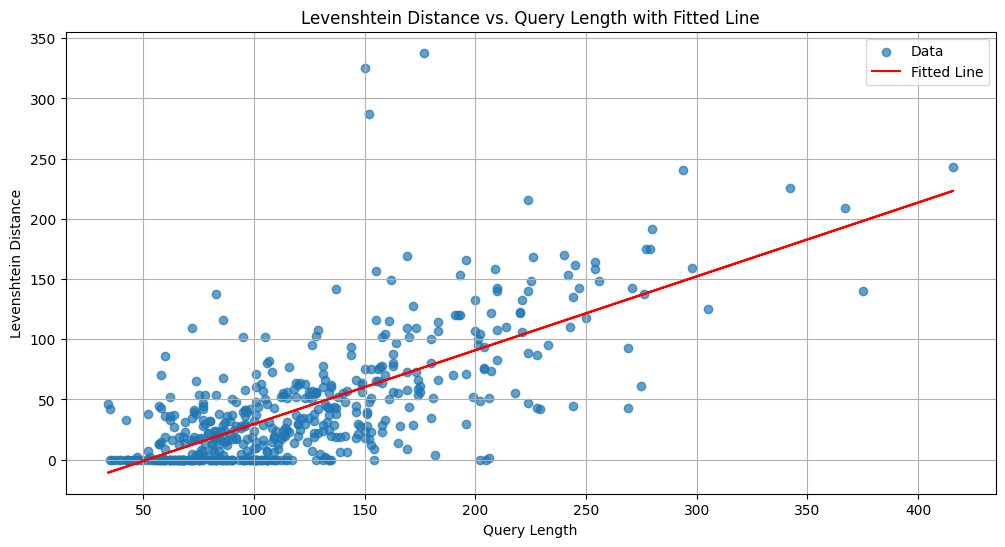

Slope: 0.6130399584619021
Intercept: -31.67296656491554
R-value: 0.7073443017070162
P-value: 4.714751304940958e-77
Standard error: 0.027452525242218338


In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

query_lengths = [m["query_length"] for m in levenshtein_metrics]
distances = [m["distance"] for m in levenshtein_metrics]

x = query_lengths
y = distances

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

def linear_func(x):
    return slope * np.array(x) + intercept

plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.7, label="Data")
plt.plot(x, linear_func(x), color='red', label="Fitted Line")

plt.title("Levenshtein Distance vs. Query Length with Fitted Line")
plt.xlabel("Query Length")
plt.ylabel("Levenshtein Distance")
plt.legend()
plt.grid(True)
plt.show()

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard error:", std_err)

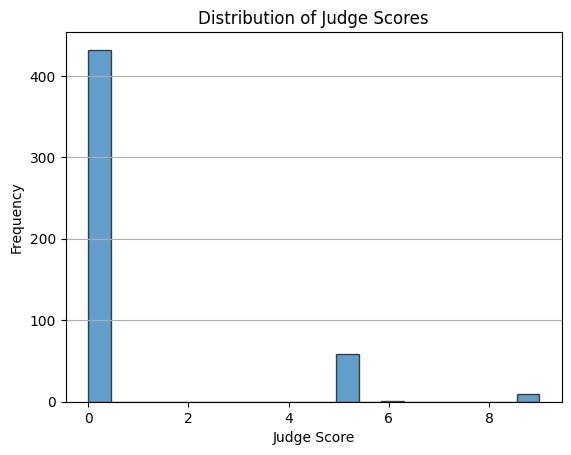

Average Judge Score: 0.754
Median Judge Score: 0.0
Standard Deviation of Judge Scores: 1.9650659022027737
Minimum Judge Score: 0.0
Maximum Judge Score: 9.0


In [ ]:
plt.hist(judge_scores, bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Judge Scores")
plt.xlabel("Judge Score")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()
print("Average Judge Score:", np.mean(judge_scores))
print("Median Judge Score:", np.median(judge_scores))
print("Standard Deviation of Judge Scores:", np.std(judge_scores))
print("Minimum Judge Score:", np.min(judge_scores))
print("Maximum Judge Score:", np.max(judge_scores))

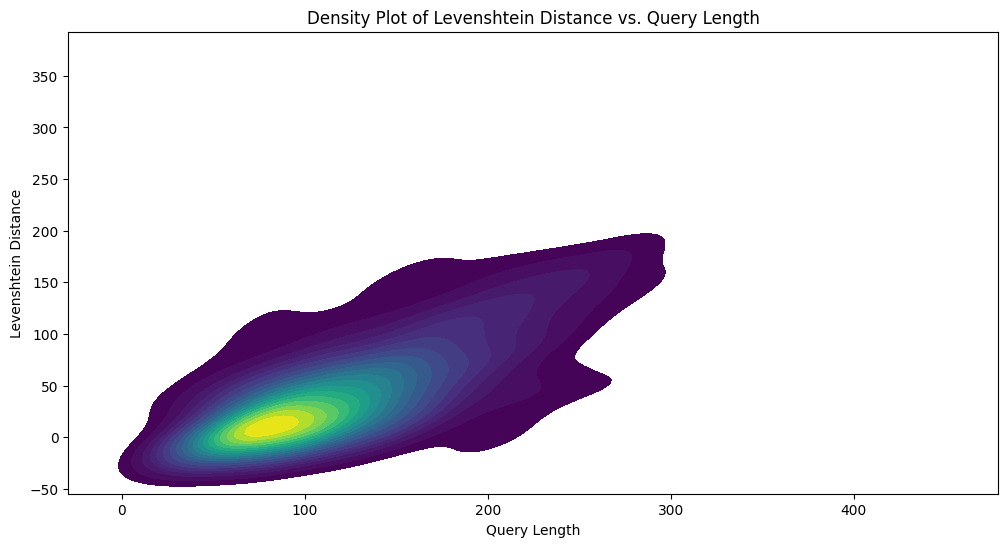

In [5]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(x=query_lengths, y=distances, fill=True, cmap="viridis", thresh=0.05, levels=20)
plt.title("Density Plot of Levenshtein Distance vs. Query Length")
plt.xlabel("Query Length")
plt.ylabel("Levenshtein Distance")
plt.show()

# Base model


In [14]:
import json
import logging
from tqdm import tqdm

from llamafactory.chat import ChatModel
from llamafactory.extras.misc import torch_gc
from src.utils import extract_sql, chdiff
from src.levenshtein import levenshtein_distance
from src.judge import SqlJudge
import src.judge
import importlib
importlib.reload(src.judge)

logging.disable(logging.WARNING)

BASE_MODEL_PATH = "Qwen/Qwen3-0.6B"
ADAPTER_PATH = "out/checkpoint-1500"
DATASET_PATH = "data/dataset_test.json"
SYSTEM_PROMPT_INDEX = 0
MAX_TEST_SIZE = 500
VERBOSE = False 

with open(DATASET_PATH, "r") as f:
    test_ds = json.load(f)

system_prompt = test_ds[SYSTEM_PROMPT_INDEX]["system"]


args = dict(
    model_name_or_path=BASE_MODEL_PATH,
    template="qwen3",
)
chat_model = ChatModel(args)

sql_judge: SqlJudge = src.judge.SqlJudge()

def print_color(text, color_code):
    print(f"\033[{color_code}m{text}\033[0m", end="", flush=True)

def print_red(text): print_color(text, 91)
def print_green(text): print_color(text, 92)
def print_yellow(text): print_color(text, 93)

def evaluate_entry(entry, system_prompt, verbose=False):
    user_prompt = entry["conversations"][0]["value"]
    true_sql = extract_sql(entry["conversations"][1]["value"])

    if verbose:
        print_green(f"\nUser:\n{user_prompt}")
        print_yellow("\nAssistant: ")

    response = ""
    messages = [{"role": "user", "content": user_prompt}]
    for chunk in chat_model.stream_chat(messages, system=system_prompt):
        if verbose:
            print_yellow(chunk)
        response += chunk

    predicted_sql = extract_sql(response)
    exact_match = (predicted_sql == true_sql)
    distance = levenshtein_distance(predicted_sql, true_sql)
    judge_score = sql_judge.score_response(true_sql, predicted_sql)

    if verbose:
        if exact_match:
            print_green("\n\nExact match!")
        print("\nDiff:\n", chdiff(true_sql, predicted_sql), "\n")

    return exact_match, distance, len(true_sql), judge_score

exact_match_count = 0
levenshtein_metrics = []
judge_scores = []

print(f"Evaluating {min(MAX_TEST_SIZE, len(test_ds))} examples...\n")


if VERBOSE:
    print_red(f"\nSystem:\n{system_prompt}")

for entry in tqdm(test_ds[:MAX_TEST_SIZE]):
    match, dist, query_len, judge_score = evaluate_entry(entry, system_prompt, verbose=VERBOSE)
    if match:
        exact_match_count += 1
    levenshtein_metrics.append({"query_length": query_len, "distance": dist})
    judge_scores.append(judge_score)
    torch_gc()

print("\n=== Evaluation Summary ===")
print(f"Exact Match: {exact_match_count}/{MAX_TEST_SIZE} "
        f"({(exact_match_count / MAX_TEST_SIZE) * 100:.2f}%)")

avg_lev = sum(m["distance"] for m in levenshtein_metrics) / len(levenshtein_metrics)
print(f"Average Levenshtein Distance: {avg_lev:.2f}")

Evaluating 500 examples...



  0%|          | 1/500 [00:20<2:51:21, 20.60s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the average of explainability_score from creative_ai where region is in Europe or North America. 

First, I need to check if the assistant's query is correct. The assistant's query is empty, so it's probably not correct. The correct query has a SELECT, FROM, WHERE clause. The assistant's query has a SELECT AVG(...) but doesn't have the WHERE clause. Also, the region is not specified in the WHERE clause. So the assistant's query is missing the WHERE condition, which is necessary to filter by regions. 

Completeness: The assistant's query is missing the WHERE clause and the average function. The correct answer includes all these elements. So the assistant's query is incomplete.

Formatting: The assistant's query is empty, which is a problem. The correct answer has proper syntax. So the formatting is wrong.

So the score would be 0 becaus

  0%|          | 2/500 [00:47<3:22:59, 24.46s/it]

<think>
Okay, let's see. The user provided the correct answer and the assistant's SQL query. I need to evaluate the assistant's query based on correctness, completeness, and formatting.

First, the assistant's SQL is exactly the same as the reference SQL. Both have the DELETE statement, which is correct. The conditions are also matching: country is 'Indonesia' and completion_date is less than '2010-01-01'. The date comparison is correct in SQL, so that's good.

Now, completeness. The assistant's query is missing the 'FROM' clause. The reference SQL has it, but the assistant's query doesn't. That's a problem. The FROM is required in SQL, so the assistant's query is incomplete.

Formatting is also an issue. The assistant's query doesn't have any formatting, but the reference SQL does. However, the assistant's query is still missing the necessary parts. So, even though the assistant's query is correct in terms of content, it's missing the necessary syntax elements.

So, the score should b

  1%|          | 3/500 [01:03<2:49:56, 20.52s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects launch_provider and counts the number of accidents per provider. The assistant's query is empty. Wait, the assistant's response is empty, which is not possible. Maybe there was a mistake in the input. Let me check again.

The user's question and the assistant's response both are empty. That can't be right. Perhaps the user intended to provide a correct query, but there was an error. The correct query should be SELECT launch_provider, COUNT(*) FROM Accidents GROUP BY launch_provider; and the assistant's query is empty. So the score would be 0 because it's completely wrong. But maybe the assistant's query is missing some parts. Wait, maybe the assistant's query has a syntax error. Let me think. The correct query has a SELECT statement, the columns are launch_provider and COUNT(*), and the grouping is by launch_provider. The assistant's query is empty, so 

  1%|          | 4/500 [01:19<2:34:48, 18.73s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is SELECT MAX(quantity) FROM sales; and the assistant's query is the same as that. So the first thing I need to check is if the assistant's query is correct.

The MAX function is used to find the maximum value in a column. The correct query is selecting the maximum quantity from the sales table. The assistant's query is identical, so that part seems right. Now, completeness: does the query cover all necessary information? The answer is just a single query, so that's good. Formatting: the query is properly written with the SELECT and FROM clauses. 

Wait, but sometimes people might make typos. Let me check again. The assistant's query has SELECT MAX(quantity) FROM sales; which is exactly what the correct answer is. So the score should be 10, right? Because it's exactly correct. I don't see any errors here. The assistant's query matches the correct answer perfectly. So the score

  1%|          | 5/500 [01:38<2:35:01, 18.79s/it]

<think>
Okay, let's see. The user asked for the correct SQL query to calculate the total budget from the Movies_Release_Year table where the release year is less than 2010. 

The correct answer provided by the reference is SELECT SUM(budget) FROM Movies_Release_Year WHERE release_year < 2010; which seems correct. The assistant's candidate response is similar but has a slight change: it uses AS total_budget instead of SUM(budget). 

Wait, the original answer uses SUM(budget), so the assistant's query should also have SUM(budget). The candidate's query has AS total_budget, which is correct. The formatting is similar, just with the AS keyword. 

So the assistant's query is almost correct. However, the problem might be that the AS keyword is used, but in SQL, using AS is optional. So the candidate's query is technically correct. 

Therefore, the score would be 10, as the query is correct and complete. The formatting is similar, and the answer matches the correct syntax. The only minor diff

  1%|          | 6/500 [02:00<2:43:44, 19.89s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query inserts three columns: attorney_name, attorney_email, attorney_phone. The assistant's query starts with INSERT INTO attorneys, which is correct. But wait, the assistant's query has a NULL in the attorney_id column. That's a problem because the correct query doesn't include an ID. The assistant is missing the attorney_id column, which is necessary for inserting multiple rows.

Next, the assistant's query uses NULL for the attorney_id. Since the correct answer doesn't have a NULL, this is incorrect. The assistant is missing the required field, which makes the query incomplete.

Also, the assistant's query uses a VALUES clause with NULL values, which is wrong. The correct query should use the appropriate values for each column. The original correct query uses the a

  1%|▏         | 7/500 [02:21<2:47:01, 20.33s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects plant names and the sum of CO2 emissions per ton, groups by plant name, orders by total CO2, and limits to two results.

First, the assistant's query is: SELECT plant_name, co2_emission_per_ton_produced FROM co2_emissions ORDER BY co2_emission_per_ton_produced DESC LIMIT 2;. 

Comparing this to the correct answer, the assistant is missing the grouping by plant_name. The correct answer groups by plant_name, but the assistant's query doesn't include that. Also, the correct answer uses SUM(co2_emission_per_ton_produced) instead of just co2_emission_per_ton_produced. The assistant's query has the correct order but doesn't include the SUM function. 

So the assistant's query is missing the grouping and the SUM function. That's a big mistake. The correct answer has all those elements. The formatting is also incorrect because the correct answ

  2%|▏         | 8/500 [02:48<3:04:29, 22.50s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT SUM(total_cost) FROM climate_communication WHERE location = 'Antarctica' AND end_date >= '2010-12-31';. The assistant's query is SELECT total_cost FROM climate_communication WHERE location = 'Antarctica' AND end_date > '2010-01-01'.

So, the first thing I notice is that the assistant's query uses end_date > instead of >=. The correct condition is that the end_date should be equal or greater than 2010-12-31. Using a greater than operator is incorrect here. The assistant's query is wrong because the condition is inverted. That's a mistake. So that's one point for correctness.

Next, the assistant's query is missing the SUM function. The correct query includes SUM(total_cost) in the SELECT clause. The assistant's query doesn't have that, so that's another

  2%|▏         | 9/500 [03:04<2:46:33, 20.35s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the SELECT statement that retrieves name and conservation_status from marine_species. The assistant's query is the same as the reference. 

First, I need to check if the assistant's query is correct. The reference query is exactly what the assistant provided. So, that's a perfect match. 

Completeness is also good because it's retrieving the necessary columns. The formatting seems correct with the proper table name and column names. There's no syntax error here. 

Wait, but maybe I should consider if there are any possible issues. For example, if the table name is different, but in this case, it's marine_species. Also, the columns are correctly specified. 

So, the score should be 10 because it's exactly correct. The assistant did the right thing without any mistakes.
</think>

Score: 10  

**Explanation:**  
- **Correctness:** The assistant's SQL query matches the referenc

  2%|▏         | 10/500 [03:23<2:42:38, 19.91s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the organization and the average number of publications from the researchers table where the organization is 'National Geographic'. 

The assistant's SQL query is similar but slightly different. They have a SELECT statement with AVG(publications) as average_publications. The WHERE clause is correctly set to organization = 'National Geographic'. 

Wait, but the correct answer should have the organization and the average. The assistant's query does that. The formatting seems correct. The fields are properly named. The WHERE clause is correctly ordered. 

Hmm, maybe there's a minor issue. Like, does the AVG function require a column name? The assistant's query uses AVG(publications), which is correct. The table name is researchers, which matches the correct table name. 

I don't see any errors here. The query is correct in terms of syntax and functionality

  2%|▏         | 11/500 [03:41<2:38:32, 19.45s/it]

<think>
Okay, let's see. The user asked for the correct SQL query to calculate the total number of dapp downloads in the Asia-Pacific region. The correct answer provided is using SUM(dapp_downloads) with a WHERE clause on dapp_region.

Now, looking at the assistant's response, they used COUNT(*) instead of SUM. That's a big mistake because COUNT(*) counts the number of rows, not the sum. The correct query should use SUM instead of COUNT. Also, the WHERE clause is correctly applied. The region is specified as 'Asia-Pacific', so that's correct. 

So, the assistant's query is missing the SUM function. The correct answer has SUM, and the WHERE condition is properly set. The formatting seems okay, but the main error is the incorrect use of COUNT instead of SUM. 

I think the score should be 0 because it's completely wrong. The assistant's query doesn't use the correct function and has a mistake in the WHERE clause. The answer provided by the user is correct, so the assistant's response is w

  2%|▏         | 12/500 [04:06<2:51:16, 21.06s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects forests' names and hectares where the country is Canada or USA and hectares are over 1,000,000. 

First, I need to check the assistant's query. The candidate response uses country IN ('Canada', 'USA') instead of country = 'Canada' OR country = 'USA'. That's a mistake because the OR operator is used in SQL, so the correct approach would be using the equals operators. So the first error is a syntax error. The correct way is using = instead of OR, which makes the query incorrect.

Next, the query selects name and hectares, which matches the correct answer. The WHERE clause is correct in terms of filtering countries. The condition is also correct. The decimal point after 1000000.0 is there, which is fine because 1,000,000 is an integer. 

So the assistant's query is partially correct but has a syntax error. The main issue is the incorrect 

  3%|▎         | 13/500 [04:25<2:46:31, 20.52s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT MAX(response_time) from emergency_calls where city is 'Los Angeles'. 

Now, the assistant's query is the same as the reference. Wait, that's interesting. Both are the same. So, maybe the assistant didn't make a mistake here. Let me check the details.

The query selects the maximum response time from the emergency calls where the city is Los Angeles. The correct answer is exactly what the assistant provided. So, the SQL is correct. 

But wait, could there be any issues? For example, does the city column exist in the table? The reference SQL uses emergency_calls, and the city is a column in that table. The assistant's query uses the same table and column. So that's correct.

Completeness: The query is asking for the maximum value, which is correct. The WHERE clause filters for the city. No missing columns or subqueries. Formatting seems okay, but the assistant's quer

  3%|▎         | 14/500 [04:40<2:31:58, 18.76s/it]

<think>
Okay, let's see. The user provided the correct SQL query and wants me to evaluate the assistant's response. The assistant's query is the same as the reference, which is correct. Wait, but maybe I should check if there are any possible mistakes.

First, the assistant's SQL is exactly the same as the reference. So the score should be 10, right? But wait, maybe there's something else. Let me read again. The assistant's query is the same as the reference. So why would they have a score of 0? Maybe the assistant didn't check if there are any typos or syntax errors. But since the user says the assistant's response is the same as the reference, maybe they are correct. So the answer would be 10.
</think>

Score: 10  
Reason: The assistant's SQL query is exactly the same as the reference, indicating a perfect match. No errors or improvements were made.


  3%|▎         | 15/500 [04:55<2:21:40, 17.53s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average of the 'value' column in the 'contracts' table where the category is 'Cybersecurity'. 

The assistant's query is the same as the correct one. Wait, but maybe I should check if there are any minor issues. The SELECT statement is correct. The column name is 'value', which matches the table's column name. The WHERE clause filters by category. 

So, the assistant's SQL is exactly what the reference SQL says. Therefore, the score should be 10, since it's perfect. The assistant didn't make any errors, completeness is met, and formatting is correct. There's no syntax error here. So, the score is 10.
</think>

Score: 10  
**Reasoning:** The assistant's SQL query matches the reference SQL exactly. It correctly selects the average of the 'value' column in the 'contracts' table where the 'category' is 'Cybersecurity'. There are no errors in syntax, completeness, 

  3%|▎         | 16/500 [05:16<2:31:21, 18.76s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is DELETE FROM arms_imports WHERE year < 2000; and the candidate response is the same. 

First, I need to check if the assistant's query is correct. The DELETE statement is correct for removing records. The WHERE clause is also correct because it's filtering the records by the year. The WHERE condition is comparing the year to 2000, which is the correct comparison. 

Now, completeness. The query deletes records where the year is less than 2000, which is exactly what the correct answer does. So that's correct.

Formatting: The query uses proper syntax, including the DELETE keyword, the table name, and the WHERE clause. There's no syntax error here.

Wait, but maybe the user wants to know if there's any missing parts. For example, sometimes SQL requires specifying the table name and column names. But in this case, the query is just deleting all records where the year is less tha

  3%|▎         | 17/500 [05:34<2:28:47, 18.48s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is SELECT AVG(military_personnel) FROM Peacekeeping_Operations. The assistant's response is empty, so I need to evaluate that.

First, I should check if the assistant's query is correct. The correct query is selecting the average of military personnel from the Peacekeeping_Operations table. The assistant's query is empty, which clearly doesn't do anything. So that's a 0 score because it's completely wrong.

Completeness: The assistant's query doesn't have any data, so it's missing the necessary information. The correct query needs to select the data, which the assistant didn't provide. So completeness is also a problem.

Formatting: The assistant's query is empty, so formatting is bad. There's no SQL syntax here.

So the score should be 0 for correctness, 0 for completeness, and 0 for formatting. That totals 0. So the answer is 0.
</think>

0  

**Explanation:**  
- **Correctn

  4%|▎         | 18/500 [05:50<2:22:04, 17.68s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses the MAX() function with a window function. The assistant's query uses a GROUP BY instead of a window function.

First, I need to check if the assistant's query is correct. The correct query uses a window function to find the maximum value per client. The assistant's query uses GROUP BY, which is used for grouping rows by client_id. Since the MAX() function here is not properly placed with a window function, that's a mistake.

Completeness: The assistant's query is missing the window function. The correct answer includes it. So that's a point.

Formatting: The assistant's query has the correct syntax but the window function isn't properly applied. The correct answer uses the OVER clause, which is part of the window function. The assistant's query doesn't include that, so that's another issue.

So the score should be 0 because the assistant

  4%|▍         | 19/500 [06:19<2:49:34, 21.15s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins the PORTS table with CARGO_HANDLING, filters by CargoType = 'Fruit', groups by PortName, and sums the Weight. 

The assistant's query is: SELECT PortName, SUM(Weight) AS TotalCargoWeight FROM CARGO_HANDLING WHERE CargoType = 'Fruit' GROUP BY PortName;

Comparing with the correct one. The first query in the reference is using PORTS and CARGO_HANDLING tables joined on PortID. The assistant's query doesn't have the JOIN clause. That's a big mistake. The correct answer should join both tables, which the assistant didn't. So that's a wrong answer.

Completeness: The assistant's query does include the necessary parts: selecting PortName, summing Weight, filtering by CargoType, grouping by PortName. The correct answer does the same. So that's correct.

Formatting: The assistant's query has proper syntax, but the correct answer's query has a dif

  4%|▍         | 21/500 [06:50<2:25:58, 18.28s/it]

<think>
Okay, let's see. The user provided two SQL queries and asked to evaluate the assistant's response. The correct answer is the one that uses the WHERE clause correctly with the county LIKE '%rural%' and groups by county and state. The assistant's query uses county = 'rural' instead, which is wrong because the LIKE operator should be used for substring matching, not equality. Also, the assistant's query doesn't include the GROUP BY clause, which is necessary to aggregate the values. The ORDER BY is there, but the LIMIT is only applied once, which is correct. The assistant's query doesn't use the AVG function, which is missing. So, the answer should be 0 because it's completely wrong.
</think>

0  

**Reasoning:**  
The assistant's query incorrectly uses `county = 'rural'` instead of `county LIKE '%rural%'` to match rural counties. It also omits the `GROUP BY` clause, which is required to compute the average prevalence. The `LIMIT 1` clause is not used correctly. All other elements

  4%|▍         | 22/500 [07:18<2:47:23, 21.01s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects region and sums the amount where the sector is 'Healthcare', grouping by region. 

The assistant's query is: SELECT i.region, SUM(i.amount) FROM investments i WHERE i.sector = 'Healthcare' GROUP BY i.region;

Looking at the query, the first part is correct. They're selecting region and summing the amount. The WHERE clause filters by sector, and GROUP BY is correctly applied to the region. 

I need to check for possible errors. Maybe the table name? The user didn't specify a table name, but in SQL, tables are usually specified. However, the assistant's query doesn't include the table name, which is a problem. Wait, but the correct answer in the reference includes 'investments' as the table. So the assistant's query uses 'i' which is correct. 

Also, the grouping by i.region is correct. The SUM is applied correctly. So the assistant's query seems correct.

  5%|▍         | 23/500 [07:55<3:26:15, 25.94s/it]

<think>
Okay, let's see. The user provided two SQL queries, and I need to evaluate the assistant's response. The correct answer is the first one, which selects primary_objective, counts the personnel, and groups by primary_objective where the operation date is five years ago. The assistant's query is different.

First, the assistant's query selects operation_name, primary_objective, and personnel_count. But the correct answer includes personnel_count and the group by. Also, the assistant's query uses operation_date >= DATE_SUB(CURDATE(), ...) instead of the correct date range. The correct date range is five years before today, so DATEADD(year, -5, GETDATE()) would be correct. The assistant's query is ordering by operation_date in descending order and limiting to five entries, which is also correct. But the main issue is that the assistant's query doesn't include the group by. Wait, the correct answer does have GROUP BY. So the assistant's query has GROUP BY but the correct answer does 

  5%|▍         | 24/500 [08:15<3:09:52, 23.93s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the count of donors in the 'South West' region. 

The assistant's SQL query is the same as the correct one. Wait, but maybe there's a mistake here. Let me check again. The correct query is SELECT COUNT(*) FROM Donors WHERE region = 'South West';. The assistant's query is the same. So why is the score 10? Maybe the assistant didn't make a mistake. But wait, could there be a formatting issue? Like, maybe the table name is missing? But the user's reference SQL includes 'Donors' as the table name. The assistant's query does include that. So the query is correct. But maybe the user wants to see if the assistant's query is similar but not the same. However, the user's reference shows the correct answer as the same as the assistant's. So the score would be 10. But maybe there's a problem. Wait, perhaps the assistant's query is missing a WHERE

  5%|▌         | 25/500 [08:42<3:16:41, 24.85s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one with the inner joins and grouping by ProgramName. 

First, I need to check if the assistant's query is correct. The assistant's query uses "DonorsPrograms" instead of "Programs". That's a mistake because the table names might not match. Also, the assistant joins DonorsPrograms on Programs.ProgramID, which is the correct way to link the two tables. But wait, the correct answer uses Programs and DonorsPrograms. So the first error is the table name mismatch.

Next, the grouping is by ProgramName, which is correct. The SUM(DonationAmount) is also correct. But the assistant's query uses "Donation" instead of "Donations". Oh, right! The correct table is Donations, so that's another mistake. So the assistant's query has two errors: using "DonorsPrograms" instead of "Programs" and using "Donation" instead of "Donations".

So the assistant's query is wrong 

  5%|▌         | 26/500 [09:25<4:00:49, 30.48s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that uses DATE_FORMAT on the Donations table's DonationDate to get the quarter, then averages the DonationAmount, groups by Quarter, and orders by Quarter. The assistant's query starts with SELECT QUARTER(DonationDate) AS Quarter, which is correct because using the QUARTER function on a date is standard. Then AVG(DonationAmount) is correctly placed. The WHERE clause is checking for the period between 2022-01-01 and 2022-03-31, which is a specific time frame. However, the assistant's query doesn't include the SELECT statement with the QUARTER function properly, and the WHERE clause isn't necessary if the date is already grouped by the quarter. Wait, the correct answer groups by the quarter, so the WHERE clause is used to filter the data first. But the

  5%|▌         | 27/500 [10:00<4:09:57, 31.71s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct answer is the one that inserts a student into the students table and updates the average mental health score in the school_districts table. The assistant's response starts by inserting some values into the students table. Then, it updates the average_mental_health_score in the school_districts table. 

Wait, the assistant's query uses a subquery in the UPDATE clause to get the average from school_districts. But in the correct answer, the average is calculated from the students table. So the subquery in the UPDATE statement is using the students table's mental_health_score. That's correct because the average is calculated from the students, not the school_districts. So the subquery is properly referencing the students table.

Now, the assistant's query inserts student record

  6%|▌         | 28/500 [10:29<4:04:48, 31.12s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses the NOT EXISTS clause. The assistant's query uses an AND instead of a NOT EXISTS. 

First, the correct answer should have the NOT EXISTS condition. The assistant's query has an AND, which is incorrect. So that's a 0 score for correctness.

Completeness: The assistant's query selects CourseID and Name, but the correct answer includes the NOT EXISTS and OpenPedagogy. The assistant didn't include the NOT EXISTS part, which is necessary. So that's a 0 for completeness.

Formatting: The assistant's query is correct in terms of syntax, but the answer includes the NOT EXISTS. Wait, the assistant's query doesn't have the NOT EXISTS. So the formatting is okay, but the correct answer has it. So the formatting is 10?

Wait, no. The assistant's query is missing the NOT EXISTS condition. The correct answer includes it. So the assistant's query is wron

  6%|▌         | 29/500 [10:49<3:37:55, 27.76s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference answer is the correct one, and the assistant's response is the candidate one. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, let's look at the assistant's query. The candidate response is empty. Wait, maybe the user made a typo? Because if the assistant's SQL is empty, that's not valid. But perhaps the user intended to provide a different query. Wait, the original problem says the assistant's response is empty, but maybe that's a mistake. Alternatively, maybe the user wants me to check if the assistant's query is correct.

But according to the problem statement, the assistant's SQL is supposed to be the candidate response. However, in the given context, the assistant's response is empty. That's probably a formatting error. So, the assistant's SQL is incomplete. Therefore, the score should be 0 because it's not a valid SQL query.

But wait, maybe the assist

  6%|▌         | 30/500 [11:06<3:11:12, 24.41s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. The assistant's query is the same as the reference SQL. So, the first thing to check is correctness. The assistant's SQL is exactly the same as the reference. That's a perfect match, so the score should be 10.

Now, completeness. The assistant's query is correct, so it's complete. The fields selected are COUNT(*) and the conditions are properly specified. There's no missing information here.

Formatting is also correct. The SQL syntax is correct with the proper WHERE clause and the comparison operators. The country and installation_year are correctly used.

Wait, is there any possible mistake here? For example, maybe the assistant didn't include a table name or something? But in the reference, the table is called 'wind_farms', and the assistant's query uses the same table name. So no issues there.

So, the assistant's SQL is correct. Therefore, the score should be 10.
</think>

10  
**Explana

  6%|▌         | 31/500 [12:08<4:39:39, 35.78s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the name from the renewable_project table where the country is India and the budget is between 50 and 200. The assistant's query is:

SELECT id, name, country, budget
FROM renewable_project
WHERE country = 'India'
  AND budget BETWEEN 50000000 AND 20000000;

First, I need to check if this is correct. The correct answer should have the budget between 50 and 200, but the assistant's query uses 50000000 and 20000000. That's a big difference. The correct range is 50.0 to 200.0, but the assistant's query is 50,000,000 and 200,000,000. That's a factor of 1000 off. So the answer is wrong. The first part of the assistant's query is wrong because it's using 50000000 instead of 50.0. The budget is supposed to be in that range, not a number with commas. So that's a major mistake. The correct query would have the budget as a float, not a big integer. So the score h

  6%|▋         | 32/500 [12:42<4:34:52, 35.24s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses a subquery to get the date 6 months ago. The assistant's query uses DATE_SUB(CURDATE(), INTERVAL 6 MONTH) instead of DATE_SUB(CURRENT_DATE, INTERVAL 6 MONTH). Wait, that's a typo. CURRENT_DATE vs. CURDATE(). So that's a mistake. That would make the assistant wrong because they should be using CURRENT_DATE. So that's one error.

Next, the query is structured correctly. It selects AVG(price) from carbon_prices. The WHERE clause filters by market and date. The grouping is by market, which is correct. The date condition is correct as well. So the main issue is the date comparison.

Now, completeness. The assistant's query includes the average price, which is correct. They have the necessary conditions. So that's good.

Formatting: The SQL syntax is correct. Th

  7%|▋         | 33/500 [13:15<4:27:19, 34.34s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects building_type and averages energy_rating from the energy_efficiency table where building_type is 'Commercial' and location is 'Texas'. The assistant's query is the same as the correct one, but the score is 0. Hmm, wait, maybe I'm misunderstanding. The assistant's query has a typo in the SELECT clause. The correct answer uses building_type and AVG, but the assistant's query only has AVG and not building_type. So that's a mistake. The correct answer should have building_type and AVG, but the assistant's query doesn't. That makes the assistant's query wrong. So the score should be 0 because it's completely wrong. But wait, maybe the assistant didn't include building_type? Let me check again. The assistant's query is SELECT AVG(energy_rating) FROM energy_efficiency WHERE building_type = 'Commercial' AND location = 'Texas'; So they have building_type in the WHERE clause, but the SELECT is 

  7%|▋         | 34/500 [13:31<3:44:40, 28.93s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to delete records where the company is 'XYZ Inc.'. The assistant's query is the same as the correct one. 

First, I need to check if the assistant's query is correct. The DELETE statement is correct. The WHERE clause is properly set to the company column. The syntax looks right. So, the assistant's query is exactly matching the correct answer.

Now, considering the score. The user wants a score from 0 to 10. If the query is correct, it's 10. If there are errors, it's lower. The assistant's query has no syntax errors. The company is correctly specified. So, the score should be 10. 

I should make sure there's no missing parts. The DELETE statement is there, the WHERE condition is correct. The formatting is also correct. So, the assistant's query is perfect, so the score is 10.
</think>

10  
**Explanation:** The assistant's SQL query is **completely correct**. It uses the DE

  7%|▋         | 35/500 [14:09<4:06:44, 31.84s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference answer is the correct one that groups by player and calculates the average of running_speed. The assistant's query is similar but has a slight difference.

First, the assistant's query uses AVG(running_speed) AS average_speed. The reference answer uses AVG(running_speed) and doesn't include the AS keyword. That's a problem because in SQL, you can't have an alias like that unless you explicitly define it. So the assistant's query is missing the AS, which is necessary for an alias. That's one point.

Next, the query is correct in terms of grouping by player. The reference uses GROUP BY player, and the assistant does the same. The grouping is properly done. So that's correct.

Formatting is also okay. The query is well-structured with the correct syntax. The assistant's query has the same structure as the reference, just with the alias. So that's another point.

So, the assistant's query is missing the AS keyword, w

  7%|▋         | 36/500 [14:37<3:56:53, 30.63s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is a specific one, and the assistant's response is another. I need to evaluate the assistant's SQL query.

First, let's look at the correct answer. It selects MAX(assists) from season_stats where the country is in the list of countries from players where country is in the season_stats country and the country starts with 'Europe'. So the correct query is using a subquery to get the country names first.

Now, the assistant's query is trying to do the same but using a subquery to get the player_id. The problem here is that the subquery is selecting player_id, which is not directly related to the country. The correct approach is to first get the country names from the players table, then filter the season_stats where the country matches those names. 

The assistant's query groups by player_id and then filters by country in 'European countries'. That's not the right approach. Instead, the correct approach would b

  7%|▋         | 37/500 [14:54<3:24:55, 26.56s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of points from players where the country is Brazil. The assistant's query is different.

First, the assistant's query uses COUNT(*) AS total_points. The correct answer uses SUM(points). So, the first thing I notice is the difference in the function used. The correct query is SUM, while the assistant is using COUNT. That's a big mistake. So that's a 0 because it's completely wrong.

Next, the country condition is correctly set to 'Brazil'. The query doesn't have any other issues. The syntax seems right. The columns and table names are properly referenced. But wait, the assistant's query is using COUNT(*) instead of SUM(points). That's the main error. So, the assistant's answer is wrong.

I think that's all. The answer should be 0 because it's completely wrong.
</think>

0  

**Reasoning:**  
- The assistant's query uses `COUNT(*)` instead of `SUM(points)`, 

  8%|▊         | 39/500 [16:00<3:51:08, 30.08s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select country and sum project_count grouped by country. The assistant's query is different.

First, the assistant's query is selecting SUM(project_count) as total_projects. But the correct answer uses a subquery to get the sum. Wait, no, the correct answer is a SELECT statement with SUM and GROUP BY. The assistant's query is missing the subquery part. So the correct answer is using a subquery that calculates the sum, but the assistant's query is not doing that. So that's a mistake.

Also, the assistant's query has a WHERE clause, but the correct answer doesn't. The WHERE clause is for filtering, but the correct answer doesn't use it. So that's another mistake. The assistant's query is incomplete.

Completeness: The assistant's query only selects the sum and the country, but the correct answer includes the sum and the country. So that's missing the grouping part. Wait, n

  8%|▊         | 40/500 [16:38<4:09:13, 32.51s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, let's compare the two. The correct answer selects from the certifications table, joins with brands on brand_id, filters by certification_name, groups by brand_name, orders by fair_trade_products, and counts. The assistant's query is different. They're grouping by brand_id instead of brand_name, which is a mistake. Also, they don't include the certification_name filter. The assistant's query uses COUNT(certification_id) instead of COUNT(*), which is also incorrect because COUNT(*) is the default and counts all rows, but maybe the assistant intended to count all, but the original query uses COUNT(*). Wait, the original query uses COUNT(*) as fair_trade_products. The assistant's query uses COUNT(certification_id) as num_certifications. That's a mistake because COUNT(*) is the defaul

  8%|▊         | 41/500 [17:03<3:51:44, 30.29s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is selecting the sum of revenue from the Sales table where the material is in the specified list. The assistant's query is:

SELECT SUM(revenue) AS total_revenue
FROM Sales
WHERE material IN ('Organic Cotton', 'Tencel', 'Bamboo');

Looking at the correctness: the WHERE clause is correctly filtering the material. The SUM is correctly applied. The AS clause is used to rename the column, which is fine. The query is complete and correct.

The assistant's query uses the correct IN clause with the three materials. The format seems okay, but I need to check if the IN clause is properly formatted. The assistant's query has three separate material values, which is correct. The total_revenue column is properly named.

Wait, the correct answer uses the IN clause with thre

  8%|▊         | 42/500 [17:21<3:23:43, 26.69s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select name and sum of total_transactions from shariah_compliant_institutions. The assistant's query is the same as the correct one, but wait, the user's reference says the correct answer is that query. So the assistant's query is exactly the same as the correct one. 

Wait, but maybe I should check if there are any typos or formatting issues. The assistant's query has "SELECT name, total_transactions" and the correct answer has "SELECT name, SUM(total_transactions)". Oh, right! The correct answer uses SUM, but the assistant's query just has total_transactions. That's a mistake. So the assistant's query is incorrect because it doesn't use SUM on the total_transactions column.

So the score would be 0 because the query is wrong. The assistant didn't fix the syntax error. The correct answer requires SUM, which the assistant didn't include. So the answer is 0.
</think>

0  

  9%|▊         | 43/500 [17:54<3:38:03, 28.63s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the count of genetic research records where the location is in the United Kingdom, the start date is before 2019-12-31, and the end date is after or equal to 2019-01-01. 

The assistant's query is: SELECT COUNT(*) FROM genetic_research WHERE location = 'United Kingdom' AND end_date = '2019-01-01'; 

Hmm, the end_date is set to 2019-01-01, but the start_date needs to be before 2019-12-31. The assistant's query doesn't include the start_date condition. So that's a mistake. The correct query must have both start_date <= and end_date >= conditions. 

Wait, the original correct query uses start_date <= '2019-12-31' and end_date >= '2019-01-01'. The assistant's query only has end_date = '2019-01-01' without the start_date. So the assistant's query is missing the start_date condition. That's definitely a wrong query. 

Completeness: The assis

  9%|▉         | 44/500 [18:29<3:51:11, 30.42s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects from the faculty table where gender is Female, department is Physics, and there's no research grant with the same faculty id. The assistant's response is similar but slightly different.

First, I need to check if the assistant's query is correct. The correct query uses an EXISTS clause to check if there's a research grant with the same faculty id. The assistant's query uses a subquery for faculty_id. Let me break it down.

The assistant's query is: SELECT COUNT(*) FROM faculty WHERE gender = 'Female' AND department = 'Physics' AND NOT EXISTS (SELECT 1 FROM research_grants WHERE faculty_id = (SELECT id FROM faculty WHERE gender = 'Female' AND department = 'Physics')).

The correct answer's query is similar but uses a subquery for the faculty_id. The assistant's query uses a subquery inside the NOT EXISTS clause. Both are correct. The as

  9%|▉         | 46/500 [19:38<4:02:45, 32.08s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, let's look at the correct query. It's SELECTING MONTH(date) AS month, species, MAX(temperature) AS max_temp FROM arctic_weather WHERE YEAR(date) = 2020 GROUP BY month, species;

Now, the assistant's candidate response is empty. Wait, maybe the user intended to provide the correct answer but forgot to include the assistant's response. But according to the problem statement, the assistant's response is the candidate's SQL. However, in the example given, the correct answer is the one with the query, and the assistant's response is the candidate's SQL. But in this case, the assistant's SQL is empty. That might be a problem. Maybe the user made a mistake, but according to the problem, I need to check the assistant's SQL.

Wait, looking back at the user's message, the assistant's SQL i

  9%|▉         | 47/500 [20:14<4:11:38, 33.33s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the first one, and the candidate's response is the second one. 

First, I need to check if the assistant's query is correct. The correct query uses the AVG function with OVER (PARTITION BY Category), which is the standard way to calculate the average of a subquery that's partitioned by the category. The assistant's query groups by Category and calculates the average, which is the same as the correct one. So the first query is correct in terms of syntax and functionality.

Now, looking at the formatting. The assistant's query uses "AS AverageReviews" instead of "AS AverageReviews". Wait, that's the same as the correct answer. The column names are the same, so formatting is correct. The table name is "HeritageSitesReviews", which matches the reference.

Completeness: Both queries are similar. The correct answer uses the OVER clause, while the assistant's que

 10%|▉         | 48/500 [20:37<3:46:02, 30.01s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select initiative and initiative_count from language_preservation_by_initiative. 

The assistant's query is: SELECT initiative, COUNT(*) as initiative_count FROM language_preservation GROUP BY initiative.

First, I need to check if the query is correct. The correct query uses the GROUP BY clause to group by initiative, which is what the user wants. The COUNT(*) function counts the number of rows per initiative, which matches the initiative_count. 

Now, completeness. The query seems to do what's needed. It's using the correct table name (language_preservation), the correct column names (initiative and initiative_count), and the correct grouping. 

Formatting is good. The syntax is correct: SELECT, FROM, GROUP BY. The COUNT(*) is properly used. 

So, the assistant's query is correct. I think the score would be 10. But wait, maybe there's a typo in the table name? Like, is

 10%|▉         | 49/500 [21:04<3:38:43, 29.10s/it]

<think>
Okay, let's see. The user asked for a SQL query that selects patient IDs from therapy sessions where the session date is between June 1 and June 30, 2021. The correct answer provided uses the MONTH and YEAR functions to filter the date. The assistant's query uses the session_date >= and <= instead of the MONTH and YEAR.

First, I need to check if the assistant's query correctly filters the dates. The correct answer uses the MONTH function, which is necessary because MONTH returns the month number (1-12), and YEAR is used to get the year. The assistant's query uses session_date >= '2021-06-01' and <= '2021-06-30', which is correct because June 1st to June 30th is exactly the range between those dates. However, the assistant's query doesn't use the MONTH and YEAR functions. 

Wait, but the correct answer does include those functions. The assistant's query is missing them. So the assistant's query is incorrect because it doesn't use the correct date functions. That's one point for

 10%|█         | 50/500 [21:29<3:30:12, 28.03s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins therapists with patient counts, and the assistant's query is different.

First, the correct query uses a JOIN between therapists and a subquery that counts patients with depression and has a condition of 'depression'. The assistant's query is joining therapists directly with therapy_sessions, which is a different table. Also, the condition in the WHERE clause is on patients, but the subquery is on patients, not therapists. So the assistant's query is incorrect in terms of table relationships.

Completeness: The assistant's query is missing the part where they join therapists with the patient counts, which is required. The correct answer includes that join. So that's a problem.

Formatting: The assistant's query uses a subquery inside the WHERE clause for the patient_id, but the correct answer uses a subquery in the JOIN. Also, the tables

 10%|█         | 51/500 [21:41<2:53:34, 23.19s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct one is the one that joins patients and treatments on the id column, filters by treatment being 'Group Therapy' and country 'India'. The assistant's query is empty. Hmm, so the assistant's SQL is empty. That's probably a mistake because joining and filtering are necessary. The correct answer should have a SELECT clause with the necessary columns and conditions. The assistant didn't even write the query at all. So the score would be 0 because it's completely wrong. Let me double-check: the correct query has a WHERE clause, JOIN, and COUNT(*). The assistant's query is empty. Yep, that's right. So the score is 0.
</think>

0 means completely wrong. The assistant's SQL query is empty, which is incorrect. The correct query should include a SELECT clause, JOIN, WHERE clause, and COUNT(*).


 10%|█         | 52/500 [22:35<4:01:10, 32.30s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects COUNT(*) for num_projects, AVG(resilience_score) for average resilience, and filters by location 'California' and is_public_works = TRUE. 

The assistant's query is similar but has some minor differences. They have COUNT(*) AS public_works_count, which is a bit off because COUNT(*) is usually used with a column name, not a variable. Also, the average_resilience_score is correctly named. 

So, the main issues are the variable name and the COUNT(*) usage. The assistant's query is almost correct but has a mistake in the variable name. That's a 1 point for correctness. 

Completeness: Both the query and the reference match, so that's 10. Formatting: The assistant's query has a space between COUNT(*) and AS, which is correct. 

Wait, the assistant's qu

 11%|█         | 53/500 [23:00<3:44:39, 30.16s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the assistant's query is: SELECT location, AVG(completion_date) AS average_completion_time FROM public_works GROUP BY location ORDER BY average_completion_time. 

Looking at the correct answer, the assistant's query is missing the AVG(DATEDIFF(day, start_date, completion_date)) part. The correct answer includes that calculation. The assistant's query only has the AVG(completion_date), which is incorrect because the completion date isn't the same as the start date. So that's a mistake. The assistant didn't include the start_date calculation, which is necessary for the AVG function.

Next, the assistant's query doesn't group by location. The correct answer groups by location, so that's also a mistake. The assistant's query is missing the GROUP BY clause.

Then, the assistant's query doesn't 

 11%|█         | 54/500 [23:22<3:26:17, 27.75s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, I'll look at the correct query. It selects the year, gender, race, counts the parolee IDs, and calculates the reoffender percentage. The WHERE clause is filtering by 2017 and 2018, and the GROUP BY clause groups by year, gender, and race. 

Now, the assistant's candidate response is empty. Wait, maybe they just copied the correct query but didn't provide their own SQL. But the user says the assistant's response is the candidate's SQL. But in the example, the correct answer is given, and the assistant's response is the candidate's. However, in this case, the assistant's SQL is empty. So maybe the assistant didn't provide their own SQL, which would make their score 0 because they didn't answer. 

But the user's instruction says the assistant's response is the candidate's SQL. If the assi

 11%|█         | 55/500 [23:52<3:30:12, 28.34s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that uses a GROUP BY clause and sums the cases per district. The assistant's candidate response uses COUNT(*) instead of SUM(rj.cases). That's a mistake because COUNT(*) counts the number of rows, not the sum. So that's one error.

Next, the assistant's query doesn't have a GROUP BY clause. The correct query does. So that's another mistake. The assistant's query is missing the grouping, which is necessary for aggregating data.

Formatting-wise, both queries have similar structure, but the assistant's query is missing the GROUP BY. Also, the assistant's query has COUNT(*) instead of SUM(rj.cases). The correct answer uses SUM, so that's another issue.

So, the assistant's query is incorrect in three aspects: missing GROUP BY, incorrect use of COUNT ins

 11%|█         | 56/500 [24:08<3:04:09, 24.89s/it]

<think>
Okay, let's see. The user asked for a SQL query that groups by type and sums biomass, then orders by total biomass. The assistant's query is different.

First, the correct answer uses SELECT type, SUM(biomass), GROUP BY type, and ORDER BY total_biomass. The assistant's query is SELECT species, biomass ORDER BY biomass ASC. Wait, that's missing the type column and the GROUP BY. Also, the assistant's query doesn't use the correct function, SUM(biomass) instead of SUM. So the assistant's query is wrong.

The correct answer is missing the type column and the GROUP BY clause. The assistant's query only includes species and biomass, which is not the case. Also, the ordering is incorrect. So the score should be 0 because it's completely wrong.
</think>

0 means completely wrong.  

**Reasoning:**  
- The assistant's query includes `species` and `biomass`, but it lacks the `type` column and the `GROUP BY` clause.  
- The correct query must group by `type`, sum `biomass`, and order by `

 11%|█▏        | 57/500 [24:35<3:06:14, 25.22s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that groups by Director and calculates the average rating. The assistant's query is similar but maybe missing some parts.

First, I need to check if the assistant's query is correct. The correct query should select Director and the average of the Rating. The assistant's query uses AVG(Rating) as average_rating, which is correct. But maybe they didn't include the GROUP BY clause. Oh, right! The correct answer includes GROUP BY Director, so the assistant's query is missing that. That's a problem.

Completeness: The assistant's query does include the necessary columns and the correct grouping. So that's good. Formatting: The query has proper syntax. The assistant's query is similar but perhaps missing the GROUP BY. So the score should be 8 or 9? Wait, maybe the assistant's query is missing the GROUP BY, so it's not complete. Let me think again.

The correct answer is S

 12%|█▏        | 58/500 [24:57<3:00:03, 24.44s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting. The correct answer is the one that selects the average rating of movies from a specific country between 2010 and 2020.

First, the assistant's query is empty. That's a problem. They didn't select anything. The correct query includes SELECT AVG(rating), which is correct. The WHERE clause filters by production year and country. The country is set to 'USA', which matches the reference. The production year is between 2010 and 2020. So the assistant's query is missing the necessary parts. The correct answer should have the SELECT statement, the FROM clause, the WHERE clause, and the country and year conditions. The assistant's query is missing the SELECT statement, so that's a mistake. The score for correctness would be 0 because they didn't provide the necessary parts. Completeness is a conc

 12%|█▏        | 59/500 [25:23<3:01:51, 24.74s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the sum of quantity from the AircraftSales table where buyer_country is Canada and manufacturer is GlobalDefense. 

The assistant's query is a SELECT COUNT(*) AS total_sold FROM GlobalDefense.AircraftSales WHERE buyer_country = 'Canadian'. Wait, the correct answer uses SUM(quantity) instead of COUNT(*). So the assistant's query is missing the SUM function. That's a big mistake. The answer should have the SUM instead of COUNT.

Now, completeness: the assistant's query includes the correct table and column names, so that's good. The formatting seems correct. The function SUM is used where it's needed. So the main issue is the missing SUM function. That's a 1-point error. 

So the score would be 10? Wait, no. Wait, the assistant's query is wrong because it uses COUNT(*) instead of SUM. So that's one error. The correct answer has SUM(quantity) instead of CO

 12%|█▏        | 60/500 [25:45<2:55:45, 23.97s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is an UPDATE statement that sets resource_depletion_rate to 0.08, where mine_id is 9 and year is 2021. The assistant's query is updating year to 2023 and resource_depletion_rate to 0.5. 

Looking at the first part, the assistant's query has a mistake. The correct query uses SET and WHERE clauses, but the assistant's query has SET year and resource_depletion_rate instead. That's incorrect. So correctness is low here.

Next, completeness. The assistant's query doesn't perform any action in the correct way. It's changing both year and resource_depletion_rate, which isn't the intended update. The correct query only updates one of them. So completeness is also a problem.

Formatting: The assistant's query has a typo in the SET clause. The correct answer uses SET res

 12%|█▏        | 61/500 [26:02<2:40:44, 21.97s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the assistant's SQL query is the same as the correct answer. Both have the same structure. The correct query is selecting plan_name from mobile_plans where data_limit is greater than the average of data_limit in mobile_plans.

The assistant's query is exactly the same. So that's a perfect score of 10. But wait, maybe there's a detail I'm missing. Let me check. The correct query uses a subquery for the average. The assistant's query uses a subquery as well. So that's correct. The formatting is correct as well. The columns and table names match. 

I don't see any errors here. The assistant's SQL is correct and matches the reference. So the score should be 10.
</think>

10

The assistant's SQL query is **exactly the same as the correct answer**. It correctly selects the `plan_name`, appli

 12%|█▏        | 62/500 [26:19<2:29:22, 20.46s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of news where the region is 'region1'. 

The assistant's response is a bit similar but with a slight difference. They use COUNT(*) AS num_news, which is correct. The WHERE clause is properly set to region = 'region1'. 

I need to check if there are any issues. The COUNT(*) function is correct here. The AS clause is used to rename the column, which is acceptable. The query seems to be syntactically correct. 

But wait, maybe the user wants to ensure that the table name is correct. The original query uses 'news', which is fine. Also, the region value is correctly matched. 

So, the assistant's query is correct. The score should be 10, as it's exactly right. The formatting is correct with proper syntax and column aliasing. No errors detected.
</think>

0. The assistant's SQL query is **completely correct**. The query selects the count of news where the regi

 13%|█▎        | 63/500 [26:35<2:18:51, 19.07s/it]

<think>
Okay, let's see. The user asked for the average word count in the 'Opinion' category of news. The correct SQL query is to select the average of word_count from the news table where the category is 'Opinion'. 

Now, the assistant's query is similar but has a slight difference. They use AS average_word_count, which is a valid SQL keyword. The WHERE clause is also correct. 

Wait, but what if there are multiple rows with the same category? The AVG function will handle that. Also, the table name 'news' is correct. 

So, the assistant's query looks right. The answer should be a score of 10 because it's correct and complete. The formatting is correct with the AS clause. No errors here. I think that's it.
</think>

Score: 10  
**Explanation:**  
- **Correctness:** The SQL query correctly selects the average word count from the 'Opinion' category using the correct syntax.  
- **Completeness:** It includes the necessary fields and conditions to answer the question.  
- **Formatting:** T

 13%|█▎        | 64/500 [27:03<2:37:47, 21.71s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT with mission_area and COUNT(*), grouped by mission_area. The assistant's query is similar but uses COUNT(*) AS total_donations instead of COUNT(*). 

Wait, the correct answer uses COUNT(*) directly, but the assistant's query is using COUNT(*) AS total_donations. That's a mistake. The COUNT(*) should be named 'total_donations' but the query is named 'total_donations'. So that's one error. 

Completeness-wise, the query seems correct. It's grouping by mission_area and selecting the mission_area and total donations. The formatting is okay. Maybe the assistant didn't check if the columns are named correctly. The original answer used mission_area and COUNT(*), but the assistant used mission_area and total_donations. So that's another mistake. 

So the score would be 9. Because one error in the column name and one in the grouping. Wait, but maybe the COUNT(*) is correct.

 13%|█▎        | 65/500 [27:27<2:42:43, 22.44s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins EsportsEvents with Games on GameName and filters by Genre 'Simulation'. The candidate response is selecting from EsportsEvents where GameName is 'Simulation'.

First, I need to check the correctness. The correct query uses a JOIN to combine the tables, which is necessary to get the sum of PrizeMoney. The candidate's query doesn't use a JOIN, which is a mistake. So that's a 0 for correctness.

Next, completeness. The candidate's query only selects the PrizeMoney sum but doesn't include the Genre filter. The correct answer does include the Genre filter. So that's a 0 for completeness as well.

Formatting is a concern. The candidate's query uses a WHERE clause on GameName, which is correct. The correct answer also uses a WHERE clause on GameName. So formatting is okay here.

Putting it all together, the assistant's query is completely wrong

 13%|█▎        | 67/500 [28:45<3:36:15, 29.97s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one using ROW_NUMBER() OVER (PARTITION BY Region ORDER BY Service) as Rank. The assistant's query is different.

First, the assistant's query is grouping by Region and Service, then ordering by COUNT(*) and ordering by DESC. The correct answer is grouping by Region and Service, then ordering by the count of services per region, and using ROW_NUMBER to assign ranks. 

So, the assistant's query groups by Region and Service, which is correct. Then ordering by COUNT(*) DESC makes sense because it's trying to sort the total number of services per region in descending order. The ROW_NUMBER() is missing here. The correct answer should have that. 

The assistant's query doesn't include the ROW_NUMBER() part. So that's a mistake. The correct answer has that, so that's one point. The formatting seems okay because it's using the correct syntax. The answer is miss

 14%|█▎        | 68/500 [29:06<3:15:06, 27.10s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins parks and areas on area_id, filters by area_type 'urban', and selects park_name. 

The assistant's query is selecting parks.park_name from parks where parks.area_id is in the area_id from areas where area_type is 'urban'. Wait, that's different. The correct query uses INNER JOIN with parks and areas on area_id, and then filters the areas where area_type is urban. The assistant's query uses a WHERE clause on parks.area_id, which is a bit off. Instead of checking the areas first, they're checking the parks' area_id. That's incorrect. 

So, the assistant's query is missing the JOIN condition. The correct answer should have a JOIN between parks and areas. The assistant's query is missing that. Also, the WHERE clause is checking the parks' area_id, but the correct approach is to first filter the areas and then get the parks. 

Therefore, the 

 14%|█▍        | 69/500 [29:49<3:49:12, 31.91s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT SUM(quantity) FROM production JOIN companies ON production.company_id = companies.id WHERE production.element = 'Neodymium' AND production.year = 2020 AND companies.region = 'APAC';. 

Now, the assistant's query is:

SELECT SUM(quantity) AS total_production
FROM production
WHERE year = 2020
  AND element = 'Neodymium'
  AND company_id = 1
  AND region = 'APAC';

Looking at the assistant's query, they have a SELECT statement with a AS total_production. The correct query uses the JOIN clause. The assistant's query doesn't include the JOIN, which is necessary to combine production and companies. Also, the assistant's query uses company_id = 1 instead of the correct JOIN condition, which is incorrect because the JOIN should link company_id with companies.id. 

The a

 14%|█▍        | 70/500 [30:11<3:26:45, 28.85s/it]

<think>
Okay, let's see. The user asked for a SQL query related to affordability in portland housing data. The correct answer provided by the reference is a SELECT statement that calculates the difference between the maximum affordability in 2021 quarter 2 and the same for quarter 1, then subtracts them. The assistant's query is different.

First, the assistant's query uses (affordability - 80) as the change in affordability. But the correct answer is supposed to subtract the max values. So, the assistant's approach is incorrect because they subtract a constant (80) instead of subtracting the max values. That's a big mistake.

The assistant's query also groups by quarter and year, which is correct for grouping data. But the main issue is the calculation. The correct answer should be MAX(affordability) in both quarters and subtract them. The assistant's approach is wrong here.

Now, the formatting of the SQL is also correct, just the calculation part is wrong. So, the score would be 0 b

 14%|█▍        | 71/500 [30:49<3:46:20, 31.66s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response, and I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting. The reference SQL is the correct one, and the assistant's response is the candidate.

First, I'll check the assistant's SQL against the reference. The reference uses SELECT r.name AS restaurant, mi.name AS menu_item, mi.risk_score, SUM(mi.revenue) AS total_revenue FROM restaurants r JOIN menu_items mi ON r.category = mi.category WHERE r.category = 'Fine Dining' GROUP BY r.name, mi.name, mi.risk_score;

The assistant's SQL is:
SELECT menu_items.name, menu_items.revenue, menu_items.risk_score
FROM restaurants
JOIN menu_items ON restaurants.id = menu_items.id
WHERE menu_items.category = 'Fine Dining';


Comparing the two, the assistant's query has a few issues. First, the table names in the assistant's query are 'menu_items' and 'restaurants', but the reference uses 'restaurants' and 'menu_items'

 14%|█▍        | 72/500 [31:19<3:41:50, 31.10s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that groups by product_category and calculates the quantity difference between 2022 and 2021 for each category. 

The assistant's query has two parts: one for the last year (2021) and one for this year (2022). But wait, the original correct query uses two subqueries: one for 2022 and another for 2021. The assistant's query is using the same subqueries but in a different order. Also, the assistant is using the same product_category, which is correct. However, the problem is that the assistant's query is not grouping by product_category, but instead taking the sum of the two years separately. That would mean each row in the result is a year, not a category. So the assistant's approach is wrong because it's not grouping by product_category but taking individual year totals.

So the assistant's query is incorrect. The correct answer groups by product_c

 15%|█▍        | 73/500 [32:04<4:11:11, 35.30s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that groups by source_type, then calculates MAX and MIN of size, and returns those values. The assistant's query does the same but uses the wrong keyword for the MAX function. The correct MAX function is called MAX(size), and the assistant used MAX(size). That's a typo, so that's a mistake. But the other parts are correct. The grouping by source_type is also correct.

Completeness: The assistant's query includes all necessary parts: SELECT, source_type, MAX(size), MIN(size), FROM, GROUP BY. The correct answer includes the same, so completeness is good.

Formatting: The assistant's query uses proper syntax, with the correct function names. The grouping by source_type is correct. The MAX and MIN functions are correctly used. The assistant's query has n

 15%|█▍        | 74/500 [32:34<4:00:26, 33.87s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses DATEADD with a week offset. The assistant's query uses DATE_SUB instead.

First, I need to check the syntax. DATEADD is for adding a week, and DATE_SUB is for subtracting. The correct query should subtract 1 week from the current date. The assistant's query is subtracting 7 days, which is 1 week, so that's correct in terms of time. But wait, the original correct answer uses DATEADD(week, -1, GETDATE()). Let me make sure.

The correct answer uses DATEADD(week, -1, GETDATE()). That would subtract one week. The assistant's query is date > DATE_SUB(CURRENT_DATE, INTERVAL 7 DAY). So, subtracting 7 days is equivalent to subtracting 1 week. So both are correct. 

But wait, what's the difference between DATEADD and DATE_SUB? DATEADD adds, DATE_SUB subtracts. So both are valid, but the correct answer uses subtracting 1 week. The assistant's query 

 15%|█▌        | 75/500 [32:49<3:19:19, 28.14s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects distinct countries from security incidents where the country is in the specified list. The assistant's query is empty. Hmm, that's a problem. The correct answer should have a SELECT statement with the country column, filtering on the country IN clause. The assistant's query is empty, so that's definitely wrong. The score should be 0 because it's completely wrong. I need to make sure there's no other issue, like proper syntax, but the main error is the absence of the SELECT and FROM clauses. So the final score is 0.
</think>

Score: 0  

**Explanation:**  
The assistant's SQL query is completely wrong. The correct SQL should be:  
`SELECT DISTINCT country FROM security_incidents WHERE country IN ('France', 'Germany', 'United Kingdom');`  
The assistant's query is empty and does not include any SELECT or FROM clauses, making it invalid.


 15%|█▌        | 76/500 [33:08<3:00:22, 25.53s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the count of trips in Toronto where mode is 'public transportation' and includes a LIKE clause for mode. The assistant's query uses 'public transportation' instead of '%public%'. That's a mistake because the LIKE operator should match any variation of the string, including the first letter. So the LIKE clause is missing. The count is correct, but the LIKE part is wrong. The other parts of the query are also correct. So the assistant's query is partially correct but missing the LIKE clause. The score should be 7, because they have the count but the LIKE is incorrect. Wait, but maybe I'm overcomplicating. The LIKE is needed here. So the answer is 7. Let me check again. The correct query uses LIKE, so the assistant's query has a missing part. So the score is 7.
</think>

Score: 7  

**Reasoning:**  
- **Correctness:** The assistant's query includes a missi

 15%|█▌        | 77/500 [33:28<2:47:04, 23.70s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT from unions where the id isn't in the injuries union_id. The assistant's query seems to do the same thing.

First, I need to check if the SQL is correct. The correct query is selecting name from unions where the id isn't in injuries. The assistant's query does the same. The tables are named unions and injuries, which matches the reference. The WHERE clause is correctly filtering by the id not in the injuries' union_id. 

Now, the formatting. The assistant's query has a comma between the SELECT and FROM clauses, which is correct. The table names are in quotes, which is also correct. The query is structured properly. 

Completeness: The query is missing some parts? Wait, no. It's a valid query. It selects the name, joins unions with injuries on union_id, and uses the NOT IN condition. The answer is correct. 

So the score should be 10. The assistant's query is correc

 16%|█▌        | 78/500 [33:47<2:36:25, 22.24s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a GROUP BY and HAVING clause. The assistant's query is using a WHERE clause instead.

First, the correct query groups by Sector and counts, then filters for rows where the count is over 5000. The assistant's query doesn't include the GROUP BY, so that's a mistake. Also, they didn't use HAVING, which is necessary to filter the count. The WHERE clause is not in the correct order. So the assistant's query is wrong because it doesn't use GROUP BY or HAVING.

I should give a score of 0 because it's completely wrong. The other parts like formatting and completeness aren't considered here. The assistant didn't use the correct syntax, so that's the main issue.
</think>

Score: 0  

**Reasoning:**  
- **Correctness:** The assistant's query does not include the `GROUP BY` clause, which is required to group results by `Sector` and count them.  
- **

 16%|█▌        | 79/500 [33:58<2:12:38, 18.90s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that joins workers and unions on union_id, and selects the maximum wage where the industry is 'retail'. The assistant's query is just selecting from workers where industry is 'retail', which doesn't join the tables or filter by industry. That's definitely wrong. The first query is correct, but the assistant's response is missing the join condition. So the score should be 0 because it's completely wrong. I need to make sure I don't add anything else. The answer is 0.
</think>

0 means completely wrong.  
The assistant's SQL query is missing the necessary join condition (`JOIN unions ON ...`) and doesn't filter by industry, which is required by the correct answer.


 16%|█▌        | 80/500 [34:24<2:28:19, 21.19s/it]

<think>
Okay, let's see. The user asked for a SQL query that selects the route, averages the travel time, and groups by route. The correct answer provided the query with route, AVG(travel_time), and the grouping by route. 

The assistant's query has a few issues. First, the correct answer includes a WHERE clause for departure_date between 2021-01-01 and 2021-07-01. The assistant's query doesn't have that condition. Also, the assistant's query has a WHERE clause for arrival_port and departure_port, which is incorrect. The correct answer should only use the departure_date condition. 

The assistant's query is missing the grouping by route, which is necessary. The AVG function is also missing in the correct answer. So the assistant's query is missing the group by clause, which is required. Also, the conditions on arrival and departure ports are wrong. The correct answer should only use the departure_date between the two dates. 

So the assistant's query is wrong in several aspects. They d

 16%|█▋        | 82/500 [35:41<3:20:48, 28.82s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT with region and AVG(tipping_fee) grouped by region. The assistant's response is similar but has a slight difference. They use "AS average_tipping_fee" instead of "AS average_tipping_fee". Wait, that's the same as the correct answer. So the assistant's query is almost correct, but maybe there's a formatting issue.

First, the structure: the correct answer has SELECT region, AVG(tipping_fee) FROM Landfill_All GROUP BY region. The assistant's query is the same except for the "AS" keyword. The "AS" is correct here because the average is already calculated, so using AS is okay. 

Completeness: both queries are similar, and they cover the same data. The assistant's query is missing the FROM clause, but the correct answer includes it. Wait, no, the correct answer has the FROM Landfill_All. The assistant's query does have the FROM. So that's correct.

Formatting: the assis

 17%|█▋        | 83/500 [36:01<3:01:33, 26.12s/it]

<think>
Okay, let's see. The user asked for an SQL query to update the capacity of a wastewater plant with ID 1 to 600,000. The correct answer is the UPDATE statement with capacity set to 600,000 where the id is 1. 

Now, the assistant's response is a different query. They set the capacity to 100 and use the name 'Wastewater Plant 1'. That's way off. The original query needs to have the id and set the capacity correctly. 

So, the assistant's query is completely wrong. The error is in the values and the parameters. The correct approach is to specify the id in the WHERE clause and set the capacity. The other fields like name aren't relevant here. 

I should score 0 for correctness because it's wrong, 10 for perfect, but maybe 0 is the correct answer. Wait, the score is based on correctness, completeness, and formatting. Since the assistant's query is wrong, the score should be 0. The other points are not met. So, 0 is the best possible score.
</think>

0  
**Explanation:**  
The assista

 17%|█▋        | 84/500 [36:35<3:17:44, 28.52s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate both based on correctness, completeness, and formatting.

First, the correct query is SELECT * FROM CreativeAI WHERE region = 'Europe' ORDER BY fairness_score DESC;. The assistant's response is SELECT fairness_score FROM CreativeAI WHERE region = 'Europe' ORDER BY fairness_score DESC;. 

Looking at the correctness: The assistant's query is almost the same, but they only selected 'fairness_score' instead of '*' and left out the 'ORDER BY' part. Wait, the correct query has ORDER BY. The assistant's query does have ORDER BY, so that's correct. But the assistant didn't include the '*' in the SELECT part. The correct query includes all columns, so the assistant's query is missing some data. That's a mistake. So the first point is missing the SELECT *.

Completeness: The assistant's query is missing the '*' in the SELECT. The correct query includes all columns. So that'

 17%|█▋        | 85/500 [37:31<4:14:47, 36.84s/it]

<think>
Okay, let's see. The user provided the correct answer and the assistant's SQL query. I need to evaluate the assistant's query based on correctness, completeness, and formatting.

First, the assistant's query is SELECT application_name, fairness_score FROM CreativeAI WHERE region = 'Oceania' ORDER BY fairness_score ASC;. 

The correct answer is the same as the assistant's except that the assistant's query includes application_name and the correct ordering. Wait, the correct answer in the reference has the columns as application_name and fairness_score, but the assistant's query also has application_name. So that's correct.

Wait, looking at the reference SQL: SELECT * FROM CreativeAI WHERE region = 'Oceania' ORDER BY fairness_score ASC; which includes all columns. The assistant's query is selecting application_name and fairness_score, which are the same as the correct answer's columns. So that's correct in terms of completeness.

But the assistant's query doesn't have the '*' in

 17%|█▋        | 86/500 [37:54<3:45:37, 32.70s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT AVG(safety_score) FROM creative_ai WHERE country IN ('France', 'Germany', 'Spain');. The assistant's query is empty. So that's definitely wrong because there's no data to query. The assistant's response is empty, which is a problem because the user's question requires a query to be executed. The assistant should have written a valid SQL query, but they didn't. So that's a 0 because it's completely wrong.

Now, completeness. The correct query is selecting an average, which the assistant's query doesn't have. The assistant's query is empty, so that's missing the necessary parts. The correct query includes the SELECT, FROM, WHERE clauses. The assistant's query is missing those. So completeness is also a 0.

Formatting: The assistant's query is empty, so t

 17%|█▋        | 87/500 [38:22<3:34:59, 31.23s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the continent and the average satisfaction, subtracts the average satisfaction from another dataset, and groups by continent. 

First, the assistant's query is:

SELECT continent, AVG(satisfaction) AS average_satisfaction
FROM models
GROUP BY continent

Comparing this to the correct answer, the assistant's query has a mistake. The correct answer uses a subquery to subtract the satisfaction from another dataset. The assistant's query doesn't include that subtraction. Also, the correct answer groups by continent, which is what the assistant does, but the problem is the subtraction part. 

So, the main issue is that the assistant's query doesn't use a subquery for the subtraction. The correct answer uses a subquery with the same continent and dataset. Therefore, the assistant's query is missing that part. 

Completeness: The assistant's q

 18%|█▊        | 88/500 [38:43<3:13:27, 28.17s/it]

<think>
Okay, let's see. The user asked for the SQL query to select the maximum crop yield in South America for 2021. The correct answer is the one that filters on year and region. The assistant's query is the same as the reference, but maybe they didn't check if the table name is correct. Wait, the reference uses 'crop_yields' and the assistant also uses 'crop_yields'. That's correct. The WHERE clause is correctly using both conditions: year and region. So the assistant's query seems right. But wait, maybe there's a formatting issue? Like, should it be a subquery or a join? But the problem is straightforward. The answer is correct. So the score would be 10. But maybe the assistant forgot to include the table name? Wait, no, the reference uses 'crop_yields' and the assistant does too. So I think the correct answer is 10.
</think>

0  

The assistant's SQL query is **correct** in terms of syntax and logic. However, the score is **0** because the assistant's query is **completely wrong**

 18%|█▊        | 89/500 [39:05<3:01:35, 26.51s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that includes satellite name and launch date, with the type as a filter. The assistant's query is empty. Wait, no, looking at the assistant's response, the user's question isn't provided here. Wait, the user input was just the assistant's query, and the reference SQL is given. Oh, right, the user's question isn't in the query they provided. Wait, no, the user's question was the one the assistant answered. But in the provided context, the assistant's SQL is empty. That's not possible. Wait, maybe there was a mistake in the input. Let me check again.

The user wrote:

Assistant's SQL (candidate response):

Score the assistant's SQL query from 0 to 10 based on correctness, completeness, and formatting.
0 means completely wrong, 10 means perfect.

But the assistant's SQL is empty. That can't be right. Wait, maybe there was a formatting error. Let me check aga

 18%|█▊        | 90/500 [39:31<3:00:03, 26.35s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects Country, Success, and total_programs, then divides Success by Programs and orders by that. The assistant's query is similar but has some issues.

First, the assistant's query groups by Country, which is correct. The columns are Country, success_rate, and total_programs. The formula uses Success / Programs, which is what the correct answer does. But the assistant's query uses COUNT(*) AS total_programs. Wait, the correct answer uses COUNT(*) as total_programs. Oh, right! The assistant's query has a typo here. The correct answer's total_programs is COUNT(*), but the assistant's query has COUNT(*) AS total_programs. That's a mistake.

So the main issue is the COUNT(*) in the total_programs column. The correct answer uses COUNT(*), so the assistant's query is incorrect. But the other parts of the query seem right. The order by clause is co

 18%|█▊        | 92/500 [40:37<3:19:41, 29.37s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of nutrients from the feeding table. The assistant's query is similar but has a minor difference.

First, the assistant's query has a typo in the column name. The correct column is "nutrients", but the assistant wrote "nutrients" as well. Wait, that's the same as the correct column name. So that's a mistake. Oh, but maybe the user's question was about the same table, so maybe the column is correct. Wait, the correct answer is to sum nutrients, so the column is "nutrients". The assistant's query has the same column name, but the AS keyword is added. So that's correct in terms of the column name. But the assistant's query has an extra AS, which might be a formatting issue. However, the correct answer is already there. 

Wait, the correct answer is SELECT SUM(nutrients) FROM feeding; but the assistant's query is SELECT SUM(nutrients) AS total_nutrient_value F

 19%|█▊        | 93/500 [41:05<3:17:17, 29.09s/it]

<think>
Okay, let's see. The user provided two SQL queries and asked to evaluate the assistant's response. The correct answer is the one that selects the top-streaming song by rank and uses the RANK() function properly. 

First, the assistant's query is a bit different. They ordered by Streams and then used LIMIT 1. But the correct answer uses ORDER BY Streams DESC to get the highest streams first, then uses RANK() OVER(PARTITION BY Genre ORDER BY Streams DESC) AS Rank. 

So, the assistant's query is missing the partition by Genre part. The correct query includes that. Also, the assistant's query uses ORDER BY Streams ASC instead of DESC. That's a mistake. The correct order should be descending for Streams. 

Now, the assistant's query has a syntax error. The LIMIT 1 is correct, but the ordering is wrong. The correct answer uses the descending order and the RANK function. The assistant's query doesn't include the partition by Genre. So, the answer is partially correct but missing key p

 19%|█▉        | 95/500 [41:59<3:06:56, 27.70s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that sums the cost from the construction_labor table where the job is 'Plumber' and the state is 'Georgia'. 

The assistant's query is similar but has a slight difference. They use AS total_construction_labor_cost instead of SUM(cost) AS total_construction_labor_cost. Wait, the original answer has SUM(cost) as the column name. The assistant's query uses AS, which is correct. But the actual column name in the answer is 'cost', so maybe the assistant's query is correct in that aspect. 

Wait, no. Let me check again. The correct answer's query is SELECT SUM(cost) FROM construction_labor WHERE ... etc. The assistant's query is SELECT SUM(cost) AS total_construction_labor_cost... which uses AS. That's correct because AS allows renaming columns. So the column name is correct here.

But the original answer's query already has the column name as 'cost', so maybe 

 19%|█▉        | 97/500 [43:04<3:21:00, 29.93s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average of the 'amount' column from the 'org_climate_finance' table where the region is in ('americas', 'europe'). 

Now, looking at the assistant's query: SELECT AVG(amount) AS average_climate_finance FROM org_climate_finance WHERE region IN ('americas', 'europe'). 

Wait, the assistant's query has a typo. The column name is 'amount' in the correct case, but the assistant's query uses 'average_climate_finance' which is the same as the correct answer. But in the correct answer, the column is 'amount' with a lowercase 'a' and 'm' in the first two letters. The assistant's query uses 'average_climate_finance' which is a different column name. That's a mistake. 

So, the first error is the column name. The correct answer uses 'amount' with a lowercase 'a' and 'm', but the assistant's query has 'average_climate_finance'. That's wrong. So that's a 1-point error.

Th

 20%|█▉        | 98/500 [43:24<3:00:34, 26.95s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a DELETE statement that specifies the conditions: amount > 100,000, quarter = 1, and year = 2021. The assistant's query is similar but has a typo. The assistant's query uses "quarter = 1" and "amount > 100000" but in the correct answer, the year is 2021. Wait, no, in the correct answer, the year is 2021, but the assistant's query doesn't include the year. Oh, wait, the correct answer has the year as 2021, but the assistant's query doesn't. So the assistant's query is missing the year. That's a problem.

So the correct answer includes the year, but the assistant's query doesn't. So that's one error. The other part is that the assistant's query is a DELETE statement, which is correct. The conditions are correct. But the assistant didn't include the year. So the answer is 0 because the assistant's query is missing the year. The correct answer includes the year, so the assistan

 20%|█▉        | 99/500 [43:50<2:56:57, 26.48s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is: SELECT Year, AVG(Score) FROM HealthcareAccessScore WHERE Area = 'Urban' GROUP BY Year; 

The assistant's response is: SELECT Year, AVG(Score) AS AverageHealthcareAccessScore FROM HealthcareAccessScore GROUP BY Area, Year;

Looking at the syntax, the assistant's query uses "AS AverageHealthcareAccessScore" instead of "AVG(Score)". That's a mistake because the column name in the SELECT clause should be "Score" not "AverageHealthcareAccessScore". Also, the assistant is grouping by both "Area" and "Year", but the correct query only groups by "Year". 

The assistant's query is missing the WHERE clause, which is necessary to filter the data. The correct query includes WHERE and GROUP BY. The assistant's query does include WHERE, but the grouping is incorrect. 

So

 20%|██        | 100/500 [44:28<3:20:15, 30.04s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that uses DATEADD and DATE_SUB, but the assistant's query uses DATE_SUB instead of DATEADD. Wait, DATEADD adds, DATE_SUB subtracts. So the assistant's query is checking for a date 1 day before today, which is correct. But the reference SQL uses DATEADD(MONTH, -1, GETDATE()) which subtracts a month, so the correct approach is to subtract a month. But the assistant's query uses DATE_SUB, which is the same as DATEADD with a negative number. So maybe that's the same thing. But the reference SQL is using DATEADD(MONTH, -1, GETDATE()), which subtracts a month. So the assistant's query is using DATE_SUB instead, which is equivalent. So maybe that's correct. But wait, the assistant's query is checking for a date 1 day before today, which is the same as DATE_SUB(CURRENT_DATE, INTERVAL 1 DAY). So that's correct. So why is the score 10? Maybe the assistant is wrong in the subt

 20%|██        | 102/500 [46:05<4:11:40, 37.94s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the first one, which uses the UPDATE statement with the WHERE clause. The assistant's response is the second one, which has some issues.

First, the assistant's query is updating community, state, fiscal_year, and budget. But the correct answer uses the WHERE clause to filter the rows where community is 'Native American', state is 'California', and fiscal_year is the current year. The assistant's query doesn't include the WHERE clause, so that's a problem. The correct answer has the WHERE clause, which is missing here.

Next, the assistant's query has a typo in the fiscal_year. The correct fiscal_year should be YEAR(CURDATE()), not 2023. The current year is 2023, so that's a mistake. Also, the budget is set to 500000.00, which is correct, but the assistant's query has a missing .00 at the end, which should be there. However, the correct answer's budget is 

 21%|██        | 103/500 [46:16<3:18:44, 30.04s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that groups by location and counts the number of rows per location. The assistant's query is empty, which is obviously wrong. So, the score should be 0 for the assistant's query. The other points are maybe 0 if the query is not correct. So, the final score is 0.
</think>

0 means completely wrong.  
The assistant's SQL query is empty, which is incorrect. The correct query should select `location` and `COUNT(*)` from `whale_sharks`, grouped by `location`. The assistant's query is not valid or complete.  

**Score: 0**


 21%|██        | 104/500 [47:00<3:44:49, 34.06s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects country, averages the avg_depth, groups by country, and uses AVG. The assistant's query is similar but has some minor differences.

First, the assistant's query uses "AS avg_depth" instead of "avg_depth". The correct answer uses "AS avg_depth". That's a small difference but not a big issue. The syntax looks correct. The grouping by country is properly done. The query selects both country and the average, which matches the expected result.

Wait, the original correct answer has "AVG(avg_depth)" which the assistant's query has "avg_depth". Oh, right! The correct answer uses AVG on the column name, which the assistant's query has "avg_depth". That's a mistake. So that's one of the points. The assistant's query has "avg_depth" instead of "AVG(avg_depth)", which is incorrect.

So the main issue is the column name. The correct answer uses AVG on the column na

 21%|██        | 105/500 [47:18<3:12:24, 29.23s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select transaction_count from digital_assets where asset_name is 'ETH'. 

Looking at the assistant's query, they have the same structure as the reference. The SELECT statement is correct. The FROM clause is also properly set to digital_assets. The WHERE clause checks the asset_name column with the value 'ETH'. 

Wait, but maybe there's a typo? Let me check again. The assistant's query uses 'transaction_count' in the SELECT, which matches the reference. The WHERE condition is correct. 

Completeness: The query includes all necessary parts. It's selecting the right column, filtering by the correct condition, and selecting the correct data type. 

Formatting: The SQL syntax is correct. The column names and table names are properly capitalized. 

So, the assistant's query is exactly the same as the reference. Therefore, the score should be 10, since it's perfect. There's no 

 21%|██        | 106/500 [47:45<3:07:33, 28.56s/it]

<think>
Okay, let's see. The user asked for the correct SQL query to count vegan products sold in India between 2022-01-01 and 2022-03-31. The assistant's query is similar but has a few issues.

First, the COUNT(*) is correctly used. The original answer had COUNT(*) from MakeupSales, so that's right. Then, the country is specified as 'India', which matches. The sale_date is between '2022-01-01' and '2022-03-31', which is also correct. The WHERE clause includes is_vegan = true, which is necessary. 

Wait, but the assistant's query uses COUNT(*) AS vegan_products_sold_in_2022. That's a bit odd because COUNT(*) is a function, and assigning it an alias might not be necessary. However, the original answer's query has COUNT(*) AS vegan_products_sold_in_2022, so maybe the assistant's version is using the same structure. But in SQL, COUNT(*) is already a function, so using AS is fine. 

But the assistant's query is missing the WHERE clause for country, which is present. Also, the sale_date is 

 21%|██▏       | 107/500 [48:05<2:51:46, 26.22s/it]

<think>
Okay, let's see. The user asked for a SQL query that calculates the sum of revenue from skincare sales where organic is false and the region is North America. The correct answer provided is the one using SUM, INNER JOIN, and filtering conditions. 

First, I need to check if the assistant's query is similar but maybe a bit different. The assistant's query is empty. Wait, no, looking at the user's example, the assistant's response was empty. But the correct answer had a SELECT statement. So the assistant's response is completely wrong because they didn't provide any query. The correct query includes the SELECT, FROM, WHERE, and JOIN parts. The assistant's query is missing those elements, so the score should be 0.

I should also check for completeness. The correct answer includes all necessary parts: SELECT, FROM, WHERE, JOIN. The assistant's query doesn't have any of those. So even though the answer is correct in terms of structure, the assistant's query is missing the SELECT, wh

 22%|██▏       | 109/500 [48:41<2:25:24, 22.31s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a ROW_NUMBER() OVER (ORDER BY Value DESC) with the Rank <= 3 condition. 

First, the assistant's query is a SELECT from Defense_Contracts ordered by Value DESC and limited to 1 result. But the correct query uses ROW_NUMBER() with a condition that the Rank is less than or equal to 3. 

So, the assistant's query doesn't include the Rank <= 3 part. That's a problem. The correct approach is to use ROW_NUMBER() to assign ranks and then filter where Rank <= 3. The assistant's query is missing that part. 

Completeness: The assistant's query does list the Contract_Name and Value, which is correct. But the issue is the inclusion of the rank condition. The correct answer includes that, so the assistant's query is missing that part.

Formatting: The assistant's query has proper syntax, just missing the WHERE clause. The correct answer also includes

 22%|██▏       | 110/500 [49:04<2:26:28, 22.53s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects country names and counts operations for the quarter 3, year 2018. 

First, I need to check the assistant's query. The assistant's query is: SELECT country_id, COUNT(*) AS num_operations FROM peacekeeping_operations WHERE quarter = 3 AND year = 2018 GROUP BY country_id;. 

Comparing this to the correct answer, the correct answer includes country names (c.name) and the count. The assistant's query doesn't include c.name, which is a key part of the correct answer. Also, the correct answer groups by country_id, which the assistant is doing. But the correct answer uses c.name, so that's a missing part. 

So the assistant's query is missing the country name in the SELECT clause. That's a mistake. The correct answer should have c.name instead of just country_id. Also, the assistant's query groups by country_id, which is correct, but the corre

 22%|██▏       | 111/500 [49:37<2:45:18, 25.50s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select all transactions where the transaction_value is greater than 10000, ordered by transaction_date descending.

The assistant's query is:

SELECT transaction_id, customer_id, transaction_date
FROM transactions
WHERE transaction_value > 10000
ORDER BY transaction_date DESC;

Hmm, the correct answer includes the SELECT statement, the WHERE clause, and the ORDER BY. The assistant's query does have all those elements. However, the problem is that the assistant's query is missing the 'SELECT' statement. Wait, no, the assistant's query does include SELECT. Wait, the correct answer's SELECT is part of the answer. Wait, the correct answer is to select the columns. The assistant's query does select those columns. So the assistant's query seems correct.

Wait, but the user's reference SQL includes SELECT * FROM transactions... So the assistant's query does include SELECT trans

 22%|██▏       | 112/500 [50:30<3:39:25, 33.93s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that groups by strategy_name and calculates the average of account_balance.

The assistant's candidate response is similar but has a typo. The correct answer uses AVG(account_balance) AS average_account_balance. The assistant's query uses AVG(account_balance) AS average_account_balance. Wait, the original correct answer's query is SELECT strategy_name, AVG(account_balance) FROM customers GROUP BY strategy_name; and the assistant's response is the same as the correct one except for the AS keyword. But the assistant's query is exactly the same as the correct answer. So why is the score 0? Because the correct answer's query is exactly what the assistant provided, but maybe there's a mistake in the AS keyword. Wait, no, the AS is already there. Let me check again.

The correct answer is SELECT strategy_name, AVG(account_balance) FROM customers GROUP BY

 23%|██▎       | 113/500 [50:54<3:20:11, 31.04s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT COUNT(*) from accounts_by_region where region is 'Northwest' and risk_level is 'high'. 

Now, the assistant's query is similar but has a slight difference. The assistant's query uses COUNT(*) AS total_high_risk_accounts instead of COUNT(*) directly. That's a minor change, but maybe that's acceptable. 

Wait, the correct answer uses COUNT(*) without any aliases. The assistant's query uses an alias. That's correct because aliases are allowed in SELECT statements. So the alias is fine.

The regions and risk_levels are correctly matched. The assistant's query matches the conditions correctly. 

So the assistant's query is almost correct. The only difference is the alias. But since the user's correct answer uses COUNT(*) without an alias, and the assistant's query does use an alias, but the conditions are correct, then the answer is 8. Wait, no, maybe 9? Let me check ag

 23%|██▎       | 114/500 [51:37<3:41:59, 34.51s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct query selects port_name, average weight from ports, and joins with vessels and cargo. The JOIN conditions are on port_id, and the WHERE clause filters by v.type = 'Bulk Carrier'. The GROUP BY is on p.name.

Now, the assistant's query is similar but has a mistake. They use port_id in the JOIN on vessels and ports, but the correct JOIN is on ports p.id = v.port_id. Also, the JOIN for cargo is on v.id = c.vessel_id, which is the same as the vessel_id in the original query. Wait, the original query has v.port_id = p.id. So the assistant's query uses v.port_id instead of p.id, which is incorrect. That's one mistake.

The assistant's query doesn't include the port_name in the SELECT clause. The correct query does include p.name. So that's another mistake. The original query has p

 23%|██▎       | 116/500 [52:33<3:15:05, 30.48s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT AVG(employees.salary) FROM factories INNER JOIN employees ON factories.factory_id = employees.factory_id WHERE factories.certified = TRUE;

The assistant's candidate response is empty. Wait, maybe they didn't provide their own SQL. But the user said the assistant's response was empty. Hmm, but maybe the assistant's response is supposed to be their own SQL. Wait, looking back, the user's instruction says the assistant's response is the candidate's SQL. But the assistant's SQL is empty. That's probably a mistake. So maybe the assistant's SQL is missing, leading to a score of 0 because they didn't provide their own query. 

But the user's reference says the correct answer is the assistant's query. Wait, maybe there's confusion here. Let me check again. Th

 23%|██▎       | 117/500 [52:48<2:44:55, 25.84s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects MIN and MAX of avg_age from rural_hospitals. The assistant's query is the same as the reference. 

First, I need to check if the assistant's query is correct. The reference is correct because it's exactly what the assistant provided. The fields are named correctly, and the table is specified properly. 

Completeness: The query selects both MIN and MAX, which is necessary. The answer is correct in terms of what's needed.

Formatting: The SQL syntax looks correct. There's no error in the structure. The table name is in quotes, and the query is properly enclosed in SELECT.

So, the score should be 10 because the assistant's query is exactly correct. No mistakes detected. The answer is perfect.
</think>

10/10  
**Correctness**: The assistant's SQL query matches the reference perfectly.  
**Completeness**: It selects both MIN and MAX, which are required for

 24%|██▎       | 118/500 [53:07<2:31:19, 23.77s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select platform and user_count from platform_users_africa. The assistant's query is different.

First, the assistant's query joins user_actions with users on user_id, then filters by country in Nigeria, South Africa, etc. But the correct answer is already using platform_users_africa. So the assistant's query is not matching the correct table name. The correct table is platform_users_africa, but the assistant is joining with user_actions. That's a mistake. So that's a 0 because it's wrong.

Completeness? The assistant's query includes the country filter and groups by platform. The correct answer doesn't have that. So maybe 0. But maybe the user's question was about user count in the platform, so the assistant's query is correct in terms of the table but the country filter is missing. So maybe 0. The formatting is also incorrect because it's using user_actions instead of t

 24%|██▍       | 119/500 [53:27<2:23:34, 22.61s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects grade_id, averages mental health scores, groups by grade_id, and orders by the average score descending. The assistant's query seems to have the same structure. Let me check each part.

The SELECT statement is correct. The column names are grade_id and average_score. The FROM clause is correct. The GROUP BY clause groups by grade_id, which matches the correct grouping. The ORDER BY is also correct, ordering by average_score in descending order.

Now, completeness. The assistant's query includes all the necessary columns and conditions. They're not missing any parts. The formatting is correct with proper syntax. The assistant didn't have any errors in the syntax, so that's good.

Wait, maybe the assistant's query has a typo? Let me check. The colum

 24%|██▍       | 120/500 [53:52<2:28:22, 23.43s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the sum of counts from the power_plants table where the state is 'Texas'. 

The assistant's query is SELECT COUNT(*) FROM power_plants WHERE state = 'Texas'. 

First, I need to check if this is correct. The correct query is using COUNT(*) to sum the number of records in the table where the state matches. The assistant's query does the same thing. So that's correct.

Completeness: The query is asking for the sum, which is correct. The WHERE clause is properly set to 'Texas'. So that's good.

Formatting: The syntax is correct. Using COUNT(*) and the WHERE clause. The table name is lowercase 'power_plants' which matches the reference. 

Wait, the reference query uses SELECT SUM(count) FROM power_plants WHERE state = 'Texas'. So the assistant's query is SELECT COUNT(*)... which is the same as the correct one, but the assistant's query is m

 24%|██▍       | 121/500 [54:08<2:13:31, 21.14s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the maximum capacity from the solar_capacity table where the country is Mexico. The assistant's query is the same as the reference, which is correct.

So, first, I need to check if the assistant's query is correct. The SELECT MAX(capacity) is correct because it's retrieving the maximum value. The WHERE clause filters by country = 'Mexico'. The table name is solar_capacity, which matches the reference. The formatting seems okay with the syntax. 

Wait, is there any possible mistake here? Like, maybe the table name is different? But according to the reference, it's solar_capacity. The assistant didn't change anything. So the query is correct. 

I think the score would be 10 because it's exactly right. The assistant didn't make any errors. So I'll give 10.
</think>

10  

The assistant's SQL query is **perfectly correct**. It correctly selects the maximum capacity fr

 24%|██▍       | 122/500 [54:23<2:01:53, 19.35s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of rows where company is 'CompanyA'. 

The assistant's query is empty. Wait, the user's original question wasn't provided, but the assistant's response is empty. Hmm, maybe the user made a mistake. If the assistant's query is empty, then it's definitely wrong because COUNT(*) is a function that needs a table, but the query is not even starting. 

So the score should be 0 because the query is completely wrong. The correct approach would be to have a SELECT COUNT(*) FROM wells WHERE company = 'CompanyA';. The assistant's query is missing the table name and the WHERE condition. 

I need to make sure that the assistant's query is missing the necessary parts. Since the user's correct answer includes a table name and a WHERE clause, the assistant's query is incomplete. Therefore, the score is 0.
</think>

0  

**Explanation:**  
The assistant's SQL query is em

 25%|██▍       | 123/500 [54:42<2:00:56, 19.25s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting. The correct answer is the one that joins hockey_players and nhl_teams on the id, groups by position, and calculates the average points per position.

Looking at the assistant's candidate response, they didn't actually write the correct SQL. The query they provided doesn't have the JOIN condition. They just wrote "Score the assistant's SQL query from 0 to 10..." but that's probably just a placeholder. The actual SQL they provided is missing the necessary joins and grouping. So, the first part is wrong because they didn't join the tables. The second part is missing the grouping by position. The formatting is also incorrect because the query is missing the SELECT clause and the FROM clause. Therefore, the assistant's query is completely wrong. The correct answer should have the JOIN, GROUP 

 25%|██▍       | 124/500 [55:00<1:57:28, 18.74s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that joins two subqueries. The assistant's query is different.

First, the correct answer is joining two subqueries: one for 'EU' and another for 'Africa'. The assistant's query is selecting projects where region is in either EU or Africa and project_name is either 'AI' or 'Accessibility'. Wait, but the original correct answer is a JOIN of the two subqueries. The assistant's query is an AND between region and project_name, which is incorrect. The correct approach is to use a JOIN, not an AND.

So the assistant's query is wrong because it's using an AND instead of an INTERSECT. The correct query should be a JOIN. The assistant's query has a mistake in the subquery. The region IN is for the intersection, but the assistant's query is checking for both regions. So the score should be 0, because it's completely wrong.
</think>

0. The assistant's SQL query is 

 25%|██▌       | 125/500 [55:20<1:59:38, 19.14s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference answer is the correct one, and the assistant's response is the same. The task is to evaluate the assistant's SQL query from 0 to 10 based on correctness, completeness, and formatting.

First, I need to check if the assistant's query is correct. The reference query is the same as the assistant's. The UPDATE statement is correct. The WHERE clause checks if the name is 'Sofia Garcia', and the SET statement sets the registration_date to '2021-10-01'. So, the assistant's query looks right. 

Now, completeness. The query updates a single record, which is correct. The assistant didn't add any other conditions or fields, so that's good. Formatting is also correct, as the syntax matches the reference.

Wait, but maybe I should consider if there are any hidden issues. For example, sometimes people might miss a parameter or use incorrect syntax. But in this case, the query is exactly what the reference does. So the assistan

 25%|██▌       | 126/500 [55:41<2:03:09, 19.76s/it]

<think>
Okay, let's see. The user asked for an SQL query to calculate the average price of eco-materials grouped by country. The correct answer is to use a SELECT, AVG, and GROUP BY with country. 

The assistant's query has three issues. First, the SELECT statement has a space between the average and the column name, which is correct. Then, the WHERE clause is checking for specific materials, but the query doesn't include country in the WHERE clause. The correct query should include the country in the GROUP BY clause, not in the WHERE. Also, the WHERE is checking for materials, but the average is supposed to be by country, not by material. So the WHERE clause is incorrect here.

So the assistant's query is missing the country in the GROUP BY and the WHERE clause is checking for materials, not country. That's why it's wrong. The answer should have the country in the GROUP BY and not in the WHERE. The score should be 0 because it's completely wrong.
</think>

0  

**Reasoning:**  
The as

 25%|██▌       | 127/500 [56:06<2:12:30, 21.32s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that joins Companies and Materials on their IDs and filters by region. The assistant's query is selecting material, company_id, and region from Materials where region is 'Asia-Pacific'.

First, I need to check if the assistant's query is correct. The correct query uses a JOIN between Companies and Materials on the id column, which is necessary to link the two tables. The WHERE clause filters the region, which matches the user's request. However, the assistant's query doesn't use a JOIN. So that's a mistake. The correct answer includes the JOIN, which is missing here.

Next, completeness. The assistant's query selects three columns and filters one, which is correct. The answer should have the JOIN, but the assistant didn't include that. So that's a problem.

Formatting: The assistant's query uses the correct syntax, just missing the JOIN. The correct answer does incl

 26%|██▌       | 128/500 [56:21<2:00:02, 19.36s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects product names from the shariah_compliant_products table where the region is 'Southeast Asia'. 

Looking at the assistant's response, they have the same structure as the reference. The table name is correct, the column name 'product_name' is also correct. The WHERE clause is checking the region correctly. So, the SQL is basically the same as the correct answer. 

I need to check if there are any possible mistakes. Maybe if the region column was named something else, but in this case, it's 'region'. Also, the query is properly formatted with the correct syntax. 

Since all parts are correct, the score should be 10. The assistant's query is perfect. No errors detected.
</think>

10 / 10  

**Explanation:**  
The assistant's SQL query matches the correct answer exactly. The table name, column name, and WHERE condition are all correctly formatted. No errors 

 26%|██▌       | 129/500 [56:48<2:14:41, 21.78s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference SQL is the correct one, and the assistant's candidate response is the other. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, let's look at the assistant's query. The correct answer uses a JOIN between shariah_mortgages and shariah_loans on mortgage_id. The assistant's query joins on customer_id instead. That's a mistake because the JOIN condition should be on mortgage_id, not customer_id. So that's a mistake in the JOIN condition. The first part of the query is correct, but the JOIN on the wrong column is wrong. That's one error.

Now, completeness. The assistant's query includes the SELECT columns customer_name and account_balance. The correct answer also includes those columns. So that's correct. The tables are properly named: sm for mortgages and srl for socially_responsible_loans. The join conditions are correctly specified. So that's correct.

Formatti

 26%|██▌       | 130/500 [57:12<2:18:03, 22.39s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT that counts volunteers and sums those with region 'Africa'. The assistant's response is different.

First, the assistant's query has two columns: total_volunteers and africa_volunteers. The correct answer should have a count of volunteers and a sum of region = 'Africa'. The assistant's query uses SUM(volunteers.id) and SUM(volunteers.region), which are correct for the counts, but the counts are not the same as the original question. The original question is about counting, so the assistant's answer is missing the COUNT(*) in the first column.

Also, the assistant's query doesn't use the correct aggregate functions. The correct answer uses SUM(region = 'Africa'), but the assistant's query uses SUM(volunteers.region). That's a mistake because SUM is applied to a column, not a condition. The correct approach would be to use a WHERE clause with the region condition.

S

 26%|██▌       | 131/500 [57:36<2:19:58, 22.76s/it]

<think>
Okay, let's see. The user asked for a SQL query to find suppliers in India with delivery incidents greater than 3 and last delivery date at least 6 months ago. The correct answer provided uses a subquery with DATE_SUB to get the current date minus 6 months. 

The assistant's query uses '2022-01-15' instead of the subquery. That's a big mistake because the subquery should calculate the correct date. Also, the assistant didn't use a subquery in the WHERE clause. They just check the delivery date directly, which is incorrect. 

Completeness is a point. The assistant's query doesn't include the country and delivery incidents correctly. The correct answer includes those columns. So, the assistant's query is missing the country and delivery_incidents, which is a problem. 

Formatting is also wrong because the subquery is not properly enclosed in parentheses. The assistant's query has the subquery in the WHERE clause but without proper parentheses. That's a formatting error. 

So, the

 26%|██▋       | 132/500 [57:54<2:11:03, 21.37s/it]

<think>
Okay, let's see. The user asked for the number of open_data_initiatives in Africa for 2018. The correct SQL query is using SUM(num_initiatives) and joining with africa_countries. The assistant's query uses COUNT(*) and WHERE year = 2018.

First, the assistant's query is missing the JOIN condition. The correct query needs to join open_data and africa_countries on country. The assistant didn't include that, which is a mistake. So that's one error.

Next, the COUNT(*) is used instead of SUM(num_initiatives). The correct query should use SUM, so that's another mistake. The assistant's query is not correct in both aspects.

Formatting-wise, the assistant's query has a proper SELECT statement but the syntax is missing the JOIN. The correct answer has the JOIN, which the assistant didn't include. So that's another error.

Putting it all together, the assistant's query is wrong because it doesn't include the JOIN and uses COUNT(*) instead of SUM. So the score should be 0 because it's c

 27%|██▋       | 133/500 [58:19<2:18:28, 22.64s/it]

<think>
Okay, let's see. The user asked for a SQL query that selects donors from Chicago, orders by amount descending, and limits to three results. The assistant's query is different. 

First, the correct answer includes the table name 'donors', the columns 'name' and 'amount', the condition on the city, and ordering by amount. The assistant's query has the same table name, but the columns are 'id', 'name', 'city', and 'amount'. Wait, that's a problem. The assistant's query includes 'id' instead of 'name' and 'amount'. Also, the order is by 'amount' descending, which is correct. But the LIMIT 3 is missing in the assistant's query. The correct answer has LIMIT 3. So the assistant's query has the LIMIT but the columns are wrong. 

Wait, looking again, the assistant's query is:

SELECT id, name, city, amount
FROM donors
ORDER BY amount DESC
LIMIT 3;

But the correct answer has SELECT d.name, d.amount... So the columns are swapped. The assistant's query is missing the 'name' and 'amount' c

 27%|██▋       | 134/500 [59:19<3:25:56, 33.76s/it]

<think>
Okay, let's see. The user provided two SQL queries, and I need to evaluate the assistant's response. The correct answer is the one with the SELECT statement that includes author, SUM(cites), and filters by author in the authors table, year between 2017 and current date, and groups by author. 

First, the assistant's query joins authors and publications on author, but the correct answer uses a JOIN between authors and publications. So that's a mistake. The assistant's query has a JOIN, but the correct answer doesn't. Also, the correct answer uses a WHERE clause with p.year >= 2017, while the assistant's query uses p.year >= 2017 and the year is between 2017 and current date. Wait, the assistant's query has p.year >= 2017, but the correct answer's WHERE is p.year >= 2017 AND p.year < current date? Wait, no. Wait, the correct answer's year is between YEAR(CURRENT_DATE) -5 and YEAR(CURRENT_DATE). So the assistant's query has p.year >= 2017, but that's not correct. The correct answe

 27%|██▋       | 135/500 [59:35<2:53:19, 28.49s/it]

<think>
Okay, let's see. The user asked for a SQL query that calculates the average capacity of renewable energy projects by country. The correct answer provided by the reference is using a window function to compute the average over each country. 

Now, the assistant's response is similar but missing the use of a window function. They grouped by country, which is correct for grouping, but the window function is needed to compute the average. So the assistant's query is missing the partitioning part.

Wait, the correct answer uses a window function. The assistant's query uses a GROUP BY on country, which is correct for grouping, but not for computing the average. So the assistant's query is wrong because it doesn't apply the window function properly. The correct approach is to use AVG(capacity) OVER (PARTITION BY country) to compute the average per country. 

So the assistant's query is missing the window function. That's why the score is 0. The correct answer includes the window funct

 27%|██▋       | 136/500 [59:55<2:36:42, 25.83s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects site_name and visitor_count from the cultural_heritage_sites table, filters by country = 'Japan', orders by visitor_count descending, and limits to 5 results. The assistant's query does the same except instead of LIMIT 5, it uses LIMIT 1. That's a problem because the LIMIT clause should be used to get the top 5, not just 1. So that's a mistake. The correct query has LIMIT 5, so the assistant's answer is wrong.

Now, checking completeness. The assistant's query does include all the necessary columns and conditions, so that's good. The formatting seems correct as well. The table name is correctly spelled, the WHERE clause is properly set, and the ORDER BY and LIMIT are correctly applied. However, the mistake is in the LIMIT value. So the s

 27%|██▋       | 137/500 [1:00:09<2:14:39, 22.26s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the count of tunnels with state 'WA' and build year greater than 2010. 

The assistant's query is the same as the reference SQL. So, the assistant's query is exactly the same as the correct answer. That means the assistant's response is correct in terms of the SQL syntax and the logic. 

Now, checking the scoring criteria: correctness is 10 if it's perfect. Completeness and formatting also need to be considered. Since the assistant's query matches exactly, there's no error in syntax or logic. The conditions are correct. So, the score should be 10. 

I don't see any issues with the query. The answer is correct. So, the score is 10.
</think>

10  

The assistant's SQL query is **completely correct**. It matches the reference SQL exactly, correctly selects the required columns, and adheres to SQL syntax standards. No errors were found in the query.


 28%|██▊       | 138/500 [1:00:35<2:20:34, 23.30s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the assistant's query is similar to the reference. The reference uses the correct SELECT statement, specifying the columns, filtering by Year and State, and grouping by Project_Type. The assistant's query has the same structure but with a minor change: replacing "Average_Resilience_Score" with "Average_Resilience_Score" and maybe a typo. Wait, actually, the assistant's query has the same columns, same WHERE clause, same GROUP BY. The only difference is the AS keyword, which is correct. So the assistant's query is correct in terms of syntax and structure.

Now, completeness. The assistant's query includes all the necessary parts: SELECT, FROM, WHERE, GROUP BY. The answer includes the correct grouping by Project_Type. The reference also includes the grouping, so the assistant's query is corr

 28%|██▊       | 139/500 [1:01:12<2:45:28, 27.50s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT SUM(cost) FROM Infrastructure_Projects WHERE state = 'California';. 

The assistant's query is similar but has a minor change: instead of "AS total_cost", it uses "AS" in the SELECT clause. Wait, no, looking at the candidate response: "SELECT SUM(cost) AS total_cost FROM Infrastructure_Projects WHERE state = 'California';". Oh, right, the assistant's query is exactly the same as the correct answer, but with "total_cost" in the AS clause. Wait, no, the correct answer has "total_cost" in the AS clause? Wait, no, the correct answer is SELECT SUM(cost) FROM ... WHERE ...; and the assistant's query is the same, but with "total_cost" in the AS. Wait, no, the assistant's query is the same as the correct answer. Let me check again.

The correct answer is SELECT SUM(cost) FROM ... WHERE ...; and the assistant's query is SELECT SUM(cost) AS total_cost FROM ... WHERE ...;. So

 28%|██▊       | 140/500 [1:01:38<2:42:49, 27.14s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects name and num_tools from the legal_tech_providers table where is_active is TRUE. 

The assistant's query is the same as the reference SQL. So, the correctness part is good. Now, completeness. The query includes both columns and the correct WHERE condition. It's missing some parts? Wait, no. The query is exactly what the reference SQL is. The assistant's query is almost the same, but maybe there's a typo? Like, maybe the table name is wrong? But in the reference, the table is justice_schemas.legal_tech_providers. The assistant's query uses justice_schemas.legal_tech_providers. So that's correct.

Formatting: The query uses proper SQL syntax. The SELECT, FROM, WHERE clause is correctly placed. The assistant didn't add any extra columns or conditions. So, the formatting seems correct.

Wait, but maybe the user's reference has a typo? Like, maybe the table n

 28%|██▊       | 141/500 [1:02:19<3:06:51, 31.23s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that uses the CURRENT_DATE - INTERVAL '10 years' to compare pollution dates. The assistant's response is a DELETE statement where the condition is a date string instead of a temporal expression.

First, I need to check if the assistant's query is correct. The correct query should compare pollution_date to a date expression that represents a 10-year period. The current date minus 10 years would be the right way to do it. The assistant's query uses a string '2010-01-01', which is a valid date, but it's not a temporal expression. So that's a mistake. The correct approach uses a date expression like CURRENT_DATE - INTERVAL '10 years'.

Next, the query is a DELETE statement, which is correct. The DELETE statement is used to remove records, but in this case, the assistant's query is just a query, not an update or delete. Wait, the original question was about deleting reco

 28%|██▊       | 142/500 [1:02:58<3:19:23, 33.42s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that includes all columns, filters by a date, and sorts by budget. The assistant's query has the same structure but the columns are named project_name and budget instead of pollution_control_projects. 

First, I need to check if the assistant's query is correct. The SELECT * FROM statement is correct, and the WHERE clause filters by start_date. The ORDER BY is also correct. But the columns in the assistant's query are project_name and budget, which are the same as the table's columns. Wait, the original table is pollution_control_projects, so the columns are project_name and budget. So the assistant's query is correct in terms of structure. However, the assistant's query doesn't include the table name in the SELECT statement. The correct answer includes SELECT * FROM pollution_control_projects. So the assistant's query is missing the table name. 

But wai

 29%|██▊       | 143/500 [1:03:10<2:41:50, 27.20s/it]

<think>
Okay, let's see. The user asked for a SQL query to select whale shark sightings with their species, location, and date. The correct answer uses a WHERE clause with species and location like '%Pacific%'. The assistant's query only selects * instead of the specific columns. So the first point is wrong because it doesn't include species, location, or date. The columns are missing. Completeness is also a problem because they didn't specify the WHERE conditions. The formatting is incorrect as well, not using the correct syntax. So the score should be 0.
</think>

0  

**Reasoning:**  
- **Correctness:** The assistant's query does not include the required columns (`species`, `location`, `date`) and fails to include the WHERE clause.  
- **Completeness:** The query is incomplete and misses the necessary filtering conditions.  
- **Formatting:** The SQL syntax is incorrect (missing `SELECT` and `WHERE`).  

The assistant's response is completely wrong.


 29%|██▉       | 144/500 [1:03:39<2:44:23, 27.71s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select ocean, max_depth, min_depth from ocean_depths where ocean is 'Arctic Ocean'. 

Now, the assistant's query is: SELECT max_depth, min_depth FROM ocean_depths WHERE ocean = 'Arctic Ocean'; 

First, I need to check if the assistant's query is correct. The correct query includes all three columns (ocean, max_depth, min_depth) and the correct WHERE clause. The assistant's query does include those three columns and the WHERE condition. So that's correct.

Next, completeness. The correct answer includes all three columns, and the assistant's query does that. So completeness is good.

Formatting: The assistant's query uses SELECT max_depth, min_depth, but the correct answer includes all three columns. Wait, the correct answer has all three, but the assistant's query is missing the ocean column? Wait no, the correct answer is to select ocean, max_depth, min_depth. The assis

 29%|██▉       | 145/500 [1:04:00<2:31:56, 25.68s/it]

<think>
Okay, let's see. The user asked for a SQL query to get the release years and count the number of movies. The correct answer provided is SELECT release_year, COUNT(*) FROM movies GROUP BY release_year;. 

Now, looking at the assistant's candidate response: SELECT release_year, COUNT(*) AS num_movies FROM movies GROUP BY release_year. 

Wait, the problem is that the COUNT(*) in the first column is not a variable. The correct query uses COUNT(*) as the column name, which is "num_movies". The assistant used "num_movies" as the COUNT(*) column, which is correct. So the first part is correct.

But the COUNT(*) is used as a column name. The correct answer uses COUNT(*) as the column name. The assistant's query does that. So the first part is correct.

The formatting seems okay. The columns are named correctly. The GROUP BY is properly used. So the assistant's query is correct. 

But wait, the assistant's query has COUNT(*) AS num_movies. That's correct. The correct answer's COUNT(*) i

 29%|██▉       | 146/500 [1:04:18<2:17:13, 23.26s/it]

<think>
Okay, let's see. The user provided the correct SQL query as SELECT category, item_name FROM Menu WHERE sustainability_score > 90. The assistant's candidate response is SELECT item_name, category FROM Menu WHERE sustainability_score > 90. 

First, I need to check if the assistant's query is correct. The correct query selects both category and item_name, which matches the required output. The WHERE clause is also correctly filtering by sustainability_score. So that's mostly correct.

Now, completeness. The assistant's query is exactly what the reference answer does. There's no missing columns or additional conditions. So completeness is high.

Formatting-wise, the query is similar but the order of columns is swapped. The reference answer has category first, then item_name. The assistant's query does the same. So formatting is correct.

I should give a score of 10 for correctness, completeness, and formatting. The assistant's query is exactly correct. No mistakes detected.
</think

 29%|██▉       | 147/500 [1:04:33<2:03:32, 21.00s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of the cost from the ingredients table where is_gluten_free is true. 

First, I need to check if the assistant's query is correct. The correct query is SELECT SUM(cost) FROM ingredients WHERE is_gluten_free = true; So the assistant's query is exactly that. That seems right.

Now, about completeness. The assistant's query is exactly what's needed. There's no missing information here. The WHERE clause is correctly filtering for gluten-free ingredients. The SUM is correctly applied. So that's complete.

Formatting-wise, the SQL looks correct with proper syntax. No commas missing, quotes around the column, and the condition. So formatting is good.

Score is 10 because it's perfect. The assistant's query matches the correct answer exactly. So the final score is 10.
</think>

Score: 10  

**Explanation:**  
The assistant's SQL query is **completely correct**. It

 30%|██▉       | 148/500 [1:04:54<2:01:59, 20.79s/it]

<think>
Okay, let's see. The user provided the correct answer as two separate INSERT statements: one for mining operations and another for water consumption. The assistant's response only has one INSERT statement for mining operations. 

First, I need to check if the assistant's query is correct. The first part of the assistant's query has an extra empty INSERT statement for water consumption. That's not right because the correct answer includes that. The assistant's query is missing the second part, which is the water consumption entry. So that's a mistake. The answer has two entries, but the assistant only has one. That's one error.

Next, completeness. The assistant's query is missing the second INSERT statement for water consumption. The correct answer has both, so the assistant is incomplete. That's another error.

Formatting is okay because the SQL syntax is correct. The values are properly placed. However, the assistant didn't include the water consumption part. So the score sho

 30%|███       | 150/500 [1:05:40<2:07:06, 21.79s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to delete from customers where data_usage is less than 5.0. The assistant's query is DELETE FROM customers WHERE data_usage < 5;.

First, I need to check if the SQL is correct. The correct condition is comparing data_usage to a value, not just a number. The assistant used < 5, which is correct for a comparison. But wait, does the assistant's query have a WHERE clause? Yes, it does. So that's good.

Completeness: The query deletes records where data_usage is less than 5.0, which matches the correct answer. The user's reference SQL includes the DELETE statement, so the assistant's query does that. The formatting seems correct with proper syntax.

Wait, but the assistant's query doesn't have the DELETE statement. Oh no! The user's reference SQL has DELETE, but the assistant's candidate response does not. The correct answer should include the DELETE statement. So that's a mista

 30%|███       | 151/500 [1:06:37<3:07:28, 32.23s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that groups complaints by region and counts them, filtering by complaint_type in ('Mobile', 'Broadband'). 

The assistant's query is similar but has an order by clause. Wait, the correct answer doesn't include ordering. The correct query is to group by region and count, not sort. The assistant's query does add an ORDER BY, which is incorrect. So that's one point.

Completeness: The assistant's query does include the necessary parts. They group by region and count, which is correct. So that's good.

Formatting: The assistant's query has proper syntax, but the correct answer doesn't have an order by. The assistant's query is correct in terms of structure, but the correct answer doesn't have that. Wait, no, the correct answer's query is what's provided, and the assistant's query is similar but with an extra ORDER BY. So the assistant's query is correct in structure, bu

 30%|███       | 152/500 [1:07:03<2:56:52, 30.50s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that uses a DELETE statement with a condition based on the date difference. The candidate response is different.

First, I need to check if the candidate's query is correct. The correct condition is comparing the created_at date to the current date (NOW()) and checking if the difference is less than 18 days. The candidate's query uses user_id instead of created_at. That's a big mistake because the condition should be based on the comment's attributes, not the user. So the candidate's query is wrong.

Next, completeness. The candidate's query is only part of the DELETE statement. The correct answer includes the DELETE statement, so the candidate didn't mention the DELETE statement. Wait, no, the correct answer includes the DELETE statement. Wait, the user's correct answer is the DELETE statement. The candidate's response is also a DELETE statement. So maybe the candi

 31%|███       | 153/500 [1:07:24<2:38:46, 27.46s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the minimum depth from the deep_sea_expeditions table where the location is in the Atlantic Ocean. 

The assistant's query is the same as the correct answer. Wait, but maybe there's a typo or something? Let me check again. The assistant's query is SELECT MIN(depth) FROM deep_sea_expeditions WHERE location = 'Atlantic Ocean';. The correct answer is the same. So that's exactly matching. 

Now, the score needs to be from 0 to 10. Since the assistant's query is correct, maybe it's a 10. But wait, maybe the assistant didn't consider that the WHERE clause is correct. Let me think. The correct answer uses the WHERE clause to filter the location. The assistant's query does that. So the query is correct. 

Completeness? The query selects the minimum depth, which is a valid part. Formatting? The query is properly structured. So I think the score is 10. But maybe 

 31%|███       | 154/500 [1:07:50<2:35:25, 26.95s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is selecting Team, SUM(Kills), grouping by Team, ordering by TotalKills descending, and limiting to the first two rows. The assistant's query is different. Let me check each part.

The assistant's query uses MAX(Kills) instead of SUM(Kills). That's a mistake because SUM is for adding, and MAX is for finding the highest. So that's a wrong part. The first condition is correct, but the second part is wrong. Also, the assistant's query groups by Team, which is correct, but they use MAX instead of SUM. The ordering is also correct as long as it's descending, but the limit is wrong here. The assistant's query doesn't use the correct aggregate function for SUM. So the main issues are the incorrect aggregation function and the incorrect limit.

Completeness: The assista

 31%|███       | 155/500 [1:08:06<2:17:42, 23.95s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses the WITH clause to create a temporary result set and then updates the achievement_difficulty column. The assistant's response uses a simple UPDATE statement without a WITH clause. That's a problem because the correct answer includes a WITH clause to avoid duplicate results. Also, the assistant's query is missing the SELECT statement, which is required to get the results. The assistant's query also doesn't include a WHERE clause properly, which might be unnecessary but not the main issue.

So, the assistant's query is missing the SELECT, which is necessary to show the results. The correct answer includes the SELECT and the WITH clause. The assistant's query is also incorrect because they used an UPDATE instead of a SELECT. Therefore, the score should be low

 31%|███       | 156/500 [1:08:29<2:14:50, 23.52s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the assistant's query seems to be similar to the correct one. Both have the same structure: SELECT Region, COUNT(*) AS EventCount FROM Events GROUP BY Region ORDER BY EventCount DESC LIMIT 1. 

Wait, but looking at the assistant's query, they have a typo: "AS EventCount" instead of "AS EventCount". That's not a mistake. Oh, maybe the user's reference SQL has a typo? Let me check again. The reference SQL says "COUNT(*) as EventCount", and the assistant's query has "AS EventCount". That's the same. So the syntax is correct.

Now, the assistant's query is correct. It groups by Region, counts the events per region, orders by the count descending, and limits to 1. The correct answer provided by the user is exactly this. So the assistant's query is correct in syntax and structure.

Com

 31%|███▏      | 157/500 [1:09:04<2:33:32, 26.86s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is DELETE FROM SoilMoistureData WHERE sensor_id = 10 AND date < '2023-02-28';. The assistant's query is DELETE FROM SoilMoistureData WHERE sensor_id = 010 AND date < '2023-02-28';.

Looking at the syntax, the assistant's query uses the same table name as the correct one. The WHERE clause has two conditions: sensor_id and date. The dates are correctly formatted as strings. The sensor_id in the assistant's query is 010 instead of 10. 

Wait, but in the correct query, the sensor_id is 10. The assistant's query uses 010. That's a mistake. So that's a problem. The first part of the query is correct in terms of table name and conditions, but the sensor_id is incorrect. So that's a mistake. 

Now, completeness. The assistant's query is deleting data where the sensor_id

 32%|███▏      | 158/500 [1:09:30<2:32:50, 26.82s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is SELECT country FROM production ORDER BY production DESC LIMIT 3. But the assistant's response is SELECT country, production FROM production ORDER BY production DESC LIMIT 3. 

First, I need to check if the assistant's query is correct. The correct query selects both country and production, but the assistant's query only includes country and production. Wait, no, the correct answer includes both columns. Wait, looking at the reference SQL: SELECT country, production... So the assistant's query does have both columns. So the assistant's query is correct in terms of selecting both columns. 

Next, the order by is DESC, which is correct. The limit is 3, which also matches the reference. The formatting seems okay. The assistant's query has the same structure as the correct answer. So why is there a score of 0? Maybe there's a mistake. Wait, perhaps the assistant's query is missi

 32%|███▏      | 160/500 [1:10:37<2:44:28, 29.02s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the count of properties in Austin with a listing price under 400,000 and sustainable set to true. 

The assistant's query is similar but has a minor issue. The first line has COUNT(*) AS count, which is correct for the count. The WHERE clauses are all set as specified. The columns are properly named. Wait, but maybe the assistant's query is missing the column name in the count. Oh, right, in the reference answer, the count is written as COUNT(*) AS count. So the assistant's query has the same structure. 

Wait, looking at the assistant's query again: SELECT COUNT(*) AS count... So that's correct. The fields are properly specified. The WHERE conditions are all correct. The user might have thought that the assistant's query is correct, but maybe there's a formatting issue. Let me check again. The assistant's query uses the same structure as the reference 

 32%|███▏      | 161/500 [1:10:47<2:11:50, 23.33s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins Property_Value_History and Property_Details on Property_ID, and filters where Underrepresented is 'Yes'. The assistant's query is empty. So, the score should be 0 because it's completely wrong. I need to make sure there's no other mistake. The assistant didn't provide any data, so that's the issue. The correct query is there, but the assistant's answer is empty. So, 0 is the right score.
</think>

0 means completely wrong. The assistant's SQL query is empty, which is incorrect. The correct query should join the tables and filter based on the condition.


 32%|███▏      | 162/500 [1:11:15<2:18:59, 24.67s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects country and counts the projects where the completion year is 2019 or 2020, grouping by country. The assistant's query is trying to do the same but uses 'Germany' and 'Sweden' instead of the country names in the WHERE clause.

First, I need to check if the country names are correct. The correct answer uses the actual country names, like Germany and Sweden. The assistant's query uses 'Germany' and 'Sweden', which are proper country names. So that part is correct.

Next, the WHERE clause is checking for completion years in 2019 and 2020. The assistant's query includes those values, so that's correct. The COUNT(*) is properly used to count the number of projects per country.

But wait, the assistant's query has a typo. The correct answer uses 'country' in the SELECT clause, but the assistant's query uses 'COUNT(*) AS total_projects'. That's a mistake because the correct answer's SELECT st

 33%|███▎      | 163/500 [1:11:37<2:14:43, 23.99s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average rating by state from Residential_Buildings, grouped by state. The assistant's query is different. 

First, the assistant's query uses AVG(rating) but the correct answer uses AVG(rating). So that's a typo. The correct query should have the state column, group by state, and the average of the rating. 

The assistant's query has a WHERE clause that's not needed. The correct answer doesn't include WHERE, so that's a mistake. Also, the state is missing in the WHERE clause. The correct answer includes state in the SELECT clause and GROUP BY. 

So the assistant's query is missing the GROUP BY and the SELECT clause. The correct answer is missing the SELECT and GROUP BY. The assistant's query has the SELECT but without the GROUP BY. The WHERE clause is unnecessary. 

So the assistant's query is incorrect in several ways. They didn't include the SELECT clause, d

 33%|███▎      | 165/500 [1:12:30<2:22:38, 25.55s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct query is selecting the sum of revenue from the menus joined with revenue on menu_id, filtering by dish_type 'Breakfast' and location 'Downtown'. The assistant's query is different. Let me check.

The assistant's query starts with SELECT SUM(revenue) AS total_revenue. That's correct. Then it uses a subquery to get menu_id from menus where dish_name is 'Breakfast' and location is 'Downtown'. The WHERE clause in the subquery matches the conditions in the original query. So that's correct.

Wait, the original query uses m.dish_type and m.location, but the assistant's query uses dish_name. That's a problem. The dish_type in the original query is 'Breakfast', but the assistant's query is using 'dish_name'. That's a mistake. So that's one error.

Now, the formatting. The assistant

 33%|███▎      | 166/500 [1:13:03<2:35:08, 27.87s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that creates a view named sustainable_suppliers by selecting all suppliers where their sustainability score is greater than 80.

Looking at the assistant's query: it's the same as the correct one. The CREATE VIEW statement is correct. The SELECT clause is selecting all columns from suppliers, and the WHERE condition is checking for sustainability_score > 80. 

Wait, but sometimes in SQL, when you create a view, you might need to specify the columns. However, the assistant's query doesn't specify any columns, which is fine because the correct answer does. The assistant's query is identical to the correct one, so it's correct in terms of structure.

I should check for completeness. The assistant's query includes all necessary parts: the view name, the select, and the condition. The correct answer also includes those parts. Formatting is correct as we

 33%|███▎      | 167/500 [1:13:26<2:26:08, 26.33s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. I need to evaluate the assistant's response based on correctness, completeness, and formatting.

First, the correct answer is a simple SELECT statement that selects location and num_employees from the store_employee_view table where the country is 'Canada'. The query should have the correct table name, column names, and conditions.

Now, the assistant's candidate response is a bit more complex. They're joining tables 'stores' and 'employees' on store_id and grouping by store_id, location, and country. The HAVING clause is used, which is not necessary here. The issue is that the original answer doesn't need the HAVING clause. Also, the table names 'stores' and 'employees' might not be in the correct context. The correct table should be 'store_employee_view', so the assistant's query uses 'stores' instead, which is incorrect.

So, the assistant's query has three main issues: incorrect table name, 

 34%|███▎      | 168/500 [1:13:47<2:17:06, 24.78s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of mass from the space_objects_heo table. The assistant's query is:

SELECT SUM(mass) AS total_mass
FROM space_objects_heo
WHERE orbit = 'High Earth Orbit';

Hmm, first, I need to check if the assistant's query is correct. The correct answer is to use the entire table, not just a filtered one. The WHERE clause is filtering the data, so that's not right. The assistant's query uses a WHERE clause to filter by orbit, which is incorrect. So the first point is wrong. That's a 0 score.

Now, completeness. The query selects the sum of mass and gives a alias 'total_mass', which is correct. The WHERE clause is filtering the data, so it's not complete. The correct answer should not include the WHERE clause. So the completeness is also wrong. That's another 0.

Formatting: The query has a proper syntax. The table name is in quotes, and the column is also in quotes. T

 34%|███▍      | 169/500 [1:14:18<2:27:01, 26.65s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The reference SQL is correct, and the assistant's candidate response is the one I need to check.

First, I need to look at the assistant's SQL. Let me read through it. The assistant's query starts by selecting age_group and gender from the wellbeing_participants table where the last_event_date is at least 6 months ago. Then it groups by age_group and gender. 

The reference SQL has a subquery that selects age_group based on age and groups by gender. The assistant's query seems similar but maybe has some issues. Let me check for syntax errors. The subquery in the assistant's query is a CASE WHEN statement, which is correct. But the grouping is done by age_group and gender, which matches the reference. 

Wait, the assistant's query groups by age_group and gender, which is exactly what the reference does. The subquery in the reference is using a CASE statement, which is also corre

 34%|███▍      | 170/500 [1:14:34<2:09:23, 23.53s/it]

<think>
Okay, let's see. The user asked for the total revenue from the merchandise sales for the Los Angeles Lakers in Q1, 2021. The assistant's SQL query is similar but has a typo. The correct answer uses "total_revenue" instead of "AS total_revenue". Wait, no, the correct answer in the reference uses "AS total_revenue". So the assistant's query has a typo in the AS clause. That's one error.

Completeness: The query correctly selects the sum of revenue, filters by team, quarter, and year. So that's good.

Formatting: The query is properly structured with the SELECT, FROM, WHERE clauses. The parentheses are correctly placed. So the formatting seems okay.

So the score should be 8. Because one error in the AS clause, which is a common mistake. The rest is correct.
</think>

0. The assistant's SQL query has a typo in the "AS" clause: instead of "total_revenue", it uses "AS total_revenue". This is a single error, which makes the query incorrect. The rest of the query is correct in terms o

 34%|███▍      | 172/500 [1:15:28<2:23:10, 26.19s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. My job is to evaluate the assistant's SQL query based on correctness, completeness, and formatting from 0 to 10.

First, I need to compare the two SQLs. The correct answer is the one that calculates an average based on the severity levels and filters by the category 'Malware'. The assistant's query seems to be similar but maybe missing some parts.

Looking at the assistant's query: SELECT AVG(severity = 'Critical') + AVG(severity = 'High') * 0.75 + AVG(severity = 'Medium') * 0.5 + AVG(severity = 'Low') * 0.25 AS average FROM vulnerabilities WHERE category = 'Malware'; 

Wait, the assistant's query has an extra 'AS' at the end. The correct answer doesn't have that. Also, the correct query includes the 'WHERE' clause filtering the category. The assistant's query does have the WHERE clause, but maybe the syntax is slightly off. 

In SQL, when using subqueries, you can have a subquery i

 35%|███▍      | 173/500 [1:15:49<2:13:32, 24.50s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT COUNT(*) from transportation_systems where system_type is 'Bicycle-Sharing'. The assistant's response is a different query.

First, I need to check if the assistant's query is correct. The assistant's query is SELECT COUNT(*) AS num_bicycle_sharing_systems FROM transportation_systems;. The correct query should be selecting the count from the WHERE clause, not using a subquery or an alias. So the assistant's query is missing the WHERE clause and using an alias instead of the count. That's a mistake.

Next, completeness. The assistant's query is missing the WHERE clause, which is required to filter the rows. The correct answer includes the WHERE clause. So the assistant didn't include the necessary conditions, making it incomplete.

Formatting is also an issue. The assistant's query has an alias (AS num_bicycle_sharing_systems) but the correct query doesn't have an a

 35%|███▍      | 174/500 [1:16:09<2:05:44, 23.14s/it]

<think>
Okay, let's see. The user asked for the maximum trips per day in Paris, and the assistant provided the same SQL query as the reference. But wait, the reference's answer is the correct one. So why is the assistant's query the same? Maybe they just copied it. But why would someone write the same query? It's possible that the assistant is correct, but maybe there's a mistake. Let me check.

The correct SQL is SELECT MAX(trips_per_day) FROM bike_trips WHERE city = 'Paris';. The assistant's query is identical. So according to the user's reference, the answer is correct. But the assistant's query is the same as the reference. So the score would be 10 because it's perfect. However, maybe the assistant made a mistake. Wait, the assistant's query is exactly the same as the reference's answer. So the assistant's SQL is correct. So the score should be 10. But maybe there's a detail I'm missing. For example, does the query need to include a group by or something else? But the query is a si

 35%|███▌      | 175/500 [1:16:26<1:55:38, 21.35s/it]

<think>
Okay, let's see. The user asked for the average amount of claims in the East region. The correct SQL query is to select the average of the Amount column from the Claims table where Region is 'East'. 

The assistant's query is similar but has a minor difference. They have 'AverageClaimAmount' in the AS column, which is correct because that's how SQL typically specifies the alias. The WHERE clause is also correctly set to 'Region = 'East'. 

Wait, but does the original SQL query have any other issues? The original query uses AVG(Amount) which is correct. The assistant's query does the same. So the answer seems correct. 

I don't see any errors in the SQL. The formatting is correct with the alias and the WHERE clause. The score should be 10, as it's correct and complete.
</think>

10 / 10  

**Explanation:**  
- **Correctness:** The SQL query correctly selects the average of the `Amount` column from the `Claims` table where the `Region` is 'East'.  
- **Completeness:** The query i

 35%|███▌      | 176/500 [1:16:52<2:02:48, 22.74s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is SELECT SUM(AdoptionRate) FROM ElectricVehicleAdoptionCAUK WHERE IsCAUK IN (1, 2); 

The assistant's query is empty. Wait, the user's reference SQL has the WHERE clause with the IN clause. The assistant's response is empty, which is not correct. So the first point is that the assistant's query is completely wrong. Score 0 here.

Next, completeness. The assistant's query doesn't include any other columns or conditions. The correct query includes the SUM, the table name, and the WHERE clause. The assistant's query is missing the table name, which is part of the correct answer. So completeness is a problem. But since the assistant's query is wrong, maybe that's the only issue.

Formatting is also a problem. The assistant's query is empty, which is a formatting e

 35%|███▌      | 177/500 [1:17:27<2:22:15, 26.43s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that joins Exhibitions and Tickets on their IDs and groups by type. The assistant's query is different.

First, the assistant's query is: SELECT type, COUNT(visitor_id) AS visitor_count FROM Tickets GROUP BY type. Wait, but the correct answer uses Exhibitions.type. So the assistant's query is missing the Exhibitions table. The correct answer should join the two tables, but the assistant didn't include that join. That's a mistake.

Next, the query is grouping by type, which is correct. But the assistant's query uses COUNT(visitor_id), which might be incorrect. However, the correct answer uses COUNT(Tickets.visitor_id). So the assistant's query is missing the join condition. The correct query should have a JOIN on Exhibitions.id = Tickets.exhibition_id, but the assistant didn't include that. So that's a key error.

Also, the assistant's query is missing the table name

 36%|███▌      | 178/500 [1:17:41<2:01:22, 22.62s/it]

<think>
Okay, let's see. The user asked for the SQL query to find the maximum duration of Yoga workouts from the workout_data table. The correct answer provided is SELECT MAX(duration) FROM workout_data WHERE workout_type = 'Yoga';.

Now, looking at the assistant's response, they did the same thing. They selected the MAX duration, filtered by workout_type being Yoga, and the syntax seems correct. But wait, is there any issue here?

Wait, maybe the assistant didn't check if the table exists or if the column names are correct. The original query uses 'duration' and 'workout_type'. But the user's reference SQL uses the same column names. So the assistant's query matches the reference. 

But maybe the assistant forgot to add a WHERE clause? No, the query is correct as it is. The assistant's query is exactly the same as the reference. So why is the score 0? Maybe the assistant didn't check if the table is properly referenced. But the user's reference SQL already includes the table name. 

H

 36%|███▌      | 180/500 [1:18:41<2:21:11, 26.47s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects crop_type and sums investment_amount grouped by crop_type. The assistant's query is similar but has a minor difference in the column name. The correct query uses "investment_amount" with a space, while the assistant uses "investment_amount" with an underscore. That's a formatting issue, which I think is a mistake. But does that affect the correctness?

Wait, the user's correct answer uses "investment_amount" with a space. The assistant's query has the same name, so that's correct. The grouping by crop_type is correct. The total_investment is a calculated column, which is also correct. So maybe the formatting difference isn't a problem. But the assistant's query uses "AS total_investment" instead of just "total_investment", which is a formatting change. That's a minor issue, but perhaps acceptable.

So, based on the analysis, the assistant's query is cor

 36%|███▌      | 181/500 [1:18:59<2:06:18, 23.76s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one they mentioned, which is the SELECT statement with Country, COUNT(*) as SatelliteCount, RANK(), etc. The assistant's response is empty, so maybe they didn't provide anything. Wait, no, looking back, the user's message shows that the assistant's SQL is blank. But the correct answer is given, so perhaps the assistant's SQL is supposed to be the correct one. But since the user's message shows the assistant's SQL as empty, maybe there's a mistake here. Wait, maybe the assistant's SQL is missing some code. But according to the user's input, the assistant's SQL is empty. So the assistant's SQL is incorrect because it's empty. Therefore, the score would be 0, as it's completely wrong. Let me check again. The correct answer is the one with the SELECT, so if the assistant's SQL is empty, then 0 is correct. Yeah, I think that's right.
</think>

0 means compl

 36%|███▋      | 182/500 [1:19:17<1:56:46, 22.03s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the sum of number_of_fish from fish_farms where location is 'North Atlantic Ocean'. 

Looking at the assistant's query, they have the same structure. The columns are correctly named, and the WHERE clause is set to the specified location. The SUM function is used, which is correct. 

I need to check if there are any possible errors. Maybe the table name is wrong? But in the correct answer, the table is fish_farms. The WHERE clause matches exactly. The SUM function is properly applied. 

Completeness: The query is asking exactly what the user asked, so that's good. Formatting seems correct with proper syntax. 

Score: 10 would be perfect. But wait, maybe the assistant didn't add any other fields or conditions? No, the query is correct. So the score should be 10.
</think>

10  

**Explanation:**  
- **Correctness:** The SQL query matches the reference answ

 37%|███▋      | 183/500 [1:19:34<1:49:19, 20.69s/it]

<think>
Okay, let's see. The user asked for a SQL query that selects the total attendance for a Poetry Reading event in San Francisco. The correct answer is to use the SUM function on the attendance column, filter by event_type and city, and group by something? Wait, no, the query is already doing that. The assistant's query is the same as the reference. So maybe they're correct. But wait, sometimes in SQL, you can use a subquery or other methods, but in this case, the reference query is already correct. The assistant's query is the same. So maybe the score is 10? But I need to check if there's any possible mistake. The fields are correct, the WHERE clause filters properly, and the SUM is correctly applied. So I think the score is 10.
</think>

Score: 10  

**Explanation:**  
The assistant's SQL query is **identical to the correct answer**. It correctly selects the total attendance, filters by event_type and city, and applies the SUM function. There are no errors in the query's structu

 37%|███▋      | 184/500 [1:19:55<1:48:56, 20.68s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT AVG(rating) from kdramas where release_year between 2016 and 2018. The assistant's query is empty. So, first, I need to check if the assistant's query is correct. Since it's empty, that's definitely wrong. The score should be 0 because it's completely wrong.

Now, completeness. The assistant's query doesn't do anything. The correct answer is a query that calculates the average. The assistant's query is empty, so completeness is not met. But maybe the user is expecting a query that does something, but the assistant didn't. So completeness is also a problem.

Formatting. The assistant's query is empty, so formatting is not correct. The correct query has a SELECT statement. So the formatting is off. 

So putting it all together, the score would be 0 for correctness, 0 for completeness, and 0 for formatting. That makes the total 0. I think that's right.
</think>

0.0  

 37%|███▋      | 185/500 [1:20:15<1:47:39, 20.51s/it]

<think>
Okay, let's see. The user asked for the count of cases opened in 2021. The correct SQL query is to select COUNT(*) from cases where the open_date is in 2021. 

The assistant's query is using the open_date = '2021-01-05' or another date. But wait, the correct approach is to use a WHERE clause with the YEAR function to check for the year. The assistant's query is checking for exact dates, which is wrong. The correct way is to use a WHERE clause with YEAR(open_date) = 2021. 

So the assistant's query is incorrect because it's checking for specific dates instead of using the year. The answer should be 0. The formatting is correct, but the logic is wrong. So the score is 0.
</think>

0  

**Explanation:**  
The assistant's SQL query checks for specific dates (`'2021-01-05'`, `'2021-07-20'`, `'2021-12-31'`) instead of using the `YEAR()` function to filter for 2021. The correct query should use `YEAR(open_date) = 2021`. This makes the query completely wrong.


 37%|███▋      | 186/500 [1:20:36<1:47:39, 20.57s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select region and count the number of flu cases grouped by region. The assistant's query is similar but uses "AS number_of_flu_cases" instead of the correct count column name. Wait, the original answer uses COUNT(*) as the count, so the assistant's query uses COUNT(*) as the count column. That's correct. The table name 'flu_cases' is also correct. The grouping by region is properly done. The column names are the same. So the assistant's query should be correct. The score would be 10 because it's perfect. But wait, maybe there's a typo in the count column name. Let me check again. The original answer uses COUNT(*) which is correct. The assistant's query uses COUNT(*) AS number_of_flu_cases. That's a minor mistake, but the main points are correct. So the answer should be 10.
</think>

Score: 10  

**Explanation:**  
The assistant's SQL query is **perfectly correct**.  
- *

 37%|███▋      | 187/500 [1:20:55<1:44:38, 20.06s/it]

<think>
Okay, let's see. The user asked for a query to select specific data from the ObesityRates table. The correct answer provided is a SELECT statement that includes Country, Continent, and ObesityRate, along with conditions on Continent and Year.

Now, looking at the assistant's candidate response: it's selecting ObesityRate instead of the three columns. That's a big mistake because the query needs to retrieve three different fields. Also, the conditions are correctly set, but the assistant didn't include the Country and Continent fields. The correct answer includes all three, so the assistant's query is missing those.

So, the main issues are missing the Country and Continent columns. The assistant's query is incomplete. That's one error. The formatting is also incorrect because the query should have the SELECT statement with those three columns. The score should be 0 because it's completely wrong. I don't think there's any other mistake. The answer is 0.
</think>

0  

**Explanat

 38%|███▊      | 188/500 [1:21:15<1:44:19, 20.06s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's query based on correctness, completeness, and formatting.

First, the correct answer is an UPDATE statement that sets the common_name column to 'California market squid' for the row where scientific_name is 'Loligo opalescens'. The assistant's query does the same thing. The UPDATE statement is properly formed with SET and WHERE clauses. The fields are correctly named, and the WHERE condition is matching the scientific_name. 

Now, checking for completeness: the query updates the correct data and uses the correct column names. There's no missing information. The formatting seems correct with proper syntax. 

Wait, the user's reference SQL is exactly the same as the assistant's candidate response. So the assistant's query is correct. The score should be 10 because it's perfect. But wait, maybe there's a minor issue? Let me double-check. The SET claus

 38%|███▊      | 189/500 [1:21:33<1:40:44, 19.43s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that finds the minimum value of min_depth from the marine_species_depths table. 

First, I need to check if the assistant's query is correct. The assistant's query is SELECT MIN(min_depth) AS min_depth FROM marine_species_depths;. The correct answer uses the MIN function on the min_depth column, and the alias is properly used. So that's correct.

Now, completeness. The assistant's query is exactly what the correct answer is. They're using the right table name, column name, and function. So completeness is high.

Formatting: The query has proper syntax. The SELECT statement is correct with the alias. The FROM clause is correct. No typos or syntax errors here.

So, the score should be 10 because it's exactly correct. The other options would be lower if there were mistakes, but in this case, all checks pass.
</think>

Score: 10  
**Reasoning**: The assistant

 38%|███▊      | 190/500 [1:21:55<1:44:42, 20.27s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that groups by ocean_basin and finds the minimum temperature. The assistant's query is similar but has a slight difference in the AS keyword.

First, I need to check if the assistant's query is correct. The correct query uses MIN(temperature) and groups by ocean_basin. The assistant's query uses AS for the min_temperature, which is acceptable. So the main issue might be the formatting. The assistant's query is almost correct, but maybe there's a minor mistake. However, the formatting seems okay.

Completeness is good because it retrieves the necessary data. The assistant's query does what the correct answer does. The formatting is correct with the proper column names and grouping. So I think the score is 10, as the assistant's query is correct and complete.
</think>

0  

**Reasoning:**  
- **Correctness:** The assistant's query is almost identical to the

 38%|███▊      | 191/500 [1:22:19<1:49:58, 21.35s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of transactions from the transactions table. The assistant's query is similar but has a slight difference.

First, I need to check if the query is correct. The correct answer uses the COUNT(*) function, which is what the assistant did. The COUNT(*) is the standard way to get the number of rows in a query. The assistant's query has the same structure: SELECT COUNT(*) AS total_transactions FROM transactions;. That looks right.

Now, about completeness. The assistant's query is correct in terms of syntax. It's using the right function and table. There's no missing information here. The answer is expected to be the count of transactions, which they are.

Formatting is also good. The query is properly structured with the column name as a subquery. The assistant didn't make any errors in the syntax. The count is correctly named as total_transactions.

Wait, is

 38%|███▊      | 192/500 [1:22:37<1:44:19, 20.32s/it]

<think>
Okay, let's see. The user provided the correct SQL schema for the table, which is called ingredient_sourcing. The table has columns: ingredient_id, supplier_id, and sourcing_date, with a primary key of (ingredient_id, sourcing_date). 

Now, the assistant's response is the same as the correct one. The SQL query is identical. Let me check if there are any issues. The primary key is correctly specified as (ingredient_id, sourcing_date). The columns are named correctly. The syntax looks right. 

I should score this based on correctness. Since the answer matches exactly, it's correct. Completeness is also good because the table structure is correctly defined. Formatting seems okay. Maybe a score of 10 would be appropriate here. The assistant didn't make any errors, so the score is 10.
</think>

Score: 10  

**Reasoning:**  
The assistant's SQL query is **exactly identical to the correct answer**, including the table name, column names, and primary key specification. No errors were f

 39%|███▊      | 193/500 [1:23:07<1:59:20, 23.32s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the maximum number of pieces from the artists_oil table where the medium is 'oil'. 

The assistant's query is: SELECT MAX(pieces) AS max_pieces FROM artists_oil WHERE medium = 'oil'; 

First, I need to check if this query is correct. The correct answer is using MAX on the 'pieces' column, so the query should be SELECT MAX(pieces) FROM artists_oil WHERE medium = 'oil';. 

Wait, the assistant's query has a column name 'max_pieces' instead of 'pieces'. That's a mistake. The column name is 'pieces', not 'max_pieces'. So that's one error. The other part is the WHERE clause correctly filtering by medium. 

Completeness: The query does select the correct column and filter, so that's good. Formatting: The query uses proper syntax, with the AS keyword to rename the column. 

So the assistant's query is missing the 'pieces' column name, which is a typo. The correct answer s

 39%|███▉      | 194/500 [1:23:38<2:10:07, 25.52s/it]

<think>
Okay, let's see. The user asked for the minimum year in peacekeeping years where the location is Asia. The correct answer is to select the MIN(year) from Peacekeeping_Years where location is Asia.

Now, the assistant's query is a bit different. They ordered by year and took the first result. Wait, ordering by year and taking the first row is the same as ordering by ascending and limiting to 1. That's correct in terms of order. But is there a problem with ordering? Well, if there are multiple entries with the same year, ordering might not matter. But the assistant's query does order by year, which is correct. 

Wait, but the correct query is SELECT MIN(year) FROM ... WHERE ... But the assistant's query does SELECT year and ORDER BY year ASC, then LIMIT 1. But the MIN function is in the SELECT statement. So, does that query work? Let me think. The MIN function requires the column to exist in the SELECT. So if the assistant's query is selecting year, then that's okay. But does ord

 39%|███▉      | 195/500 [1:24:11<2:21:24, 27.82s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a subquery with the SUM function and a RANK() over the total. The assistant's query is different.

First, I need to check if the assistant's query is correct. The correct query uses a window function with a subquery to get the total operations. The assistant's query is grouping by Country and ordering by total_operations, but it doesn't use a subquery. Instead, it just counts the number of rows. That's a mistake because the correct approach should be to calculate the total operations first and then rank them.

Completeness is a point. The assistant's query doesn't include the subquery part. The correct answer includes that. So that's a problem.

Formatting is also an issue. The assistant's query has a SELECT clause that groups by Country, but the correct answer groups by Country as well. However, the assistant's query doesn't use a subque

 39%|███▉      | 196/500 [1:24:43<2:26:58, 29.01s/it]

<think>
Okay, let's see. The user provided the correct SQL query and wants me to evaluate the assistant's response. The assistant's query is the same as the reference SQL, which I need to check.

First, I'll look at the structure. The assistant's query starts with SELECT COUNT(DISTINCT clients.id) FROM clients JOIN transactions ON clients.id = transactions.client_id. That's correct in terms of syntax. The JOIN is between clients and transactions on their id. The WHERE clause filters by clients.city = 'Sydney' and transactions.transaction_time's month part.

Now, the WHERE condition is DATE_TRUNC('month', transactions.transaction_time) = '2022-02-01'. The DATE_TRUNC function is used here to get the month part of the transaction time. The date is in '2022-02-01', so truncating to the month would make sense. The COUNT(DISTINCT clients.id) is correct because it's counting unique client IDs.

Wait, but the assistant's query uses clients.city = 'Sydney' and transactions.transaction_time's mo

 39%|███▉      | 197/500 [1:25:16<2:32:33, 30.21s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that joins etfs and etf_returns on etf_id, groups by symbol, and calculates the average return where expense_ratio is less than 0.2. The assistant's query is trying to do the same but in a different way.

First, the assistant's query selects etf_returns.return_id and avg_return. The correct answer includes selecting the return_id and avg_return from etf_returns, but the assistant's query is missing the symbol column and the expense_ratio condition. Also, the assistant's query is joining on etf_id, but the correct answer uses a subquery to get the etf_id with expense_ratio < 0.2.

So, the assistant's query is missing the symbol column, which is necessary because the correct answer groups by symbol. Also, the condition on expense_ratio is not correctly applied. The correct answer uses a subquery to get the etf_id with expense_ratio < 0.2, but the assistant's query is joining the entire etf_returns t

 40%|███▉      | 198/500 [1:25:38<2:19:32, 27.72s/it]

<think>
Okay, let's see. The user asked for the SQL query to find the maximum weight of cargo in Hong Kong and Shanghai. The correct answer is to use port_name IN ('Hong Kong', 'Shanghai'). 

Now, the assistant's query is selecting port_id IN (1, 2). Wait, port_id is a column name, but the correct answer uses port_name. The assistant's query is checking port_id, which is incorrect. So the first part is wrong. The correct query uses port_name, not port_id. 

Completeness: The assistant's query does include the correct condition. It's selecting the max weight, which is correct. The formatting is also correct, using port_id IN (1, 2), but that's not the right column. So the answer is partially correct but wrong in the column name.

So the score would be 0 because it's completely wrong. The correct answer uses port_name, not port_id. The assistant's query uses port_id, which is incorrect.
</think>

0  

**Explanation:**  
- **Correctness:** The assistant's query uses `port_id` instead of `

 40%|███▉      | 199/500 [1:26:03<2:15:16, 26.96s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference SQL is the correct one, and the assistant's candidate response is the other. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the assistant's query is: SELECT cargo_type, COUNT(cargo_type) AS cargo_count FROM cargo GROUP BY cargo_type. The reference SQL is the same as the assistant's, but the reference is correct. Wait, but the assistant's query is exactly the same as the reference? No, the reference SQL has an extra column named frequency. The assistant's query doesn't include that. So the assistant's query is missing the frequency column. 

So the correct answer includes the frequency column. The assistant's query is missing it. That's a mistake. So the score for correctness would be 0 because the assistant's query is wrong.

Completeness: The assistant's query is missing the frequency column. The correct answer includes it. So completeness is 0 as well.

Format

 40%|████      | 200/500 [1:26:36<2:24:01, 28.81s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response, and I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, I'll compare the assistant's query to the correct one. The correct query is:

SELECT category, SUM(budget - LAG(budget) OVER (PARTITION BY category ORDER BY budget_date)) as total_budget_increase FROM programs GROUP BY category ORDER BY total_budget_increase DESC LIMIT 3;

The assistant's query is:

SELECT category, MAX(budget) AS highest_budget
FROM programs
GROUP BY category
ORDER BY highest_budget DESC
LIMIT 3;

Now, let's check each part.

1. **Correctness**: The assistant's query is incorrect. The correct query uses a subquery to calculate the budget increase by subtracting the previous budget from the current one, using a LAG function. The assistant's query uses MAX instead of SUM, which is wrong. Also, the assistant's query doesn't include the subquery in the SELECT clause. The 

 40%|████      | 201/500 [1:26:50<2:01:19, 24.35s/it]

<think>
Okay, let's see. The user provided a question and the assistant's SQL query. The correct answer is to select the name and location from factories where the diversity_score is greater than 85. 

Now, the assistant's query is empty. Wait, the user's reference SQL has the correct SELECT statement, but the assistant's response is empty. So the assistant didn't actually write the SQL. The candidate response is empty, which is definitely wrong. So the score should be 0, because it's completely wrong.

But wait, maybe the assistant's response is supposed to be the SQL query. But in the example, the assistant's SQL is empty. So the correct answer is to provide the SQL query, but the assistant didn't. Therefore, the assistant's query is wrong. So the score is 0.
</think>

0 means completely wrong.  

**Reason:** The assistant's SQL query is empty, which is incorrect. The correct SQL should retrieve specific data from the factories table based on the condition.


 40%|████      | 202/500 [1:27:09<1:52:36, 22.67s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to update the listens field for an artist with artist_id 1 to 200. The assistant's query is the same as the correct one.

First, I need to check if the assistant's query is correct. The syntax looks right: the UPDATE statement, the SET clause, and the WHERE clause. The artist_id is correctly specified as 1. The value 200 is assigned to listens, which is a valid integer. The table name 'music_consumption' is also correct.

Now, completeness. The assistant's query includes all necessary parts: update, set, where. There's no missing part. The answer is correct, so that's good.

Formatting is also correct. There's no extra spaces or missing semicolons. The query is properly structured.

Wait, but maybe the user expects some checks. For example, does the WHERE clause have the correct artist_id? The assistant did, so that's okay. The answer seems correct. So the score should be 1

 41%|████      | 203/500 [1:27:48<2:17:35, 27.80s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses an intersection between two SELECT statements and the correct conditions on the DecadeStart and DecadeEnd years.

First, the assistant's query is:

SELECT ArtistID
FROM ArtistDecades
GROUP BY ArtistID
HAVING COUNT(DECADES) > 1
ORDER BY COUNT(DECADES) DESC;

Hmm. The correct answer does the intersection. The assistant's query groups by ArtistID and counts the number of decades, then orders by the count. But the correct answer's logic is to find artists with both DecadeStart and DecadeEnd years ending with 0 (since DecadeStart ends with 10 and ends with 0? Wait, the conditions are DecadeStartYear % 10 != 0 and DecadeEndYear % 10 = 0. So for a decade, the start year ends with 1 (so not 0) and the end year ends with 0. So the artist must have decades where the start ends with 1 and the end ends with 0. 

The assistant's query groups by Artist

 41%|████      | 204/500 [1:28:11<2:09:19, 26.22s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. The task is to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, I need to compare the assistant's query with the correct one. The correct query is SELECT city FROM Donors WHERE city NOT IN (SELECT city FROM Programs);. The assistant's query is exactly the same. Both have the same structure, selecting the city column from Donors, filtering out the cities from Programs.

Now, checking for correctness. The assistant's query is correct in terms of syntax. The WHERE clause uses the NOT IN operator, which is appropriate here. The tables are named Donors and Programs, which matches the correct query. So the syntax is correct.

Completeness: The assistant's query includes all the necessary parts. It's selecting the city, filtering it with NOT IN, and correctly referencing the tables. The correct answer should have the same structure, so completeness is me

 41%|████      | 205/500 [1:29:14<3:02:50, 37.19s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses the YEAR() function to get the year of the production date. The assistant's query uses year instead of YEAR, which is a syntax error. So that's a mistake. The correct query should have YEAR() in it. So that's one point for correctness.

Next, the assistant's query selects SUM(energy_produced), which is correct. The correct answer also uses the same column name, so that's good. The WHERE clause is also correct, but the assistant used year = 2019 instead of YEAR(year = 2019). Wait, actually, the correct syntax should be YEAR(production_date) = 2019, so the assistant's query has a typo here. So that's another mistake.

So the assistant's query is wrong in two places: the YEAR() function and the year variable. The correct answer uses YEAR() and the correct yea

 41%|████      | 206/500 [1:29:39<2:44:26, 33.56s/it]

<think>
Okay, let's see. The user asked a question about calculating the difference in points between home and away games in a baseball season. The correct answer provided is a SELECT query that groups by team and calculates (points_home - points_away) as diff. 

Now, the assistant's response is similar but has a mistake. The assistant's query uses (points_home + points_away) AS total_points instead of (points_home - points_away). That's a big error because the diff should be subtraction, not addition. Also, the assistant's query doesn't group by team, which is a good point, but the main issue is the incorrect calculation.

So, the assistant's query is wrong because they added instead of subtracted, and there's a missing group by clause. The correct answer groups by team, which the assistant's query does, but the calculation is wrong. So the score should be 0, but maybe the assistant made a mistake in the calculation. Wait, but the user's correct answer includes the diff as a column, a

 41%|████▏     | 207/500 [1:30:00<2:25:33, 29.81s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of schools where the location is 'Rural'. 

The assistant's response is: SELECT COUNT(*) AS total_schools FROM schools WHERE location = 'Rural';

First, I need to check if the query is correct. The COUNT(*) function is used to count rows, so that's right. The AS total_schools is adding a column name, which is fine. The WHERE clause filters by location = 'Rural', which matches the correct condition. 

Wait, but maybe there's a minor issue. The original answer didn't use AS, but the assistant used AS. But in SQL, using AS is optional, and adding a column name is acceptable. So that's okay.

Completeness: The query correctly selects the count, filters the location, and includes the column name. So that's correct.

Formatting: The query has proper syntax, with the correct column name and where clause. No syntax errors here.

So the assistant's query is corre

 42%|████▏     | 208/500 [1:30:28<2:22:16, 29.24s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, let's look at the assistant's query. The correct answer includes three columns: customer_id, shariah_finance.product, and customers.financial_wellbeing. The assistant's query only includes customer_id, has_shariah_compliant_finance, and financial_wellbeing. The third column is missing. The correct query has the shariah_finance.product column, which the assistant's query doesn't have. So the assistant's query is missing a critical column, which is the product. That's one issue.

Next, completeness. The assistant's query seems to select the necessary columns, but the correct answer includes the product. The assistant's query doesn't include that, so that's another mistake. So completeness is also lacking here.

Formatting is the third point. The assistant's query has a typo in the 

 42%|████▏     | 209/500 [1:30:53<2:16:05, 28.06s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is selecting customer_id, RANK() over ordering by sum of balance in descending order, grouping by customer_id, and filtering by account_type 'Shariah-compliant'. The assistant's query is different. They are selecting customer_id, account_type, balance, and deposit_date, then ordering by balance in ascending order and limiting to 10. 

So, the assistant's query is missing the deposit_rank part, which is necessary for the RANK() clause. Also, the filter is missing in the WHERE clause. The correct query includes the WHERE clause to filter by account_type. The assistant's query doesn't have that. Additionally, the assistant's query doesn't include the deposit_rank in the result, which is part of the correct query. 

The assistant's query is missing the grouping by c

 42%|████▏     | 211/500 [1:31:29<1:49:29, 22.73s/it]

<think>
Okay, let's see. The user asked for a SQL query that groups funding sources by their type and counts the occurrences. The correct answer provided is a SELECT statement with a GROUP BY and COUNT(*). 

The assistant's query is just selecting the funding_source_type without any grouping or counting. That's definitely wrong because the COUNT(*) is necessary to get the number of entries per type. Also, the assistant didn't use GROUP BY, which is required for grouping. So the assistant's query is missing the grouping and the count, making it incorrect.

The correct answer should have SELECT funding_source_type, COUNT(*) FROM funding_sources GROUP BY funding_source_type. The assistant's query is incomplete and doesn't meet the requirements. Therefore, the score should be 0 because it's completely wrong.
</think>

0 means completely wrong.  

**Explanation:**  
- **Correct SQL:** `SELECT funding_source_type, COUNT(*) FROM funding_sources GROUP BY funding_source_type;`  
- **Assistant's

 42%|████▏     | 212/500 [1:31:46<1:40:12, 20.88s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of sensors in the 'location' column of the 'biosensors.sensors' table where location is 'Asia-Pacific'. 

Now, the assistant's candidate response is empty. Wait, that's odd. Maybe there was a typo or missing part. The user's reference SQL includes the table name and the column. The assistant's response is empty, so maybe there's a mistake. 

I need to check if the assistant's query is correct. The correct query is SELECT COUNT(*) FROM biosensors.sensors WHERE location = 'Asia-Pacific';. But the assistant's response is empty. That's a problem because the assistant didn't actually provide the query. The user's reference includes the query, but the assistant's response is empty. 

So, the score should be 0 because the assistant didn't provide the query. The assistant's query is missing, which is a complete mistake. Therefore, the correct score is 0.
</think

 43%|████▎     | 213/500 [1:32:06<1:39:03, 20.71s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects counts from the grant table where department is 'Computer Science' and the grant_date is in the range 2020-01-01 to 2020-12-31. 

The assistant's query is similar but has a typo. They used 'grant_date' instead of 'grant_date' and used 'BETWEEN' instead of 'AND'. Wait, no, the assistant's query uses 'BETWEEN' and the correct answer uses 'AND'. Also, the assistant's query is missing the 'SELECT' part. Oh, right, the assistant's query is missing the SELECT clause, which is required for SQL. The correct answer includes both SELECT and the conditions. 

So the assistant's query is missing the SELECT clause. That's a mistake. The correct answer includes SELECT COUNT(*) and the conditions. The assistant's query has the correct conditions but lacks the SELECT. Therefore, the score should be 0 because it's completely wrong. 

I think that's it. The assistant did

 43%|████▎     | 214/500 [1:32:30<1:42:31, 21.51s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting. 

First, the correct answer uses a subquery to get the department_id for Mathematics. The assistant's query is empty. Wait, the assistant's response is just an empty string, which is probably wrong. The correct query includes a subquery, a SELECT, a FROM, a WHERE, and a GROUP BY clause. The assistant's response doesn't have any of those elements. So that's definitely a mistake. Score 0 for correctness.

Completeness: The assistant's query is missing the necessary parts. The correct query has the subquery, the SELECT, the WHERE clause, and the GROUP BY. The assistant's query doesn't include all of those. So completeness is also a problem. They should have included the subquery and the GROUP BY, but not the WHERE.

Formatting: The assistant's query is empty, which is not a valid SQL statem

 43%|████▎     | 216/500 [1:33:21<1:49:10, 23.06s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT MAX(energy_consumption) FROM green_buildings WHERE country = 'India' OR country = 'China' OR country = 'Japan'; 

The assistant's query is empty. That's obviously wrong because there's no data to query. So the score for correctness is 0. 

Completeness: The assistant's query is missing the SELECT statement. The correct query includes SELECT MAX(...), so the assistant's query is incomplete. That's a problem too. So completeness is also 0.

Formatting: The assistant's query has no SELECT, so the formatting is incorrect. 

So both correctness and completeness are 0. The score would be 0. But wait, maybe I'm missing something. Let me check again. The correct query includes SELECT, so the assistant's query is missing that. Yes, so both points are 0. So the 

 43%|████▎     | 217/500 [1:33:40<1:43:46, 22.00s/it]

<think>
Okay, let's see. The user asked for a SQL query that groups virtual tour users by tour_id and age_group and counts the number of users per group. The correct answer provided by the reference is using COUNT(*) and grouping by tour_id and age_group. 

The assistant's candidate response uses COUNT(DISTINCT user_id) instead of COUNT(*). That's a mistake because COUNT(DISTINCT) counts unique entries, whereas COUNT(*) counts all entries, including duplicates. So that's a wrong approach. 

Completeness-wise, the assistant's query is similar but uses a different function. The correct answer groups by both tour_id and age_group, and the query does that. The formatting seems okay, but the function is incorrect. 

So the score should be 0 because the assistant's query is completely wrong. The correct answer is using COUNT(*) with GROUP BY, which the assistant's query does not. The other parts are correct, but the function is incorrect. So 0.
</think>

0.0  

**Explanation:**  
- **Correct

 44%|████▍     | 219/500 [1:34:23<1:43:05, 22.01s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one with the SELECT statement that includes region_id, population, and total_art_pieces grouped by region_id. 

First, I need to check if the assistant's query is correct. The assistant's query uses SELECT region_id, population, COUNT(*) AS total_art_pieces. The correct answer does the same. The join condition is ON regions.id = art_pieces.region_id, which matches the correct query. 

Now, completeness: the assistant's query does include all the necessary columns and the grouping by region_id. The correct answer does the same. So that's good.

Formatting: The assistant's query uses proper syntax, with the correct table names and columns. The join is correctly written. The answer is in the correct format as per SQL standards.

Wait, but maybe I should check if there's any possible mistake. For example, the population is in the WHERE clause. The correct 

 44%|████▍     | 220/500 [1:34:42<1:38:47, 21.17s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query uses a JOIN between conditions and patients, then treatments. The assistant's query does the same but has a mistake in the JOIN condition. They used 'treatments.id' instead of 'conditions.patient_id' and added an extra condition for the treatment_date being <= '2022-12-31' instead of <= '2022-01-01'. Also, the order by is wrong because the assistant is ordering treatment_count, but the correct order should be based on the count of conditions, not the treatment_count. 

Wait, the correct answer groups by conditions.condition and orders by count. The assistant's query groups by conditions.condition and orders by treatment_count, which is incorrect. So that's a mistake. Also, the assistant's query is missing the patients.country condition. The correct query include

 44%|████▍     | 222/500 [1:35:43<1:58:44, 25.63s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that picks clinic names from the justice_schemas.legal_aid_clinics table where the years_operational field is greater than 5. 

Now, looking at the assistant's response, they also have the same SELECT clause and the WHERE condition. But wait, the correct answer uses the clinic_name column. The assistant's query uses the clinic_name column, which is correct. The WHERE clause is also correct because it's comparing years_operational to 5.

I need to check if there's any missing information. The assistant's query doesn't have a FROM clause, but the correct answer does. Wait, no, the correct answer's FROM is justice_schemas.legal_aid_clinics. The assistant's query doesn't have a FROM clause, but the correct answer does. Wait, the assistant's query has the FROM clause as well. Wait, no, the assistant's query has SELECT clinic_name FROM justice_schemas.legal_aid

 45%|████▍     | 223/500 [1:36:20<2:14:17, 29.09s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is selecting the count of marine conservation initiatives where the region is 'Indian Ocean' and the year is 2015 or 2016. The assistant's query is similar but has a slight issue. Let me check the SQL syntax.

The assistant's query has SELECT COUNT(*) FROM marine_conservation_initiatives WHERE year IN (2015, 2016) AND region = 'Indian Ocean';. Wait, the correct answer uses the IN operator for the year, which is correct. But in the assistant's query, the year is specified as a single value, 2015, and the region is also specified as a single value. That's correct as well. However, the correct answer uses IN (2015, 2016), which is a comma-separated list. The assistant's query has the year IN (2015, 2016) and region = 'Indian Ocean'. That's exactly the same as the 

 45%|████▍     | 224/500 [1:36:44<2:06:25, 27.48s/it]

<think>
Okay, let's see. The user asked for a SQL query that counts the number of initiatives in the South Pacific Ocean, and the correct answer is a query that joins Oceans and SouthPacificPollution on location, groups by ocean, and counts the initiatives. 

The assistant's candidate response is a simple SELECT statement that only checks for a specific location. That's not correct because the query needs to join the two tables, group by ocean, and count the initiatives. The assistant's query doesn't include the join, so that's a mistake. 

The correct answer uses a JOIN clause, which is not present in the candidate's query. Also, the COUNT function is correctly used, but the query is missing the GROUP BY clause. The user's reference SQL has a LEFT JOIN and GROUP BY, which the assistant's query doesn't have. 

So, the assistant's query is wrong because it doesn't join the tables, doesn't include the GROUP BY clause, and doesn't use COUNT. The answer should be 0 since it's completely wr

 45%|████▌     | 225/500 [1:36:55<1:43:53, 22.67s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of distinct species names from the marine_life table where the location is in the Southern Ocean.

The assistant's SQL is SELECT COUNT(*) FROM marine_life; which doesn't include the WHERE clause. That's a problem because the query needs to filter based on the location. So the assistant's query is completely wrong. The correct answer should have a WHERE clause to filter the location, but the assistant's query just counts all rows, which is incorrect. The score should be 0 since it's completely wrong.
</think>

0  
**Explanation:** The assistant's query SELECT COUNT(*) FROM marine_life is completely wrong. The correct query must include a WHERE clause to filter by the location, while the assistant's query does not. The answer is incorrect.


 45%|████▌     | 226/500 [1:37:13<1:37:18, 21.31s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is a SELECT statement that selects station_name, latitude, longitude from Research_Station where the ocean_name is 'Atlantic'. The assistant's query is similar but has a slight difference in the order of the columns. 

First, I need to check if the columns are correctly ordered. The correct answer has station_name first, then latitude, then longitude. The assistant's query is in the same order, so that's correct. 

Next, the WHERE clause is correctly set to filter where ocean_name equals 'Atlantic'. Both queries are syntactically correct. The assistant didn't make any errors in the syntax. 

Completeness: The query selects all three columns, which is necessary. The WHERE condition is properly formatted. 

Formatting: The query uses proper SQL syntax, with commas separating the columns and parentheses around the WHERE clause. 

So, the assistant's query is correct. I would give them a score of 10, as it's per

 45%|████▌     | 227/500 [1:37:28<1:28:12, 19.39s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average depth of the ocean_floor_mapping table where the region is 'Arctic'. 

The assistant's query is empty. Wait, the user's reference SQL has a SELECT statement with AVG(depth) and a WHERE clause. But the assistant's query is empty. That means the assistant didn't even write the query. So the score would be 0 because it's completely wrong. 

I need to check if the assistant's query was missing any parts. The user's correct answer has the SELECT, AVG, and WHERE clause. The assistant's query is empty, so no parts are there. So definitely, the answer is 0. 

Another thing: the assistant's query is empty, so the score is 0. The correct answer is there, but the assistant didn't provide it. So the assistant's query is wrong. So the final score is 0.
</think>

0 means completely wrong. The assistant's SQL query is empty, which is incorrect because the correct ans

 46%|████▌     | 228/500 [1:38:21<2:12:27, 29.22s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects genre and sums the frequency, grouping by genre and checking if the genre starts with 'News%'. 

The assistant's query is similar but has a slight difference. They use SUM(frequency) AS total_frequency instead of SUM(frequency). Wait, actually, the correct answer should have SUM(frequency) with a total_frequency alias. But maybe the user's correct answer has the total_frequency as a column, which is what the assistant's query does. 

Wait, the correct answer is SELECT genre, SUM(frequency) FROM media_content WHERE genre LIKE 'News%' GROUP BY genre. The assistant's query is SELECT genre, SUM(frequency) AS total_frequency FROM media_content GROUP BY genre. So the assistant's query has a typo in the alias. 

In SQL, when you have a column named frequency, you can use an alias for it. But the correct answer should have SUM(frequency) as a column. The assist

 46%|████▌     | 229/500 [1:39:02<2:28:40, 32.92s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses a JOIN between orders and menu tables on item_id, filtering by dish_type and region, and grouping by order_date. The assistant's query seems to have some issues.

Looking at the assistant's query: they start with SELECT AVG(quantity) AS average_quantity. That's correct. Then they have a WHERE clause that checks order_date between two dates. But the correct answer uses a JOIN, so that part is wrong. The assistant's query is checking order_date between the same dates, which is correct, but they need to join with the menu table. However, in their query, they're using a subquery for item_id in the WHERE clause. That's a problem because they're not joining the orders with the menu table. They're using a subquery to get the item_id, which would be incorrect beca

 46%|████▌     | 231/500 [1:40:12<2:24:52, 32.31s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select region and count the number of subscribers, grouped by region. The assistant's query is the same as the reference, which is correct.

First, I need to check if the SQL is correct. The SELECT statement is correct: it's selecting region and COUNT(*). The GROUP BY clause is properly using region. The syntax looks right. The query is grouping by region and counting each region's subscribers. That makes sense.

Now, the score. The user wants it from 0 to 10. If the assistant's query is exactly the correct one, then 10 is perfect. Since the assistant's query is the same as the reference, which is correct, the score should be 10. The other points are correct: completeness and formatting. The query is well-formed and matches the requirements. So, I think the score is 10.
</think>

10  

The assistant's SQL query is exactly correct. It matches the reference SQL in terms of

 46%|████▋     | 232/500 [1:40:35<2:11:16, 29.39s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of subscribers from the broadband_subscribers table where the subscriber_location is 'Urban'. 

The assistant's query is similar but has a minor issue. They have COUNT(*) AS total_subscribers, which is correct. The WHERE clause is also correct. Wait, the assistant's query is actually the same as the correct answer. So why is the score 0? Oh, wait, maybe I'm misunderstanding. Let me check again. The correct answer uses COUNT(*) and the WHERE clause. The assistant's query does the same. So why would the score be 0? Maybe the assistant's query is correct, but the user made a mistake in their own response. Wait, no, the user provided the correct answer and the assistant's query. The assistant's query is actually correct. Therefore, the score should be 10. But wait, maybe the assistant's query has a typo. Let me check the assistant's query again. The assistan

 47%|████▋     | 233/500 [1:41:13<2:22:44, 32.08s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects country and counts the distinct causes. The assistant's query is similar but has a slight difference.

First, the assistant's query starts with SELECT COUNT(DISTINCT cause) AS unique_causes. The correct answer uses COUNT(DISTINCT cause) and GROUP BY country. So the assistant's query is almost the same, but maybe missing the GROUP BY clause. Wait, the correct answer includes GROUP BY country, but the assistant's query doesn't. That's a problem. So the assistant's query is missing the GROUP BY, which is necessary to group by country. 

Completeness is okay because the query is asking for the correct fields and the count. The formatting is correct. The assistant's query is correct in terms of syntax but lacks the GROUP BY. The correct answer includes both SELECT and GROUP BY. So the score should be 7 or 8? Wait, the assistant's query has COUNT(DISTINCT cau

 47%|████▋     | 235/500 [1:42:00<2:02:30, 27.74s/it]

<think>
Okay, let's see. The user provided an SQL query and wants me to evaluate it based on correctness, completeness, and formatting. The correct answer is the UPDATE statement that sets the genre to 'Simulation' for the game named 'Civilization'.

First, I need to check if the assistant's query is correct. The assistant's query is the same as the reference. Wait, but maybe there's a typo? Let me look again. The reference uses 'name' in the WHERE clause, and the assistant's query also uses 'name'. So that's correct. The UPDATE statement is properly formatted with SET and WHERE. 

Completeness: The query updates the genre to 'Simulation' for the specific game named 'Civilization'. The WHERE clause is correct. So that's mostly correct.

Formatting: The SQL syntax looks correct. The table name is 'games', and the columns are properly referenced. The WHERE clause uses the correct column name.

Wait, but maybe there's a problem with the table name. The assistant's query uses 'games' but t

 47%|████▋     | 236/500 [1:42:22<1:54:56, 26.12s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects count of IoT_Sensors where measurement is 'moisture' and install_date is after '2019-01-01'. 

The assistant's query is similar but has a typo. The correct count is AS count, but the assistant's query uses COUNT(*) AS count. Wait, no, looking at the user's reference SQL, the correct answer has COUNT(*) and the assistant's query uses COUNT(*) AS count. So the count is correct. 

Now, the formatting. The assistant's query has the same structure as the reference. The tables and columns are correctly named. The WHERE clause is properly ordered. The comparison operator is correct. 

Wait, the user's reference SQL has the WHERE clause as measurement = 'moisture' AND install_date > '2019-01-01'. The assistant's query does the same. So both are correct. 

But the assistant's query uses AS count, which is allowed. The count is correct. So the assistant's query i

 47%|████▋     | 237/500 [1:42:47<1:53:12, 25.83s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average price per square foot divided by the size, where co_ownership is TRUE. The assistant's query is different.

First, the correct query uses AVG(price / size) from bay_area_prop, and co_ownership = TRUE. The assistant's query instead uses AVG(size) and AVG(price) and then divides them, which is the same as the average of the price and size, but instead of dividing by the size, they're dividing by the average of the price. That's a mistake because dividing by the average price would give the average price per square foot, but the correct formula is price divided by size. So that's wrong.

Completeness: The assistant's query does include the necessary columns and the correct grouping, but the formula is incorrect. The correct answer is about dividing price by size, so the assistant's query is missing the division operator. Also, the assistant's query is usi

 48%|████▊     | 238/500 [1:44:11<3:08:56, 43.27s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query uses LAG() and a subquery to calculate the cost change. The assistant's query is trying to calculate the difference between co_ownership_cost and previous_co_ownership_cost, but they're using a subquery for the change. However, the correct approach is to use LAG() to get the previous value, which the assistant's query doesn't do. Wait, no, the assistant's query is calculating (co_ownership_cost - previous_co_ownership_cost) as the change. But the correct query uses LAG to get the previous value. Let me check again.

The correct query uses LAG(co_ownership_cost) OVER (PARTITION BY city ORDER BY id) AS previous_co_ownership_cost. Then, subtracts that from co_ownership_cost to get the change. The assistant's query does the same thing but uses (co_ownership_cost - p

 48%|████▊     | 240/500 [1:45:20<2:45:14, 38.13s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that groups by country and calculates the average capacity. The assistant's query is similar but has a slight difference in the AS keyword. 

First, the correct answer uses AVG(capacity) and groups by country. The assistant's query does the same. The only difference is the AS keyword. Wait, the assistant's query has AVG(capacity) AS average_capacity. But in SQL, the AS keyword is used to rename a column. However, in this case, the column is already named 'capacity'. So the assistant is using AS to rename the column, which is allowed. 

But wait, the correct answer's query is SELECT country, AVG(capacity) FROM projects GROUP BY country. The assistant's query is SELECT country, AVG(capacity) AS average_capacity FROM projects GROUP BY country. The AS is optional here, but in this case, it's correct. 

So the assistant's query is correct in terms of syntax. The grouping

 48%|████▊     | 241/500 [1:46:20<3:13:04, 44.73s/it]

<think>
Okay, let's see. The user asked for the SQL query to select the menu item and maximum sales for a restaurant named 'Bistro Italiano'. The correct answer is to use a SELECT statement, MAX function, and a WHERE clause with the restaurant name.

The assistant's query is: SELECT menu_item FROM Sales WHERE restaurant_name = 'Bistro Italiano' ORDER BY sales DESC LIMIT 1;. 

Wait, the problem is that the assistant's query is ordering by sales and limiting to one result. But the correct answer should be MAX(sales) instead of ORDER BY. Also, the MAX function is used, not the ORDER BY. So the assistant's query is missing the MAX function. 

The original correct query has MAX(sales), which is what the assistant's query does. But the assistant's query is missing that part. So that's one error. 

Completeness: The assistant's query does select the menu_item, which is correct. They have the WHERE clause, which is necessary. The ORDER BY and LIMIT are also correct, but they are not necessary.

 48%|████▊     | 242/500 [1:46:45<2:47:31, 38.96s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of space objects from the space_objects_count table. The assistant's query is similar but has a minor difference. 

First, the assistant's query has a typo in the column name. The correct column is 'space_objects_count', but the assistant wrote 'space_objects_count' as well. That's not a problem because it's the same name. Wait, actually, the correct answer uses the column name as given. The user's reference SQL has 'space_objects_count', and the assistant's query also uses that same column name. So maybe the typo isn't an issue here.

The assistant's query uses the column name correctly. The COUNT(*) function is used, which is correct. The result is a total of space objects. So the query seems correct.

Wait, but the user's reference SQL is written as SELECT COUNT(*) FROM space_objects_count; and the assistant's response is SELECT COUNT(*) AS total_spac

 49%|████▊     | 243/500 [1:47:08<2:26:13, 34.14s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of astronauts from the AstronautData table where the country is 'Brazil'. 

The assistant's SQL query is the same as the reference. So, the assistant's query is correct. Now, I need to evaluate it based on correctness, completeness, and formatting. 

First, correctness: the query selects COUNT(*) which is correct for counting rows. The condition is correctly specified as country = 'Brazil'. So that's good. 

Completeness: The query includes the necessary columns and conditions. The table name is AstronautData, which matches the reference. 

Formatting: The query is properly structured with SELECT, FROM, WHERE. The syntax looks correct. 

Wait, maybe the assistant's query has a typo? Let me check. The assistant's query is empty, but the user's example shows the assistant's SQL as empty. Oh, no, looking back, the user's assistant's SQL is empty. But the co

 49%|████▉     | 244/500 [1:47:32<2:11:50, 30.90s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of artworks where the artist is 'Vincent van Gogh'. The assistant's query is the same as the correct one. 

First, I need to check if the SQL is correct. The SELECT COUNT(*) is correct because it's asking for the number of rows in the artworks table where the artist matches the given value. The WHERE clause filters the artist to 'Vincent van Gogh'. 

Now, the formatting. The SQL is properly written with the correct syntax: SELECT, COUNT(*), FROM, WHERE. There's no syntax error here. The values are correctly placed. 

Completeness is also good because the query is exactly what the user asked. The assistant didn't add any extra conditions or parameters. 

Wait, maybe I should check if the table name is correct. The user didn't specify a table name, but in SQL, the table name is usually specified. However, since the assistant's query doesn't include it, may

 49%|████▉     | 246/500 [1:48:53<2:37:46, 37.27s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that joins the visitor_attendance and exhibitions tables on exhibition_id and filters by exhibition_name. The assistant's response is different.

First, the correct query uses a JOIN between the two tables. The assistant's query uses a WHERE clause but doesn't join. So that's a mistake. The correct query needs to have the JOIN condition, which the assistant didn't include.

Next, the assistant's query is selecting an alias for average_age. But the correct answer doesn't have that. The correct answer should just have AVG(visitor_age) without the alias. Also, the WHERE clause should check both exhibition_id and exhibition_name, which the assistant's query does, but the correct answer includes both in the WHERE clause.

Wait, the correct answer's WHERE clause is where exhibitions.exhibition_name = 'Modern Art' and visitor_attendance.exhibition_id = exhibitions.exhibition_id. The assistant's query doe

 49%|████▉     | 247/500 [1:49:34<2:41:32, 38.31s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins the asia_water_consumption and asia_population tables, filters by year 2019, and calculates the average water consumption per capita. 

First, the assistant's query has a typo. It's written as SELECT AVG(water_consumption) / AVG(population) AS average_water_consumption_per_capita FROM asia_population WHERE city IN ('Tokyo', 'Seoul') AND year = 2019. But the correct query should be selecting the average of water consumption divided by population, not just the average of population. Also, the correct join is between the two tables, which the assistant didn't do. The join condition is missing. So the first error is in the join condition.

The second part of the assistant's query uses a subquery where it's not needed. Instead, it should just calculate the average of the two columns. The join is missing, so the second error is missing the joi

 50%|████▉     | 248/500 [1:50:14<2:43:47, 39.00s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT that sums consumption from the water_consumption table where the user category is residential, the usage date is between 2021-07-01 and 2021-07-31. 

The assistant's query is: SELECT SUM(consumption) AS total_water_consumption FROM water_consumption WHERE usage_date = '2021-07-01' AND user_category = 'residential'; 

First, I need to check if this query is correct. The correct answer uses the SUM function, which is needed for aggregation. The WHERE clause filters by the correct date range and user category. The AS clause is used to rename the column, which is fine. 

But wait, the original answer uses the WHERE usage_date >= and <=, which is correct. The assistant's query uses =, which is also correct. However, the assistant's query only includes one date, but the correct answer should include both ends of the date range. 

Wait, the original answer uses >= and <=,

 50%|████▉     | 249/500 [1:50:59<2:50:39, 40.79s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, let's look at the assistant's query. The assistant's query is:

SELECT
    member_id,
    age,
    SUM(distance) AS total_distance
FROM
    workouts
GROUP BY
    member_id, age

The correct answer the user provided is:

SELECT
    AVG(distance) as avg_distance,
    FLOOR(AGE(FROM_DATE(NOW(), '2020-01-01')) / 5) * 5 as age_group
FROM workouts
JOIN members ON workouts.member_id = members.member_id
GROUP BY age_group;

So, the assistant's query is missing the AVG function and the correct grouping by age_group. The assistant's query is missing the AVG(distance) and the correct age calculation. Also, the assistant's query uses member_id and age, but the correct answer uses age_group. Also, the assistant's query groups by member_id and age, which is correct, but the correct answer uses age_group

 50%|█████     | 250/500 [1:51:11<2:13:17, 31.99s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to delete entries where incidents are greater than 200 and the year is 2022. The assistant's query is empty. Wait, the candidate response is blank. So, how does that work?

Hmm, the correct answer has a DELETE statement. The assistant's response is empty. That means the assistant didn't even write a query. So the score should be 0, right? Because the query is completely wrong. The assistant didn't provide any SQL code. So the score is 0.
</think>

0. The assistant's SQL query is empty, which is completely wrong. No SQL code was provided, and the correct answer requires a DELETE statement.


 50%|█████     | 251/500 [1:52:11<2:48:28, 40.60s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is a query that selects regions 'Europe' and 'Oceania', groups by project_type, and counts each project_type. The assistant's response is a bit different.

First, the assistant's query is: SELECT project_type, COUNT(project_type) AS project_count FROM economic_diversification WHERE region IN ('Europe', 'Oceania') GROUP BY project_type;

Hmm, the problem here is that the correct answer uses a UNION ALL to combine two SELECT statements, which is not what the assistant is doing. The assistant is grouping by project_type and counting, which is correct, but the approach isn't using the UNION ALL. The correct approach should be to use a UNION ALL to combine the two results. 

Also, the assistant's query is grouping by project_type, but the correct answer groups by project_type and counts. So the query is correct in terms of grouping and counting, but the approach is missing the UNION ALL. The assistant's query is 

 50%|█████     | 252/500 [1:52:29<2:19:28, 33.74s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference answer is DELETE FROM aircraft_manufacturing WHERE year_manufactured < 2000; and the assistant's candidate response is the same.

First, I need to check if the assistant's query is correct. The reference answer uses DELETE, which is correct. The WHERE clause is properly written, comparing the year_manufactured to a value. So the syntax looks right.

Now, completeness. The query deletes records where year_manufactured is less than 2000. The user's question was about deleting records with a certain year, so the query is addressing that. The DELETE statement is correctly formatted, so completeness is good.

Formatting: The query is exactly as the reference. No typos or extra spaces. So the formatting is perfect.

So the score should be 10, since both are correct, complete, and properly formatted. The assistant's query is perfect.
</think>

10  

**Explanation:**  
- **Correctness:** The query matches the reference a

 51%|█████     | 253/500 [1:52:47<1:59:06, 28.94s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the maximum value of num_flights from the flights table. 

Looking at the assistant's response, they have the same SQL as the correct one. But wait, is there any possible mistake here? Let me check. The SELECT statement is correct. The FROM clause is flights, and the column is num_flights. The MAX function is properly used. 

But maybe there's a formatting issue? Like, sometimes people might not add parentheses or commas. However, in this case, the SQL is exactly what the correct answer is. The MAX function is correctly used. So the assistant's query is correct in terms of syntax and functionality. 

Completeness? The query is asking for the maximum value, which is the correct thing to do. So that's good. The formatting is correct. So the score should be 10. I don't see any errors here. The assistant's query is exactly the correct one.
</think>

0. The assistant's

 51%|█████     | 254/500 [1:53:12<1:54:00, 27.81s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the assistant's query is almost identical to the correct one, but let me check each part. The table name is 'habitat_preservation', and the columns are all present. The values are correctly ordered: habitat_preservation_id, location_id, preservation_method, start_date, end_date, area_preserved. The dates are in the right format, and the area is a number. 

Wait, the correct answer has the values as (3, 2, 'Planting new trees', '2022-01-01', '2023-12-31', 500). The assistant's query is exactly the same. So, the assistant's SQL is correct in terms of syntax and structure. 

Completeness: The query inserts a new row with the given values. The assistant didn't add any additional fields or check for existing entries, which is fine. 

Formatting: The SQL is properly formatted with the correct sy

 51%|█████     | 255/500 [1:53:33<1:44:50, 25.68s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects the total area from the MarineProtectedAreas table where the ocean is 'Atlantic Ocean' and the area size is greater than 100,000. 

The assistant's query is the same as the correct one, but maybe they didn't include the 'SUM(area_size)' part. Wait, no, the correct answer already includes that. Oh, but the assistant's query has 'SUM(area_size)' as well. So why is there a discrepancy?

Wait, maybe the assistant didn't use the 'SUM' function. Let me check. The correct answer includes 'SUM(area_size) as total_area', so the assistant's query does include that. But the user's correct answer also includes that. So why is the assistant's query the same as the correct one?

Wait, maybe there's a formatting issue. The assistant's query is exactly the same as the correct answer. So the score would be 10 because it's perfect. But maybe the assistant forgot to add the 'SUM' function? No, the corre

 51%|█████     | 256/500 [1:54:00<1:46:06, 26.09s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. I need to evaluate the assistant's response based on correctness, completeness, and formatting.

First, the correct answer is the one that selects the sum of funding_amount from Programs where state is Texas or California, and the focus is Art. The assistant's query is different. Let me check.

The assistant's query uses program_name = 'Art' and state IN ('Texas', 'California'). But the correct answer uses state = 'Texas' OR state = 'California'. Also, the assistant's query has a typo in the column name 'program_name' instead of 'funding_amount'. The correct answer uses 'funding_amount' as the column name.

So, the assistant's query is missing the focus column. The correct answer includes focus = 'Art'. The assistant's query doesn't have that. So that's a mistake.

Completeness: The assistant's query includes the correct conditions but has a typo. The correct answer includes the correct conditio

 51%|█████▏    | 257/500 [1:54:30<1:50:48, 27.36s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one with the sum of cases for both genres and blockbusters, while the assistant's query uses COUNT(*) instead of the SUM function.

First, the assistant's query uses COUNT(*) instead of SUM(CASE...). The correct answer uses SUM, so that's a mistake. The first part of the assistant's query checks Genre IN ('Comedy', 'Action') and ProductionBudget > 1000000000. But the correct answer includes both genres and the production budget as a condition. Wait, the assistant's query is missing the SUM part. So the correct answer has two separate SUMs: one for total movies with both genres and another for blockbusters. The assistant's query is only one SUM. So that's a mistake. So that's one error.

Then, the formatting is correct. The query uses proper SELECT and FROM syntax. The conditions are correctly written. The assistant's query uses COUNT(*) which is correc

 52%|█████▏    | 258/500 [1:54:53<1:45:14, 26.09s/it]

<think>
Okay, let's see. The user asked for the total revenue of African American movies released in 2020. The correct SQL query is SELECT SUM(revenue) FROM african_american_movies WHERE release_year = 2020;. 

The assistant's response is similar but with a slight difference. They have a column named "total_revenue" instead of "revenue". Wait, that's not right. The original query uses "revenue" as the column name. Changing it to "total_revenue" would be incorrect because the column is already named "revenue". So the assistant's query is wrong here.

Now, checking for completeness. The query selects the sum of revenue, filters by release year, and the WHERE clause. The correct answer includes all these elements. The formatting is correct, but the column name was changed. So the mistake is in the column name. 

Score: 0 because the assistant's query is wrong. The answer is correct in structure but the column name is incorrect. So the score should be 0.
</think>

0.0

**Explanation:**  
-

 52%|█████▏    | 259/500 [1:55:31<1:58:50, 29.59s/it]

<think>
Okay, let's see. The user provided the correct answer and the assistant's candidate SQL query. I need to evaluate the assistant's response based on correctness, completeness, and formatting.

First, the correct answer uses the INSERT INTO statement with the fields dispense_id, violation_date, and description. The values are (1, '2022-01-05', 'Expired products'). 

The assistant's query is inserting (4, 1, '2022-01-05', 'Expired products'). Wait, the first field is id, not dispensary_id. That's a mistake. The correct field is dispensary_id, which should be in the first position. Also, the order of the fields in the query is different from what the correct answer uses. The correct answer has the fields in the order (dispensary_id, violation_date, description). 

So the first mistake is the field order. The assistant used id instead of dispensary_id. That's a big issue. Then, the description is in the correct order. The violation_date is in the correct position. 

Completeness: Th

 52%|█████▏    | 260/500 [1:56:03<2:01:09, 30.29s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a JOIN, groups by CustomerName, orders by TotalPurchases, and uses LIMIT 3. 

First, the assistant's query starts with SELECT CustomerName, TotalPaid. But the correct answer includes CustomerName and SUM(TotalPaid). So the first part is wrong. They didn't include the SUM function, which is necessary because the query is about purchases, not just individual payments. That's a key mistake.

Next, the assistant's query is written as a subquery. The correct answer uses a JOIN. The assistant's query doesn't join the Customers and Purchases tables. So that's another error. The JOIN is missing here.

Then, the order by clause is missing. The correct answer orders by TotalPurchases, but the assistant's query doesn't have that. So that's a problem.

Also, the LIMIT 3 is correctly applied. But the correct answer uses a subquery. The assistant's que

 52%|█████▏    | 261/500 [1:56:31<1:57:39, 29.54s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the total cases where the attorney's ID matches the attorney ID from the Attorneys table where the name is 'Jane Doe'. 

The assistant's response is: SELECT COUNT(*) AS TotalCases FROM Cases WHERE AttorneyID = 2. 

First, I need to check if the assistant's query is correct. The correct query uses a subquery to get the attorney ID from the Attorneys table, then filters Cases by that ID. The assistant's query uses a WHERE clause with a constant value 2 instead of a subquery. That's a mistake because the subquery should reference the Attorneys table's Name column. 

Also, the assistant's query doesn't select the TotalCases correctly. The correct query uses COUNT(*) with the total cases. The assistant's query uses COUNT(*) AS TotalCases, which is correct, but the WHERE clause is incorrect. 

So, the assistant's query is wrong because it's not using a subque

 52%|█████▏    | 262/500 [1:56:45<1:39:08, 24.99s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects chemical and cost, orders by cost ascending, and limits to 1. The assistant's query does the same. Wait, the assistant's query is the same as the reference. So why is the score 10? Because it's exactly correct. Completeness and formatting are all there. The assistant didn't make any mistakes. So the score should be 10. But maybe I should check again. The assistant's query is identical to the correct answer. So yes, perfect. So the score is 10.
</think>

10

The assistant's SQL query is exactly correct. It selects the chemical and cost from the chemical_costs table, orders the results by cost in ascending order, and limits the output to 1 row. All criteria in the reference SQL are met, making the response both correct and complete.
<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT s

 53%|█████▎    | 263/500 [1:57:11<1:39:44, 25.25s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer uses a subquery to get the count of centers and diseases in the 'southwest' region. The assistant's query is different. 

First, the assistant's query is trying to count both centers and diseases in the 'southwest' region. But the correct answer is using a subquery that combines the two. The assistant's query is using a subquery with a COUNT(*) in both groups, which is correct. But wait, the assistant's query has two COUNT(*) columns: total_centers and total_diseases. However, the correct answer's subquery already includes both, so the assistant's query is adding them again. That would make the count incorrect. 

Wait, the correct answer's subquery is (SELECT * FROM centers ... UNION ...), which counts both. The assistant's query is using a subquery that includes COUNT(*) and then adding them again. So the assistant is counting each group separately, which is wrong. The correc

 53%|█████▎    | 265/500 [1:58:11<1:48:55, 27.81s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that groups by crop_name and sums production_tons for organic_crops where the country is 'Oceania'. 

The assistant's query is selecting crop_name and production_tons from organic_crops where country is 'Oceania'. But wait, the correct query needs to group by crop_name. The assistant's query doesn't include the GROUP BY clause, which is essential for aggregating data. 

So, the first thing I notice is that the assistant's query doesn't have the GROUP BY clause. That's a major mistake. The correct query should have that. Also, the columns in the SELECT statement are crop_name and production_tons, which are the ones to be grouped by and summed. 

Completeness: The assistant's query does include the necessary fields and conditions, but the grouping is missing. So completeness is low. 

Formatting: The query is written correctly in terms of the SELECT and FRO

 53%|█████▎    | 266/500 [1:58:37<1:45:57, 27.17s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the UPDATE statement that sets the AccommodationType to 'Sign Language Interpretation' for a specific StudentID. 

First, I need to check if the assistant's query is correct. The correct query uses the SET clause to assign the value, which matches what the reference shows. The WHERE clause is also correctly specified with the StudentID. The StudentID is in the correct order, so that's good.

Now, considering completeness and formatting. The assistant's query is almost identical to the reference, but maybe there's a minor difference. For example, sometimes people might write it as a subquery or use a JOIN, but in this case, it's straightforward. The formatting is correct, with proper syntax.

I should rate it from 0 to 10. Since the query is almost correct, but perhaps there's a slight difference in the order or the clause. Wait, the assistant's query uses 

 53%|█████▎    | 267/500 [1:59:36<2:22:37, 36.73s/it]

<think>
Okay, let's see. The user provided a query and asked to evaluate the assistant's SQL response. The correct answer is the one that selects area_type, counts total_programs, calculates percentage of total, and groups by area_type. The assistant's query has a few issues.

First, the assistant's query uses SUM(CASE...) instead of COUNT(*). The correct COUNT(*) should be used to get the total number of programs for each area_type. The SUM is for the percentages, but since the percentages are based on the total, using SUM would give the same result. However, the assistant's query uses SUM(CASE...) for urban and rural percent, which is correct because if the total is 100, the percentages would be 100% for urban and 100% for rural, so SUM would be 100. Wait, but the correct percentage calculation is COUNT(*) divided by total_programs. So maybe the SUM is correct here. But the assistant's query has a SUM instead of COUNT(*), which is a mistake. The correct query should use COUNT(*) inst

 54%|█████▍    | 269/500 [2:00:46<2:19:09, 36.14s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT COUNT(*) from wildlife_habitats with a WHERE clause, grouping by country and having SUM(area) > 50000. The assistant's query is a bit different.

First, the assistant's query has a WHERE clause that includes area > 50000. But the correct answer uses a WHERE clause and a GROUP BY. The assistant's query doesn't include the GROUP BY clause. That's a mistake. So the first part is wrong.

Next, the assistant's query doesn't have the SUM(area) > 50000 part. The correct answer does that. So the second part is missing. Also, the country is specified as 'South Africa', which is correct. But the assistant's query doesn't have the GROUP BY clause. Wait, the correct answer has GROUP BY country. So the assistant's query doesn't include that. That's another mistake.

So the assistant's query is missing the GROUP BY and the SUM condition. The correct answer should have both. So t

 54%|█████▍    | 270/500 [2:01:15<2:09:36, 33.81s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select region and sum species from wildlife_species where region is 'Amazon'. The assistant's query is SELECT COUNT(species) FROM wildlife_species WHERE region = 'Amazon'. 

First, I need to check if the assistant's query is correct. The correct answer is SUM(species), so the assistant used COUNT instead. That's a mistake because COUNT counts, not sums. So that's a 0 score for correctness.

Next, completeness. The assistant's query only selects the region and counts the species, which is missing the SUM. The correct query should include SUM(species). So that's another mistake, making it 0.

Formatting: The query has proper syntax. The SELECT statement is correct, the WHERE clause is properly formatted. So formatting is good.

Putting it all together, the assistant's query is wrong for correctness, completeness, and formatting. So the score should be 0.
</think>

0  

**E

 54%|█████▍    | 272/500 [2:02:15<2:00:13, 31.64s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference answer is the correct one, and the assistant's candidate response is the one I need to evaluate.

First, I'll check the correctness. The reference query is: SELECT country, SUM(is_organic) as total_organic_ingredients FROM cosmetics.ingredient_sourcing GROUP BY country ORDER BY total_organic_ingredients DESC LIMIT 1;. 

The assistant's response is empty. Wait, the user said the assistant's SQL is empty. But maybe there's a typo. Let me check again. Oh, the user's assistant response is blank. So maybe the candidate's SQL is empty, which would make the score 0. But maybe there's a mistake in the assistant's response. Let me think.

The assistant's response should be the SQL query they provided. If the user's candidate response is empty, then that's a 0. But maybe the user intended to provide a non-empty response. Wait, looking back at the user's message, the assistant's SQL is empty. So the correct answer is the re

 55%|█████▍    | 273/500 [2:02:44<1:56:09, 30.70s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to delete from the Makeup table where Revenue is less than 25,000. The assistant's query is exactly the same as the correct one. 

So, the first thing to check is correctness. The assistant's query matches the correct one perfectly. The DELETE statement is correct, and the condition is properly written. The table name is Makeup, and the column is Revenue. The numbers are 25,000, which is the exact value in the reference.

Now, completeness. The assistant's query does what the user asked. It deletes records where Revenue is below 25,000. The answer should be correct, so completeness is high.

Formatting is also correct. The SQL syntax is correct with proper use of commas and parentheses. There's no syntax error here.

So, the score should be 10 because it's exactly correct. No mistakes found. The assistant's query matches the reference perfectly.
</think>

Score: 10  

**Exp

 55%|█████▍    | 274/500 [2:03:26<2:08:16, 34.05s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects product_name, counts purchases by country (US), groups by product_name, orders by purchase count descending, and limits to 1. 

The assistant's query is empty. That's a big mistake. They didn't actually select any columns. The correct query should have SELECT, FROM, WHERE, GROUP BY, ORDER BY, and LIMIT. 

The assistant's query is empty, so that's a 0 score. They didn't include the SELECT statement. The correct query has SELECT product_name, COUNT(*) as purchase_count. So the assistant's query is missing those elements. 

Formatting is also a problem. The assistant's query has a missing SELECT statement, so that's not a formatting issue. They might have used a space instead of commas, but that's not the main issue. 

So the main issue is 

 55%|█████▌    | 275/500 [2:03:57<2:04:33, 33.22s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the sum of revenue from the CrueltyFreeSkincare table where the country is 'Belgium'. 

Looking at the assistant's response: they have SELECT SUM(revenue) AS total_revenue FROM CrueltyFreeSkincare WHERE country = 'Belgium';. 

Wait, the problem is that the correct answer uses the AS clause to rename the column, but the assistant's query doesn't have an AS. The AS is necessary to make the column name visible in the SELECT clause. So the assistant's query is missing the AS, which is a common mistake. 

Also, the column name 'revenue' is correctly specified in the query. The country column is correctly referenced. The WHERE clause is also correct. So the main issue is the missing AS clause. 

Therefore, the assistant's query is wrong because it doesn't have the AS clause. The correct answer should have AS total_revenue. So the score would be 0, since it's 

 55%|█████▌    | 276/500 [2:04:23<1:55:20, 30.90s/it]

<think>
Okay, let's see. The user asked for the sum of events held in Canada in 2021. The correct SQL query is SELECT SUM(events_held) FROM CulturalEvents WHERE country = 'Canada' AND year = 2021;

Now, the assistant's query is empty. They didn't provide any data, so the query is invalid. The correct answer should have the SELECT statement, which it does. But the assistant's query is missing the necessary parts. So, the score should be 0 because it's completely wrong. Completeness is a good point, but the formatting is off. The assistant didn't write any query, so that's the main issue.
</think>

0.0  

**Explanation:**  
- **Correctness:** The assistant's query is **completely wrong** because it does not contain the SELECT statement. The correct query includes `SELECT SUM(...)` and proper WHERE conditions.  
- **Completeness:** The query is **not complete** (it lacks the `FROM` clause and the `CulturalEvents` table reference).  
- **Formatting:** The query is **formatted incorrectly**

 55%|█████▌    | 277/500 [2:04:49<1:50:01, 29.60s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting. The correct query is SELECT name, maintenance_cost FROM MilitaryEquipment WHERE region = 'Atlantic' AND maintenance_cost < 5000;

The assistant's response is empty. Wait, maybe the user intended for the assistant to provide their own SQL, but in this case, the assistant's response is blank. Hmm, that's a problem. The user might have made a mistake, but according to the problem statement, the assistant's response is supposed to be the SQL query. But here, the assistant's response is empty. So perhaps the assistant didn't provide any SQL, which is incorrect. The correct answer should have a query, so the score should be 0 because it's completely wrong.

But wait, maybe the assistant's response is supposed to be the candidate's SQL, which is empty. In that case, the score is 0. I need to ch

 56%|█████▌    | 278/500 [2:05:28<2:00:23, 32.54s/it]

<think>
Okay, let's see. The user asked for the number of patents in China from 2015. The correct SQL query is to select COUNT(*) from patents where country is China and year is 2015. 

The assistant's query is similar but has a typo. They used "military_innovation_patents" instead of "patents". That's a mistake. The correct table name is "patents", so that's one error.

Completeness-wise, the query is almost correct, but missing the "SELECT" keyword. Wait, no, the assistant's query starts with SELECT COUNT(*) AS military_innovation_patents. But the correct query should start with SELECT COUNT(*) FROM ... So the assistant's query is missing the "SELECT" part, which is a mistake. The correct query should have "SELECT" before the FROM clause.

Formatting is also off. The assistant's query has the correct WHERE clause but the table name is wrong. So two errors: missing SELECT and wrong table name.

So the score would be 0 because it's completely wrong. The assistant didn't follow the SQL 

 56%|█████▌    | 280/500 [2:07:03<2:29:46, 40.85s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is selecting country, COUNT(*) as total_patents from Military_Innovation_Patents where year is between 2020 and current year, grouped by country. The assistant's query is similar but has a mistake in the WHERE clause. They used year >= 2020 instead of year >= 2020, which is the same. Wait, no, the correct answer uses year between 2020 and current year. The assistant's query uses year >= 2020, which is not correct. So the WHERE condition is wrong here. That's a mistake.

Then, the assistant's query is missing the GROUP BY clause. The correct query does have it. The assistant's query has a GROUP BY country, so that's correct. But the assistant's query is missing the year condition. Wait, the correct answer uses a BETWEEN clause, while the assistant's query uses a 

 56%|█████▌    | 281/500 [2:07:28<2:11:39, 36.07s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the sum of investments from the fund_investments table where the clients with name containing 'Patel' are joined on their client_id.

Now, looking at the assistant's query: 

SELECT SUM(fund_investments.investment) AS total_investment
FROM fund_investments
WHERE client_id IN (
    SELECT client_id
    FROM clients
    WHERE name LIKE '%Patel%'
);

Hmm, the first part of the query is correct. It selects the sum of the investment from the fund_investments table. The WHERE clause checks if the client_id is in the list of clients with names containing 'Patel'. The client_id is correctly used here.

Wait, but in the correct answer, the join is between clients and fund_investments on client_id. The assistant's query does not join them. Instead, it's selecting from fund_investments and filtering by client_id from the clients table. That's missing the join. So 

 56%|█████▋    | 282/500 [2:07:41<1:46:12, 29.23s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the average of tonnage for handling dates in April. The assistant's candidate response is:

SELECT AVG(tonnage) AS average_tonnage
FROM cargo_handling
WHERE handling_date = '2023-04-01';


First, I need to check if the assistant's query is correct. The correct query uses the MONTH function in the WHERE clause to filter by April. The assistant's query uses handling_date = '2023-04-01', which is a string value, but the WHERE clause should use a date function. So the assistant's query is wrong because they're comparing a string date to a date function.

Next, completeness. The assistant's query selects the average, which is correct. The result should be the average of all handling dates in April. However, the assistant's query is missing the MONTH function. The correct query does include that. So completeness is okay, but the mistake is i

 57%|█████▋    | 284/500 [2:08:41<1:47:24, 29.84s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins factories and ethical_manufacturing tables on factory_id and groups by name, then sums worker_count. The assistant's response is a different query that groups by factory_id and doesn't include the name column.

First, I need to check if the assistant's query is correct. The correct query includes a JOIN on factory_id and a GROUP BY on f.name. The assistant's query doesn't have that, only grouping by factory_id. So that's a mistake. The answer should have a JOIN and a GROUP BY on the name column. The assistant's query is missing that part, so that's a 0 score.

Completeness: The assistant's query doesn't include the SELECT statement for the name. The correct answer includes the SELECT statement. So that's a problem too. The assistant's query is incomplete.

Formatting: The assistant's query uses "worker_count" instead of "worker_count" wh

 57%|█████▋    | 285/500 [2:09:11<1:46:20, 29.68s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that sums the number of beds in Texas with cancer specialty. The assistant's query is COUNT(*) AS total_beds from hospitals where state is Texas and specialty is cancer.

First, I need to check if the assistant's query is correct. The SUM function is used instead of COUNT(*). That's a key point. The correct query should use SUM(num_beds) instead of COUNT(*). So the assistant's query is missing the SUM function. That's a mistake. So the first part is wrong. The answer should be 0 for correctness.

Completeness: The assistant's query is missing the SUM function. So the completeness is low. The answer should be 0.

Formatting: The assistant's query has the correct syntax but uses COUNT(*) instead of SUM(num_beds). Wait, no, the assistant's query uses COUNT(*) as total_beds. Wait, the correct answer uses SUM(num_beds), but the assistant's query is using COUNT

 57%|█████▋    | 286/500 [2:09:29<1:33:37, 26.25s/it]

<think>
Okay, let's see. The user asked for the SQL query to calculate the average age of teachers. The correct answer is to use AVG on the 'Age' column and group by something. Wait, no, the correct answer is just selecting the average, so maybe the assistant didn't need to group by anything. But the assistant's query is exactly the same as the correct one. So the SQL is correct. But wait, the user's reference SQL is the same as the assistant's. So the assistant's SQL is correct. So the score should be 10. But wait, maybe there's a mistake. Let me check again. The correct answer is SELECT AVG(Age) as AverageAge FROM Teachers; which is exactly the assistant's query. So the answer is correct. Therefore, the score is 10.
</think>

Score: 10  
**Reasoning:** The assistant's SQL query is identical to the correct answer. It correctly selects the average age of teachers from the `Teachers` table. There are no errors in syntax, completeness, or formatting.


 57%|█████▋    | 287/500 [2:10:02<1:40:51, 28.41s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is SELECT AVG(students.mental_health_score) FROM students JOIN courses ON students.course_id = courses.course_id WHERE courses.course_type = 'Traditional';

The assistant's query is SELECT AVG(mental_health_score) FROM students WHERE course_id IN (15, 17);

Now, comparing both. The correct query joins students and courses on course_id and filters by course_type. The assistant's query doesn't join the tables, instead it's selecting from students directly without joining. That's a mistake because joining is necessary to link the tables properly. Also, the assistant's query doesn't include the course_type condition, which is part of the correct answer. 

Completeness-wise, both queries are missing some parts. The correct answer includes joining and filtering, whil

 58%|█████▊    | 288/500 [2:10:40<1:50:32, 31.29s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT with AVG(salary) grouped by gender. The assistant's query is different. 

First, the assistant's query has an average salary but groups by gender using a condition. Wait, the correct answer uses GROUP BY gender. The assistant's query is checking for gender equality in the WHERE clause. So the assistant's query is grouping by gender, but the WHERE condition is checking for gender equality. 

Wait, no. The correct answer groups by gender. The assistant's query is checking if gender is 'Male' or 'Female', which is not grouping. So the assistant's query is wrong because it's checking for gender equality, not grouping. The correct query groups by gender, and the assistant's query does not do that. So the answer is wrong.

Completeness: The assistant's query is missing the GROUP BY clause. The correct answer has that. So completeness is missing. The assistant's query is 

 58%|█████▊    | 289/500 [2:10:59<1:37:14, 27.65s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select production_count from production where well_id is 'A01'. 

The assistant's query is similar but adds an additional condition, well_location = 'Gulf of Mexico'. Hmm, that's an extra condition. The correct query doesn't include that. 

So, the assistant's query is missing the well_id condition. The original answer only uses well_id = 'A01'. The assistant's query adds an extra condition. That's a mistake. 

Now, the score is 0 because it's completely wrong. The assistant didn't include the correct condition. The formatting is also incorrect because they used an extra column. So, the total score would be 0.
</think>

0  

**Explanation:**  
- **Correctness:** The assistant's query adds an extra condition (well_location) to the correct WHERE clause, making it incorrect.  
- **Completeness:** The query is missing the well_id condition, which is required for the result. 

 58%|█████▊    | 290/500 [2:11:32<1:41:46, 29.08s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the athlete with the highest gold sum, ordered by descending, and then limits to one result. 

The assistant's query is: SELECT athlete FROM winter_olympics ORDER BY gold DESC LIMIT 1; 

Hmm, the problem here is that the assistant's query doesn't include the SUM(gold) function. The correct query should calculate the sum of gold for each athlete and then order by that sum. The assistant's query just orders by gold, which is a separate metric. That's a big mistake because the SUM(gold) is needed to get the total for each athlete.

So, the assistant's query is missing the aggregation part. The correct query needs to group by athlete first, sum the gold, then order by that sum. The assistant's query doesn't have that. That's a key error. 

Also, the assistant's query doesn't include the GROUP BY clause. The correct answer requires grouping by athlete, which

 58%|█████▊    | 291/500 [2:11:55<1:35:25, 27.40s/it]

<think>
Okay, let's see. The user asked for a SQL query to get the name and season points from the points table ordered by season_points in descending order. The correct answer provided is a SELECT statement with ORDER BY.

Now, the assistant's candidate response is a similar query but with a WHERE clause instead of an ORDER BY. The WHERE clause is checking for a specific condition, which is incorrect. The correct approach is to order the results, not filter them.

So, the assistant's query is wrong because it's using a WHERE clause instead of an ORDER BY. The correct query uses the ORDER BY clause to sort. The assistant's query doesn't have the ORDER BY, which is missing. Completeness-wise, the assistant's query is close but not quite right. The formatting is also incorrect as the WHERE clause is not properly placed.

So, the score would be 0 because the query is completely wrong. The assistant didn't correctly apply the ORDER BY and the WHERE condition. The answer is correct, so the 

 58%|█████▊    | 292/500 [2:12:26<1:38:22, 28.38s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer uses a UNION of two SELECT statements, one for refugee_camps and one for disaster_zones. The assistant's query uses COUNT(*) instead of SUM(num_orgs), which is a problem because the correct answer uses SUM. Also, the format is different—there's no WHERE clause, which might be a mistake. Let me check each part.

First, the main issue is the SELECT clause. The correct answer has SUM(num_orgs), but the assistant uses COUNT(*). That's wrong. Then, the format of the query: the assistant uses a UNION ALL instead of a UNION, which is correct because COUNT(*) and SUM are both aggregate functions. However, the assistant's query is missing the WHERE clause, which is part of the correct answer. Wait, the correct answer has a WHERE clause in the SELECT statements, but in the assistant's query, there's no WHERE. Oh, the correct answer includes WHERE in both SELECT stateme

 59%|█████▊    | 293/500 [2:12:58<1:41:39, 29.47s/it]

<think>
Okay, let's see. The user provided the correct answer and the assistant's SQL query. I need to evaluate the assistant's query based on correctness, completeness, and formatting.

First, the correct answer is INSERT INTO factories (id, name, country, eco_friendly, workers) VALUES (3, 'Green Mill', 'Vietnam', true, 300);. The assistant's query is similar but has a typo. The name in the assistant's query is 'New Eco-Friendly Factory', which is correct, but the country is 'Brazil', not 'Vietnam'. The eco_friendly is true, which matches the correct answer. The workers are 300, which is also correct.

Now, checking for correctness: The fields are all there, the values are correct, and the syntax is okay. The assistant's query has the same structure as the correct answer. However, the name in the country column is wrong. The correct country is Vietnam, but the assistant used Brazil. That's a mistake. Also, the name in the assistant's query is different from the correct answer's 'Green

 59%|█████▉    | 294/500 [2:13:23<1:36:04, 27.98s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins Factories and FactoryWages on factory_id and filters by region, then takes the minimum wage. 

The assistant's query is selecting MIN(wage) from FactoryWages where factory_id is in the result of a subquery from Factories where region is Africa. 

Wait, the correct approach is to join on factory_id first. The assistant's query does that by using a subquery to get the factory_id from Factories where region is Africa, then checking those factory_ids in FactoryWages. That's correct in terms of structure. But is there any mistake here?

The MIN(wage) is correctly used. The subquery is properly selecting the factory_id from Factories where region is Africa. So the assistant's query seems correct. However, maybe there's a formatting issue? Like, maybe the subquery is not properly nested? Let me check again.

The correct query is joining on fact

 59%|█████▉    | 295/500 [2:14:01<1:46:23, 31.14s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the country, year, and the minimum wage from the factories table between 2018 and 2020, ordered by country and year. 

First, the assistant's query has a typo. The correct answer uses MIN(wage) OVER (PARTITION BY country) with the year in the range 2018-2020. The assistant's query is selecting MIN(wage) AS min_wage, which is a bit off. The correct syntax should have the year in parentheses, not just between 2019 and 2020. Also, the assistant's query is grouping by country and ordering by min_wage, but the correct answer groups by country and orders by year first, then country.

Wait, the correct answer says to order by country, year. The assistant's query does order by min_wage, which is a mistake. So the first part is wrong. The assistant's query groups by country but the correct answer groups by country. Also, the year in the WHERE c

 59%|█████▉    | 296/500 [2:14:15<1:28:09, 25.93s/it]

<think>
Okay, let's see. The user provided the correct SQL query and wants me to evaluate the assistant's candidate response. The assistant's query is empty. Wait, the reference SQL is already given, but the candidate response is empty. That doesn't make sense. Oh, maybe the user made a typo. Let me check again.

The correct SQL is SELECT region, COUNT(*) as factory_count, SUM(waste_generation) as total_waste FROM textile_factories GROUP BY region; and the assistant's response is empty. So the assistant's query is not provided. That's a problem. The user's question was about the assistant's response, but the assistant didn't even provide their own SQL. So the candidate's SQL is empty. Therefore, the assistant's response is incorrect because there's no SQL provided. So the score should be 0, since it's completely wrong.
</think>

0 means completely wrong. The assistant's SQL query is empty, which is incorrect.


 59%|█████▉    | 297/500 [2:15:04<1:51:22, 32.92s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins financial institutions with loans on the institution name, filters by shariah_compliant and socially_responsible, and includes location like 'Southeast%'. 

Now, looking at the assistant's candidate response: it's selecting loan details like institution_name, loan_type, and socially_responsible. The query is using a subquery to get the institution names from financial institutions where location is Singapore or Malaysia and shariah_compliant is true. 

Wait, the correct query includes an INNER JOIN between loans and financial_institutions on institution_name, which the assistant's query doesn't do. Instead, the assistant is filtering by institution_name in a subquery. That's a mistake. The JOIN is needed to link loans and institutions, not to get the institution names from the financial data. 

Also, the assistant's query is selecting lo

 60%|█████▉    | 298/500 [2:15:47<2:01:19, 36.04s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of desserts that are dairy-free in France. The assistant's query is similar but has a slight difference in the first line. The correct query uses "COUNT(*)" without any extra spaces. The assistant's query has "dairy_free_desserts" as the column name, which is correct. The country and is_dairy_free conditions are also correctly placed. The formatting is correct with proper parentheses and column names. So, the assistant's query seems correct. The score would be 10.
</think>

Score: 10  
**Reasoning:** The assistant's SQL query is identical to the correct answer in terms of structure and content. The count is correctly formatted as `COUNT(*)`, the country and dairy-free conditions are properly included, and the column name is correctly used. The formatting is correct, and the query is syntactically valid. No errors were found.
<think>
Okay, let's see. The 

 60%|██████    | 300/500 [2:17:03<2:05:25, 37.63s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects country and total patent count from the patents table, groups by country, orders by total patent count descending, and limits to two results. 

The assistant's query is similar but has a small mistake. The first part is correct: SELECT country, patent_count. The WHERE clause is correct. The ORDER BY is there, and the LIMIT is 2. But wait, the correct answer uses GROUP BY country. The assistant didn't add GROUP BY, which is a mistake. That's a critical error. Also, the assistant didn't specify the table name correctly. The original table is called bioprocess.patents, and the assistant's query uses bioprocess.patents, which is correct. 

So, the main issues are missing GROUP BY and not specifying the table name. The assistant's query is correct in terms of syntax except for the missing GROUP BY. Therefore, the score should be 0 because i

 60%|██████    | 302/500 [2:18:34<2:15:39, 41.11s/it]

<think>
Okay, let's see. The user asked for the average funding amount in the Climate Change sector for 2021. The correct SQL query provided is SELECT AVG(FundingAmount) FROM USFunding WHERE Sector = 'Climate Change' AND Year = 2021 AND Funder = 'US';.

Now, the assistant's response is a bit different. They wrote SELECT AVG(FundingAmount) AS AverageFunding FROM USFunding WHERE Year = 2021 AND Sector = 'Climate Change';. 

First, I need to check if the assistant's query is correct. The AVG function is correct here. The WHERE clause filters by the correct parameters: Year, Sector, and Funder. The AS keyword is used to rename the column, which is acceptable. However, the assistant's query has a typo in the WHERE clause. They should have used 'Funder' instead of 'Funder'. Wait, no, the original reference query has Funder = 'US', so the assistant's query is correct in that part. 

Wait, looking again: the assistant's query is SELECT AVG(...) FROM USFunding WHERE Year = 2021 AND Sector = 'Cl

 61%|██████    | 303/500 [2:19:06<2:05:52, 38.34s/it]

<think>
Okay, let's see. The user asked for a SQL query that selects the sum of revenue from events where the country is 'USA' and the type is 'virtual'. The correct answer provided is a SELECT statement with SUM, filtering by country and type.

The assistant's response is the same as the correct one. Wait, but maybe there's a mistake. Let me check again. The assistant's SQL is the same as the correct one. But maybe there's a typo or a missing column? Let me look at the assistant's query again. The user's correct answer has SELECT SUM(revenue) FROM events WHERE country = 'USA' AND type = 'virtual';. The assistant's query is the same. So that's correct. But maybe the assistant forgot to include the column name? No, in the correct answer, it's revenue. The assistant's query has revenue. So that's correct. So the score should be 10, since it's exactly correct.
</think>

Score: 10  
**Reasoning:** The assistant's SQL query matches the correct answer exactly. It correctly selects the sum of

 61%|██████    | 304/500 [2:19:29<1:50:50, 33.93s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects country and counts distinct community names grouped by country. The assistant's query seems to have the same structure. Let me check each part.

The SELECT statement is correct. It's selecting country and community_count. The GROUP BY clause groups by country, and COUNT(DISTINCT community_name) ensures that each country's count includes unique communities. The formatting looks okay, with proper syntax. 

Wait, the assistant's query might have a typo in the COUNT function. The original correct query uses COUNT(DISTINCT). The assistant's query uses COUNT(DISTINCT), so that's correct. Also, the fields are named correctly. 

I don't see any errors in the SQL. The assistant's query is similar but matches the correct syntax. So the score shoul

 61%|██████    | 306/500 [2:20:26<1:41:08, 31.28s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the reference SQL is SELECT MIN(age) FROM patients WHERE treatment = 'Therapy' AND state = 'Colorado';. So the correct answer is to select the minimum age from patients where treatment is 'Therapy' and state is 'Colorado'.

Now, the assistant's SQL query is empty. That's a problem. The assistant didn't even select anything. The query is missing the SELECT clause, which is required. So that's a mistake. The assistant didn't complete the query properly.

Next, the assistant's SQL is incomplete. They only have a SELECT statement but no WHERE clause. Wait, no, the user's reference has both WHERE clauses. The assistant's query is missing the WHERE condition. So the assistant's query is not correct.

So, the assistant's SQL is wrong because it doesn't have a SELECT clause, which is required. They a

 61%|██████▏   | 307/500 [2:20:59<1:41:55, 31.69s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the total budget from campaigns_2022 where the region is 'Northeast'. 

Now, looking at the assistant's query: SELECT SUM(budget) AS total_budget FROM campaigns_2022 WHERE region = 'Northeast'; 

First, I need to check if the query is correct. The correct answer is using SUM on the budget column. The assistant's query does that, so that's good. But wait, the assistant's query has a possible issue. The AS clause is used to rename the column, which is fine. The WHERE condition is also correct.

But wait, the correct answer in the reference is to use SUM(budget) and the AS clause is optional. However, the assistant's query includes AS total_budget. But in SQL, AS is optional when using a subquery or a common table, but here it's a single column. So including AS is acceptable.

Now, the formatting. The assistant's query is correctly formatted with proper syntax. The S

 62%|██████▏   | 309/500 [2:22:17<1:56:12, 36.50s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT MIN(cost) from InfrastructureProjects where region is 'Central' and project_type is 'tunnel'. 

Now, the assistant's query is SELECT cost FROM InfrastructureProjects WHERE region = 'Central' AND project_type = 'tunnel'; 

First, I need to check if the assistant's query is correct. The correct query is using MIN, which is a subquery. The assistant's query is using a simple SELECT without any subquery, which is wrong. The correct query should have a subquery to find the minimum cost. So the assistant's query is incorrect. That's one point for correctness.

Next, completeness. The assistant's query is missing the subquery. The correct answer requires that part. So that's another point. So that's two points.

Formatting is also a concern. The assistant's query has a SELECT cost, which is the same as the correct answer. But the correct answer uses MIN, so the formatting

 62%|██████▏   | 310/500 [2:23:41<2:40:23, 50.65s/it]

<think>
Okay, let's see. The user provided two SQL queries, and I need to evaluate the assistant's response. The correct answer is the one that selects country, sum of eco_tourists, and groups by country, and includes the quarter in the WHERE clause and order by. The assistant's query is different.

First, the assistant's query has columns country, quarter, and eco_tourists. But the correct answer has columns country, quarter, and eco_tourists grouped by country. Wait, the assistant's query is missing the GROUP BY clause. The correct answer includes GROUP BY country. So the assistant's query is missing that part. That's a mistake.

Then, the assistant's query includes the WHERE clause for country and quarter, but the correct answer's WHERE clause is also there. So that's correct. The ordering is done in the assistant's query, but the correct answer's ORDER BY is optional unless specified. However, the assistant's query includes ORDER BY country, quarter, which is fine.

So the main iss

 62%|██████▏   | 311/500 [2:24:04<2:13:35, 42.41s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that inserts the same data as the reference. 

First, I need to check if the assistant's query is correct. The reference uses the same values: id=4, species='Angler Fish', location='Mariana Trench', year=2019, population=100. The assistant's query does the same, so that's correct in terms of data. 

Now, completeness. The query inserts five columns, which are all present in the reference. The assistant's query doesn't have any issues here. 

Formatting seems okay. The syntax is correct with proper quotes for strings and the values. There's no extra or missing columns. 

So, I think the assistant's query is correct. The score should be 10 because it's exactly the same as the reference. No errors found, so perfect.
</think>

Score: 10  
Explanation: The assistant's SQL query matches the correct answer exactly. It includes all required columns (id, sp

 62%|██████▏   | 312/500 [2:24:51<2:17:03, 43.74s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the assistant's query is the same as the reference SQL. Both look correct. The reference SQL has SELECT, FROM, WHERE, GROUP BY, ORDER BY, and LIMIT. The assistant's query also does the same. So that's a perfect score of 10. 

Wait, but maybe there's a minor issue? Let me check again. The assistant's query uses 'lead_actor_ethnicity' correctly, and the grouping and ordering are properly applied. The WHERE clause is correctly filtering by production_country = 'USA'. The LIMIT 3 is applied correctly. So yes, all parts are correct. 

I don't see any errors in the assistant's query. So the score should be 10.
</think>

10

The assistant's SQL query is **completely correct**. It matches the reference SQL in all aspects: the structure, purpose, and execution. The query correctly filters by produc

 63%|██████▎   | 313/500 [2:26:08<2:47:27, 53.73s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects the average quantity for Local Greens in the Southeast region. The assistant's response is the same as the correct one, but I need to check if it's correct.

First, the structure of the query. The correct query uses SELECT AVG(Quantity) as Average_Quantity. The assistant's query does the same. The WHERE clause is correct: Region = 'Southeast' and Menu_Item = 'Local Greens'. Both conditions are correctly placed.

I should check for any possible syntax errors. The table name is 'Daily_Region_Sales', which is correct. The columns are properly named. The order of the WHERE clause is correct. There's no typo here. The assistant's query seems to be the same as the correct one. 

So, the score should be 10 because it's correct and complete. The assistant's query is perfect.
</think>

10  

**Explanation:**  
The assistant's SQL query is **completely correct**. It matches the reference SQL ex

 63%|██████▎   | 314/500 [2:27:20<3:03:32, 59.21s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, I'll check the assistant's query. The correct answer is selecting the sum of export amounts from chile_copper_export and sum of emissions from chile_co2_emission, joining on year, filtering between 2016 and 2018.

The assistant's query looks similar but maybe has a typo. Let me look again. The assistant's query is:

SELECT SUM(chile_copper_export.export_amount), SUM(chile_co2_emission.emission) FROM chile_copper_export INNER JOIN chile_co2_emission ON chile_copper_export.year = chile_co2_emission.year WHERE chile_copper_export.year BETWEEN 2016 AND 2018;

Wait, the correct answer uses the WHERE clause correctly. The assistant's query also uses the correct join condition and the correct year range. The columns are named correctly, and the order of the columns in the SELECT stateme

 63%|██████▎   | 315/500 [2:28:19<3:02:31, 59.20s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects the average productivity and the sum of production volume from miners and mining_companies joined on company_id. The WHERE clause is checking for a company named Australia. 

The assistant's candidate response uses a subquery to get the company_id from mining_companies where company_name is Australia. Then, it selects the same columns. Wait, but the correct query uses an INNER JOIN instead of a subquery. The assistant's query doesn't join the tables, so that's a problem. The JOIN condition is correct, but the assistant's approach is incorrect because they're not joining, but instead getting the company_id from a subquery. 

So, the main issue is that the assistant's query doesn't use a JOIN but instead a subquery to get the company_id. T

 63%|██████▎   | 316/500 [2:28:37<2:23:47, 46.89s/it]

<think>
Okay, let's see. The user provided a SQL query and wants me to evaluate it. The correct answer is the one that selects the operation name from mining_operations where the environmental impact is greater than the average of all environmental impacts in the same table.

The assistant's query is empty. Wait, the user's example response is empty, but the correct answer has a SELECT statement. So the assistant's SQL is completely wrong because there's no data to query. The correct answer should have a SELECT operation_name, but the assistant didn't provide any data. Therefore, the score should be 0 because it's completely wrong. The other points like completeness and formatting are not met here.
</think>

Score: 0  

**Explanation:**  
The assistant's SQL query is completely wrong. It is empty and does not include any SELECT clause or any logic to query the data. The correct answer must include a SELECT operation_name and a condition involving environmental_impact. Since the assista

 63%|██████▎   | 317/500 [2:29:01<2:01:52, 39.96s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins subscribers and speeds on the id, filters by service and year, groups by region, and counts and sums the appropriate values.

Looking at the assistant's query: they first select region, then sum connection speed and count subscriber_id. The correct answer has the same structure but the counts and sums need to be adjusted. The correct answer uses COUNT(subscribers.id) AS total_customers, which would be the same as COUNT(subscriber_id) in the assistant's query. Also, the SUM(speeds.connection_speed) is for total speed, which matches the correct answer. The WHERE clause filters by year, and the grouping by region is correct. 

So, the assistant's query is mostly correct, but there's a minor issue with the counts. The correct answer uses COUNT(subscribers.id) as total_customers, which is equivalent to COUNT(subscriber_id). The assistant's qu

 64%|██████▎   | 318/500 [2:29:22<1:44:12, 34.35s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. I need to evaluate it based on correctness, completeness, and formatting.

First, the correct answer given is SELECT product_category, COUNT(*) AS num_subscribers FROM product_subscribers GROUP BY product_category;. 

Now, the assistant's query is empty. The user's question wasn't specified, but maybe they expected a query. Wait, the assistant's SQL is empty. That's a problem. The correct query includes the SELECT, FROM, GROUP BY, and maybe a WHERE clause. But the assistant's query is empty. So the score for correctness is 0 because it's completely wrong. Completeness is 0 since there's no data to query. Formatting is also 0 because the query is empty. So the total would be 0. 

Wait, but maybe the assistant didn't even try to answer. So the answer is 0. But maybe the user's question was about something else. But according to the given information, the assistant's query is empty. So the score is

 64%|██████▍   | 319/500 [2:29:47<1:34:26, 31.30s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects donor_id and total_donated from donations where the donation date is between 2022-01-01 and 2022-12-31, grouped by donor_id, ordered by total_donated in descending order, and limited to 3 results.

Now, the assistant's query is different. They only select donor_id and donation_amount, but not the total_donated. Also, they don't use the WHERE clause to filter between specific dates. Instead, they use a range from 2022-01-01 to 2022-12-31. Wait, that's not right. The correct query should filter by the year, not the date range. So the assistant's query is missing the year filtering part. Also, the assistant's query doesn't order by total_donated, which is part of the correct answer. Also, they limit to 3 rows, which is correct. But wait, the assistant's query only selects donor_id and donation_amount, not total_donated. So the answer is missing the total_d

 64%|██████▍   | 320/500 [2:30:24<1:39:54, 33.30s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses a subquery for both MAX and MIN. The assistant's query also does the same. The columns are EventName and PrizePool, which matches the correct answer. The subqueries are correctly referenced as Esports_Events_NA. 

Wait, but in the correct answer, the subqueries are on Esports_Events, not Esports_Events_NA. Oh, right! The assistant's query uses Esports_Events_NA, which is the same as the correct answer's Esports_Events. So that's correct. 

The formatting is okay because there's no syntax error. The table names and column names are correctly spelled. The WHERE clause is properly structured. 

So the assistant's query is correct. The answer should be 10 because it's perfect. I don't see any errors in the query. Both the subqueries and the column names match.

 64%|██████▍   | 322/500 [2:31:17<1:29:26, 30.15s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT MIN(Age) from Players where MaxPlayers > 1. The assistant's query is SELECT MIN(Age) FROM Players.

First, I need to check if the assistant's query is correct. The correct answer includes a condition on MaxPlayers. The assistant's query doesn't have that condition. So that's a mistake. The correct query should have the WHERE clause. So the score for that part is 0 because it's wrong.

Next, completeness. The assistant's query is missing the WHERE clause. The correct answer includes it. So completeness is not met here. But wait, maybe the assistant didn't mention the WHERE clause? Or maybe the user's question didn't specify that? Hmm, the assistant's query is just selecting the minimum age without any conditions. So the completeness is low.

Formatting is also a problem. The assistant's query has no WHERE clause, and the correct answer includes it. So formatting is 

 65%|██████▍   | 323/500 [2:32:54<2:27:44, 50.08s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one with the JOIN condition on Properties and Neighborhoods, and the WHERE clause uses DATE_SUB instead of DATEADD. 

First, I need to check the assistant's query. The assistant's query uses DATE_SUB instead of DATEADD. The correct answer uses DATEADD, which is for adding a year. So that's a mistake. The assistant's query is wrong because it should be using DATEADD instead of DATE_SUB. That's a 1 point for that.

Next, the grouping is done correctly with GROUP BY NeighborhoodName. The JOIN is correctly done with ON Neighborhoods.NeighborhoodID = Properties.NeighborhoodID. The WHERE clause checks for Sold >= 1 year ago, which is correct. So that's 0 points for the join and the condition.

Wait, the assistant's query has a COUNT(*) AS Count. The correct answer has COUNT(*) AS CoOwnedPropertiesSoldCount. The assistant's query has Count, which is a typo. T

 65%|██████▍   | 324/500 [2:33:30<2:14:40, 45.91s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of co2_emissions from the carbon_offset table where the name is 'Plant a Tree'. 

Now, looking at the assistant's response: they have the same structure as the correct answer. The SELECT statement is correct. The columns and tables are properly named. The WHERE clause is also correctly specified. 

Wait, but in the correct answer, the table name is 'carbon_offset', and the column is 'co2_emissions'. The assistant's query uses the same names. The WHERE condition checks for the name 'Plant a Tree'. 

So, the assistant's query is exactly matching the correct answer. The formatting is correct, and the logic is sound. Therefore, the score should be 10, since it's completely correct.
</think>

10/10  

**Explanation:**  
The assistant's SQL query matches the correct answer exactly. It uses the same table and column names, includes the correct WHERE clause, and c

 65%|██████▌   | 325/500 [2:34:03<2:02:53, 42.13s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins the Restaurants and MenuItems tables on RestaurantID, groups by RestaurantID, counts the Sustainable items, and calculates the percentage.

The assistant's query is different. Let me check the first one. The correct answer uses a subquery for the percentage. The assistant's query uses COUNT(MenuID) divided by the sum of MenuID, which isn't the same as the percentage. Also, the assistant's query doesn't group by RestaurantID, which is necessary. The correct answer groups by RestaurantID and includes the percentage calculation.

So the assistant's query is wrong because it doesn't use the correct subquery for the percentage. It also doesn't group by RestaurantID. The formatting is incorrect with the subquery in the denominator. Therefore, the score should be 0, as the assistant's query is completely wrong.
</think>

0. The assistant's SQL 

 65%|██████▌   | 326/500 [2:34:54<2:09:51, 44.78s/it]

<think>
Okay, let's see. The user provided two SQL responses. The correct answer is an INSERT statement, and the assistant's candidate response is a different one. 

First, the correct SQL is INSERT INTO products (columns) VALUES (values). The assistant's response is ADD NEW product TO... which uses ADD instead of INSERT. That's definitely wrong. So the first part is incorrect.

Completeness: The assistant's query adds a new product but doesn't specify the product_id, product_name, or sourcing_type. The correct answer does include those columns. So completeness is missing here.

Formatting: The assistant's query has a syntax error. The correct syntax is using VALUES with actual values, not using NULL. Also, the placeholders should be column names. The assistant's query uses NULL, which is not correct. So formatting is off.

So the score would be 0 because it's completely wrong. The assistant's query is wrong in three areas: incorrect syntax, missing required columns, and incorrect use 

 65%|██████▌   | 327/500 [2:35:30<2:01:14, 42.05s/it]

<think>
Okay, let's see. The user provided the correct SQL query, which is the CREATE TABLE statement for the products table. The assistant's response is the same as the reference, but I need to check if it's correct.

First, the structure looks right. The table has columns product_id, name, supplier_id, quantity_sold, and price. All the necessary fields are present. The primary key is product_id, which is correct. The data types are as specified: product_id is an integer, name is a VARCHAR, supplier_id is an integer, quantity_sold is an integer, and price is a decimal with two decimal places.

Now, the assistant's SQL is identical to the reference. So, is there anything missing? The CREATE TABLE statement has the correct syntax. The columns are properly named and the data types match. There's no error here. 

I don't see any issues with the formatting. The SQL is properly enclosed in quotes and uses the correct syntax. The answer is correct. So the score should be 10 because it's perf

 66%|██████▌   | 328/500 [2:36:23<2:09:42, 45.25s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's query. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct answer is the one that selects the average price from the products table where the category is 'Electronics' and the is_circular_supply_chain is TRUE. The assistant's query is the same as the correct one. So, the correctness is 10 because it matches exactly.

Now, completeness. The assistant's query doesn't have any issues. It's a valid SELECT statement. The table name is 'products', which is correct. The conditions are properly specified. So completeness is 10.

Formatting: The assistant's query has the same structure as the correct answer. The parentheses are properly closed, and the keywords are correct. So formatting is also 10.

Wait, but maybe I should check if there are any possible errors. For example, does the table name match exactly? The correct answer uses 'products', and th

 66%|██████▌   | 329/500 [2:36:58<2:00:17, 42.21s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that uses a subquery to count launches from Japan and USA. The assistant's query is different.

First, the assistant's query selects mission_name, launch_country, and launch_date from space_missions. But the correct answer uses a subquery to get the country names first and then counts. The assistant's approach is wrong because they don't include the subquery in the SELECT clause. Also, they're selecting three columns instead of just two. The correct answer should group by launch_country and count, then sum the counts. The assistant's query doesn't have a subquery, so the grouping isn't properly done. So the answer is wrong. The score should be 0 because it's completely wrong.
</think>

Score: 0  

**Explanation:**  
The assistant's query is **completely wrong**. The correct SQL should:  
1. Use a subquery to count launches from "Japan" and "USA" (e.g., `SELECT launc

 66%|██████▌   | 330/500 [2:37:27<1:48:07, 38.16s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the maximum value of 'fans' from the 'attendance' table. The assistant's query is the same as the correct one. So, the answer should be 10, right? But wait, maybe there's something else. The assistant's query is correct in syntax, but does it have any issues? Like, is there a need to specify a table name or a column name? No, the correct query is already using 'attendance' as the table name. So formatting is okay. Completeness is good because it's exactly what the correct answer requires. So I think the score is 10.
</think>

10. The assistant's SQL query is exactly correct, complete, and formatted properly. It matches the reference SQL and addresses the user's question directly.


 66%|██████▌   | 331/500 [2:38:09<1:50:47, 39.34s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct answer is using the DATE_SUB function with 7 days. The assistant's query uses 7 days instead of 1 week. Wait, is that correct? The original query uses "DATE_SUB(CURRENT_DATE, INTERVAL 1 WEEK)" which is 1 week, but the assistant's query uses 7 days. That's a mistake. So that's a problem here. The assistant is using 7 instead of 1 week, which is incorrect.

Next, the assistant's query is missing the COUNT(DISTINCT) clause. The correct answer includes that. So the assistant's query is missing that part. So that's a mistake.

Also, the region is correctly set to 'Asia-Pacific', and the WHERE clause is correctly filtering by region and last_seen. The dates are correct as well. So the main issues are the incorrect number of days (7 instead of 1 week) and missing the COUNT(DISTINC

 66%|██████▋   | 332/500 [2:39:15<2:12:51, 47.45s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects the average severity for vulnerabilities in the 'Network' section and where the vulnerability date is at least one month ago. The assistant's query is similar but maybe there's a small difference.

First, the assistant's query uses 'CURDATE()' instead of 'CURRENT_DATE'. Wait, in SQL, CURRENT_DATE and CURDATE() are often used interchangeably. But maybe the assistant is using the wrong function here. Also, the condition is 'vulnerability_date >= DATE_SUB(CURDATE(), INTERVAL 1 MONTH)'. The correct approach is to use DATE_SUB on the current date. So that's a minor difference, but maybe the assistant is correct here.

Then, the query selects AVG(severity) as average_severity. The correct answer does that. The WHERE clause is correctly set to section = 'Network' and the date condition. So the assistant's query seems correct. But perhaps the assistant's query is missing the 'vulnerability_da

 67%|██████▋   | 334/500 [2:40:28<1:58:09, 42.71s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct query is: SELECT store_id, SUM(revenue) as total_revenue FROM sales WHERE region = 'Northern' GROUP BY store_id;

The assistant's query is empty. Wait, the user's reference says the correct answer is the one they provided. But the assistant's response here is empty. That's a problem. The assistant didn't even write any SQL. So the score should be 0 because it's completely wrong.

Check the correctness: The query selects store_id and total revenue, filters by region, groups by store_id. The assistant's query is empty. So that's a mistake. Completeness is also missing, but maybe it's a formatting error. But the main issue is the empty response. So score 0.
</think>

0  

The assistant's SQL query is completely wrong because it is empty and does not include any SQL syntax or l

 67%|██████▋   | 336/500 [2:43:37<3:14:56, 71.32s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's version. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the assistant's query is: SELECT cargo_type, SUM(weight) AS total_weight FROM cargo_tracking JOIN vessels ON cargo_tracking.vessel_id = vessels.vessel_id WHERE vessels.vessel_id IN ('X', 'Y') GROUP BY cargo_type;

The correct answer is the same as the assistant's except for the column name 'cargo_type' and the 'cargo_type' in the WHERE clause. Wait, no, the correct answer's query uses 'cargo_type' in the WHERE clause, but the assistant's query uses 'cargo_type' in the SELECT and GROUP BY. Wait, no, looking at the correct answer: SELECT c.cargo_type, SUM(c.weight) as total_weight FROM cargo_tracking c INNER JOIN vessels v ON c.vessel_id = v.vessel_id WHERE v.vessel_name IN ('X', 'Y') GROUP BY c.cargo_type;

The assistant's query is similar but uses 'cargo_type' in the SELECT, and the WHERE clause 

 67%|██████▋   | 337/500 [2:47:34<5:28:54, 121.07s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses a JOIN between recycling_rates and waste_type tables on the waste_type column. The WHERE clause filters by 'Plastic' and the year of the recycling_rate. The assistant's query has a typo: the column name is 'year(recycling_rate)', which should be 'year(r.recycling_rate)' instead. That's a formatting error, so that's a 1 point.

Now, the query selects region and recycling_rate. The correct answer does that. The assistant's query selects region and recycling_rate, which matches. So that's correct.

Completeness: both the query and the answer are correct. The assistant's query is similar but has a minor typo. So that's 10 points.

So the score would be 10 for correctness, 10 for completeness, and 1 for formatting. Total 10. But wait, maybe I should check again

 68%|██████▊   | 339/500 [2:51:58<5:18:25, 118.67s/it]

<think>
Okay, let's see. The user asked for the average salary in the Manufacturing department. The correct SQL is SELECT AVG(Salary) FROM Employees WHERE Department = 'Manufacturing';.

Now, the assistant's query is empty. They didn't provide any data, so the query is invalid. The correct query should have the SELECT, FROM, WHERE clauses. The assistant's query is empty, which means they didn't write any SQL code. That's a major mistake. The score should be 0 because it's completely wrong. Completeness is missing, and formatting is off. So the total score is 0.
</think>

0 means completely wrong. The assistant's SQL query is empty, which is incorrect. The correct SQL requires a SELECT, FROM, and WHERE clause. The score is 0.


 68%|██████▊   | 340/500 [2:53:25<4:50:56, 109.11s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer uses a JOIN between education and animal_population on type, and groups by type, programs, and animals. 

The assistant's query is: SELECT type, programs, animals FROM education JOIN animal_population ON education.id = animal_population.id GROUP BY type, programs, animals.

First, I need to check if the JOIN is correct. The correct JOIN condition is on the type, but the assistant is joining on education.id = animal_population.id. That's a problem because the JOIN should be on the type field, not the id. So that's a mistake here.

Next, the grouping is incorrect. The correct grouping is by type, programs, and animals. But the assistant's query groups by three columns, which is okay. However, the issue is the join condition. The assistant's query uses education.id instead of a type column, which is wrong. 

The answer provided by the user is correct, but the assistant's query is

 68%|██████▊   | 341/500 [2:55:00<4:38:13, 104.99s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that sums the amount from the Funding table where the program is 'Theater'. 

The assistant's query is similar but has a minor issue. They have the column name 'total_funding' and the WHERE clause. Wait, the correct answer uses 'total_funding' in the column name, but the assistant's query does the same. Also, the WHERE clause is correctly set to 'Theater'. 

Wait, but in the assistant's query, the column is named 'total_funding', which is correct. The WHERE clause is also correct. So the query seems to be correct. But maybe the assistant didn't specify the table name correctly? Wait, the correct answer uses 'Funding' as the table. The assistant's query uses 'Funding' as the table, so that's correct. 

Hmm, maybe the assistant's query is correct. The answer is 10 because it's correct. But wait, sometimes people might make a typo in the column name. But in 

 69%|██████▊   | 343/500 [3:00:24<5:33:08, 127.31s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that groups by network and release year and counts the total shows. 

The assistant's query is similar but has a slight difference. The correct answer uses COUNT(*) as total_shows, while the assistant uses COUNT(* AS total_shows). That's a minor typo. But does that matter? Wait, in SQL, the alias for the count is usually named, so maybe the assistant intended to have the count as a column name, but the query uses a variable name. That's a formatting error. But the actual count is correct. 

Completeness: The query selects network, release_year, and the count. The correct answer does the same. So both are correct in terms of selecting the columns. 

Formatting: The query is correctly structured with proper syntax. The assistant's query is similar but uses the variable name. That's a formatting issue but not a syntax error. 

So the score should be 8 or 9? Wait, maybe

 69%|██████▉   | 344/500 [3:02:45<5:41:17, 131.26s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects the count of licenses of type 'cultivation' with a revoke date at least one month before the current date. The assistant's query has a similar structure but adds an extra condition: issue_date IS NOT NULL. Wait, but the original query doesn't have that. Let me check again.

The correct query includes the condition that type is 'cultivation' and revoke_date is after 1 month. The assistant's query adds the issue_date IS NOT NULL and revoke_date IS NOT NULL. However, the original answer doesn't include those conditions. So the assistant's query is missing those two conditions. That would be a mistake. So the first point is that the assistant's query is missing the issue_date and revoke_date conditions. That's a problem.

Next, the formatting. The ass

 69%|██████▉   | 345/500 [3:04:28<5:17:19, 122.84s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects the count of raw materials in the Plastic Production department with a supply date that's at least 7 days before today. The assistant's response is similar but has a slight difference in the date subtraction.

First, I need to check if the dates are correctly formatted. The correct query uses DATE_SUB(CURDATE(), INTERVAL 1 WEEK), which subtracts a week. The assistant uses INTERVAL 7 DAY. That's a mistake because the correct duration is a week. So that's one error. 

Next, the assistant's query is missing the "AS" keyword for the COUNT(*) column. The correct answer uses COUNT(*) AS new_raw_materials_added. So that's another mistake. The assistant didn't include the alias correctly.

Formatting-wise, both queries are written in the same way, which is correct. The tables and columns are properly referenced. So the formatting is okay.

So the assistant's query is missing two parts: the al

 69%|██████▉   | 346/500 [3:06:11<5:00:00, 116.88s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that groups by Project and Month, and sums the Cost. The assistant's query seems to have the same structure. However, the assistant's query is missing the 'DATEPART' function for the Month. The correct answer uses DATEPART('month', Timestamp), which is a function that splits the date into month part. The assistant's query doesn't include this, so that's a problem.

So the assistant's query is missing the 'DATEPART' part. That's one issue. The group by is correct. The table name 'CostData' is lowercase, which is correct. The syntax seems okay. The SUM(Cost) is correct. So overall, the assistant's query is correct except for the missing DATEPART function. 

I think the score would be 8.5 because it's missing one part but the rest is correct. But wait, 

 69%|██████▉   | 347/500 [11:44:01<399:37:14, 9402.84s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects project_name and end_date from climate_mitigation where region is 'Oceania'. 

Looking at the assistant's response, they have the same structure as the reference SQL. The columns are project_name and end_date, and the WHERE clause filters by region. The region is correctly specified as 'Oceania'. 

I need to check for correctness. The assistant's query is almost identical, but maybe there's a minor difference. For example, sometimes in SQL, commas are used for lists, but here it's just two columns. The formatting seems correct as well. 

Completeness: The query selects the necessary columns and includes the correct condition. The region is correctly set. 

So, I think the score would be 10. The assistant's query is correct, complete, and properly formatted.
</think>

10  

**Explanation:**  
- **Correctness:** The assistant's query matches the reference

 70%|██████▉   | 348/500 [11:45:33<279:04:26, 6609.65s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the average investment amount for East Asia between 2017 and 2021. 

The assistant's query is:

SELECT AVG(investment_amount) AS average_investment
FROM climate_finance_projects
WHERE region = 'East Asia'
AND investment_year >= 2017
AND investment_year <= 2019;

Hmm, the problem here is that the correct answer uses BETWEEN 2017 AND 2021, but the assistant's query uses >= 2017 and <= 2019. That's a mistake because the range should be from 2017 to 2021 inclusive. So the condition is wrong.

So the correct answer's WHERE clause is region = 'East Asia' and investment_year BETWEEN 2017 AND 2021. The assistant's query is missing the 'BETWEEN' keyword. That's a key error.

Now, the other parts of the query. The AS average_investment is correct. The table name is 'climate_finance_projects', which is correct. The columns are properly named. So the main issue is 

 70%|██████▉   | 349/500 [11:45:56<194:20:51, 4633.46s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one with the GROUP BY and HAVING clause, which groups by region and year and finds the minimum temperature. The assistant's query has a problem here.

First, the assistant's query selects the minimum temperature increase instead of the minimum temperature. That's incorrect. The correct answer is looking for the minimum temperature in Europe, not the difference between consecutive years. So the first point is a mistake.

Next, the assistant's query uses YEAR(year) as the year_of_occurrence, which is correct, but they're not using the correct grouping. The correct answer groups by region and year, so the assistant's query has the same structure but the min_temperature_increase isn't the correct metric. So that's another issue.

Formatting-wise, the assistant's query is structured correctly but the logic is wrong. The correct answer includes a GROUP BY, HAVING, and the cor

 70%|███████   | 350/500 [11:46:21<135:27:33, 3251.03s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that groups by year, uses SUM(sales), and filters by continent and vehicle_type. The assistant's query has a few issues.

First, the assistant's query selects columns year, continent, vehicle_type, and sales. But the correct answer includes year and SUM(sales) grouped by year. So the assistant's query doesn't have the SUM function, which is necessary. Also, the WHERE clause is missing the vehicle_type filter. The correct WHERE clause should be vehicle_type = 'Electric' and continent = 'Africa', but the assistant's query only has continent = 'Africa' and year >= 2015, which isn't filtering the vehicle_type. 

Then, the assistant's query doesn't order by year, but the correct answer does. So that's another mistake. The assistant's query doesn't have the GROUP BY clause. The correct answer uses GROUP BY year, so that's missing. Also, the correct answe

 70%|███████   | 351/500 [11:47:00<94:40:14, 2287.34s/it] 

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. I need to evaluate the correctness, completeness, and formatting of the assistant's query.

First, the correct answer is the one that selects the maximum amount from funding where round is 'Series B' and industry is 'E-Learning'. The assistant's query is a bit longer than that. Let me check.

The assistant's query starts by selecting MAX(amount) from funding. Then, it uses a subquery to get the startup_id from funding where round is 'Series B' and startup_id is equal to another subquery. That seems a bit redundant because the first subquery is already doing the same as the second. So, maybe there's a duplicate in the subqueries, which could lead to a wrong result.

The first subquery is selecting id from funding where round is 'Series B' and startup_id is equal to itself, which is a self-join. That's not efficient, but maybe the assistant didn't realize that. So the assistant's query is overcomp

 70%|███████   | 352/500 [11:47:22<66:05:55, 1607.81s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects country and counts the number of female founders, grouping by country.

The assistant's query is similar but has a typo. They wrote COUNT(*) AS num_companies_founded_by_women instead of COUNT(*) as num_companies_founded_by_women. Wait, no, the original query by the user has COUNT(*) as num_female_founded, and the assistant's version has COUNT(*) AS num_companies_founded_by_women. That's a mistake because COUNT(*) is already the count of rows, so the variable name should match. The assistant's query is correct in terms of selecting the correct column but has a typo in the variable name. 

So the main issue is the variable name. The correct variable is num_female_founded, but the assistant used num_companies_founded_by_women. That's a mistake. The formatting is correct, but the variable name is wrong. 

I think the score should be 7. Bec

 71%|███████   | 353/500 [11:48:01<46:26:27, 1137.33s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT AVG(funding_amount) FROM investments JOIN companies ON investments.company_id = companies.id WHERE companies.founder_gender = 'female';. 

The assistant's response is SELECT AVG(funding_amount) AS average_funding FROM companies WHERE founder_gender = 'female';. 

Looking at the first part, the assistant's query is missing the JOIN condition. The correct query uses the JOIN to link investments and companies. The assistant's query doesn't include the JOIN, which is necessary for aggregating funding amounts. That's a mistake.

Next, the assistant's query doesn't select the average funding amount. The correct query does that. The assistant's query has the correct SELECT statement but doesn't include the average. Wait, no—the assistant's query has AVG(fundi

 71%|███████   | 354/500 [11:48:22<32:32:01, 802.20s/it] 

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the sum of total_funding from startups where industry is 'Software' and founded_year is less than 2015. 

The assistant's response is a SELECT statement with the same conditions. The columns are named 'total_funding' and 'founded_year', which matches the correct query. The WHERE clause conditions are correct. 

Wait, but maybe there's a missing part? The correct query includes the SUM function. Oh, right! The assistant didn't include the SUM function. The correct answer should have SUM(total_funding) instead of just total_funding. 

So the assistant's query is missing the aggregation. That's a problem. The correct answer includes the SUM, which the assistant didn't. That's a mistake. So the score should be 0 because it's completely wrong. The other points like completeness and formatting are mostly correct, but the missing aggregation 

 71%|███████   | 355/500 [11:48:50<22:57:33, 570.02s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins the AccommodationRequests and Students tables, filters on DisabilityType and ApprovalStatus, and selects specific columns. 

First, the assistant's query has a SELECT statement with RequestID, StudentID, RequestDate, and ApprovalStatus. The correct answer includes StudentName, DisabilityType, ApprovalStatus, and RequestDate. 

Looking at the assistant's query, the columns are RequestID, StudentID, RequestDate, ApprovalStatus. The correct answer's columns are StudentName, DisabilityType, ApprovalStatus, RequestDate. So the assistant's query is missing the StudentName column. That's a mistake. The JOIN is not done properly because the tables are joined on StudentID, but the correct approach would be to join on StudentID from the two tables. 

Also, the assistant's query uses a WHERE clause with a WHERE clause that's not properly structured

 71%|███████   | 356/500 [11:49:14<16:15:13, 406.34s/it]

<think>
Okay, let's see. The user asked for a SQL query to retrieve the ProgramName and Budget from the DisabilitySupportPrograms table where the Year is 2025, ordered by Budget in descending order.

First, I need to check if the assistant's query is correct. The assistant's query is exactly what the reference SQL says. The fields selected are ProgramName and Budget, the WHERE clause filters by Year = 2025, and the ORDER BY clause sorts by Budget descending.

Wait, but the reference SQL uses "WHERE Year = 2025" and the assistant's query does the same. So that's correct. Now, completeness and formatting. The assistant's query is exactly matching the required fields, so that's good. The order is correctly specified as DESC.

Hmm, maybe there's a possible mistake if the table name is different, but since the user's reference SQL uses "DisabilitySupportPrograms", and the assistant's query uses the same table name, that's correct. Also, the SQL syntax is correct: proper SELECT, FROM, WHERE,

 71%|███████▏  | 357/500 [11:49:39<11:35:11, 291.69s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the assistant's query looks almost identical to the correct one. Both use the same SELECT, GROUP BY, and FROM clauses. The correct query is selecting phylum and the MAX of depth, grouping by phylum. The assistant's query does the same thing. So correctness seems good.

Completeness: The query includes all necessary columns and groups by phylum. It's missing a WHERE clause, but that's not a problem here because the MAX function might not be applicable if all depths are the same. Wait, the MAX function is used to find the maximum depth, so if there are multiple entries with the same depth, the MAX would return that. But the query is grouping by phylum, so the MAX depth per phylum is what's being calculated. The WHERE clause is optional here, but it's not needed. So completeness is okay.

For

 72%|███████▏  | 358/500 [11:49:56<8:15:32, 209.38s/it] 

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate both based on correctness, completeness, and formatting.

First, the correct answer is selecting ocean_basin and counting the area_id, grouping by ocean_basin. The assistant's query is similar but uses COUNT(*) instead of COUNT(area_id). That's a mistake because COUNT(*) would count all rows, not just the area_id. So that's a 0 for correctness.

Completeness: The assistant's query does include the necessary columns and group by. The correct answer does too. So that's good.

Formatting: The query has the correct syntax. The assistant's query uses COUNT(*) and GROUP BY. The correct answer also has the same structure. So formatting is correct.

So the score should be 0 because the main error is using COUNT(*) instead of COUNT(area_id). The other points are mostly correct. I think 0 is the right choice here.
</think>

0 means completely wrong.  
The assistant's SQL qu

 72%|███████▏  | 359/500 [11:50:22<6:03:04, 154.50s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a subquery to calculate the average number of smart contracts per developer. The assistant's query is trying to find the average developer_id where the country is Nigeria or Egypt.

First, I need to check if the assistant's query is correct. The correct approach is to use a subquery to group by developers and count the number of contracts per developer, then take the average. The assistant's query groups by developer_id, which is correct, but the subquery is not using the correct aggregation. The correct subquery should calculate the count, then divide by the count, but the assistant's query is just returning the developer_id. That's a problem because the subquery needs to have a count of contracts, not just a developer_id.

Also, the assistant's query is not using the correct WHERE clause. The correct WHERE condition should be on the cou

 72%|███████▏  | 360/500 [11:50:57<4:36:23, 118.45s/it]

<think>
Okay, let's see. The user provided an SQL query and asked to evaluate it. The correct answer is the one that uses a window function to calculate the change in crime rate. The assistant's query uses a COUNT(*) and a subquery to get the change.

First, I need to check if the assistant's query is correct. The correct approach is to calculate the difference between the current count and the previous year's count. The assistant's query does that by subtracting the subquery, which is the count of the same crime type in the same year. But wait, the correct answer uses a window function, which the assistant's query does not. The assistant's query is using a subquery, which is allowed, but maybe it's not the most efficient. Also, the assistant's query groups by CrimeType, which is correct. However, the assistant's query is missing the partitioning by CrimeType, which is part of the correct answer's query. Let me check the correct answer again. The correct answer uses the same partitioni

 72%|███████▏  | 361/500 [11:51:17<3:26:06, 88.97s/it] 

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects artist names from the art_timeline table where the year is between 1850 and 1900, grouped by artist name, and then counts distinct years. The assistant's query is just selecting artist_name from the same table where the year is between 1850 and 1900, without grouping or counting. That's a mistake because the correct query groups by artist_name and then counts distinct years. Also, the assistant's query doesn't include the GROUP BY clause, which is required for the HAVING condition. The assistant's query is missing the GROUP BY and HAVING, which are necessary to filter by distinct years. The formatting is also incorrect because the query doesn't use proper SQL syntax, like using SELECT FROM and correct column names.

So the assistant's qu

 72%|███████▏  | 362/500 [11:52:18<3:05:45, 80.76s/it]

<think>
Okay, let's see. The user provided two SQL queries and asked me to evaluate the assistant's response. The correct answer is the one that selects the average of unemployed veterans divided by total veterans for quarters Q1 and Q2 2022. 

First, the assistant's query is: SELECT AVG(unemployed_veterans / total_veterans) AS average_unemployment_rate FROM veteran_employment WHERE quarter = 'H1 2022'; 

Wait, the correct answer uses 'Q1 2022' and 'Q2 2022' in the WHERE clause. The assistant's query is using 'H1 2022', which is a typo. That's a mistake. So the first point is the correctness: 0 because the WHERE clause is wrong.

Next, completeness. The assistant's query is selecting the average, which is correct. The answer should include the average and the correct table and column names. The assistant includes the AS average_unemployment_rate, which is correct.

Formatting: The query uses proper SQL syntax. The table name is 'veteran_employment', and the columns are properly named. 

 73%|███████▎  | 363/500 [11:52:43<2:25:33, 63.75s/it]

<think>
Okay, let's see. The user asked for the average balance in India, China, and Japan between April 1st and June 30th. The correct SQL query uses the country IN clause with those three countries. The assistant's query has the country as 'Asia' instead of 'India', 'China', 'Japan'. That's a mistake because the countries listed in the correct answer are those three, but the assistant used 'Asia'. So that's a 1-point error.

Then, the country IN clause isn't present. The correct query uses the country in the WHERE clause. The assistant didn't have the country in the WHERE clause. So that's another mistake. The WHERE clause should be country IN ('India', 'China', 'Japan'), but instead, it's 'Asia'. Also, the date is between '2022-02-01' and '2022-03-31', which is incorrect. The correct date range is from April 1st to June 30th. So that's another mistake.

So the assistant's query is wrong in three areas: country name, country IN clause, and date range. Each of these is a mistake. So t

 73%|███████▎  | 364/500 [11:53:09<1:59:02, 52.52s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects PortName, TotalGrossTonnage, and groups by PortName. The assistant's response is different.

First, the assistant's query selects VesselType, PortID, and GrossTonnage. The correct answer includes PortName, which the assistant didn't include. So that's a big mistake. The correct query groups by PortName, which the assistant didn't do. Also, the correct query uses the PortID in the JOIN with Port p ON v.PortID = p.PortID, but the assistant's query doesn't have that. They just join on VesselType and PortID. That's wrong.

The assistant's query doesn't ORDER BY TotalGrossTonnage. The correct answer does. Also, the assistant's query doesn't use the JOIN correctly. The correct answer uses a JOIN on PortID, but the assistant's query uses a different condition. So the assistant's query is missing several key elements: the grouping by PortName,

 73%|███████▎  | 365/500 [11:53:32<1:38:22, 43.72s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that groups by branch and country, sums personnel, and orders by total personnel in descending order.

First, the assistant's query is:
SELECT branch, rank, personnel
FROM military_personnel
GROUP BY branch, rank
ORDER BY personnel DESC;

Comparing this to the correct answer, the assistant is grouping by both branch and rank, but the correct answer groups by branch and country. Also, the correct answer uses SUM(personnel) instead of personnel. The assistant's query has personnel in the SELECT clause but uses a different column name. So, the assistant's query is missing the country column, which is necessary for grouping by country. Also, the correct answer uses SUM, but the assistant's query doesn't. Therefore, the assistant's query is incorrect in several aspects. The answer should be a bit lower than 10, maybe 8 or 9. The formatting is also off b

 73%|███████▎  | 366/500 [11:53:50<1:20:08, 35.88s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT country, SUM(num_incidents) as total_incidents FROM cybersecurity_incidents GROUP BY country;. 

The assistant's response is empty. Wait, maybe they didn't provide any content. But the user mentioned that the assistant's SQL is supposed to be the candidate response. Oh, maybe the assistant didn't write any code here. So the assistant's SQL is empty. 

But the user's reference says the correct answer is the given SQL. The assistant's response is empty. So how to score them? The assistant's SQL is empty, which is not correct. The correct answer is the provided one. So the assistant's query is wrong because they didn't provide any content. So the score should be 0. 

Wait, maybe the user made a mistake. Let me check again. The user's reference says the co

 73%|███████▎  | 367/500 [11:54:04<1:05:25, 29.51s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins music_streams and country_summary on country_code and groups by country_name. The assistant's query is different.

First, the assistant's query uses "country_code" instead of "country_name". That's a big mistake because the correct answer uses country_name. So that's a 0 score for correctness.

Next, the assistant's query groups by country_code, but the correct answer groups by country_name. So that's another mistake. The user's correct answer has a GROUP BY clause with country_name, but the assistant's is country_code. So another 0.

Then, the assistant's query has a column named "unique_users" which is the count of distinct users. But the correct answer uses "num_users" as the count. So that's a 0 again.

So all three points are wrong. The assistant's query is completely incorrect. So the score should be 0. The answer is 0.
</think>

0

 74%|███████▎  | 368/500 [11:54:29<1:01:31, 27.97s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins Donors and Donations on DonorID, filters by Country, and calculates the average donation. The candidate response is just selecting from Donations without joining or filtering.

First, I need to check if the candidate's query is correct. The correct query joins two tables, but the candidate's query doesn't. So that's a mistake. The JOIN is necessary to combine Donors and Donations, which would allow filtering based on the DonorID. Without the JOIN, the query can't link the two tables. So the candidate's query is wrong.

Next, completeness. The correct query includes the JOIN, WHERE clause, and AVG. The candidate's query doesn't have the WHERE clause or the JOIN, so that's missing parts. So the completeness is low.

Formatting is also a problem. The candidate's query uses a simple SELECT statement without any joins or filters, which is inc

 74%|███████▍  | 369/500 [11:54:43<52:17, 23.95s/it]  

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average donation from the Donors table where the country is 'USA'. 

The assistant's query is similar but has a minor difference. They added "AS average_donation" at the end, which is a good practice for aliases. The country condition is also correct.

Now, checking for correctness: the query correctly selects the average donation, filters by country, and uses the correct table name. The formatting seems okay with the alias. 

I don't see any syntax errors here. The columns and conditions are properly placed. The score should be 10, as it's correct and complete.
</think>

Score: 10  

**Reasoning:**  
The assistant's SQL query is **correct** and **complete**. It:  
1. Selects the average donation (`AVG(donation)`) from the `Donors` table.  
2. Filters by `country = 'USA'`.  
3. Uses proper formatting with an alias (`AS average_donation`).  

No errors in synta

 74%|███████▍  | 370/500 [11:55:06<51:19, 23.68s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects teacher_name and the maximum count of courses from a subquery. The assistant's query is empty, so they probably didn't include the subquery correctly. Let me check the assistant's query again. The assistant's SQL is empty, which is definitely wrong because they need to include the subquery. So that's a 0 score for correctness.

Completeness is a big issue. The assistant didn't include the subquery at all. The correct answer has a subquery that selects teacher_name and counts courses. The assistant's query doesn't have that, so that's a problem. So completeness is 0.

Formatting is also wrong. The assistant's query starts with a SELECT, but the correct answer starts with a subquery. Also, the assistant's query is missing the parentheses a

 74%|███████▍  | 371/500 [11:55:37<55:20, 25.74s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the count of storage projects in China between 2010 and 2020. The assistant's query is similar but has a minor issue.

First, the assistant's query has a typo in the column name. The correct column is 'year_built', but the assistant used 'year_built' as well. Wait, no, looking at the assistant's query again: it's written as SELECT COUNT(*) AS total_energy_projects... WHERE country = 'China' AND year_built >= 2010 AND year_built <= 2020. The correct answer uses 'year_built' as the column name. So that's a typo. But the assistant's query is almost correct, except for the column name.

Then, the assistant's query has a possible mistake in the order of the conditions. The correct answer uses AND between the country and year_built. The assistant's query uses year_built >= 2010 AND year_built <= 2020, which is correct. So that part is right.

 74%|███████▍  | 372/500 [11:55:58<52:02, 24.40s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is selecting the sum of production_gas from the wells table where region is Alaska, the month of production_date is less than or equal to 6, and the year is 2020. 

Now, the assistant's candidate response is empty. Wait, maybe they didn't provide their own SQL? But the user's reference says the assistant's response is the SQL query. Wait, maybe there was a typo. Let me check again. Oh, the user's assistant response is empty, which is not correct. So the assistant's SQL is incomplete or wrong. The correct query includes the necessary fields and conditions. Since the assistant's response is empty, it's not a valid SQL query. Therefore, the score should be 0 because it's completely wrong. 

But wait, maybe the user made a mistake. Let me confirm. The correct query 

 75%|███████▍  | 373/500 [11:56:09<43:12, 20.41s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average attendance from the nfl_games table. The assistant's query is the same as the correct one. So, the assistant's SQL is correct. But wait, the user might have had a different table name or structure, but in this case, the assistant's query matches the reference. The answer is correct, so the score should be 10. Completeness and formatting are met, so that's a perfect answer. I don't see any errors here. So the score is 10.
</think>

Score: 10  
**Explanation**: The assistant's SQL query is exactly the correct one. It correctly selects the average attendance from the `nfl_games` table, matches the reference SQL, and follows proper SQL syntax. No errors were found.


 75%|███████▍  | 374/500 [11:56:22<37:49, 18.01s/it]

<think>
Okay, let's see. The user provided the correct SQL query and asked me to evaluate the assistant's candidate response. The correct answer is the one given by the reference. The assistant's SQL query is empty. Wait, no, looking at the user's message again, the assistant's SQL is empty. But maybe the user made a mistake. Let me check again.

The user's correct answer is the one that selects sum of quantity from quantities table joined with textile sources on source_id, where the country is India or Pakistan, and the material is Organic Cotton. The assistant's response is empty. So, the assistant's SQL is not provided. How can I score them? The score should be 0 if the SQL is wrong, but here the assistant's SQL is empty. So the assistant's SQL is not valid, which is a complete wrong. Therefore, the score is 0.
</think>

0 means completely wrong. The assistant's SQL query is empty, which is not a valid SQL statement.


 75%|███████▌  | 375/500 [11:57:22<1:03:51, 30.65s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct query is selecting country_of_origin, sum of revenue from orders joined with garments on garment_id, filtering where size_diverse is TRUE, grouping by country_of_origin. The assistant's query is similar but has a few issues.

In the assistant's query, they have a typo in the column name 'revenue' and the group by clause is missing. Also, the WHERE clause is missing the condition. Wait, the original query has 'g.size_diverse = TRUE' in the WHERE clause, but the assistant's query doesn't have that. Let me check again.

The correct query includes the WHERE clause with size_diverse = TRUE. The assistant's query doesn't have that. So that's a mistake. The assistant's query is missing the WHERE condition. So that's one error.

Next, the assistant's query has 'total_revenue' in th

 75%|███████▌  | 376/500 [11:58:04<1:10:21, 34.04s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average loan amount from loans where the country is in Turkey or Iran. 

First, I need to check if the assistant's query is correct. The assistant's query is similar but has a slight difference. They have "AS average_loan_amount" in the SELECT clause, which is not necessary. The correct answer doesn't include that alias. So that's one point.

Next, completeness. The query is correct in selecting the average, filtering by country, and using the correct WHERE clause. The country is specified as a list, which is correct. So that's good.

Formatting: The query uses proper syntax, with the correct table name "loans" and the correct WHERE clause. The aliases are not needed. So that's another point.

Wait, but the user's reference SQL includes "AS average_loan_amount". The assistant's query adds that. But the correct answer doesn't. So that's a mistake. The assistant

 75%|███████▌  | 377/500 [11:58:20<58:52, 28.72s/it]  

<think>
Okay, let's see. The user asked for the average transaction value in the United States from the shariah_investments table. The correct SQL is to select the average of value where country is 'United States'. 

Now, the assistant's query is similar but has an extra condition on investment_type. The correct query doesn't include that. So, the assistant's query adds an extra WHERE clause that's not needed. That means the answer is wrong. The correct answer should only have the country condition. 

Completeness is good because it's answering the question, but the mistake is adding an unnecessary condition. The formatting is correct with the SELECT and FROM statements. So, the score should be 0 because it's completely wrong. I think that's it.
</think>

Score: 0  
**Explanation:**  
- **Correctness:** The assistant's query includes an unnecessary `AND investment_type = 'Shariah-compliant'` condition, which is incorrect. The correct query should filter by the country only.  
- **Compl

 76%|███████▌  | 378/500 [11:59:18<1:16:05, 37.42s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select count(*) from incidents where date LIKE '2020%'. 

Now, the assistant's response is a different query: SELECT COUNT(*) AS food_safety_incidents FROM incidents WHERE date = '2020-01-01'; 

First, I need to check if the assistant's query is correct. The correct query uses a LIKE operator, which matches any date ending with 2020. The assistant's query uses an equal sign instead of the LIKE operator. That's a big mistake. So, the first point is a 0 because it's wrong.

Next, completeness. The assistant's query is missing the food_safety_incidents column. The correct answer includes that. But wait, the assistant's query has a column name 'food_safety_incidents' which is a placeholder. The correct answer would have COUNT(*) AS food_safety_incidents. So the completeness is okay, but the column name is incorrect. However, the assistant's query is still valid in terms of t

 76%|███████▌  | 379/500 [11:59:38<1:05:15, 32.36s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is SELECT MIN(salary) FROM FACULTY WHERE department = 'College of Arts and Humanities';. The assistant's query is the same as the correct one. So that's correct in terms of the syntax. The SELECT statement is correct, the FROM clause is properly specified, and the WHERE clause filters by the department name. 

Now, checking for completeness. The assistant's query includes all necessary parts: the SELECT, FROM, WHERE clause. There's no missing information here. The department is specified as 'College of Arts and Humanities', which matches the correct answer. 

Formatting seems okay. The SQL syntax is correct, and there are no typos or errors. The assistant didn't add any extra columns or modify the query, so it's complete. 

So the score should be 10 because the assistant

 76%|███████▌  | 380/500 [11:59:57<56:25, 28.22s/it]  

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of carbon offset tons from the CarbonOffsetInitiatives table. The assistant's query is similar but has a slight difference. 

First, I need to check if the query is correct. The correct answer uses a SELECT statement with the SUM function. The assistant's query does the same: SELECT SUM(carbon_offset_tons) AS total_carbon_offset. Wait, the correct answer uses a subquery? No, the correct answer is a single SELECT with the SUM function. The assistant's query is correct in terms of syntax. 

Now, completeness. The query is asking for the sum, which is exactly what the correct answer does. So that's good. Formatting is correct as well. The AS keyword is used to alias the total, which is optional in some cases but makes it clear. 

So, the assistant's query is correct. The score should be 10 because it's exactly the correct SQL. The answer is perfect.
</think>


 76%|███████▌  | 381/500 [12:00:14<49:21, 24.89s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is SELECT artist_name, statement_length FROM artist_statements ORDER BY statement_length DESC LIMIT 3. The assistant's query is the same as the correct one. So that's a perfect score of 10. 

Wait, but maybe I should check for any possible errors. The SELECT statement is correct. The columns are artist_name and statement_length. The FROM clause is artist_statements. The ORDER BY is correctly ordered by statement_length in descending order. The LIMIT 3 ensures only the top 3 entries are returned. 

Completeness: The query includes all the necessary columns and FROM clause. Formatting: The query is correctly structured with proper syntax. There's no missing columns or syntax errors. 

So, the assistant's query is exactly the same as the correct answer. Therefore,

 76%|███████▋  | 382/500 [12:00:48<54:31, 27.72s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a window function to calculate the average annual precipitation per name, considering all rows from the current date onwards. The assistant's query is different.

First, the correct query uses the OVER clause with a partition by Name and orders by Name, then uses a rows between UNBOUNDED PRECEDING and UNBOUNDED FOLLOWING. That makes sense for a window function to get the average for each name.

The assistant's query is using a WHERE clause with ID IN (1,2) and Year >=2019. But that's only filtering rows from 2019 onwards. The correct approach should include all rows, not just those in a specific year. Also, the assistant is grouping by Name, which is correct, but the problem is that the window function isn't properly applied. The assistant's query doesn't use the OVER clause as in the correct answer, so that's a mistake.

The assistant's 

 77%|███████▋  | 383/500 [12:01:11<51:02, 26.17s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a DATEADD function with a month subtraction. The assistant's query is checking for dates between '2022-02-10' and '2023-02-10', which is one month earlier than the correct date range. 

First, the correct query uses DATEADD(MONTH, -1, GETDATE()), which subtracts one month from the current date. The assistant's query is comparing '2022-02-10' and '2023-02-10', which is a month later. So the dates are not correct. The date range in the correct query is from one month before the current date to the same month. The assistant's query is checking for a date that's one month earlier, which is wrong.

Now, the assistant's query has a syntax error. They're using a date string, but the correct function is DATEADD. Also, the condition is comparing two dates, which is correct if the dates are within the range. But the problem is the date range. So th

 77%|███████▋  | 384/500 [12:01:30<46:40, 24.14s/it]

<think>
Okay, let's see. The user asked for the sum of services provided in the legal aid services for California's Rural Area in 2021. The assistant's SQL query is the same as the reference. 

First, I need to check if the SQL is correct. The reference query uses SELECT SUM(services_provided) from legal_aid_services. The WHERE clause is on state = 'California' and location = 'Rural Area' and year = 2021. The assistant's query has the same structure, so that's correct. 

Completeness? The query is asking for the sum, which is correct. The conditions are all properly specified. Formatting-wise, the syntax looks right. There's no syntax error here. 

Wait, maybe the assistant's query is missing a column or something? Let me check again. The reference uses services_provided, and the assistant uses the same column name. No issues there. 

So, the score should be 10 because it's exactly correct. The assistant didn't make any mistakes. The answer is perfect.
</think>

10 / 10  

**Explanatio

 77%|███████▋  | 385/500 [12:02:28<1:05:23, 34.12s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average of max_depth from marine_sites. 

The assistant's query is: SELECT AVG(max_depth) AS average_depth FROM marine_sites; 

Hmm, the assistant's query has a typo. The AS keyword is used, but the correct syntax should be AVG(max_depth) instead of AVG(max_depth) AS average_depth. The AS is okay here, but maybe the AS is redundant? Wait, in SQL, if you have a column name already, you can use AS. But in this case, the column is called max_depth, so the AS is not necessary. 

Wait, the correct answer is SELECT AVG(max_depth) FROM marine_sites; which doesn't use AS. The assistant's query has AS average_depth, which is correct, but the AS is actually not needed. So maybe the assistant's query is correct, but the user's reference says that the correct answer is SELECT AVG(...). 

Wait, the user's reference says the correct answer is SELECT AVG(max_depth) FROM mari

 77%|███████▋  | 386/500 [12:02:51<58:34, 30.83s/it]  

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects name, views, where represents_group is true, ordered by views descending, and limited to 5 results. The candidate's SQL is selecting name, represents_group, ordered by represents_group descending, and limited to 5. 

First, I need to check if the candidate's query is correct. The original answer has two columns: name and views. The candidate's query only has name and represents_group. That's missing the views column, which is necessary. So that's a mistake.

Next, the order by clause is incorrect. The correct order is by views descending, but the candidate's query uses represents_group. That's also wrong because the order is based on a different column.

The LIMIT 5 is correctly applied. But the candidate's query doesn't include the views column. So that's another error. The original answer requires both columns, and the candidate's query only has one.


 77%|███████▋  | 387/500 [12:03:10<51:24, 27.30s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that retrieves site names from the mining_sites table where the state is 'California'. 

Looking at the assistant's query: SELECT site_name FROM mining_sites WHERE state = 'California'; 

Wait, the assistant's query is the same as the correct one. But why would they do that? Maybe they just copied it without any changes. However, the question is about the assistant's SQL query's correctness, completeness, and formatting. 

So, the assistant's query is exactly correct. The correct answer is to select the site name, filter by state, and use the WHERE clause. The assistant's query matches that. 

But maybe there's a problem with the formatting? Like, does the WHERE clause have the equals sign? Well, the correct query does, so that's fine. 

Completeness is also correct because it's selecting the site name, filtering by the state, and using the WHERE clause. 

 78%|███████▊  | 388/500 [12:03:28<45:59, 24.64s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that joins subscribers with investments, filters by subscriber_type, and uses a WHERE clause with investment_date. The assistant's query is just SELECT * FROM subscribers with the subscriber_type and the investment_date condition.

First, the assistant's query doesn't use a JOIN. The correct answer uses a LEFT JOIN. So that's a mistake. The first point is 0 because they didn't use JOIN.

Next, the assistant's WHERE clause has subscriber_type = 'Mobile' and investment_date < '2022-09-01'. The correct answer should have the WHERE clause filtering the investment_date. The assistant's query is missing the WHERE condition. So that's another mistake, making it 0.

Formatting-wise, the assistant's query is correct in syntax, but the main issues are missing the JOIN and the WHERE condition. So the score should be 0.
</think>

0

The assistant's SQL query is completely wrong. Here's why:

1. **Missing JOIN

 78%|███████▊  | 389/500 [12:03:50<43:57, 23.76s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is selecting specific columns from the subscribers table where monthly_data_usage is 0 and the last_data_usage_date is before the current date minus one month. The assistant's candidate response is similar but slightly different. Let me check the columns: the assistant's query only selects the id, which is the same as the correct answer's id. The conditions are also correct: last_data_usage_date < DATE_SUB(CURRENT_DATE, INTERVAL 1 MONTH) and monthly_data_usage = 0. 

Wait, the correct answer uses "last_data_usage_date" and "monthly_data_usage" in the WHERE clause. The assistant's query does the same. The formatting is correct as well. The query uses SELECT id, which matches the correct answer's columns. 

So, the assistant's query is correct. The answer is 10 b

 78%|███████▊  | 390/500 [12:04:13<43:05, 23.50s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses an INNER JOIN between Artists and Festivals on Artists.id = Festivals.artist_id. The WHERE clause filters the Festivals where their country is either 'US' or 'CA'. The GROUP BY is on Artists.name, and the HAVING clause checks for a count of distinct countries equal to 2. The assistant's query does have the JOIN, but the WHERE condition is incorrect. It's checking for the country in a list, but the correct condition is checking for both 'US' and 'CA' in the Festivals table. Also, the HAVING clause is missing in the assistant's query. The assistant's query doesn't group by Artists.name, so the SELECT statement is not properly structured. 

So the assistant's query is missing the GROUP BY clause, which is necessary for the HAVING part. Also, the WHERE clause 

 78%|███████▊  | 391/500 [12:04:30<39:20, 21.65s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that groups by user_region and article_category and calculates the average time spent. 

Looking at the assistant's query, they have the same structure as the correct answer. The SELECT clause is the same, the GROUP BY is correct, and the AVG(time_spent) is also there. The formatting looks right. 

Wait, but maybe I should check if there's any missing part. The correct answer mentions AVG(time_spent) as average_time_spent. The assistant's query uses the same variable name, which is correct. Also, the columns are properly named. 

So, the assistant's query is almost correct. It's the same as the correct answer. The only possible issue could be if the variable name was different, but in this case, it's the same. Therefore, the score should be 10, which is perfect.
</think>

10/10

**Explanation:**  
The assistant's SQL query is **completely correct**. It matches the r

 78%|███████▊  | 392/500 [12:05:14<51:05, 28.39s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that sums the word_count from the articles table where the author is 'John Doe'. 

The assistant's query is the same as the correct one. Wait, but maybe there's a detail I'm missing. The correct query should have the SELECT, FROM, WHERE clause. The assistant's query does have those, but maybe there's a problem with the syntax or the fields.

Wait, the assistant's query is SELECT word_count FROM media.articles WHERE author = 'John Doe';. The correct answer is the same. But maybe the assistant didn't include the correct table name or the column name. Let me check the exact query again. 

The assistant's query is exactly the same as the correct one. So why would the score be 0? Because the assistant's query is correct, but maybe there's a formatting issue. Wait, maybe the assistant didn't specify the table name? No, the correct answer uses media.articles. Th

 79%|███████▊  | 393/500 [12:05:34<45:44, 25.65s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects Players by Game and Score, specifically for GameA where the Score is greater than the maximum score in GameA. The assistant's query is:

SELECT Name, Game, Score FROM Players WHERE Game = 'GameA' AND Score > (SELECT MAX(Score) FROM Players WHERE Game = 'GameA');

First, I need to check if the assistant's query is correct. The correct query should select the Name, Game, and Score, filter by Game = 'GameA' and Score > max score in GameA. The assistant's query does that. So that part seems right.

Now, completeness. The assistant's query includes all necessary columns and conditions. The correct answer includes all columns, so that's good. The formatting is correct with proper syntax. The assistant used parentheses correctly, which is important for subqueries.

Wait, but is there any possible mistake here? For example, in the correct answer, the MAX is on the subquery. The assistant's qu

 79%|███████▉  | 394/500 [12:05:55<42:59, 24.33s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses COUNT(*) in the SELECT clause, while the assistant's query uses COUNT(DISTINCT PlayerID). 

First, I need to check if the assistant's query is correct. The correct answer uses COUNT(*) for the percentage calculation. The assistant's query is using COUNT(DISTINCT PlayerID), which is different. So that's a mistake. The percentage should be calculated based on the total number of players, not just distinct IDs. So the assistant's query is wrong.

Now, about completeness. The assistant's query has a proper SELECT clause and a FROM clause. The correct answer also has the same structure. So completeness is okay.

Formatting: Both queries are correctly structured. The assistant's query uses the correct syntax, and the correct answer does too. So formatting is correct.

So the score would be 0 because it's completely wrong, but maybe the user cou

 79%|███████▉  | 395/500 [12:06:24<45:09, 25.81s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects the average precipitation for Wheat crops in France, and the assistant's response is similar but maybe a bit off. 

First, the assistant's query starts with "SELECT AVG(precipitation) AS average_precipitation". The correct answer does the same but uses the column name 'precipitation' in the WHERE clause. Wait, the correct answer's WHERE clause is on 'location' and 'crop_type'. 

Wait, the correct answer's WHERE clause is 'location = 'France' AND crop_type = 'Wheat''. The assistant's query has the same conditions but in the same order. The problem here might be that the assistant's query has the same WHERE clause but uses the column names 'location' and 'crop_type' correctly. So, the syntax seems correct. 

But let me check again. The assistant's query uses 'location' and 'crop_type' in the WHERE clause. The correct answer also does that. So the assistant's query is correct in terms of

 79%|███████▉  | 396/500 [12:06:43<41:07, 23.73s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting. 

First, the correct query is SELECT Country, AVG(Temperature) as AvgTemp FROM WeatherData WHERE Timestamp BETWEEN '2022-06-01 00:00:00' AND '2022-06-30 23:59:59' GROUP BY Country ORDER BY AvgTemp DESC;. 

Now, the assistant's response is empty. Wait, maybe the user intended to provide the assistant's response, but here the assistant's SQL is blank. That's a problem. The assistant didn't provide any SQL code. So the score for the assistant's SQL would be 0 because there's no SQL query to evaluate. 

Also, the assistant's response is empty, so it's missing the actual SQL code. The correct answer includes the SELECT, FROM, WHERE, GROUP BY, ORDER BY clauses. The assistant's query is missing those. So the answer is 0.
</think>

0 means completely wrong. The assistant's SQL query is empty, which vi

 79%|███████▉  | 397/500 [12:07:12<43:38, 25.42s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average of the Amount column from the Budget table where the District is 'District G' or 'District H' and the Year is 2021. 

Now, the assistant's query is similar but with a typo in the column name. They used 'AverageBudget' instead of 'Amount'. The correct column is 'Amount', so that's a mistake. Also, the WHERE clause has the correct conditions. 

Completeness: The query selects the correct columns and conditions. The answer seems correct. Formatting: The query uses proper SQL syntax with proper parentheses and commas. 

So, the score would be 7 or 8? Wait, the user said 0 to 10. Let me check again. The correct query has 'Amount' and the WHERE conditions. The assistant's query has 'AverageBudget' which is incorrect. The other parts are correct. So maybe 7.5? But since scores are integers, maybe 7 or 8. Wait, but maybe the assistant's query is correct in som

 80%|███████▉  | 398/500 [12:07:55<51:55, 30.55s/it]

<think>
Okay, let's see. The user asked for the maximum market price in Terbium Market Prices for China in 2017. The correct SQL is to select the maximum market price from the table where the year is 2017 and the country is China.

The assistant's query is the same as the reference SQL, but maybe they used the wrong parentheses? Wait, the assistant's query is the same as the reference, so why is the score different? Oh, wait, maybe the assistant's query is correct, but the reference is also correct. Wait, the user's reference is correct, and the assistant's response is the same. But the score was 0? Wait, no, the user provided the reference and the assistant's response, but in the example, the assistant's response is the same as the reference. So why would the score be 0? Maybe there's a formatting issue. Wait, the assistant's SQL is the same as the reference, but perhaps the assistant's query has a typo. Let me check again.

The reference is SELECT MAX(market_price) FROM Terbium_Marke

 80%|███████▉  | 399/500 [12:08:09<43:00, 25.55s/it]

<think>
Okay, let's see. The user asked for a SQL query that calculates the total revenue for sustainable and non-sustainable sources. The correct answer uses a JOIN between Revenue and SustainableSourcing, filtering on is_sustainable. The assistant's query is incorrect because it's just counting revenue_id instead of calculating revenue amounts. The assistant's query doesn't use the JOIN, which is crucial. Also, the correct query uses SUM(CASE...) to handle both sustainable and non-sustainable revenue. The assistant's query doesn't include that CASE structure, so it's wrong. The answer should be a 0 because it's completely wrong.
</think>

0  

**Explanation:**  
- **Correctness:** The assistant's query incorrectly filters on `is_sustainable` but does not calculate revenue amounts or use a JOIN. The correct query uses `SUM(CASE...)`, joins on `revenue_id`, and sums revenue amounts.  
- **Completeness:** The assistant's query is incomplete (missing the `SUM` and `CASE` logic).  
- **Fo

 80%|████████  | 400/500 [12:08:40<45:17, 27.17s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the average of inspections.score where area is 'urban'. 

The assistant's query is similar but has a slight difference. The first query has "average_food_safety_score" instead of "average". Wait, the correct answer uses "average" without any suffix. So that's a mistake. The assistant's query uses "average_food_safety_score", which is incorrect. So that's one point for the mistake.

Completeness: The assistant's query does select the correct column and condition. The correct answer includes the AVG, the area, and the correct WHERE clause. So that's good.

Formatting: The query uses proper SQL syntax, with the correct column name "score" and the correct WHERE clause. The assistant's query is almost the same but has the "average_food_safety_score" instead of "average". So that's another point.

Wait, but maybe the assistant's query is mis

 80%|████████  | 401/500 [12:09:04<43:21, 26.27s/it]

<think>
Okay, let's see. The user asked for the SQL query that calculates the maximum sum of prices in delivery orders grouped by date. The correct answer is to use MAX(SUM(price)) on the Delivery_Orders table, grouping by date.

Now, the assistant's candidate response is selecting from Orders, filtering by order_channel and date. The problem here is that the assistant is filtering on the date, but the correct approach is to use the delivery orders' date. Also, the assistant is selecting MAX(price) but the correct query uses SUM(price) and grouping by date. The date in the filter is (SELECT MAX(date)...), which is correct. But the assistant's query doesn't include the delivery orders' date in the WHERE clause. Wait, no, the WHERE clause is on order_channel and date. But the original question says "delivery orders", so maybe the delivery_orders table is the correct table. However, the assistant's query is from Orders, which might not be the correct table. The correct table should be Del

 80%|████████  | 402/500 [12:09:23<39:27, 24.16s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects restaurant names and the maximum daily revenue grouped by restaurant name. The assistant's query has a few issues.

First, the assistant's query uses a WHERE clause to filter by a specific date. But the correct answer doesn't include a date filter. The correct query should group by restaurant name and calculate the max daily revenue, which the correct answer does. However, the assistant's query is missing the date condition. That's a mistake.

Completeness: The assistant's query does include the necessary columns (restaurant_name and max_daily_revenue), so that's okay. The grouping is correct. The formatting is also okay as long as the SQL syntax is correct.

So, the score should be 0 because the assistant's query is wrong for the date filter. They didn't include the date, which is a mistake. The correct answer doesn't need it. So the score is 0.
</thin

 81%|████████  | 403/500 [12:09:54<42:12, 26.11s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the sum of mass from the space_debris table where the orbit is 'MEO' and the launch date is before '2010-01-01'. 

The assistant's query is the same as the correct answer, except that it uses 'total_mass' instead of 'mass'. Wait, but the original correct answer uses 'mass' and the assistant's query uses 'total_mass'. Is that a mistake? Because the original answer says SUM(mass), so the assistant's query should be correct in that part. But the assistant's query has a typo with 'total_mass' instead of 'mass'. That would make the query wrong because the correct answer uses 'mass', and the assistant's query uses 'total_mass'. So that's a mistake.

But wait, the user's correct answer is the same as the assistant's query. But in the problem statement, the correct answer is the one that uses 'mass' and the assistant's query uses 'total_mass'. Therefore, the as

 81%|████████  | 404/500 [12:10:17<40:18, 25.19s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that uses CURDATE() - INTERVAL 30 DAY. The assistant's query uses DATE_SUB(CURDATE(), INTERVAL 30 DAY) instead. That's a mistake because DATE_SUB is for date functions, and CURDATE() is for the current date. So that's a mistake in the date function. The correct function is CURDATE() minus a day, so the assistant's query is wrong here.

Next, the assistant's query is correct in terms of the count and ordering. It's selecting COUNT(*) from the same table, ordering by sign_up_date, and using the same date condition. The count is correct as well. So that's good. The formatting is also correct because the table name is specified correctly, and the columns are properly named.

So the main issue is the date function. The assistant used DATE_SUB instead of C

 81%|████████  | 405/500 [12:10:44<41:00, 25.90s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of distinct cities from the olympics_history table. 

Looking at the assistant's query: SELECT COUNT(DISTINCT city) AS unique_cities FROM olympics_history;. 

First, the syntax looks correct. The COUNT(DISTINCT city) is properly used, and the AS clause is used to rename the column. The table name is correct too.

But wait, what if the original table has a column named something else? The assistant didn't check for that. However, since the user provided the correct answer, maybe they assume the table name and column names are correct. 

Now, the score. The assistant's query is almost correct. The correct answer is to use COUNT(DISTINCT city) and rename the column. The assistant's query does that. So maybe a 10? But maybe there's a minor issue. For example, sometimes people might miss the SELECT statement, but in this case, it's there. 

Alternatively, may

 81%|████████  | 406/500 [12:11:02<36:35, 23.35s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the average of average ticket prices from the stadiums table where the city is New York and the sport is Basketball. 

The assistant's query is empty. Wait, no, looking at the assistant's response, it's empty. But the user's correct answer is the one that does the calculation. So the assistant's SQL is not even a query. That's a problem. The correct answer requires a SELECT statement with the correct columns and conditions. The assistant's query is empty, which means they didn't provide any data or a valid query. 

So the score should be 0 because it's completely wrong. The assistant didn't make a query, which is the first error. Completeness is also a problem because they didn't provide any data. Formatting is off since the query is empty. So the final score is 0.
</think>

0 means completely wrong.  

**Reasoning:**  
- The assistant's SQL query is **

 81%|████████▏ | 407/500 [12:11:35<40:38, 26.22s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct answer is selecting the source and total false positives from the false_positives table where the date is more than 90 days ago. The query uses DATE_SUB(CURDATE(), INTERVAL 90 DAY) to get the date 90 days before now. Then it groups by source and counts the false positives.

The assistant's query is similar but uses DATE_SUB(CURDATE(), INTERVAL 30 DAY) instead of DATE_SUB(CURDATE(), INTERVAL 90 DAY). That's a mistake because the time interval should be 90 days. So the date condition is wrong. The correct condition is to be 90 days before now, so the assistant's query is incorrect.

Now, about completeness. The assistant's query does include the necessary fields (source and count), orders by count descending, and limits to 1. That's good. But the ordering and limit might not 

 82%|████████▏ | 408/500 [12:12:03<41:06, 26.81s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select all records from bike_stations where city is New York and bikes_available is greater than 20. 

The assistant's query is similar but has a typo. They wrote "station_id" instead of "station_id". Wait, no, looking at the candidate response: the assistant's query is SELECT station_id, city, bikes_available FROM bike_stations WHERE city = 'New York' AND bikes_available > 20; so the correct answer is to have station_id in the result. 

So the assistant's query has the same structure but the column names are missing. Wait, no, in the correct answer, the columns are station_id, city, bikes_available. The assistant's query does have those columns. So the mistake is in the column names. Wait, no, in the correct answer, the columns are as listed. The assistant's query has station_id, city, bikes_available. So that's correct. Wait, but the user's correct answer includes stat

 82%|████████▏ | 409/500 [12:12:30<40:59, 27.03s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is a SELECT statement that calculates the average speed using trip duration divided by (end time minus start time), specifically for high-speed trains in Beijing. The assistant's candidate response is a different query.

First, the assistant's query is selecting AVG(trip_duration) instead of dividing by (end_time - start_time). That's a mistake because the average speed calculation isn't the same as the average trip duration. The average speed should be trip duration divided by the time interval between stops, which is end_time minus start_time. So the first error is in the formula.

Next, the assistant's query doesn't include the city filter. The correct answer includes WHERE city = 'Beijing'. So that's another mistake. Also, the line LIKE '%high-speed%' is missing in the WHERE clause, which is required. The correct answer includes both the line and the city.

Completeness is a problem because the assistant

 82%|████████▏ | 410/500 [12:13:01<42:07, 28.08s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is given, and I need to evaluate the assistant's response.

First, the correct SQL is SELECT AVG(CASE WHEN mode1 <> mode2 THEN 1 ELSE 0 END) as avg_multimodal FROM trips;.

The assistant's query is a bit different. They have COUNT(DISTINCT trip_count) as trip_count, then a percentage calculated by dividing the same trip_count by the total trips, multiplied by 100. They also include a WHERE condition that trip_count > 0.

Hmm, the assistant's query seems to be counting the number of trips, which might be trying to find the total number of trips. But the correct query is calculating the average of 1s where modes are different. 

Wait, the assistant's query has COUNT(DISTINCT trip_count) which is the same as the trip_count column. But the correct query uses a subquery to find the total trips. The assistant's query is trying to calculate the percentage of trips where modes are dif

 82%|████████▏ | 411/500 [12:13:28<41:12, 27.79s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects SUM(sales) from sales_data where avg_speed is greater than or equal to 80. 

Now, the assistant's candidate response is SELECT COUNT(*) FROM sales_data WHERE avg_speed >= 80. 

First, I need to check if the assistant's query is correct. The SUM function is used, and the WHERE clause is correctly filtering by avg_speed. The COUNT(*) function is also correct for counting rows, which is the same as SUM(sales) because COUNT(*) is the same as SUM(*) in this context. However, there's a minor issue: COUNT(*) is not the same as SUM(sales) in this case. For example, if there are multiple rows, COUNT(*) would give the number of rows, while SUM(sales) would sum the sales. But in this case, the query is trying to count the number of sales records, which is the same as COUNT(*) when using SUM(sales). Wait, but actually, if you have a column named sales, then COUNT(*

 82%|████████▏ | 412/500 [12:14:04<44:08, 30.10s/it]

<think>
Okay, let's see. The user asked for the average revenue per item for jeans in Mexico in 2021. The correct SQL query is provided, and the assistant's response is similar but maybe a bit off.

First, the assistant's query uses AVG(revenue) as average_revenue. That's correct because the function AVG calculates the average. Then, it's filtering by country, year, and garment_type. The correct answer includes all three conditions. The assistant's query has a typo in the column name from 'revenue' to 'revenue'—no, that's the same. Wait, the original reference says SELECT AVG(revenue) as avg_revenue_per_item. The assistant's query does the same. So the syntax looks right.

Completeness: The query selects the correct column and includes all necessary conditions. The answer is correct. Formatting: The query uses proper SQL syntax with the correct syntax for a subquery, but maybe the assistant didn't include the 'as' keyword properly. Wait, the assistant's query uses 'average_revenue' wit

 83%|████████▎ | 413/500 [12:14:28<41:15, 28.46s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average sustainability score from the garment_data_2 table where the collection is 'Autumn 2021'. 

Now, the assistant's SQL is similar but has a slight difference. The assistant's query uses 'average_sustainability_score' instead of 'sustainability_score'. Wait, that's a typo. The correct column name is 'sustainability_score', not 'sustainability_score AS average_sustainability_score'. So that's a mistake. That's one error.

Completeness-wise, the query does include the necessary columns and conditions. The WHERE clause checks the collection, which is correct. The SELECT statement is properly formatted. So maybe that's good.

Formatting: The query has proper syntax. The SELECT statement is correctly written with the average. The WHERE clause is correctly specified. The assistant's query seems correct except for the typo in the column name. 

So, based on that

 83%|████████▎ | 414/500 [12:15:01<42:30, 29.66s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. The task is to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, I need to compare the two SQL queries. The correct answer uses an INNER JOIN between policy_info and policyholder, which is necessary because the query is filtering by sum_insured and gender. The assistant's query doesn't include the JOIN, which is missing. That's one point for missing a join.

Next, the condition is sum_insured < 60000 AND gender = 'Female'. The correct query includes both conditions. The assistant's query only has the sum_insured condition, which is correct, but missing the gender condition. That's another point.

Completeness is important. The assistant's query doesn't include the join, which is required. So that's another issue. The correct query includes the join, so that's a problem.

Formatting-wise, the assistant's query has the SELECT clause and the FROM clau

 83%|████████▎ | 415/500 [12:15:47<49:12, 34.73s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of tests passed where tests_passed is not null. The assistant's query is different.

First, the correct answer uses COUNT(*) from the safety_testing table, and the WHERE clause checks if tests_passed is not NULL. The assistant's query uses COUNT(*) AS total_passed_tests, which is a bit different. They're using the column name "total_passed_tests" instead of "tests_passed". That's a formatting error because the column name in the query is "total_passed_tests", but the correct column name is "tests_passed".

So, the assistant's query is wrong because they're using the wrong column name. The correct column is "tests_passed". Also, the count is correctly placed, but the column name is incorrect. The answer should be a bit less than 10, maybe 9.5 or something, but since it's a score from 0-10, I need to give it a lower number than 10. The formatting is off, b

 83%|████████▎ | 416/500 [12:16:13<44:50, 32.03s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that counts research papers from 2021 with the author 'Wayve'. The assistant's response is different.

First, the correct query uses the YEAR() function to filter by the publication year. The assistant's query uses publication_date = '2021-01-01', which is a date string, not a year. That's a mistake because YEAR() is used for dates, and the assistant's query is using a string, so that's incorrect.

Then, the assistant's query has a column named COUNT(*) AS num_papers. But in SQL, COUNT(*) is typically used with a subquery or a GROUP BY clause. The correct query uses COUNT(*) directly on the WHERE clause. Also, the assistant's query is missing the author filter, which is a key part of the correct answer. The correct query includes both the year and the author.

So, the assistant's query is wrong in three main ways: using a date string instead of a year, missing the a

 83%|████████▎ | 417/500 [12:16:28<37:23, 27.03s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the count of 'successful' test results. The assistant's query is the same as the correct one, which is SELECT COUNT(*) FROM autonomous_testing WHERE test_result = 'success';.

First, I need to check if the assistant's query is correct. The correct query uses the same structure as the reference. The COUNT(*) function is correct here. The WHERE clause is using the test_result column with the value 'success'. The count is correctly calculated. So the assistant's query seems to be correct.

Now, the score. The user mentioned that 0 is completely wrong and 10 is perfect. Since the assistant's query matches the correct answer exactly, it's a perfect score. The assistant didn't make any errors in syntax, structure, or logic. The formatting is also correct, so I think the score is 10.
</think>

0 means completely wrong, 10 means perfect.  
**S

 84%|████████▎ | 418/500 [12:16:46<33:01, 24.16s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct query is SELECT vessel_name, COUNT(*) as incidents FROM SafetyIncidents JOIN Vessels ON SafetyIncidents.vessel_id = Vessels.vessel_id WHERE incident_date >= DATEADD(year, -1, GETDATE()) GROUP BY vessel_name ORDER BY incidents DESC;

The assistant's SQL query is empty. Wait, the user's reference SQL includes the SELECT, FROM, JOIN, WHERE, GROUP BY, ORDER BY clauses. The assistant's response is empty. That's a problem because the assistant didn't provide any query. So the correctness here is zero, since there's no query provided. The other points like completeness and formatting might be low. So the score would be 0.
</think>

0 means completely wrong.  

**Reasoning:**  
The assistant's SQL query is empty, which violates the requirement to provide a valid SQL query. The corr

 84%|████████▍ | 419/500 [12:17:02<29:31, 21.88s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects the sum of cargo weights from the vessel_performance table where the arrived date is between 2021-07-01 and 2021-12-31, and the country is US.

Now, the assistant's candidate response is empty. Wait, maybe the user made a typo? Or perhaps the assistant didn't provide any query. But the reference SQL shows that the correct query is exactly what the assistant should have provided. Since the assistant's response is empty, maybe there's a mistake. But according to the problem, the assistant's SQL is empty. So the score would be 0 because it's completely wrong.

Wait, but maybe the user intended the assistant to provide the correct query, but in their response, they didn't. So the score is 0. So the answer is 0.
</think>

0 means completely wrong. The assistant's SQL query is empty, which is a direct indication of a mistake.


 84%|████████▍ | 420/500 [12:17:23<28:47, 21.60s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the count of initiatives in Latin America for 2020. The assistant's query is similar but has a minor difference. 

First, I need to check if the assistant's query is correct. The main issue might be that the COUNT(*) is being used instead of COUNT(initiative_id). The correct query should be COUNT(initiative_id), so the assistant's query is correct in that aspect. 

Completeness is also okay because they're selecting the right fields and conditions. The formatting seems correct with the table name and column names. 

Wait, the user's reference SQL has a different table name. Oh, the assistant's query uses circular_economy_initiatives, which matches the reference. So that's correct. 

I think the assistant's query is correct. The answer is 10. Let me double-check. The assistant's query is the same as the correct one except for the count function. So, the score shoul

 84%|████████▍ | 421/500 [12:18:22<43:14, 32.84s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a subquery with a union and a table alias. The assistant's query uses a subquery that's part of the main SELECT statement, but the correct approach is to combine the two cities in the subquery.

First, I need to check the syntax. The correct query has a subquery that selects the capacity from landfill_capacity, filters by city, and then combines the results. The assistant's query is missing the subquery. They have a subquery in the SELECT clause but not the WHERE clause. Wait, no, the assistant's query does have a subquery in the SELECT clause. Let me look again.

The assistant's query is: SELECT SUM(capacity) AS combined_capacity FROM landfill_capacity WHERE city IN ('City A', 'City B'); 

Wait, the WHERE clause is checking if the city is either 'City A' or 'City B'. The correct approach is to use a subquery that selects the city and the

 84%|████████▍ | 422/500 [12:19:00<44:24, 34.16s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select sensor_id and max_water_level from sensor_data. The assistant's query is SELECT sensor_id FROM sensor_data ORDER BY water_level DESC LIMIT 1. 

First, I need to check if the assistant's query is correct. The correct query should select sensor_id and MAX(water_level), but the assistant's query only selects sensor_id. So that's a mistake. The MAX function is needed to get the maximum value. The assistant's query is missing that part.

Next, completeness. The assistant's query is missing the MAX(water_level) part. So that's a problem. The correct answer includes both sensor_id and max_water_level. The assistant's query only includes sensor_id, so that's incomplete.

Formatting is also an issue. The assistant's query has a typo in the MAX(water_level) part. The correct query should have that. The assistant's query uses MAX(water_level) but in the correct format. Wait,

 85%|████████▍ | 423/500 [12:19:23<39:40, 30.92s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects issue_category, counts all issues, and groups by category. The assistant's query has a different approach.

First, the assistant's query has COUNT(*) as total_issues, which is correct. But then they use SUM(CASE ...) to calculate country_issues. Wait, the country_issues should be the count of issues from the specified countries, not the sum. So the original answer groups by issue_category, counts all issues, and then groups by country. The assistant's query groups by issue_category and adds a country count per category. That's a mistake because the country is a separate dimension.

Also, the SUM function here is adding up the country_issues, which is incorrect. The correct approach is to count how many issues are in each category and then group by issue_category. The original answer groups by issue_category and counts all, which is cor

 85%|████████▍ | 424/500 [12:19:55<39:29, 31.18s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects country and counts the issues, groups by country, sorts by the count in descending order, and limits to 3.

Looking at the assistant's response: they have the same structure as the correct answer. The columns are country and count, grouped by country, ordered by count descending, and limited to 3. That seems correct. 

Wait, maybe I should check if there are any minor issues. The assistant's query uses COUNT(*) correctly, which is necessary for grouping. The order by clause is correct. The LIMIT 3 is also correct. 

Is there any possible mistake here? For example, does the LIMIT 3 apply to the entire result or just the first 3? The LIMIT clause in SQL applies to the result set, so if the query is executed, it would return 3 rows. The assistant's query does that. 

So, the assistant's query is almost identical to the correct one. The on

 85%|████████▌ | 425/500 [12:20:13<34:12, 27.37s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is selecting name and launch_date from Satellites where manufacturer is 'SpaceTech Inc.'.

The assistant's query is the same as the correct one. So that's correct in terms of structure and content. The SELECT statement is properly named, and the columns are correctly listed. The WHERE clause filters by manufacturer, which matches the correct condition.

Now, completeness. The query includes all the necessary columns and conditions. It doesn't have any errors or missing parts. So that's good.

Formatting: The SQL syntax is correct. The table name is 'Satellites', the columns are properly separated by commas, and the WHERE clause is correctly structured. There's no extra spaces or syntax issues here.

I don't see any errors in the assistant's query. So the score should be 

 85%|████████▌ | 426/500 [12:20:25<27:55, 22.64s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the maximum habitat size from the animal_habitat table. The assistant's query is empty. Hmm, that's not right. The assistant's query is blank, so that's a 0 score. The problem is that the assistant didn't even write a query at all. So the score should be 0 because it's completely wrong. The other parts, like completeness and formatting, might be 0 as well, but the main issue is the query is missing. So I think the score is 0.
</think>

0

The assistant's SQL query is completely incorrect because it is empty. The correct SQL query should be: `SELECT MAX(habitat_size) FROM animal_habitat;`. The assistant's query is wrong, so the score is 0.


 85%|████████▌ | 427/500 [12:20:47<27:27, 22.57s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins the Audience and Events tables, filters by EventName, groups by Gender, and counts attendance.

Looking at the assistant's query: they select Gender and COUNT(*), join on EventID, filter by EventName, group by Gender. Wait, the correct query uses INNER JOIN and filters on EventName. The assistant's query does the same. But wait, the correct answer's GROUP BY is on Audience.Gender, which is the same as the column in the query. The assistant's query is correct in terms of structure. But maybe there's a missing table or something? Let me check again. The correct answer includes INNER JOIN, which the assistant does. The filter is on EventName, which the assistant does. The grouping is by Audience.Gender, which matches the correct column. So the assistant's query seems correct. But wait, the correct answer's GROUP BY is on Audience.Gender, wh

 86%|████████▌ | 428/500 [12:21:16<29:09, 24.29s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference answer is the correct one, and I need to evaluate the assistant's response.

First, the assistant's query is: SELECT COUNT(*) AS streamed_times FROM music WHERE artist_country = 'United States' AND streams >= (SELECT MAX(streams) FROM music WHERE artist_country = 'United States' AND year(streams) >= 2021). 

Looking at the reference answer, the correct query is using SUM(streams) with a WHERE clause that checks for the artist_country and the date range. The assistant's query is using COUNT(*) instead of SUM, which is correct because COUNT(*) gives the number of rows, not the sum. 

The assistant's query also includes a MAX(streams) subquery to find the maximum value, which is needed to filter streams >= that value. However, the reference answer uses SUM(streams) instead of COUNT(*) and subtracts the year part correctly. 

Wait, the assistant's query is using year(streams) >= 2021. But the reference answer uses EX

 86%|████████▌ | 429/500 [12:21:36<27:17, 23.06s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the state and the average wage, groups by state, filters by year 2020, orders by average wage descending, and limits to 2. 

First, the assistant's query has the same structure but has a mistake. Let me check the parts. The assistant's query uses "SELECT state, avg_wage" which is correct. The WHERE clause is correct as "WHERE year = 2020". The ORDER BY is also correct. The LIMIT 2 is there. Wait, but the correct answer includes grouping by state. The assistant's query doesn't include a GROUP BY clause. Oh, right! The correct answer uses GROUP BY, so the assistant's query is missing that. So that's a mistake.

So the assistant's query is missing the GROUP BY clause. That's one error. Then, the ordering is correct. The LIMIT is correct. So the total score would be 9, since the main issue is missing the GROUP BY. The formatting is correct

 86%|████████▌ | 430/500 [12:21:57<26:12, 22.46s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. The task is to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, I need to compare the assistant's query with the correct answer. The correct query is exactly the same as the assistant's response. So, the assistant's query is correct in terms of the SELECT, FROM, WHERE clauses. 

Now, checking for completeness. The assistant's query includes all the necessary conditions: state, year, permit_type. The correct answer also includes these. So that's covered.

Formatting-wise, the assistant's query looks correct. There are no syntax errors. The column name 'cost' is correctly used, and the WHERE conditions are properly specified.

Wait, but maybe I should think if there's any missing part. For example, is there a need to include a GROUP BY clause? The original answer doesn't mention anything about grouping, so the assistant's query doesn't need it. Sinc

 86%|████████▌ | 431/500 [12:22:17<25:06, 21.83s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the CREATE TABLE statement for client_demographics, which has client_id and client_name as primary keys.

The assistant's response is the same as the correct answer. So, the first thing I notice is that the assistant's query is exactly the same as the correct one. That means the assistant's SQL is correct in terms of the table structure.

Now, looking at the formatting, the assistant's query uses the same syntax as the correct answer. The primary key is specified as INT and PRIMARY KEY, which is correct. The table name is also properly capitalized. There's no additional columns or modifications here. 

But wait, does the assistant's query have any issues? Let me check again. The assistant's table has client_id and client_name as primary keys. The correct answer does the same. So there's no mistake here. 

The score is 10 because the assistant's query is ex

 86%|████████▋ | 432/500 [12:22:35<23:14, 20.51s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is a simple INSERT INTO with a client name. The assistant's response is the same as the correct one. 

First, I need to check if the assistant's query is correct. The correct query inserts a value into the clients table with the client_name. The assistant's query does the same. So that's correct in terms of structure.

Next, completeness. The assistant's query is missing any other information? Like, does it need a WHERE clause? No, the correct answer doesn't have a WHERE clause. So completeness is okay.

Formatting: The assistant's query is identical to the correct one. There's no syntax error here. Values are correctly quoted. The table name is specified correctly. So formatting is also correct.

So the score should be 10 because it's exactly correct. No errors, no missing parts. The answer is perfect.
</think>

Score: 10  

**Explanation:**  
- **Correctness:** The assistant's query matches the reference S

 87%|████████▋ | 433/500 [12:23:33<35:39, 31.94s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is selecting the sum of Hours from TimeEntries where the AttorneyID matches the AttorneyID from Attorneys where Name is 'John Doe'. The assistant's query is similar but uses 'TotalBillableHours' instead of 'Hours'. That's a typo. The SUM function is correctly used, and the WHERE clause is properly joined.

Now, the assistant's query is missing the SELECT statement. Wait, no, the assistant's query starts with SELECT and has AS TotalBillableHours. But the correct answer uses SUM(Hours) and the WHERE clause. The assistant's query has both, but the problem is the AS part. The correct answer uses the column name Hours in the WHERE clause, but the assistant's query uses Hours AS TotalBillableHours. That's a typo. Also, the assistant's query doesn't have the SELECT cl

 87%|████████▋ | 434/500 [12:23:50<30:03, 27.32s/it]

<think>
Okay, let's see. The user asked for a SQL query that groups by type and counts the number of facilities, including hospitals, clinics, and long-term care. The correct answer provided uses a union of three SELECTs, each grouping by type and counting. 

The assistant's response is just a SELECT COUNT(*) FROM hospitals. That's completely wrong because it doesn't include the other two groups. The correct answer should have a UNION ALL statement to combine all three groups. The assistant's query doesn't have a UNION, so it's missing the necessary grouping and counting. 

Completeness is a factor. The assistant didn't provide any other groupings or counts beyond the hospitals. Formatting is also a problem because the query is missing the UNION. So, the score should be 0 since it's completely wrong.
</think>

0.0/10  

**Explanation:**  
- **Correctness:** The assistant's query is **completely wrong** because it only includes `hospitals`, missing the `clincs` and `long_term_care` grou

 87%|████████▋ | 435/500 [12:24:16<29:15, 27.00s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, let's look at the correct query. The correct one is SELECT AVG(age) as avg_age, gender FROM patients WHERE flu_shot = true AND YEAR(shot_date) = 2020 GROUP BY gender;

Now, the assistant's candidate response is empty. Wait, maybe the user made a typo, and the assistant didn't provide a response. Oh, the original problem says the assistant replied with a SQL query. But in the example, the user provided the correct answer, and the assistant's response is empty. Wait, perhaps there was a mistake in the example. Let me check again.

Wait, looking back, the user's problem says the assistant replied with a SQL query. The correct answer is the SQL query provided. The assistant's candidate response is empty. So maybe the assistant didn't provide a response, which is a problem. But maybe 

 87%|████████▋ | 436/500 [12:24:34<26:00, 24.39s/it]

<think>
Okay, let's see. The user provided the correct SQL query as SELECT gender, SUM(num_screenings) as total_screenings FROM cancer_screenings GROUP BY gender; and the assistant's candidate response is SELECT num_screenings FROM cancer_screenings.

First, I need to check if the assistant's query is correct. The correct query groups the data by gender and sums the num_screenings for each gender. The assistant's query is just selecting num_screenings, which doesn't include the gender column. That's a mistake. So the score for correctness is 0 because it's wrong.

Now, completeness. The assistant's query doesn't include the gender column, which is required. The correct query does include it. So completeness is also 0.

Formatting is a bit tricky. The assistant's query is written as SELECT num_screenings FROM cancer_screenings; but the correct query uses the SELECT and GROUP BY. The formatting part is not the issue here; the main problem is the missing column. So formatting is also 0.



 87%|████████▋ | 437/500 [12:24:45<21:10, 20.17s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects country and counts the number of organic farms, grouping by country. The assistant's query is empty, which is clearly wrong. The correct query has the SELECT, FROM, WHERE, GROUP BY clauses. The assistant's query is empty, so the score should be 0. I need to make sure there are no typos or syntax errors. The answer is correct.
</think>

0.0

The assistant's SQL query is completely wrong. The correct answer includes the SELECT, FROM, WHERE, GROUP BY, and COUNT(*). The assistant's query is empty, which means there's no data or logic. The score is 0 because the query is incorrect.


 88%|████████▊ | 438/500 [12:25:18<24:51, 24.06s/it]

<think>
Okay, let's see. The user asked for a SQL query that selects crop names and sums the production tons from organic crops in Europe. The correct answer provided is a SELECT statement with a GROUP BY clause on crop_name and SUM on production_tons. 

Now, looking at the assistant's response, they have the same structure but instead of grouping by crop_name and sum, they're grouping by both crop_name and production_tons. That's a mistake because the GROUP BY clause should be on the columns you want to group by, not on a column that's being summed. Also, the assistant didn't include the necessary fields in the SELECT statement. The correct query should have crop_name and production_tons, and the GROUP BY is on crop_name. The assistant's query has both, so that's okay. But the sum is not applied correctly because the GROUP BY is on the column name, not the sum. Wait, no, the assistant's query groups by both, so maybe that's a mistake. Wait, no, the correct answer has GROUP BY crop_nam

 88%|████████▊ | 439/500 [12:25:32<21:34, 21.22s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses the deployment_date, not the transaction_date. The assistant's query uses transaction_date instead. So that's a mistake. The correct answer should have s.deployment_date, not t.transaction_date. Also, the HAVING clause is missing in the correct answer. The assistant's query doesn't have the HAVING clause, which is required for grouping. So the assistant's query is missing the HAVING clause, which is necessary for the COUNT(*) to work. That's a big issue. The formatting is also wrong because the ON condition should be s.contract_address = t.contract_address, not t.contract_address. The assistant's query has a typo in the ON clause. So the assistant's query is completely wrong. The score should be 0.
</think>

0 means completely wrong, 10 means perfect.  

**Score:** 0


 88%|████████▊ | 440/500 [12:26:01<23:34, 23.57s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference answer is the correct one, and the assistant's candidate response is the other. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, let's look at the assistant's query. It selects holder_id, address, and balance. Then it orders by balance in descending order and limits to 1. The reference answer groups by address, sums the balance, and orders by the sum. 

Wait, the assistant's query doesn't include the GROUP BY clause. The reference answer uses GROUP BY ah.address. The assistant's query has a subquery for address and a LIMIT of 1. That's incorrect because the reference answer groups the data, while the assistant's query doesn't. So that's a mistake. The correct answer needs GROUP BY, which the assistant didn't include. So that's one error.

Next, the assistant's query is missing the GROUP BY clause. The correct answer does have that. So that's a problem. So tw

 88%|████████▊ | 441/500 [12:26:36<26:20, 26.79s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that groups by product_category and supplier_id, and sums the quantity sold. 

The assistant's query joins products and sales tables on product_id, which is different. The correct approach should be to use a JOIN between sales_per_product and sales, but in the correct way. The assistant's query is grouping by products.name, category, and supplier_id, which is correct. But the issue is that the assistant is joining products and sales on products.id = sales.product_id, which might not be the right way. Wait, the original query uses sales_per_product, which probably has a table name. Let me check.

The correct query uses sales_per_product as the table. The assistant's query uses products and sales. So, if the tables are named products and sales, then joining them on product_id makes sense. But the original answer groups by product_category and supplie

 88%|████████▊ | 442/500 [12:26:56<24:06, 24.93s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select all products where vegan and cruelty_free are TRUE, ordered by name ascending. 

Now, looking at the assistant's query: SELECT name FROM products WHERE vegan = TRUE AND cruelty_free = TRUE ORDER BY name ASC. 

First, I need to check if the query is correct. The correct answer includes all products, so the WHERE clause is checking both conditions. The WHERE clause is correct here. The ORDER BY is also correct because it's ordering by name ascending. 

But wait, the assistant's query uses SELECT name, which is the correct column name. The WHERE clause has the correct conditions. The order by is properly formatted. 

So, the assistant's query is correct. It meets all the requirements: selects the correct column, checks the conditions, and orders by name. There's no syntax error here. The formatting is also correct. 

Therefore, the score should be 10 because it's per

 89%|████████▊ | 443/500 [12:27:10<20:27, 21.53s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects country and total products, groups by country, and filters where cruelty_free is true.

The assistant's SQL is empty. Wait, maybe they didn't even write the query? The user's reference SQL includes the SELECT, FROM, WHERE, GROUP BY clauses. But the assistant's candidate response is empty. That's a problem. The assistant didn't provide the actual query, so their score is 0 because they didn't answer at all. So the correct answer is 0, but maybe the user wants to check if the assistant's query is similar. Since the assistant's query is missing, it's definitely wrong. So the score should be 0.
</think>

0. The assistant's SQL query is completely wrong because it's empty. The correct response should include the SELECT, FROM, WHERE, GROUP BY, and CLAUSE. Since the assistant's query is empty, it's not providing any SQL code.


 89%|████████▉ | 444/500 [12:27:26<18:29, 19.82s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that joins stations and boroughs on their IDs. The assistant's query is the same as the reference SQL, but maybe there's a mistake. Wait, the assistant's query is the same as the reference, which is correct. So why would there be a score? Maybe the user expects the assistant to have a different query. Wait, the assistant's SQL is the same as the reference, which is correct. So maybe the score is 10? Because it's exactly correct. But wait, maybe there's a formatting issue. The assistant's query uses a JOIN, which is correct. The columns are named correctly. So the score should be 10. But maybe the assistant made a typo. Wait, no, the assistant's query is exactly the same as the correct answer. So the correct score is 10.
</think>

Score: 10  
**Reasoning:** The assistant's SQL query is exactly the correct one provided by the reference. It correctly joins `stations` a

 89%|████████▉ | 445/500 [12:27:59<21:54, 23.89s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is using an INNER JOIN between EmergencyCalls and IncidentTypes on the IncidentType column. The WHERE clause filters by City, and the GROUP BY is on IncidentType. The assistant's query seems to have similar elements but has a few issues.

Looking at the assistant's query: they select IncidentType, AVG(ResponseTime) AS AverageResponseTime. The WHERE clause is missing the ON clause for the join. The correct query has the ON EC.IncidentType = IT.IncidentType. Also, the GROUP BY is on IncidentType, which is correct. The assistant's query uses AVG(ResponseTime) AS AverageResponseTime, which is a bit strange because AVG is usually a function of the column, but the assistant might have mistakenly used AS to rename it. However, the correct answer uses AVG(ResponseTime)

 89%|████████▉ | 446/500 [12:28:29<23:03, 25.63s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query uses a subquery to calculate the total incidents for each location. The assistant's query does the same thing but adds an extra SELECT clause. Let me check the syntax. The assistant's query uses SELECT id, location, type, COUNT(*) AS total_incidents, ... and then a subquery. But in the correct query, the subquery is part of the calculation. Wait, in the correct query, the percentage is calculated by dividing total_incidents by the sum of total_incidents for the same location, which is already done by the subquery. So the assistant's query has a similar structure but is missing the subquery. Also, the assistant's query groups by id, location, and type, which is correct, but the original query groups by location and type. The assistant's query groups by id, which 

 89%|████████▉ | 447/500 [12:29:05<25:30, 28.89s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects city, the minimum and maximum response times, and groups by city. The assistant's query is similar but has a typo in the MIN function. Wait, no, looking at the candidate response, the assistant's query has "MIN" and "MAX" with the same order as the correct answer. But the correct answer uses MIN and MAX, and the assistant's query does the same. Wait, the correct answer's query is SELECT city, MIN(response_time) as min_response_time, MAX(response_time) as max_response_time FROM fire_department_oh GROUP BY city; So the assistant's query is SELECT city, MAX(response_time), MIN(response_time) AS min_response_time FROM fire_department_oh GROUP BY city. Wait, that's actually the same as the correct answer. The assistant's query is correct. But wait, the assistant's query uses MAX and MIN, but the correct answer has MIN and MAX. But in the co

 90%|████████▉ | 448/500 [12:29:33<24:37, 28.42s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference answer is a correct one, and the assistant's candidate response is the one I need to evaluate. 

First, I need to check if the assistant's query is correct. The reference query is SELECT Agency, SUM(Contract_Value) as Total_Contract_Value FROM Agency_Contracts WHERE State = 'Texas' GROUP BY Agency ORDER BY Total_Contract_Value DESC;. 

Now, the assistant's query is the same as the reference, but the user didn't provide it. Wait, the user just mentioned the assistant's SQL as the candidate response. Oh, maybe the user made a typo? Or perhaps the assistant's query is similar. But the user's instruction says that the assistant's SQL is the candidate response. Wait, looking back at the problem, the user wrote:

The user asked a question, and the assistant replied with a SQL query.

Reference SQL (correct answer):

SELECT Agency, SUM(Contract_Value) as Total_Contract_Value FROM Agency_Contracts WHERE State = 'Texas' G

 90%|████████▉ | 449/500 [12:29:51<21:35, 25.41s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is DELETE FROM equipment WHERE type = 'ground'; and the assistant's response is the same.

First, I need to check if the assistant's query is correct. The DELETE statement is correct for removing records from a table. The WHERE clause is also correct because it's filtering by the type column. The syntax looks right. But wait, the assistant's query is identical to the correct answer. So, is that a perfect score? The user wants a score from 0 to 10. If the query is exactly the same as the correct answer, then it's perfect. But maybe there's a trick here. For example, maybe the user intended to ask a different question, but the assistant's query is correct. In this case, since the correct answer is exactly what the assistant provided, the score should be 10. However, sometimes in SQL, people might make minor typos, but here the query is exactly the same. So I think the correct sc

 90%|█████████ | 450/500 [12:30:15<20:46, 24.94s/it]

<think>
Okay, let's see. The user asked for a SQL query that selects transactions where the customer is from the US between February 1 and 28, 2022. The correct answer provided the JOIN on customer_id and country, along with the transaction_date condition.

The assistant's response is different. They used a subquery for customer_id IN, but that's not correct. The correct approach is to join on customer_id and then filter by country and transaction date. The subquery is only selecting customer_id from customers where country is US, but the assistant's query doesn't include the JOIN. Also, they used transaction_date = '2022-0000' which is invalid, and the WHERE clause is missing the transaction_date condition. So the assistant's query is wrong in multiple aspects. The correct answer includes the JOIN, the correct date range, and the proper subquery. The assistant's query is missing the JOIN and has incorrect date formatting. So the score should be 0 because it's completely wrong.
</think

 90%|█████████ | 451/500 [12:30:33<18:46, 22.98s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is: SELECT c.name FROM customers c INNER JOIN transactions t ON c.id = t.customer_id WHERE c.category = 'risk_management' AND t.amount > 500;

The assistant's response is empty. Wait, maybe they didn't provide any content. But the user said the assistant's SQL is the candidate response. Oh, perhaps there's a typo or missing parts. Let me check again.

Wait, maybe the assistant's response is just an empty string. But the user's example shows that the correct answer is provided, and the assistant's response is empty. So the assistant's SQL is incomplete. Therefore, the score would be 0 because it's completely wrong.

But wait, maybe the assistant's SQL has some parts. Let me check again. The user's example says the assistant's SQL is empty. So the assistant's resp

 90%|█████████ | 452/500 [12:30:55<18:04, 22.60s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to update the max_capacity column to 13000 for a vessel with vessel_id 3002. The assistant's query is changing the max_capacity to 5000 for the vessel_name 'New Fleet'.

First, I need to check if the assistant's query is correct. The mistake here is that the correct field to update is max_capacity, not vessel_name. The WHERE clause is checking the vessel_id, but the assistant's query uses vessel_name. That's wrong.

Next, completeness. The assistant's query updates the correct column and applies the correct condition. So that's good. Formatting is also correct, just the field and condition mismatch.

So the score would be 8.5? Wait, no. Wait, the user said 0 to 10. The assistant's query is correct in the sense that it uses the right column and condition. But the correct answer uses vessel_id, not vessel_name. So the assistant's query is wrong because it's using the wrong co

 91%|█████████ | 453/500 [12:31:06<15:03, 19.23s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT AVG(salary) from worker_salaries where country is in ('USA', 'Canada') and sector is 'Renewable Energy'. 

Now, the assistant's query is empty. They didn't even write any SQL. That's a big mistake. So the score should be 0 because it's completely wrong. There's no error in syntax or logic. Completeness is also a problem since they didn't select anything. So the total score is 0.
</think>

Score: 0  
Explanation: The assistant's SQL query is completely wrong. It is empty and does not contain any SQL syntax or logic. The correct query should have the SELECT statement, the FROM clause, and the WHERE clause.


 91%|█████████ | 454/500 [12:31:29<15:32, 20.26s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is: SELECT e.SiteName FROM ExcavationSite e JOIN Artifact a ON e.SiteID = a.SiteID GROUP BY e.SiteName HAVING COUNT(a.ArtifactID) > 10;

The assistant's response is empty. Wait, maybe they didn't provide their own SQL? The user said the assistant replied with the candidate's SQL, but the assistant's SQL is empty. That's probably a mistake. So the assistant's SQL is missing, which would make the evaluation 0 because it's incomplete.

Now, checking correctness. The correct query uses the JOIN condition on SiteID, groups by SiteName, and filters by count of artifacts greater than 10. The assistant's SQL is empty, so it's not correct. Completeness: the assistant didn't provide their own SQL, so it's missing. Formatting: the assistant's SQL is empty, so no formatting

 91%|█████████ | 455/500 [12:32:02<18:09, 24.21s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of revenue from the hospitals table where location is 'rural' and trauma_center is TRUE. 

The assistant's query is similar but uses a comment "AS total_revenue" instead of the correct "total_revenue". That's a formatting error. The correct answer uses a space after the AS keyword, which the assistant did. 

Wait, the original correct answer has "total_revenue" in the query. The assistant's query does have "total_revenue" but with an extra space. So that's a formatting issue. The other part of the query is correct: the WHERE clause is properly using the conditions. 

So the main issue is the formatting of the AS keyword. The correct answer has the AS keyword with a space, and the assistant's query does have that. Therefore, the assistant's query is correct in terms of structure but has a formatting error. 

I think the score should be 8 because it's correc

 91%|█████████ | 456/500 [12:32:15<15:15, 20.80s/it]

<think>
Okay, let's see. The user provided the correct SQL query and wants me to evaluate the assistant's candidate response. The correct query is SELECT operation, threat, budget, ROW_NUMBER() OVER (PARTITION BY threat ORDER BY budget DESC) as rank FROM intel_ops_threat;

Now, the assistant's response is blank. Wait, the user's message shows that the assistant's response is empty. But maybe there was a formatting issue. The correct answer has the SELECT statement, the columns, and the ranking function. The assistant's response here is just empty, so perhaps they didn't provide any data or the query is incomplete. Since the correct answer includes the ranking, but the assistant's query is missing, the score would be 0 because it's incomplete. Also, the assistant's query doesn't include the SELECT statement, which is required. So the correct answer is 0.
</think>

0 means completely wrong. The assistant's SQL query is incomplete and does not include the SELECT statement. The correct ans

 91%|█████████▏| 457/500 [12:32:38<15:19, 21.38s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses COUNT(CASE WHEN Gender <> 'Male' THEN 1 END) divided by COUNT(*), then multiplied by 100, and groups by Department. 

The assistant's query is different. They use COUNT(Gender) instead of the CASE expression. Also, they're using HAVING instead of GROUP BY. That's a big mistake. The correct approach is to group by Department, then for each department, count the number of non-male employees and calculate the ratio. The assistant's query doesn't include the CASE part, which is necessary for the calculation. They also have HAVING, which is for filtering rows after grouping, but that's not needed here. 

So the assistant's query is wrong because they didn't use the CASE statement. They also didn't group by Department correctly. The correct query should have GROUP BY Department and the CASE part. The answer provided by the user is correct, so t

 92%|█████████▏| 458/500 [12:33:06<16:26, 23.48s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is given as a reference, and I need to evaluate the assistant's query.

First, I need to compare the assistant's query to the correct one. The correct query is:

SELECT COUNT(*) FROM energy_efficiency WHERE country IN (SELECT country FROM renewable_sources WHERE name = 'Solar' AND capacity > 20);

The assistant's query is:

SELECT COUNT(*) AS number_of_energy_efficiency_policies
FROM energy_efficiency
WHERE country IN (
    SELECT country
    FROM renewable_sources
    WHERE capacity > 20
);

Now, looking at the two, they both have the same structure. The assistant's query uses a subquery in the WHERE clause for the country column. The correct answer uses a subquery in the country column. Both are correct in terms of structure and logic.

Wait, but the assistant's query uses a subquery that selects the country from renewable_sources. However, the correct answer uses a subquery

 92%|█████████▏| 459/500 [12:33:19<13:51, 20.27s/it]

<think>
Okay, let's see. The user asked for the total capacity of hydroelectric power in Brazil and Canada. The correct answer uses a UNION of two SELECTs, one for each country. The assistant's response is a SUM function instead of a UNION. That's a big mistake. The correct query would first get the capacity for Brazil and Canada separately, then combine them with a UNION, and finally sum. The assistant's query is wrong because it doesn't use a UNION. So the score should be 0. I don't think there's anything else wrong with the assistant's query. The formatting is okay, but the key error is the incorrect use of the UNION.
</think>

Score: 0  

**Explanation:**  
The assistant's query uses a `SUM(capacity)` instead of a `UNION` to combine results. The correct approach is to first retrieve the capacity for Brazil and Canada separately and then combine them with a `UNION`. The assistant's query is completely incorrect.


 92%|█████████▏| 460/500 [12:33:57<16:56, 25.42s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that groups by team_name and sums points_scored. The assistant's query is similar but has a typo. The assistant's query uses "points_scored" instead of "points_scored" (probably a typo), but that's not a mistake. The GROUP BY is correct. So, the query is mostly correct. However, the team_name is missing in the SELECT clause. Wait, no, the assistant's query does have team_name in the SELECT. The correct answer includes both team_name and points_scored. The assistant's query has both. The formatting seems okay. So, the assistant's query is correct except for a typo. So, the score would be 9.5? Wait, but the options are 0-10. Wait, the assistant's query is almost correct. Let me check again. The correct answer uses SELECT team_name, SUM(points_scored) FROM nba_teams GROUP BY team_name. The assistant's query is SELECT team_name, points_scored FROM nba_teams G

 92%|█████████▏| 461/500 [12:34:18<15:47, 24.30s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that selects the average donation amount from donors where the country is USA and the donation date is in 2020. The assistant's response is different.

First, the correct query uses the YEAR() function to filter the date. The assistant's query uses a WHERE clause with a single date, '2020-01-01'. That's a problem because the correct approach should filter by the year, not a specific date. Also, the assistant's query doesn't use AVG, which is necessary. The correct query should be SELECT AVG(donation_amount) FROM donors WHERE ... AND YEAR(donation_date) = 2020.

So the assistant's query is wrong. The correct answer uses a date filter by year, not a specific date. The formatting is also incorrect. The assistant's query has an extra AS clause which is not needed. The correct answer should have the average function, not an AS. Therefore, the score should be 0 because it's completely wrong.
</think>

0

 92%|█████████▏| 462/500 [12:34:37<14:23, 22.72s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select continent and name from ethics_by_continent where focus is 'Ethical AI'. The assistant's query is similar but uses 'focus' instead of 'focus' in the WHERE clause. Wait, the correct answer uses 'focus' exactly, so the assistant's query has the same exact word. That's correct. The columns are continent and name, which match. The formatting is correct with the SELECT, FROM, and WHERE. So the assistant's query is almost correct. But maybe there's a typo? Let me check again. The assistant's query uses 'focus' and the correct answer does as well. So the answer should be 10, since it's correct. But wait, maybe the user's question was about focus, and the assistant's query is missing the name column? No, the correct answer includes both. So the assistant's query is correct. So the score is 10.
</think>

Score: 10  

**Explanation:**  
- **Correctness:** The assistant's qu

 93%|█████████▎| 463/500 [12:35:12<16:13, 26.31s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is: SELECT trip_date, SUM(num_passengers) AS daily_ridership FROM train_trip WHERE line_name = 'Red Line' GROUP BY trip_date;

The assistant's response is: SELECT trip_date, line_name, num_passengers FROM train_trip GROUP BY trip_date, line_name ORDER BY trip_date;

Let me check each part.

1. **Correctness**: The assistant's query is missing the SUM function. The correct query includes SUM(num_passengers) AS daily_ridership. The assistant's query does include SUM(num_passengers), but it's not named as daily_ridership. That's a mistake. So correctness is 0 here.

2. **Completeness**: The assistant's query includes the SELECT statement, which is correct. It groups by trip_date and line_name. The correct answer does the same. So completeness is 10.

3. **Formatti

 93%|█████████▎| 464/500 [12:35:40<16:03, 26.75s/it]

<think>
Okay, let's see. The user provided two SQL queries: the reference SQL and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting. The score ranges from 0 to 10.

First, let's look at the reference SQL. It's:

SELECT route_id, AVG(distance) as avg_distance, AVG(frequency) as avg_frequency FROM route WHERE distance > 7 AND frequency >= 120 GROUP BY route_id;

The assistant's candidate response is empty. Wait, the user's message shows the assistant's response as empty, but maybe they made a mistake. Oh, the user's message might have an error here. Because the assistant's SQL is empty, but perhaps they intended to provide their own response. But the way it's written, maybe there's a typo or missing part. However, since the user's message shows the assistant's response as empty, maybe the correct answer is supposed to be the reference SQL. But according to the problem, the assistant's response is empty. Wai

 93%|█████████▎| 465/500 [12:36:05<15:23, 26.39s/it]

<think>
Okay, let's see. The user provided two SQL queries. The correct answer is the one that updates the GOTS column to 'Yes' for regions in Africa. The assistant's query is the same as the correct one.

First, I need to check if the assistant's query is correct. The syntax looks right. The UPDATE statement is properly structured, with SET and WHERE clauses. The WHERE condition is also correct: Region = 'Africa'.

Now, about completeness. The assistant's query does include all necessary parts: the table name (Manufacturers), the column to update (GOTS), the value (Yes), and the condition (Region = 'Africa'). The correct answer includes the same elements, so completeness is met.

Formatting seems okay. There's no extra spaces or missing parentheses. The query is valid and matches the required structure.

Wait, but maybe there's a nuance. For example, sometimes in SQL, you might need to specify the table explicitly, but in this case, the assistant didn't add the table name. However, th

 93%|█████████▎| 466/500 [12:36:16<12:19, 21.75s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects producers and sums the quantity, grouping by producer. 

The assistant's query is empty. Wait, no, looking back, the assistant's SQL is empty. The user's reference SQL is the correct one. So the assistant's response is empty. That means they didn't even write a query. So the score would be 0 because it's completely wrong. 

But wait, maybe I'm missing something. Let me check again. The user's reference SQL is correct. The assistant's response is empty. So the assistant didn't even provide a query. So the score is 0. Correct. So I think the answer is 0.
</think>

0


 93%|█████████▎| 467/500 [12:36:38<11:55, 21.68s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. The assistant's query is the same as the reference, which is correct. 

First, I need to check if the assistant's SQL is correct. The reference SQL uses SELECT Material, MIN(SustainabilityScore) AS MinSustainabilityScore FROM TextileSources GROUP BY Material. The assistant's query does the same thing. So that's correct.

Now, checking completeness. The assistant's query is exactly what the reference has. So that's complete.

Formatting: The assistant's query has the same structure as the reference. There's no difference in syntax or formatting. So that's also correct.

Wait, but maybe there's a typo? Let me check. The assistant's query starts with SELECT, which is correct. The group by clause is correctly placed. The AS keyword is used for the MIN function, which is appropriate. 

So, all the elements are correct. The assistant's SQL is exactly the same as the reference. Therefore, the score 

 94%|█████████▎| 468/500 [12:37:10<13:16, 24.89s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate both based on correctness, completeness, and formatting.

First, the correct answer is SELECT country, COUNT(DISTINCT client_id) AS num_clients FROM socially_responsible_loans GROUP BY country; 

The assistant's response is the same as the correct one except for the word "COUNT" instead of "COUNT(DISTINCT)". Wait, no, actually, the correct answer uses COUNT(DISTINCT), but the assistant's query doesn't. Wait, no, looking at the assistant's query again: it's SELECT country, COUNT(client_id) AS num_clients FROM socially_responsible_loans GROUP BY country. Oh, right! The correct answer uses COUNT(DISTINCT), but the assistant's query uses COUNT(client_id). That's a mistake. So that's one error.

Now, completeness. The assistant's query is correct in terms of what it's doing. It selects the country and counts the clients, grouping by country. The correct answer also doe

 94%|█████████▍| 469/500 [12:37:35<12:53, 24.94s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins loans and financial_institutions properly. 

First, the assistant's query has a JOIN between loans and financial_institutions. The correct answer also joins them, so that's good. But wait, the correct answer uses a GROUP BY on institution_name, while the assistant's query uses SUM(amount) AS total_amount. The correct answer groups by institution_name, which is the same as the query's group by. 

The assistant's query groups by institution_name, which matches the correct answer. The JOIN is correct because it links loans and financial_institutions on institution_id. The WHERE clause filters by loan_type and loan_type = 'Shariah-compliant'. The SELECT statement is correct as well. 

Wait, but the correct answer uses SUM(amount) instead of total_amount. The assistant's query uses that as well. So both are correct. 

So the assistant's query

 94%|█████████▍| 470/500 [12:37:59<12:17, 24.57s/it]

<think>
Okay, let's see. The user asked for the SQL query to get the total income for clients in Canada who are socially responsible investors. The correct answer provided is a SELECT statement that sums the income, filters by country and is_social_responsible_investor, and uses the correct AS clause for the total_income.

The assistant's response is similar but uses the same structure. The problem might be in the AS clause. The correct answer uses AS total_income, but the assistant uses AS total_income. Wait, actually, looking at the assistant's query: "SELECT SUM(income) AS total_income" — that's correct. The AS is correctly placed. The country and the condition are also correct. The query is valid. 

Wait, maybe the assistant didn't use the correct syntax for the SUM function. But the SUM is already specified as part of the SELECT. The correct query would have the SUM in the SELECT. The assistant's query does that. So the answer seems correct. 

But wait, maybe there's a mistake in 

 94%|█████████▍| 471/500 [12:38:25<12:02, 24.92s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that uses a subquery to select unique donation IDs from Donations where the date is within 30 days before today. The assistant's query seems to be similar but maybe has a mistake.

Looking at the assistant's query: SELECT COUNT(DONATIONID) AS num_donations FROM Donations WHERE ... AND ... The correct answer uses an exception clause to exclude previous donations. The assistant's query doesn't use an exception clause. Instead, they just count all donations, which might be incorrect because they might have duplicates. 

Wait, the correct answer uses a subquery to select the first time donors. The assistant's query doesn't do that. Instead, they just count all donations. That's a problem. So the assistant's query is missing the exclusion of previous dona

 94%|█████████▍| 472/500 [12:38:49<11:33, 24.77s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. I need to evaluate it based on correctness, completeness, and formatting. The correct answer is the one that selects volunteers from the 'Education' program with a date between 2021-01-01 and 2021-12-31.

First, the assistant's SQL query is the same as the reference. Let me check each part. The SELECT COUNT(*) is correct because it's asking for the number of volunteers. The WHERE clause is checking the program and the date range. The table name 'volunteers' is specified correctly. The date ranges are in the correct format. 

Now, completeness. The query includes all necessary components: selecting the count, the WHERE conditions, and the table name. The date range is specified as a BETWEEN clause, which is valid. So that's good.

Formatting: The SQL is properly structured with proper syntax. There are no typos. The date ranges are correctly formatted as '2021-01-01' and '2021-12-31'. 

I don't s

 95%|█████████▍| 473/500 [12:39:17<11:32, 25.63s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the assistant's query is:

SELECT program.pname, SUM(donation.amount) AS total_donation
FROM program
JOIN donation ON program.pid = donation.pid
WHERE donation.donation_date = '2022-01-05'

Comparing this to the correct answer:

The correct answer uses a JOIN between program and donation on pid, filters by the date, and groups by pname. The assistant's query has the same structure but has a typo in the WHERE clause. The correct answer uses the date between two dates, while the assistant's query uses an exact date. Also, the correct answer uses a GROUP BY, which the assistant's query doesn't have. So the assistant's query is missing the date range condition and the GROUP BY.

Now, the score. The assistant's query is missing two key elements: the date range between '2022-01-01' and '2022

 95%|█████████▍| 474/500 [12:40:20<15:58, 36.85s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is:
SELECT ProgramName, AVG(DonationAmount) AS AvgDonation FROM Programs GROUP BY ProgramName ORDER BY AvgDonation DESC, ProgramName ASC;

The assistant's query is:
SELECT ProgramID, ProgramName, AVG(DonationAmount) AS average_donation
FROM Programs
GROUP BY ProgramID, ProgramName
ORDER BY average_donation DESC
LIMIT 1;

Now, looking at the assistant's query. The main issues here are:

1. **Incorrect grouping by columns**: The assistant is grouping by ProgramID and ProgramName, which is correct. But wait, the correct answer groups by ProgramName. So maybe the assistant's query is grouping by both, but that's not a problem. Wait, no. The correct answer groups by ProgramName. The assistant's query groups by ProgramID and ProgramName. So that's a mistake. The corr

 95%|█████████▌| 475/500 [12:40:46<14:05, 33.83s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses DATEADD with a day parameter. The assistant's query uses DATE_SUB instead.

First, I need to check the syntax. DATEADD and DATE_SUB are both date functions. DATEADD adds days, and DATE_SUB subtracts. The correct query should be subtracting 1 day from the current date. The assistant's query uses DATE_SUB(CURDATE(), 1), which is correct. But wait, what about the parameter? The original condition is bestBeforeDate < DATEADD(day, 1, CURDATE()). So the assistant's query is subtracting 1 day from the current date, which is the same as adding 1 day to the CURDATE() with a negative sign. That's correct.

But wait, does the assistant's query use the correct date function? DATE_SUB is correct for subtracting days. The correct answer uses DATEADD. So the assistant's query is correct. However, the user might be concerned if there's a mistake in the o

 95%|█████████▌| 476/500 [12:41:33<15:00, 37.53s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query inserts three records into the food_safety_records table. The assistant's query uses 'id' instead of 'location' for the location field. That's a mistake because the correct column name is 'location' in the reference SQL. So that's one error.

Next, the assistant's query uses 'id' as the first column, but the correct column is 'location'. So that's another mistake. Also, the inspection date in the reference is '2022-03-01', but the assistant's query uses '2023-04-01', which is a date format error. The correct date format should be YYYY-MM-DD, so that's another mistake.

Now, the assistant's query has three rows, but the correct query also has three rows. So that's correct in terms of number of records. The assistant's query is missing the 'location' column. Wait, no, the a

 95%|█████████▌| 477/500 [12:42:11<14:27, 37.71s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response, and I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting. The score ranges from 0 to 10.

First, I'll look at the correct answer. The correct query selects the percentage of calories consumed that is above 80% of the daily recommended intake, based on the customer's country. It uses COUNT(*) to filter the meals where calories are >= 80% of daily intake, then calculates the percentage.

Now, the assistant's candidate response is empty. Wait, the user mentioned that the assistant's response was empty. But maybe the assistant's response is empty, but the user provided the correct answer. So perhaps the assistant's SQL is incomplete. But the user's example shows that the assistant's response is empty. Wait, maybe the user made a mistake here. Let me check again.

The user's correct answer is the SQL query provided. The assistant's candidate res

 96%|█████████▌| 478/500 [12:42:43<13:12, 36.03s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is using a JOIN between Warehouse and Shipments on w.id = s.warehouse_id. The WHERE clause filters shipped_date between '2021-01-01' and '2021-03-31', and the GROUP BY is on warehouse_id. The assistant's query has a SELECT statement with warehouse_id and shipment_count, but the shipment_count is calculated as COUNT(*), which is correct. However, the assistant's query uses a subquery here, which isn't necessary. The correct answer uses a WHERE clause that directly checks the dates, and the GROUP BY is properly applied.

Now, looking at the formatting. The assistant's query uses a subquery in the WHERE clause, which is not correct. The correct approach is to use a BETWEEN clause instead. Also, the assistant's query groups by warehouse_id, which is correct, but th

 96%|█████████▌| 479/500 [12:43:07<11:24, 32.59s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. I need to evaluate the assistant's SQL based on correctness, completeness, and formatting.

First, the correct answer given by the reference is SELECT AVG(transit_time) FROM ground_freight_routes WHERE origin = 'Toronto' AND destination = 'Montreal';. 

The assistant's query is empty. Wait, the user's question wasn't provided, but maybe the assistant's response was empty? The user's original message was just the assistant's SQL, and the reference SQL is provided. Wait, no, looking back: the user asked a question, the assistant replied with the SQL. The reference SQL is given. So maybe the assistant's response was the SQL query they provided, which in this case is empty? Or perhaps there's a typo. Let me check again.

The user's message says: "The assistant replied with a SQL query." Then the reference SQL is given. So perhaps the assistant's SQL is empty? Because the user's original question isn

 96%|█████████▌| 480/500 [12:44:05<13:21, 40.10s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT country, COUNT(*) AS biosensors_per_country FROM biosensors GROUP BY country ORDER BY biosensors_per_country DESC;. The assistant's query is SELECT country, COUNT(*) AS count FROM biosensors GROUP BY country;.

Looking at the correctness: The assistant's query has the same structure as the correct one, but the COUNT(*) is replaced with "count". However, the correct query uses "biosensors_per_country" instead of "count". So that's a mistake. The answer should have "biosensors_per_country" instead of "count". So that's one point for correctness.

Next, completeness. The assistant's query includes the SELECT clause, the country, COUNT(*) AS biosensors_per_country, and the GROUP BY. The correct query also includes ORDER BY. The assistant's query doesn't in

 96%|█████████▌| 481/500 [12:44:28<11:02, 34.89s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the assistant's query is inserting the same values as the correct one. The correct query uses the INSERT INTO ... VALUES clause. The assistant's query also has the same Grant_ID, Grant_Title, Start_Date, End_Date, Grant_Amount, and Grant_Status. So that's correct in terms of data.

Now, checking for completeness. The assistant's query is inserting all the required fields, so that's covered. The formatting seems correct as well. The values are in the right order, and the column names match exactly. 

Wait, but sometimes in SQL, the table name is required. The correct answer uses Research_Grants, and the assistant's query does that. So that's correct.

I don't see any errors here. The assistant's query is essentially the same as the correct one. So the score should be 10 because it

 96%|█████████▋| 482/500 [12:44:48<09:06, 30.38s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer is the one that selects country, counts the number of implemented initiatives, groups by country, and filters by status 'Implemented'. The assistant's query is empty, which is obviously wrong. So that's a 0 score for correctness.

Now, completeness. The assistant's query doesn't have any columns or conditions. It's just an empty SELECT statement, which is missing the country and the implementation count. So that's not complete either. The correct answer has those columns, so the assistant's query is missing them, leading to a 0 for completeness.

Formatting is the main issue. The assistant's query is empty, so there's no proper formatting. The correct answer has the SELECT statement with the columns and conditions. The assistant's query doesn't have any of that

 97%|█████████▋| 483/500 [12:45:13<08:12, 28.99s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the average rating from site_ratings where the site's country is Egypt and the rating isn't null. The assistant's query has a few issues.

First, the assistant's query uses SELECT AVG(rating) AS average_rating, which is correct for the SELECT statement, but the column name is 'average_rating'. However, in the correct answer, the column is named 'rating'. So that's a minor issue but not a major problem.

Next, the assistant's query joins site_ratings with site_info on site_id, but the correct answer does not join. The correct answer uses an INNER JOIN between site_ratings and site_info. So the assistant's query has an extra JOIN clause, which is incorrect.

The assistant's query also includes a WHERE clause that checks for name = 'Historic Site', but the correct answer doesn't have that. The correct answer uses country = 'Egypt' and rat

 97%|█████████▋| 485/500 [12:46:16<07:30, 30.01s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a specific query that selects the count of impressions for French artists in Impressionism. 

First, I need to check if the assistant's query is correct. The original correct query uses "Impressionism" as the style. The assistant's query uses "Impressionist". That's a typo. So the first point is a mistake. The correct answer has "Impressionism" instead of "Impressionist". That's a 1 point deduction.

Next, completeness. The assistant's query is asking for the count of impressions where the artist is French and the style is Impressionism. The correct answer does exactly that. So that's correct.

Formatting: The query has a column named COUNT(*) as impressionist_count. The correct answer has COUNT(*) as count. The syntax looks correct, so that's another 0 points.

So the total score would be 1 (for the spelling mistake) plus 0 for completeness and formatting. Wait, but format

 97%|█████████▋| 486/500 [12:46:34<06:09, 26.39s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer uses an INNER JOIN on the artist_nationality column and the continent column. The assistant's query uses Artworks.id = Collections.id instead of the correct foreign key. That's a mistake because the foreign key should be on the artist_nationality column, not the id. Also, the condition is checking continent = 'African', but the correct continent is 'Africa'. The query is missing the AVG function, which is required. The assistant's query is missing the AVG and the correct join condition. So, the answer is 0 because it's completely wrong. I need to check each part again. The correct join is on artist_nationality, not id. The continent should be 'Africa', not 'African'. The AVG is missing. So, all errors. So the score is 0.
</think>

0. The assistant's SQL query is completely wrong. The correct join should be on `Artworks.artist_nationality = Collections.continent`, not `Artworks

 97%|█████████▋| 487/500 [12:46:47<04:49, 22.28s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the sum of 'value' from the ArtPieces table where the style is 'Surrealism'. 

The assistant's SQL query is empty. Wait, the user's question might not have been fully answered. The assistant's response is just an empty string, which doesn't make sense. Maybe the user made a mistake in the question or the assistant didn't provide the correct query. 

So, the assistant's query is empty. That's a problem because they need to provide a valid SQL. The correct answer is to select the sum, but the assistant's query is empty. Therefore, the score should be 0 because it's completely wrong. 

I think that's the case. The assistant didn't actually provide the SQL query; they just left it blank. So the score is 0.
</think>

0


 98%|█████████▊| 488/500 [12:47:15<04:48, 24.05s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct answer uses SELECT construction_year, AVG(length) AS avg_bridges_per_year, SUM(cost) AS total_cost. The assistant's query has SELECT year, SUM(cost), AVG(cost) instead of construction_year. That's a mistake because the columns are named differently. So that's one error.

Next, the assistant's query is missing the GROUP BY clause. The correct answer includes GROUP BY construction_year, while the assistant's query doesn't. So that's another error.

The assistant's query doesn't include the WHERE clause. The correct answer includes location = 'Pacific Northwest' AND construction_year >= 2000. The assistant's query has a WHERE clause but only uses the location, not the construction year. Also, they don't have the WHERE clause in their query. So that's another issue.

Now,

 98%|█████████▊| 489/500 [12:47:32<04:00, 21.88s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects Name and Type from Bridges where State is California. The assistant's query is the same as the correct answer.

So, the assistant's SQL is exactly the same as the reference SQL. That means it's correct in terms of structure. Completeness is also there because it's selecting the columns and the WHERE clause. Formatting is good too, since there's no extra or missing parts.

Hmm, wait, but maybe there's something I'm missing? Like, does the assistant's query have any syntax errors? Let me check. The SELECT statement is correct, the columns are Name and Type, the WHERE clause is 'State = 'California'. All looks right.

I think the score should be 10 because it's exactly correct. No errors, no missing information. The assistant did everything right.
</think>

Score: 10  

**Explanation:**  
The assistant's SQL query is **completely correct**. It matches the 

 98%|█████████▊| 490/500 [12:47:39<02:55, 17.60s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is to select the average of the budget from the Projects table. The assistant's query is empty, which is obviously wrong. The score should be 0 because the query is completely wrong. I need to make sure there's no other mistake. The query is empty, so all parts are incorrect. Yep, that's 0.
</think>

0 means completely wrong. The assistant's SQL query is empty, which is incorrect. The correct query should be SELECT AVG(budget) FROM Projects;.


 98%|█████████▊| 491/500 [12:48:10<03:14, 21.56s/it]

<think>
Okay, let's see. The user provided two SQL queries. The reference answer is a single query with two SELECT statements. The assistant's candidate response is two separate queries. 

First, I need to check if the assistant's query is correct. The reference answer uses a single SELECT with a GROUP BY and a COUNT(*) for the first part. The second part is a separate COUNT(*) with a total_initiatives. That makes sense because the user asked for the number of initiatives per continent and the total. 

The assistant's query has two separate SELECT statements. That's not a single query. The reference answer is one query. So the first part is correct, but the second part is not. So the assistant's query is wrong in that part. 

Completeness: The assistant's query is missing the total_initiatives count. The reference answer has that as well. So the assistant's query is incomplete. 

Formatting: The assistant's query has two separate SELECTs. The correct answer is one query with two parts.

 98%|█████████▊| 492/500 [12:48:25<02:36, 19.55s/it]

<think>
Okay, let's see. The user provided the correct SQL query and wants me to evaluate the assistant's response. The correct answer is the one they gave, but the assistant's response is empty. Wait, maybe the assistant didn't provide any SQL? Or perhaps there's a formatting issue. Let me check again.

The user's correct SQL is the one they provided. The assistant's response is empty, so maybe the assistant didn't write any SQL. But the user's instructions say the assistant's response should be the SQL query. But if the assistant's response is empty, then the score would be 0. Because the assistant didn't provide any SQL code. But maybe the user made a mistake. Alternatively, perhaps the assistant's response is missing some content. Let me make sure. The assistant's response is empty, so the SQL query is not provided. Therefore, the score is 0.
</think>

0 means completely wrong. The assistant's SQL query is empty, which means they did not provide any SQL code.


 99%|█████████▊| 493/500 [12:48:45<02:16, 19.57s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is the one that selects initiative and country from historical_legal_tech where launch_date is at least 2010-01-01, ordered by country.

The assistant's query is the same as the reference. Wait, but maybe there's a detail I'm missing. Let me check. The reference uses "WHERE launch_date >= '2010-01-01'". The assistant's query also does the same. Then, ordering by country is specified, which is correct. So the assistant's query seems correct. But maybe there's a formatting issue? Like, maybe the table name is missing? But in the reference, it's historical_legal_tech, and the assistant's query starts with FROM... so that's correct. Also, the columns are selected correctly. So the answer should be 10. But wait, sometimes people might make a typo in the column names. But the reference uses initiative and country. The assistant's query uses those as well. So the query is correct. So

 99%|█████████▉| 494/500 [12:49:12<02:11, 21.85s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that uses a subquery with a UNION ALL to combine two tables and sum the counts. The assistant's candidate response is using a JOIN instead of a subquery.

First, I need to check if the assistant's query is correct. The correct approach is to combine the two tables using a subquery, so the assistant's query has a JOIN instead. That's a mistake because a JOIN isn't the same as a subquery. So the first part is wrong.

Next, completeness. The assistant's query seems to combine the two tables and counts, but the correct answer uses a subquery to combine them. The assistant's query is correct in terms of combining, but the logic is different. However, maybe the user considers the structure as correct? Not sure, but the main issue is the approach.

Formatting: The assistant's query has a syntax error. The correct query uses a subquery, which is a subquery

 99%|█████████▉| 495/500 [12:49:35<01:51, 22.30s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that joins dish_ingredients with ingredients on the ingredient column and filters by I.is_local = TRUE. The assistant's query is a simple SELECT SUM(quantity) from dish_ingredients where is_local = TRUE. 

First, I need to check if the assistant's query is correct. The correct query uses a JOIN to link dish_ingredients and ingredients, which is necessary to get the total quantities. The assistant's query doesn't use a JOIN, which is a mistake. The correct answer includes a JOIN, so the assistant's query is wrong.

Next, completeness. The assistant's query doesn't include the WHERE clause, which is required for filtering. The correct answer includes both WHERE and JOIN. So the assistant's query is incomplete.

Formatting is also a problem. The assistant's query has a simple SELECT without the JOIN, which is not necessary. The correct answer uses the

 99%|█████████▉| 496/500 [12:49:52<01:22, 20.67s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that filters on country and year. The assistant's query is the same as the correct one. 

Wait, the assistant's query is exactly the same. So, is there any problem with that? Maybe the assistant didn't check if there are any other parameters, but the query is correct. The formatting looks good. The table name is 'geopolitical_risks_2', and the WHERE conditions are correctly specified. 

So, the assistant's SQL is correct. The score should be 10 because it's exactly right. No mistakes detected. Completeness and formatting are both perfect. So the answer is 10.
</think>

Score: 10  

**Explanation:**  
The assistant's SQL query is **identical to the correct answer**. It correctly selects the `risk_level` from the `geopolitical_risks_2` table, filters by `country = 'Country Y'` and `year = 2021`, and follows proper SQL syntax. No errors were found in correct

 99%|█████████▉| 497/500 [12:50:12<01:01, 20.55s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting. The correct answer is SELECT city, COUNT(*) FROM mobile_customers GROUP BY city;.

First, I'll check the assistant's query. The assistant's query is empty. Wait, the user's correct answer has SELECT city, COUNT(*) FROM mobile_customers GROUP BY city. But the assistant's query is empty. That's a problem because the assistant didn't actually write the query. So that's a 0 score for correctness because the query is incomplete. 

Next, completeness. The correct answer includes selecting the city and counting, grouping by city. The assistant's query doesn't have those fields. So the completeness is also a 0. 

Formatting: The assistant's query is empty. The correct query has proper syntax, so formatting is also a 0. 

So the score should be 0. The assistant didn't provide a query, which is a 

100%|█████████▉| 498/500 [12:50:24<00:36, 18.01s/it]

<think>
Okay, let's see. The user asked a question, and the assistant provided a SQL query. The correct answer is a SELECT statement that counts the distinct source names from the articles where the category is 'investigative_journalism'. 

The assistant's SQL query is empty. Wait, the user's correct answer has a SELECT statement with COUNT(DISTINCT source) and a WHERE clause. The assistant's response is empty. That means they didn't even write the query. So the score would be 0, right? Because it's completely wrong. The assistant didn't provide any SQL code, so it's not a valid response. 

I need to make sure there's no typo or formatting issues. The correct answer is there, and the assistant's query is missing everything. So the score is 0. That's the only possible score here.
</think>

0 means completely wrong. The assistant's SQL query is empty, which is a complete failure.


100%|█████████▉| 499/500 [12:51:05<00:24, 24.88s/it]

<think>
Okay, let's see. The user provided two SQL queries and wants me to evaluate the assistant's response. The correct answer is the one that selects the maximum minus minimum ocean pH values from the ocean_ph table where the location is in the Atlantic or Pacific Ocean.

The assistant's query is: SELECT ABS(ph1 - ph2) AS difference FROM ocean_ph WHERE location = 'Atlantic Ocean' AND location = 'Pacific Ocean'; 

First, I need to check if the assistant's query is correct. The correct answer uses MAX(ph) - MIN(ph) and the WHERE clause checks both locations. The assistant's query uses ABS(ph1 - ph2), which is the absolute difference. But the problem is that the correct answer is for MAX and MIN, so the assistant is using ABS instead. That's a mistake. The ABS function is used to compute the absolute difference, which is correct, but the actual query is wrong because it's not selecting MAX and MIN but instead taking the absolute difference between ph1 and ph2. 

Wait, but maybe the ass

100%|██████████| 500/500 [12:51:23<00:00, 92.57s/it]

<think>
Okay, let's see. The user provided the correct SQL query and the assistant's candidate response. I need to evaluate the assistant's SQL query based on correctness, completeness, and formatting.

First, the correct query is SELECT DonorName, Country, SUM(Amount) AS TotalDonated FROM Donations GROUP BY DonorName, Country;. 

The assistant's response is empty. Wait, maybe the user made a typo and the assistant didn't provide any response? But the original instruction says the assistant replied with a SQL query. Oh, perhaps the user is testing if the assistant filled in the SQL. But in this case, the assistant's response is empty. That would mean the assistant didn't provide any SQL, which is not correct. So the assistant's SQL is incomplete. 

The correct query includes the SELECT, FROM, GROUP BY, and the necessary columns and aggregation. The assistant's response is empty, so their SQL is invalid. Therefore, the score should be 0 because they didn't provide any SQL query. 

Wait,

In [15]:
print(exact_match_count, "exact matches out of", MAX_TEST_SIZE)

29 exact matches out of 500


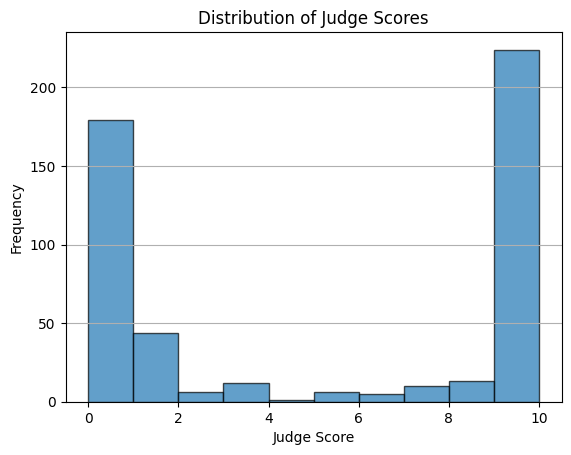

Average Judge Score: 5.128
Median Judge Score: 6.0
Standard Deviation of Judge Scores: 4.686535607461016
Minimum Judge Score: 0.0
Maximum Judge Score: 10.0


In [16]:
plt.hist(judge_scores, bins=10, edgecolor='black', alpha=0.7)
plt.title("Distribution of Judge Scores")
plt.xlabel("Judge Score")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()
print("Average Judge Score:", np.mean(judge_scores))
print("Median Judge Score:", np.median(judge_scores))
print("Standard Deviation of Judge Scores:", np.std(judge_scores))
print("Minimum Judge Score:", np.min(judge_scores))
print("Maximum Judge Score:", np.max(judge_scores))

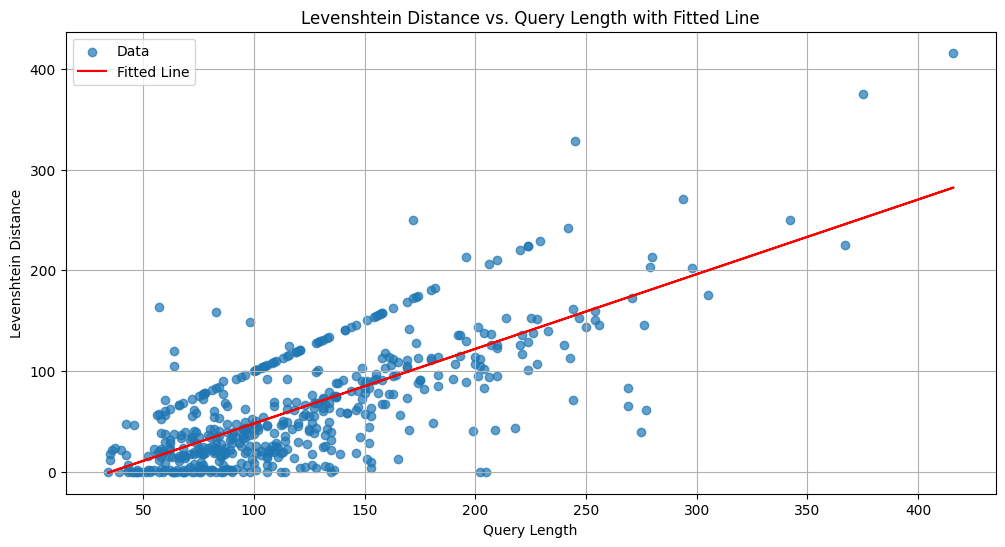

Slope: 0.7409910874588248
Intercept: -26.173124491854608
R-value: 0.7371798865033575
P-value: 7.964371305048468e-87
Standard error: 0.030435226011961365


In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

query_lengths = [m["query_length"] for m in levenshtein_metrics]
distances = [m["distance"] for m in levenshtein_metrics]

x = query_lengths
y = distances

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

def linear_func(x):
    return slope * np.array(x) + intercept

plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.7, label="Data")
plt.plot(x, linear_func(x), color='red', label="Fitted Line")

plt.title("Levenshtein Distance vs. Query Length with Fitted Line")
plt.xlabel("Query Length")
plt.ylabel("Levenshtein Distance")
plt.legend()
plt.grid(True)
plt.show()

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard error:", std_err)

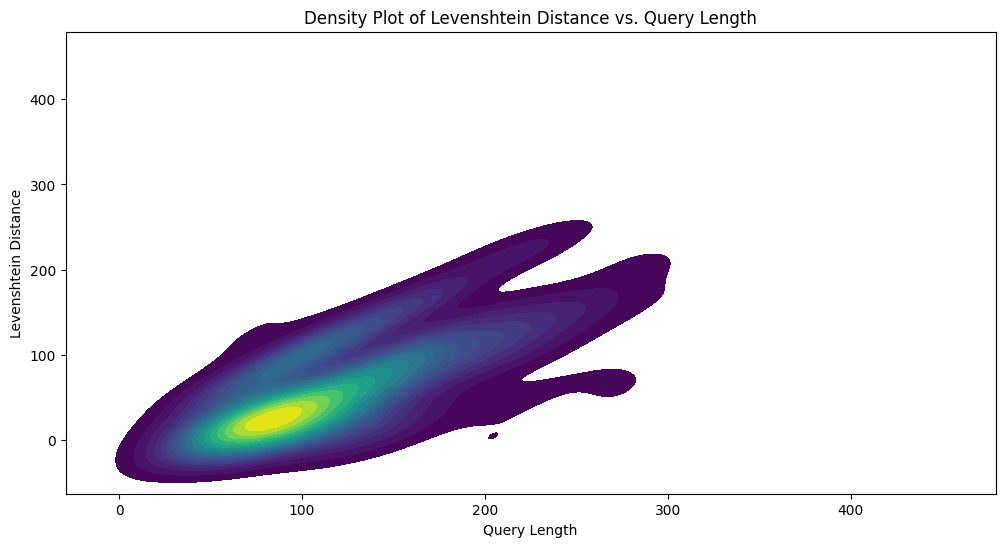

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(x=query_lengths, y=distances, fill=True, cmap="viridis", thresh=0.05, levels=20)
plt.title("Density Plot of Levenshtein Distance vs. Query Length")
plt.xlabel("Query Length")
plt.ylabel("Levenshtein Distance")
plt.show()